## Show effectiveness of Ndiv on gumbel-gan with temperature == 1

## Uncomment code:
                div_loss.backward()
                self.g_optim.step()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
from torch import optim
from collections import Counter
from NDiv.ndiv_pytorch import NDiv_loss

tensor([[3, 3],
        [3, 2],
        [3, 1],
        ...,
        [2, 3],
        [1, 1],
        [3, 1]])


([<matplotlib.axis.XTick at 0x7f4ae6d049e8>,
 <a list of 8 Text xticklabel objects>)

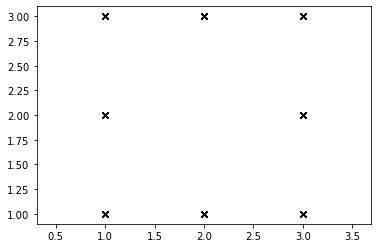

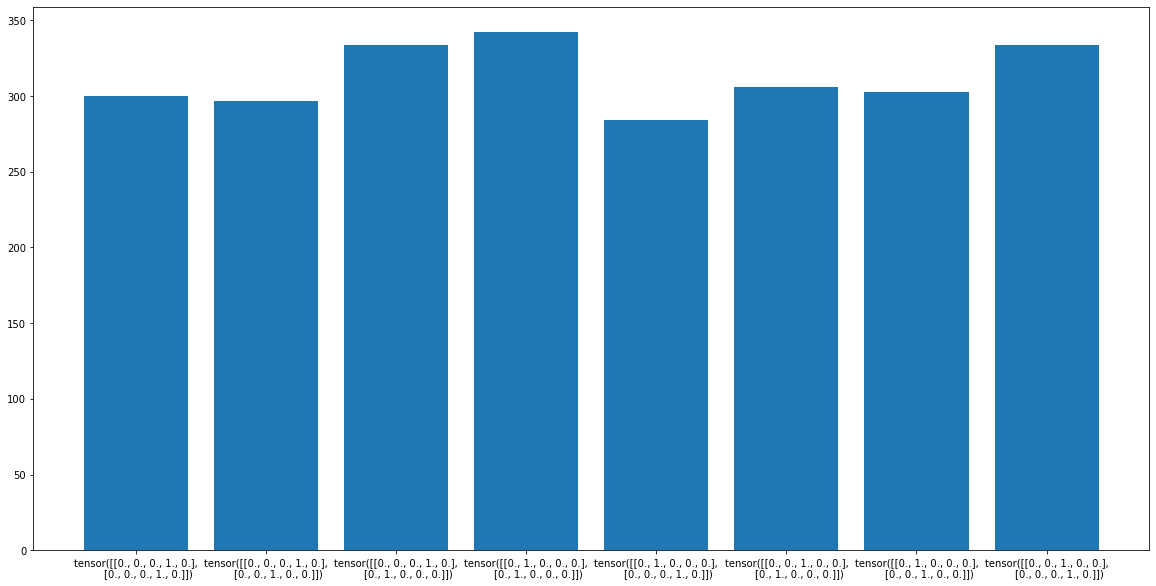

In [2]:
from loadDataset import *
from visualizer import *

data_config = {
    'name' : 'gaussian_grid',
    'n' : 5,
    'n_data' : 100,
    'sig' : 0.01
}

ds = getDataset(data_config)
dl = DataLoader(ds, batch_size=128, shuffle=True)

# gt data func, for train
def gen_real_data_onehot(dl, batch=128):

    real_samples = next(iter(dl))

    ''' delete adjacent modes from dataset '''
    mode_idx = [6,7, 8,11,13, 16, 17, 18]
    real_samples_new = [real_samples[i] for i in mode_idx]
    real_samples = real_samples_new
    
    ''' mix 25 modes '''
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2).long()

    ''' make dataset unbalanced '''
#     real_samples = real_samples[800:]
#     real_samples = real_samples[:-800]
    
    random_choice = torch.randint(0, real_samples.shape[0], (batch, )).long()
    data = real_samples[random_choice]
    data = torch.unsqueeze(data, -1)

    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

# data = gen_real_data_onehot(dl)

# gt data func, for test
def gen_real_data_test(dl, batch=128):

    real_samples = next(iter(dl))

    # mix 25 modes
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2)
    real_samples = torch.unsqueeze(real_samples, -1).long()
    
    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

def gen_input_data(batch=128):
    # https://pytorch.org/docs/stable/torch.html#torch.randn
    data = torch.zeros(int(batch/2), 2)
    data[:, 0] = 0.5
    data[:, 1] = -0.5
    return torch.cat((data, data), 0)

#     data = torch.randn(int(batch/ 2), 2)
#     return torch.cat((data, data), 0)

def gen_input_data_test(batch=128):
    return torch.randn(batch, 2)

''' Plot Distribution for Unbalanced Dataset '''

data = gen_real_data_onehot(dl, 2500)
print(torch.argmax(data,-1))
data_list = [str(x) for x in data]

# plot grid
plot_outputdata(torch.argmax(data, -1), dim1=0, dim2=1, marker='kx', alpha=0.1)

# plot bar chart
index = range(len(Counter(data_list).keys()))
plt.figure(figsize=(20,10))
plt.bar(index, Counter(data_list).values(), align='center')
plt.xticks(index, Counter(data_list).keys())

In [3]:
### Define Gumbel Function Utility

def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape).cuda()
    h = (g + logits) * temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [4]:
### G Network based on gumbel
class MLPG(nn.Module):
    
    def __init__(self, input_size, hidden_size, noise_size, output_size, temperature=1):
        super(MLPG, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3_1 = nn.Linear(hidden_size + noise_size, output_size) # x-axis
        self.map3_2 = nn.Linear(hidden_size + noise_size, output_size) # y-axis
        
        self.name = 'MLPG'
        self.noise_size = noise_size
        self.temp = temperature
        
    def forward(self, x, temperature=None):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size).cuda()

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # perform gumbel sampling
        if temperature is not None:
            x_coord = sample_gumbel_softmax(x_coord, temperature)
            y_coord = sample_gumbel_softmax(y_coord, temperature)
        else:
            x_coord = sample_gumbel_softmax(x_coord, self.temp)
            y_coord = sample_gumbel_softmax(y_coord, self.temp)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1), noise
    
    def checkLogits(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size)

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1)
    
### D Network to produce loss
class MLPD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPD, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, output_size)
        self.name = 'MLPD'
        
    def forward(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        return torch.sigmoid(self.map2(x))
    
### Create the overall network
class gumbel_gan(object):
    def __init__(self, temperature=1):
        self.g = MLPG(2, 128, 25, 5, temperature=temperature).cuda()
        self.d = MLPD(10, 128, 1).cuda()
        
        self.g_optim = optim.Adam(self.g.parameters(), lr=1e-4)
        self.d_optim = optim.Adam(self.d.parameters(), lr=1e-4)
        
        self.d_step = 1
#         self.g_step = 10
        self.g_step = 1
        self.g_NDiv = 3
        
        self.criterion = nn.BCELoss()
        
    def train(self, epoch, real_data, g_input):
        print("training start")
        pbar = range(epoch)
        batch = real_data.shape[0]
        
        for ep in pbar:
            for d_index in range(self.d_step):
                
                # Train D
                self.d.zero_grad()
                
                # Train D on real
                d_real_decision = self.d(real_data)
                labels = torch.ones(d_real_decision.shape, dtype=torch.float32).cuda()
                d_real_loss = self.criterion(d_real_decision, labels)
                
                # Train D on fake
                fake_data, latent_samples = self.g(g_input)
                d_fake_decision = self.d(fake_data.view(batch, -1))
                labels = torch.zeros(d_fake_decision.shape, dtype=torch.float32).cuda()
                
                d_fake_loss = self.criterion(d_fake_decision, labels)

                # calc loss for D
                d_loss = 0.5 * (d_real_loss + d_fake_loss)
#                 d_loss = 0.5 * (d_real_loss + d_fake_loss)
                d_loss.backward()
                d_loss_val = d_loss.item()
                
                # update D
                self.d_optim.step()
                
            """ optim NDiv diversity """
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                # print(latent_samples.shape)
                # raise
                div_loss = NDiv_loss(latent_samples, g_fake_data) * 1e2
                div_loss_val = div_loss.item()
                
                # update G w.r.t NDiv
                div_loss.backward()
                self.g_optim.step()
                
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                batch = g_fake_data.shape[0]
                
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                
                # G loss
                labels = torch.ones(g_fake_decision.shape, dtype=torch.float32).cuda()
                g_loss = -(g_fake_decision.log() * labels + (1-labels)*(1-g_fake_decision.log())).mean()
                
                g_loss_val = g_loss.item()
                
                g_loss.backward()
                
                # update G
                self.g_optim.step()
                
            print("Iteration {}, d real/fake loss {}/{} and g loss is {}, NDiv loss {}".format(ep, d_real_loss.item(), \
                                                                                 d_fake_loss.item(), g_loss, div_loss_val))            

In [5]:
## Init the simple Network
## Define temperature here
net = gumbel_gan(temperature=1)
print(net.g, net.d)

MLPG(
  (map1): Linear(in_features=2, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=128, bias=True)
  (map3_1): Linear(in_features=153, out_features=5, bias=True)
  (map3_2): Linear(in_features=153, out_features=5, bias=True)
) MLPD(
  (map1): Linear(in_features=10, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=1, bias=True)
)


Processing Epoch 0
training start
Iteration 0, d real/fake loss 0.7048004865646362/0.6727614402770996 and g loss is 0.7136569023132324, NDiv loss 0.03043510392308235
Iteration 1, d real/fake loss 0.7040797472000122/0.6733042001724243 and g loss is 0.7138211131095886, NDiv loss 0.028015591204166412
Iteration 2, d real/fake loss 0.7033437490463257/0.6794895529747009 and g loss is 0.7049736380577087, NDiv loss 0.030522089451551437
Iteration 3, d real/fake loss 0.7026277780532837/0.6716378927230835 and g loss is 0.7101122140884399, NDiv loss 0.030032381415367126
Iteration 4, d real/fake loss 0.701905369758606/0.6748837232589722 and g loss is 0.7116057872772217, NDiv loss 0.027850886806845665


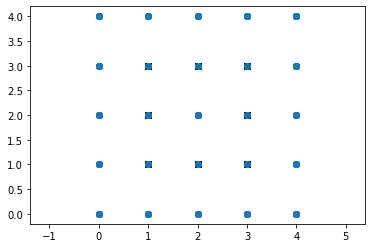

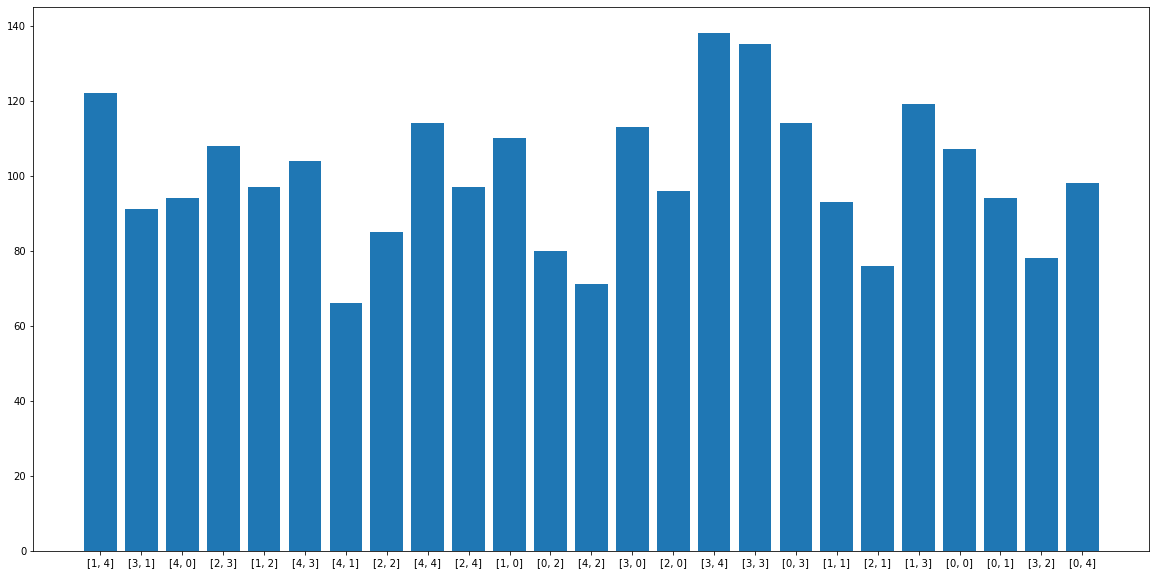

Processing Epoch 1
training start
Iteration 0, d real/fake loss 0.6934751272201538/0.677743673324585 and g loss is 0.7152594327926636, NDiv loss 0.029821891337633133
Iteration 1, d real/fake loss 0.6927629709243774/0.6758871078491211 and g loss is 0.7119933366775513, NDiv loss 0.030513489618897438
Iteration 2, d real/fake loss 0.6920464038848877/0.6751724481582642 and g loss is 0.7109425067901611, NDiv loss 0.02873951941728592
Iteration 3, d real/fake loss 0.6913326978683472/0.6747152209281921 and g loss is 0.712348997592926, NDiv loss 0.02732519991695881
Iteration 4, d real/fake loss 0.6906142830848694/0.679686427116394 and g loss is 0.7077532410621643, NDiv loss 0.028771720826625824


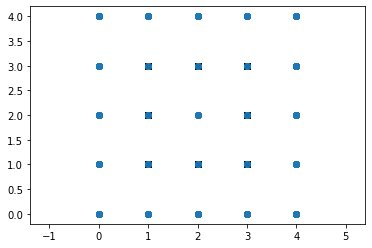

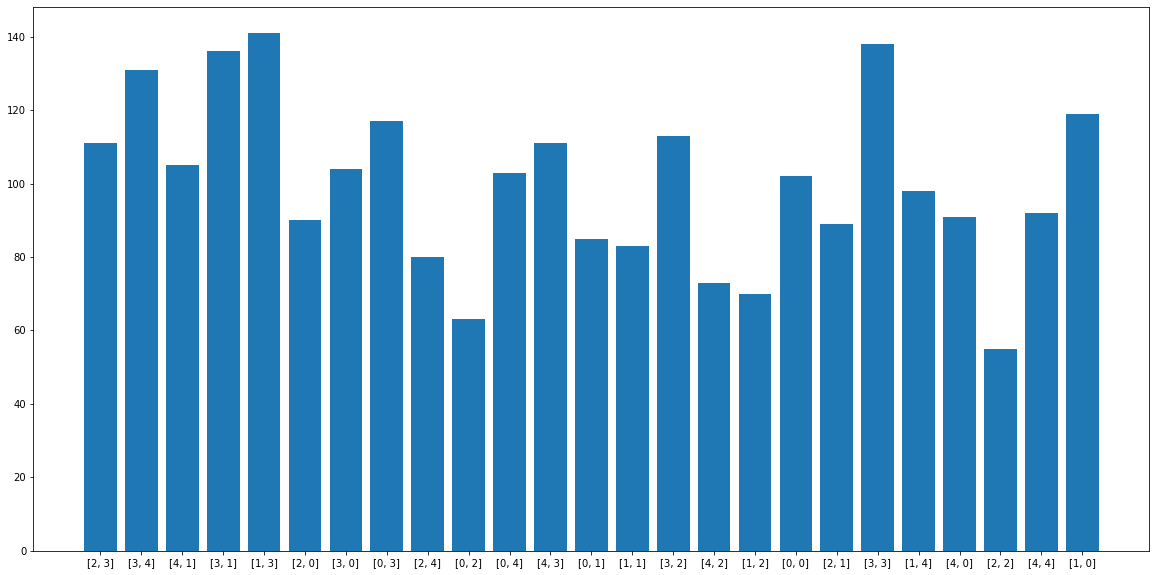

Processing Epoch 2
training start
Iteration 0, d real/fake loss 0.7023303508758545/0.6790986061096191 and g loss is 0.7111684679985046, NDiv loss 0.030246254056692123
Iteration 1, d real/fake loss 0.7016290426254272/0.6793453693389893 and g loss is 0.7073320150375366, NDiv loss 0.027051743119955063
Iteration 2, d real/fake loss 0.7009338140487671/0.6761912107467651 and g loss is 0.7077337503433228, NDiv loss 0.027983257547020912
Iteration 3, d real/fake loss 0.7002425193786621/0.6783841848373413 and g loss is 0.7069776058197021, NDiv loss 0.028753239661455154
Iteration 4, d real/fake loss 0.6995524764060974/0.6776310801506042 and g loss is 0.7073922753334045, NDiv loss 0.02719644457101822


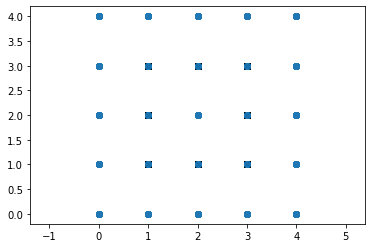

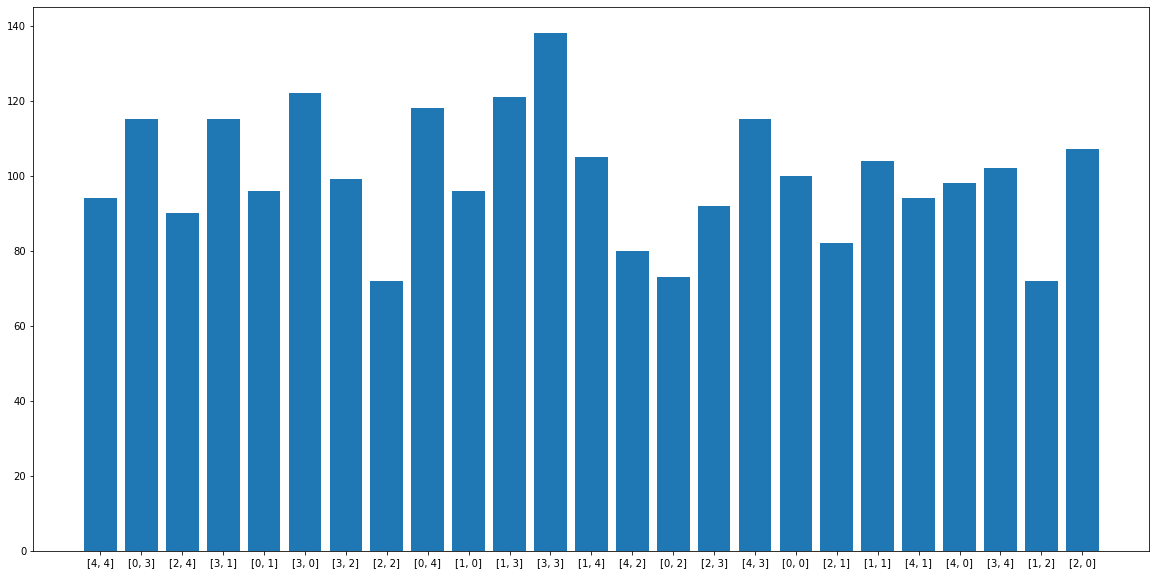

Processing Epoch 3
training start
Iteration 0, d real/fake loss 0.6938689351081848/0.6819202303886414 and g loss is 0.7092031240463257, NDiv loss 0.0297367163002491
Iteration 1, d real/fake loss 0.6931983232498169/0.6770005226135254 and g loss is 0.7090784311294556, NDiv loss 0.02890593372285366
Iteration 2, d real/fake loss 0.6925381422042847/0.6813915967941284 and g loss is 0.7060756683349609, NDiv loss 0.028931904584169388
Iteration 3, d real/fake loss 0.6918860077857971/0.6869188547134399 and g loss is 0.7032220363616943, NDiv loss 0.028268231078982353
Iteration 4, d real/fake loss 0.6912472248077393/0.6839307546615601 and g loss is 0.7082786560058594, NDiv loss 0.02762303128838539


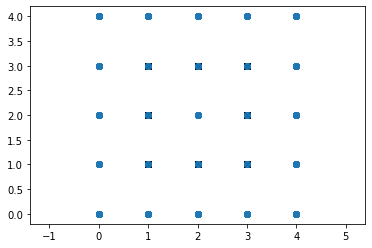

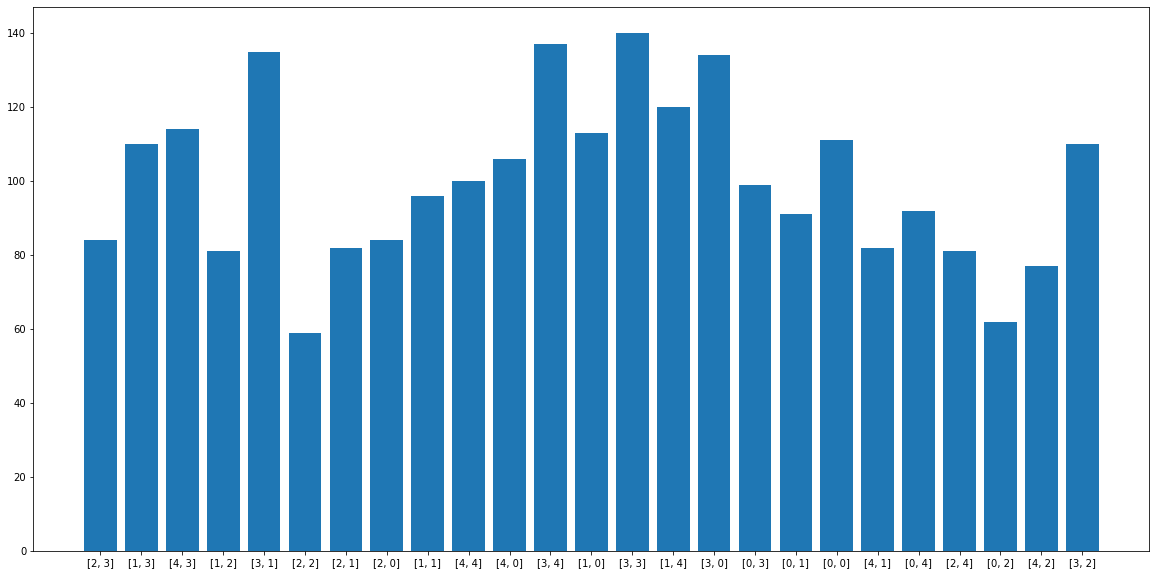

Processing Epoch 4
training start
Iteration 0, d real/fake loss 0.6916080713272095/0.682919442653656 and g loss is 0.7058120369911194, NDiv loss 0.03094247356057167
Iteration 1, d real/fake loss 0.6909940242767334/0.6838921308517456 and g loss is 0.7051643133163452, NDiv loss 0.030056750401854515
Iteration 2, d real/fake loss 0.690390408039093/0.6845664381980896 and g loss is 0.7082823514938354, NDiv loss 0.029717283323407173
Iteration 3, d real/fake loss 0.6897978782653809/0.6852164268493652 and g loss is 0.7087605595588684, NDiv loss 0.029609128832817078
Iteration 4, d real/fake loss 0.6892111301422119/0.6833269596099854 and g loss is 0.7047392129898071, NDiv loss 0.028722986578941345


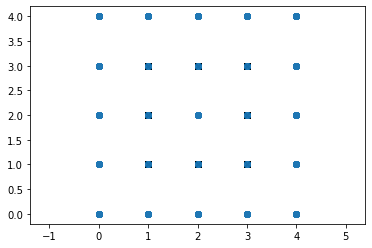

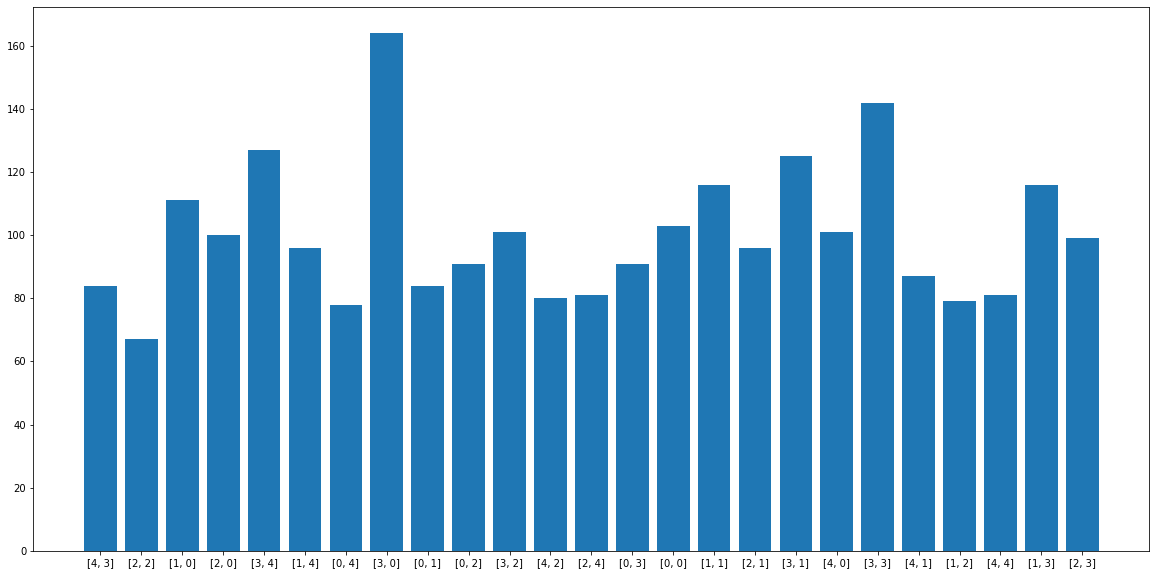

Processing Epoch 5
training start
Iteration 0, d real/fake loss 0.6883059740066528/0.6859176158905029 and g loss is 0.7028011083602905, NDiv loss 0.029085658490657806
Iteration 1, d real/fake loss 0.6877488493919373/0.6865832805633545 and g loss is 0.7019339799880981, NDiv loss 0.02953973226249218
Iteration 2, d real/fake loss 0.6871889233589172/0.6828045845031738 and g loss is 0.6999194622039795, NDiv loss 0.028524646535515785
Iteration 3, d real/fake loss 0.6866247653961182/0.6835144758224487 and g loss is 0.6983080506324768, NDiv loss 0.028509030118584633
Iteration 4, d real/fake loss 0.6860580444335938/0.6803368926048279 and g loss is 0.7006509304046631, NDiv loss 0.029927341267466545


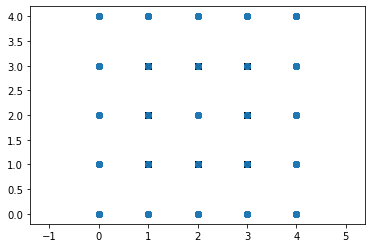

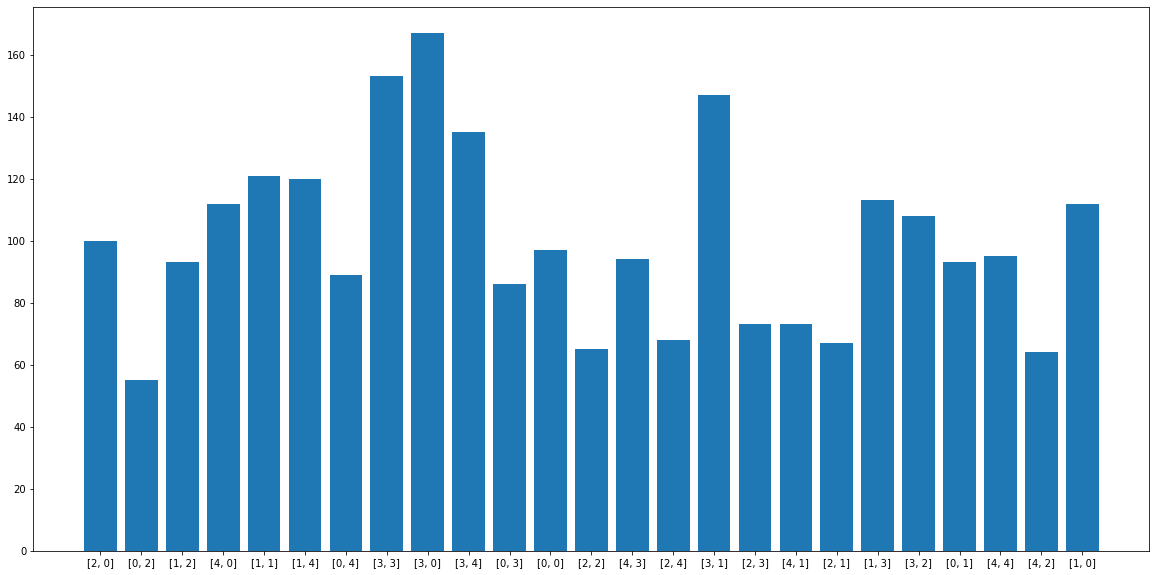

Processing Epoch 6
training start
Iteration 0, d real/fake loss 0.6930791139602661/0.6873498558998108 and g loss is 0.7062799334526062, NDiv loss 0.03035174123942852
Iteration 1, d real/fake loss 0.6925016045570374/0.685294508934021 and g loss is 0.7026183605194092, NDiv loss 0.029720215126872063
Iteration 2, d real/fake loss 0.6919233798980713/0.6906108856201172 and g loss is 0.7039372324943542, NDiv loss 0.029281336814165115
Iteration 3, d real/fake loss 0.6913504004478455/0.6851504445075989 and g loss is 0.7015284299850464, NDiv loss 0.02822704054415226
Iteration 4, d real/fake loss 0.690779447555542/0.6909526586532593 and g loss is 0.6981974244117737, NDiv loss 0.030515354126691818


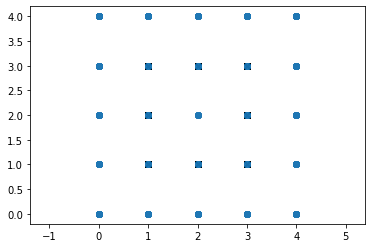

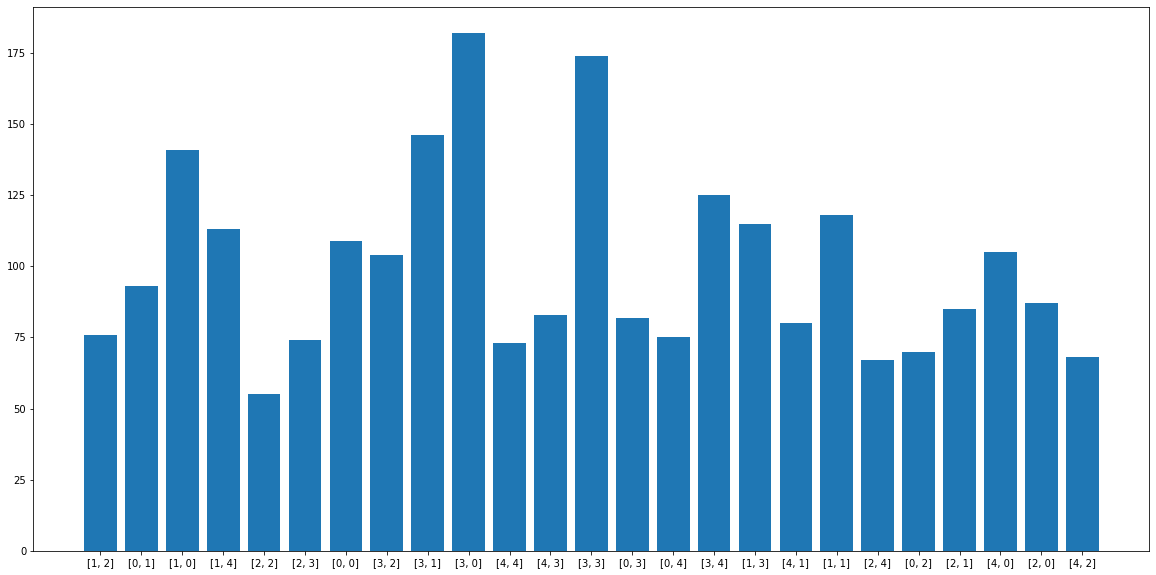

Processing Epoch 7
training start
Iteration 0, d real/fake loss 0.6806755065917969/0.6914712190628052 and g loss is 0.6972087025642395, NDiv loss 0.028655290603637695
Iteration 1, d real/fake loss 0.6801484823226929/0.6893709301948547 and g loss is 0.7001383304595947, NDiv loss 0.02984677255153656
Iteration 2, d real/fake loss 0.6796274185180664/0.6892335414886475 and g loss is 0.6955723762512207, NDiv loss 0.029005447402596474
Iteration 3, d real/fake loss 0.6791177988052368/0.6884578466415405 and g loss is 0.694123387336731, NDiv loss 0.029253069311380386
Iteration 4, d real/fake loss 0.6786154508590698/0.6810027360916138 and g loss is 0.6966995000839233, NDiv loss 0.027790723368525505


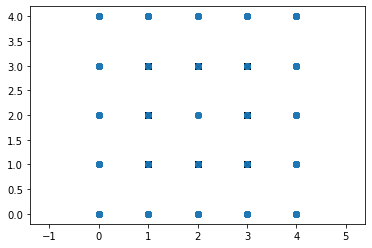

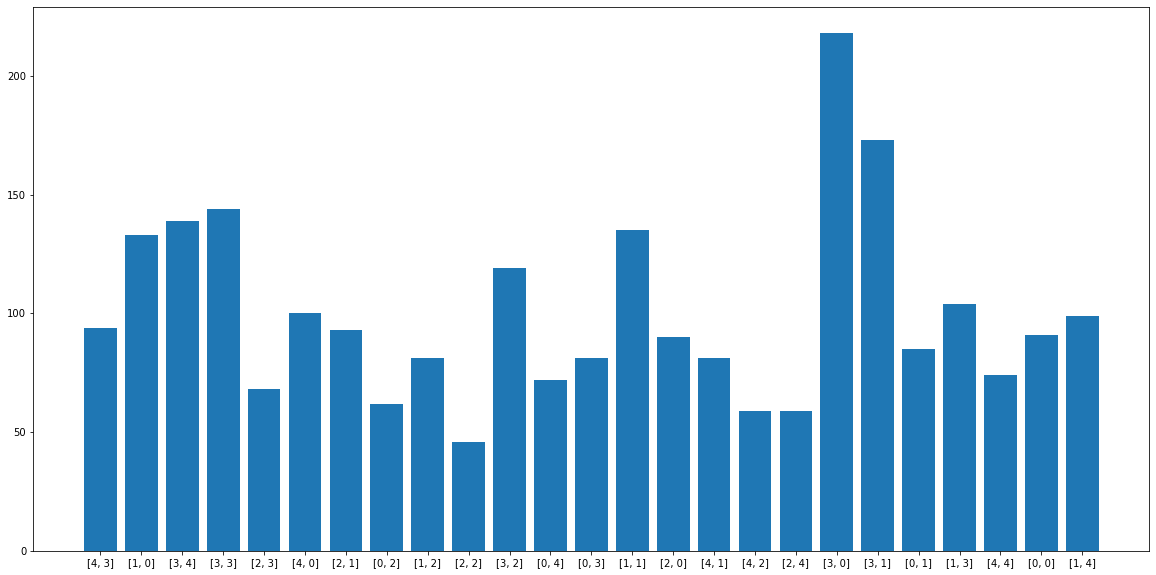

Processing Epoch 8
training start
Iteration 0, d real/fake loss 0.6739155054092407/0.6874057054519653 and g loss is 0.6956475377082825, NDiv loss 0.02878001518547535
Iteration 1, d real/fake loss 0.6734243035316467/0.6944987773895264 and g loss is 0.694921612739563, NDiv loss 0.027771098539233208
Iteration 2, d real/fake loss 0.6729507446289062/0.6888546943664551 and g loss is 0.69367516040802, NDiv loss 0.030410299077630043
Iteration 3, d real/fake loss 0.6724852323532104/0.6875013709068298 and g loss is 0.6984310746192932, NDiv loss 0.029086891561746597
Iteration 4, d real/fake loss 0.6720247268676758/0.6906968355178833 and g loss is 0.6916152238845825, NDiv loss 0.02906940132379532


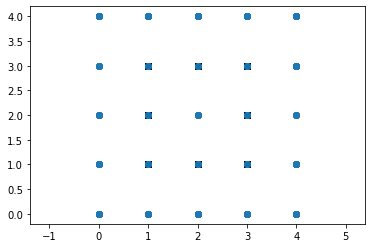

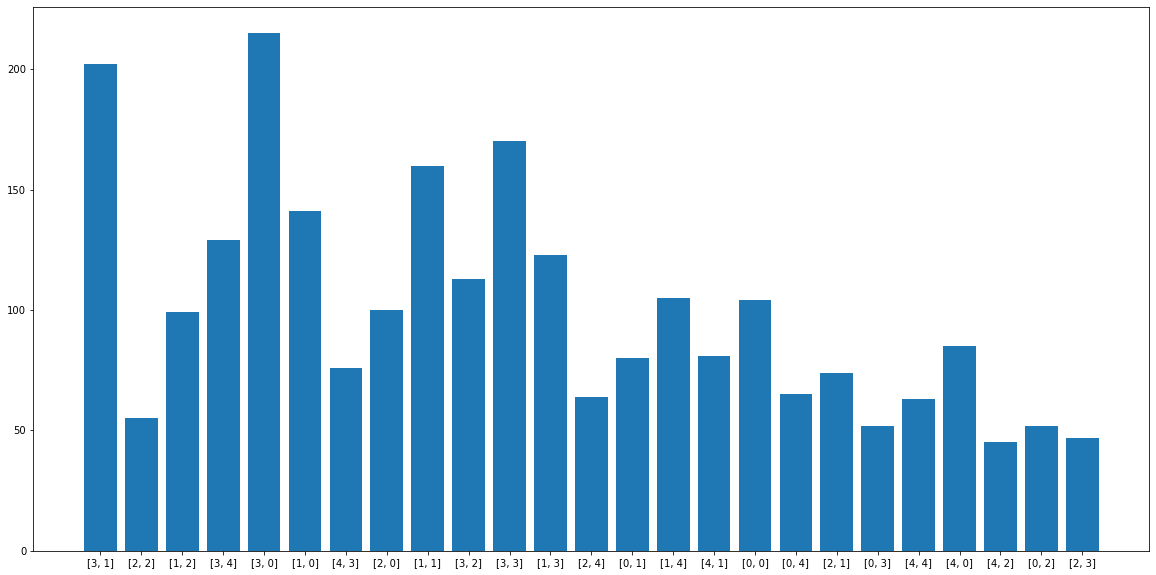

Processing Epoch 9
training start
Iteration 0, d real/fake loss 0.6889935731887817/0.6884880065917969 and g loss is 0.6963315010070801, NDiv loss 0.02942112646996975
Iteration 1, d real/fake loss 0.6885575652122498/0.6951848268508911 and g loss is 0.6922455430030823, NDiv loss 0.03199756145477295
Iteration 2, d real/fake loss 0.6881176233291626/0.6918184161186218 and g loss is 0.6972948908805847, NDiv loss 0.03068135678768158
Iteration 3, d real/fake loss 0.68766850233078/0.6920335292816162 and g loss is 0.6924406290054321, NDiv loss 0.028499020263552666
Iteration 4, d real/fake loss 0.6872125864028931/0.6916718482971191 and g loss is 0.6933851838111877, NDiv loss 0.02916163019835949


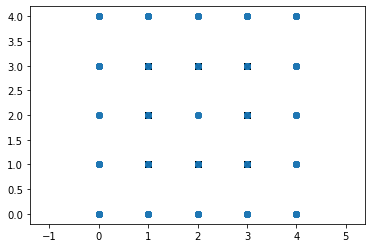

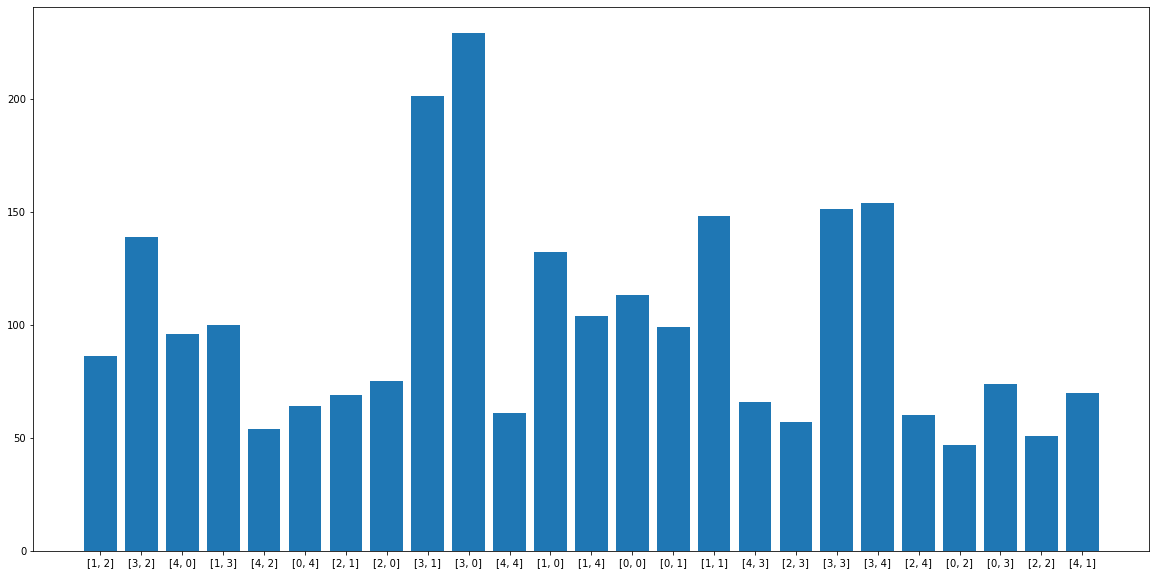

Processing Epoch 10
training start
Iteration 0, d real/fake loss 0.6815713047981262/0.6887676119804382 and g loss is 0.693778932094574, NDiv loss 0.030528085306286812
Iteration 1, d real/fake loss 0.6811483502388/0.692314624786377 and g loss is 0.6947031021118164, NDiv loss 0.03252097964286804
Iteration 2, d real/fake loss 0.6807280778884888/0.6957491636276245 and g loss is 0.691834568977356, NDiv loss 0.029717255383729935
Iteration 3, d real/fake loss 0.680313229560852/0.6981172561645508 and g loss is 0.6947200298309326, NDiv loss 0.03220423310995102
Iteration 4, d real/fake loss 0.6799060106277466/0.6946110725402832 and g loss is 0.6944328546524048, NDiv loss 0.029928144067525864


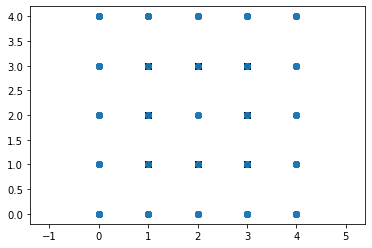

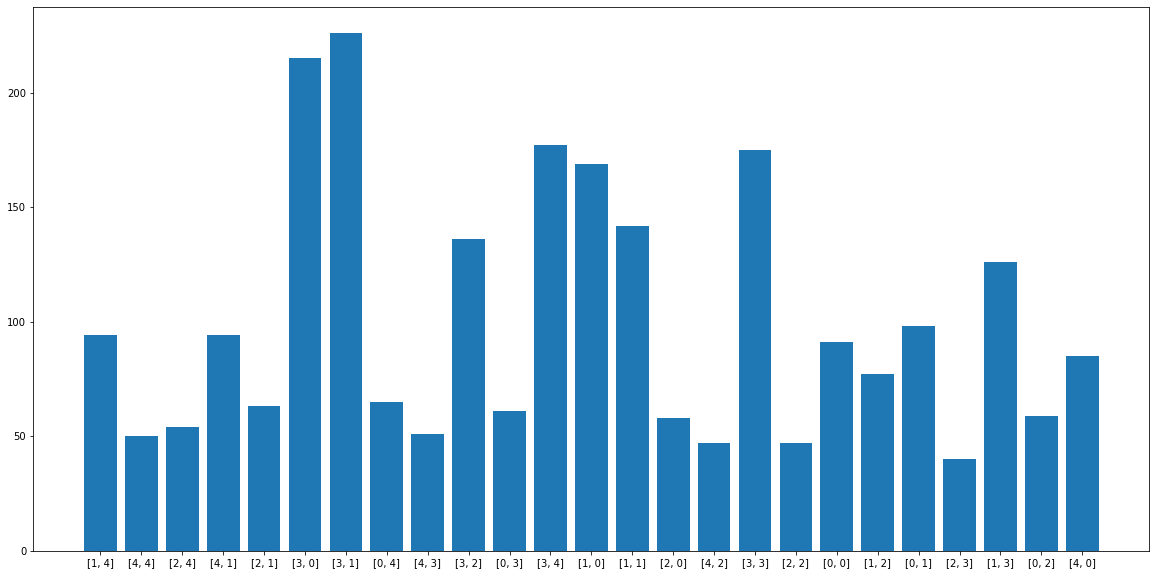

Processing Epoch 11
training start
Iteration 0, d real/fake loss 0.675295889377594/0.6909568905830383 and g loss is 0.6915489435195923, NDiv loss 0.03052307665348053
Iteration 1, d real/fake loss 0.6749299168586731/0.6943894028663635 and g loss is 0.6914623975753784, NDiv loss 0.03135952726006508
Iteration 2, d real/fake loss 0.6745700836181641/0.6966210603713989 and g loss is 0.690974235534668, NDiv loss 0.029097905382514
Iteration 3, d real/fake loss 0.6742186546325684/0.697250485420227 and g loss is 0.6969813704490662, NDiv loss 0.03128441795706749
Iteration 4, d real/fake loss 0.6738739013671875/0.696934163570404 and g loss is 0.6960890889167786, NDiv loss 0.029577478766441345


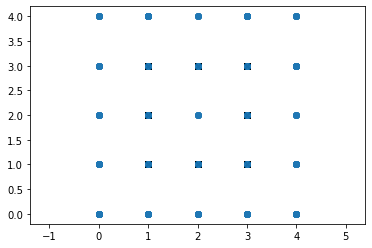

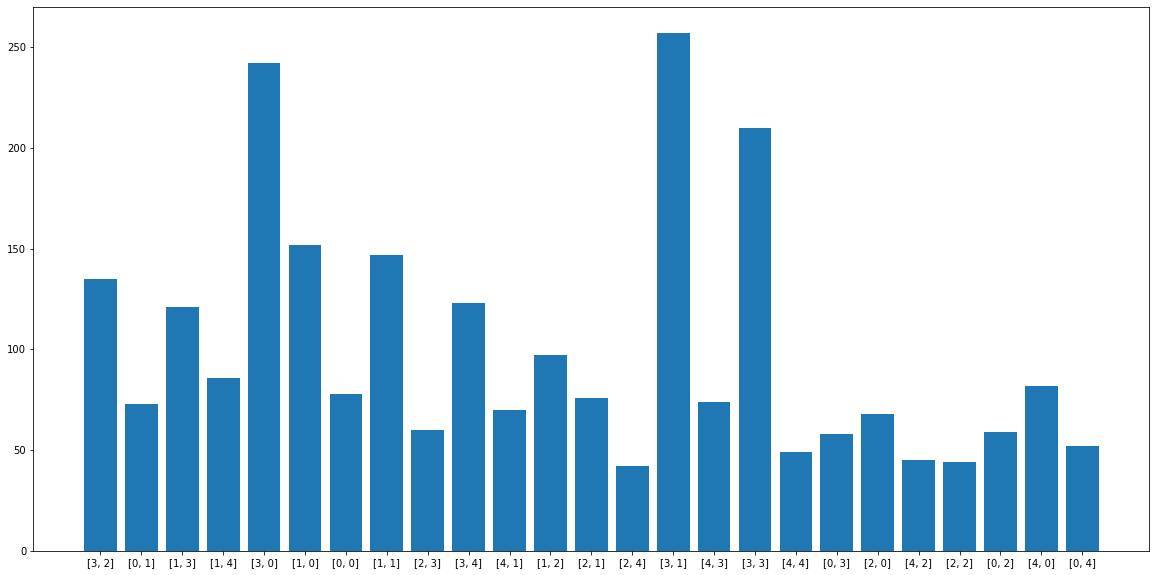

Processing Epoch 12
training start
Iteration 0, d real/fake loss 0.6780308485031128/0.6902621984481812 and g loss is 0.6891956329345703, NDiv loss 0.031727664172649384
Iteration 1, d real/fake loss 0.677674412727356/0.6979868412017822 and g loss is 0.6910610198974609, NDiv loss 0.030254138633608818
Iteration 2, d real/fake loss 0.6773266792297363/0.700114369392395 and g loss is 0.6967189311981201, NDiv loss 0.0319398008286953
Iteration 3, d real/fake loss 0.6769882440567017/0.6966968774795532 and g loss is 0.6889860033988953, NDiv loss 0.031242379918694496
Iteration 4, d real/fake loss 0.6766557693481445/0.6917967200279236 and g loss is 0.6914945244789124, NDiv loss 0.03131392225623131


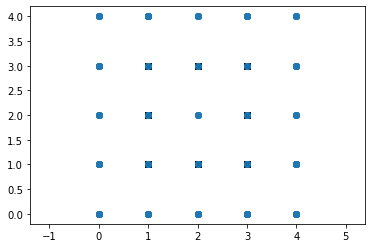

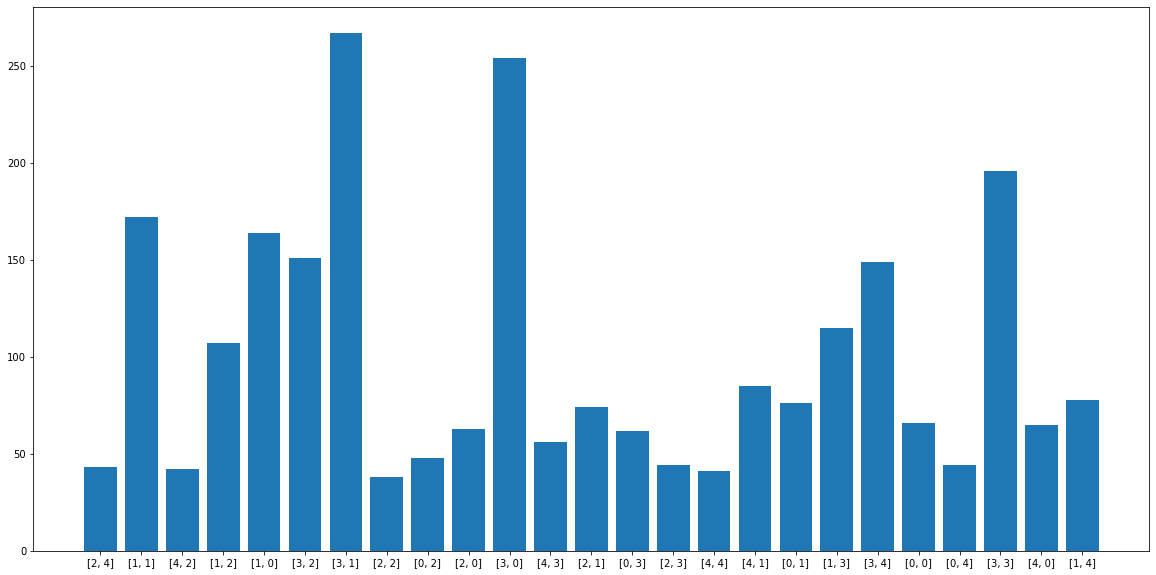

Processing Epoch 13
training start
Iteration 0, d real/fake loss 0.6737954616546631/0.6936656832695007 and g loss is 0.6948584914207458, NDiv loss 0.03217214718461037
Iteration 1, d real/fake loss 0.6734647154808044/0.6980173587799072 and g loss is 0.6870638132095337, NDiv loss 0.028569981455802917
Iteration 2, d real/fake loss 0.673138439655304/0.7008236646652222 and g loss is 0.6867509484291077, NDiv loss 0.031674254685640335
Iteration 3, d real/fake loss 0.6728204488754272/0.6940600872039795 and g loss is 0.6880621314048767, NDiv loss 0.02989494614303112
Iteration 4, d real/fake loss 0.6725051403045654/0.6939823627471924 and g loss is 0.6871268153190613, NDiv loss 0.029688861221075058


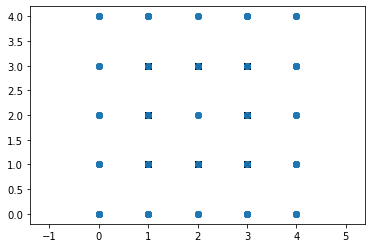

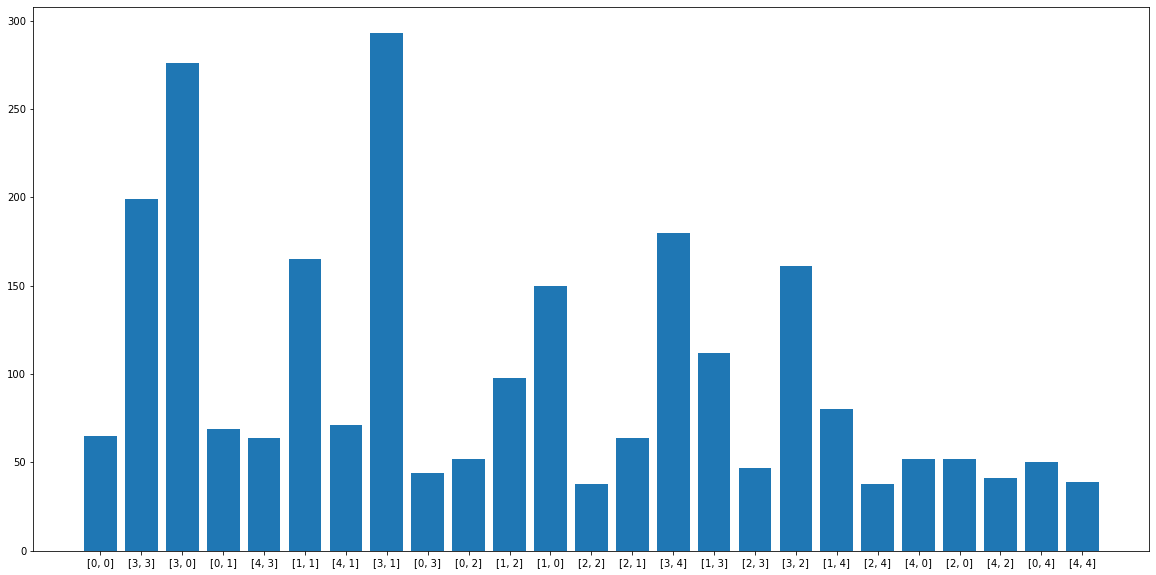

Processing Epoch 14
training start
Iteration 0, d real/fake loss 0.6793875694274902/0.6995865106582642 and g loss is 0.6828610301017761, NDiv loss 0.032318808138370514
Iteration 1, d real/fake loss 0.6790543794631958/0.6931989789009094 and g loss is 0.6947603225708008, NDiv loss 0.0326089933514595
Iteration 2, d real/fake loss 0.6787156462669373/0.6987972855567932 and g loss is 0.6910857558250427, NDiv loss 0.03174911439418793
Iteration 3, d real/fake loss 0.6783755421638489/0.6968423128128052 and g loss is 0.6870958805084229, NDiv loss 0.0320243313908577
Iteration 4, d real/fake loss 0.6780314445495605/0.6974819898605347 and g loss is 0.690223217010498, NDiv loss 0.031200900673866272


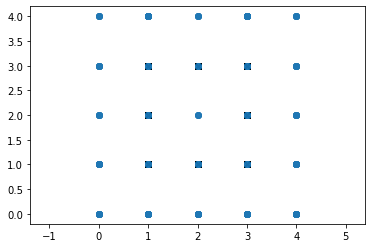

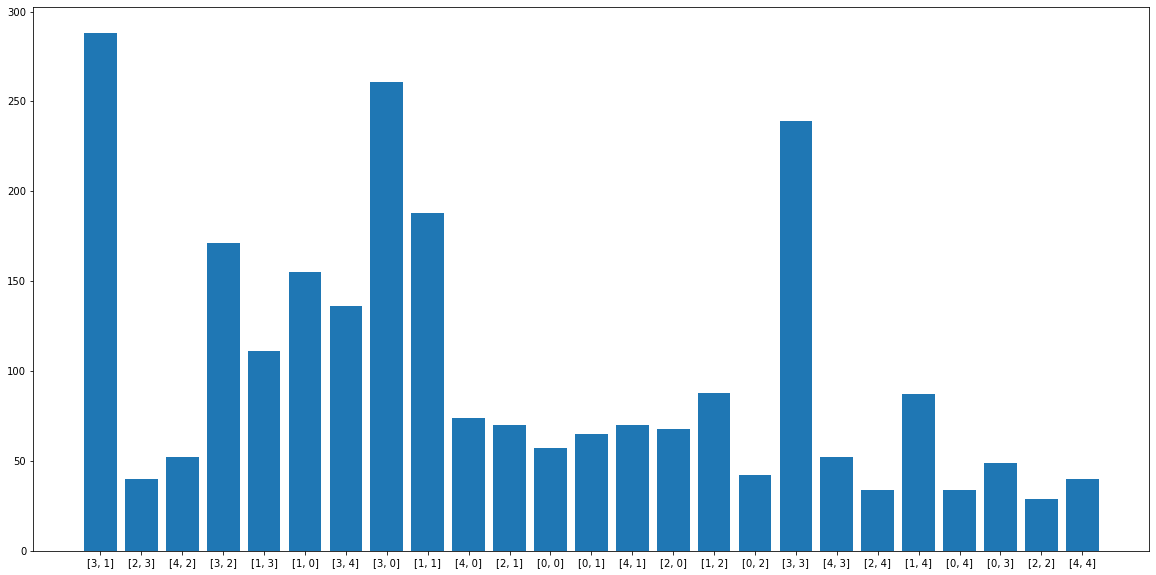

Processing Epoch 15
training start
Iteration 0, d real/fake loss 0.6760098338127136/0.6934013366699219 and g loss is 0.6855055689811707, NDiv loss 0.03285307437181473
Iteration 1, d real/fake loss 0.6756635308265686/0.7001122832298279 and g loss is 0.6811671257019043, NDiv loss 0.033642206341028214
Iteration 2, d real/fake loss 0.6753208637237549/0.7012029886245728 and g loss is 0.686973512172699, NDiv loss 0.02982357330620289
Iteration 3, d real/fake loss 0.6749776005744934/0.7027738094329834 and g loss is 0.6899456977844238, NDiv loss 0.03071672096848488
Iteration 4, d real/fake loss 0.6746404767036438/0.6975477933883667 and g loss is 0.6914106607437134, NDiv loss 0.03088187612593174


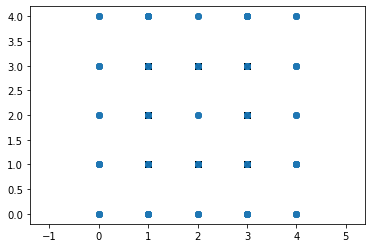

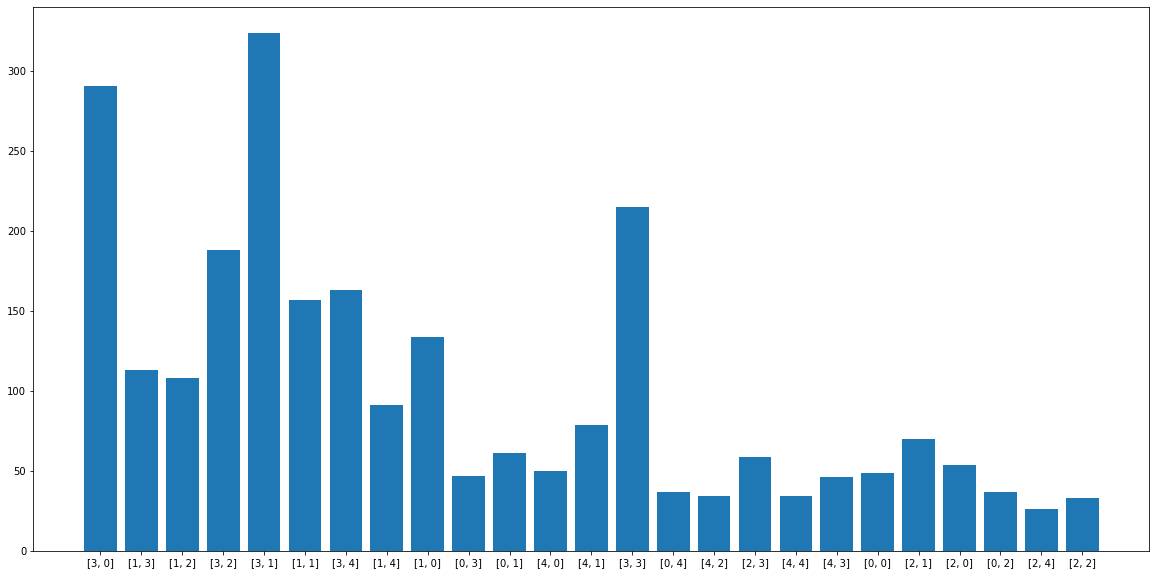

Processing Epoch 16
training start
Iteration 0, d real/fake loss 0.6618609428405762/0.6944071054458618 and g loss is 0.686534583568573, NDiv loss 0.034305162727832794
Iteration 1, d real/fake loss 0.6616021990776062/0.7022568583488464 and g loss is 0.6864114999771118, NDiv loss 0.02879920043051243
Iteration 2, d real/fake loss 0.6613588929176331/0.7011975646018982 and g loss is 0.6862574219703674, NDiv loss 0.03151586651802063
Iteration 3, d real/fake loss 0.661127507686615/0.7020747661590576 and g loss is 0.6864110231399536, NDiv loss 0.03332175314426422
Iteration 4, d real/fake loss 0.6609103679656982/0.6983204483985901 and g loss is 0.6843858957290649, NDiv loss 0.03265855833888054


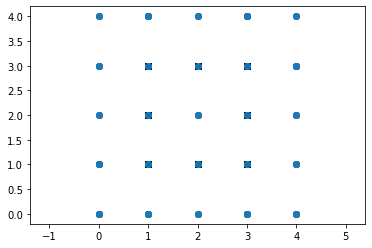

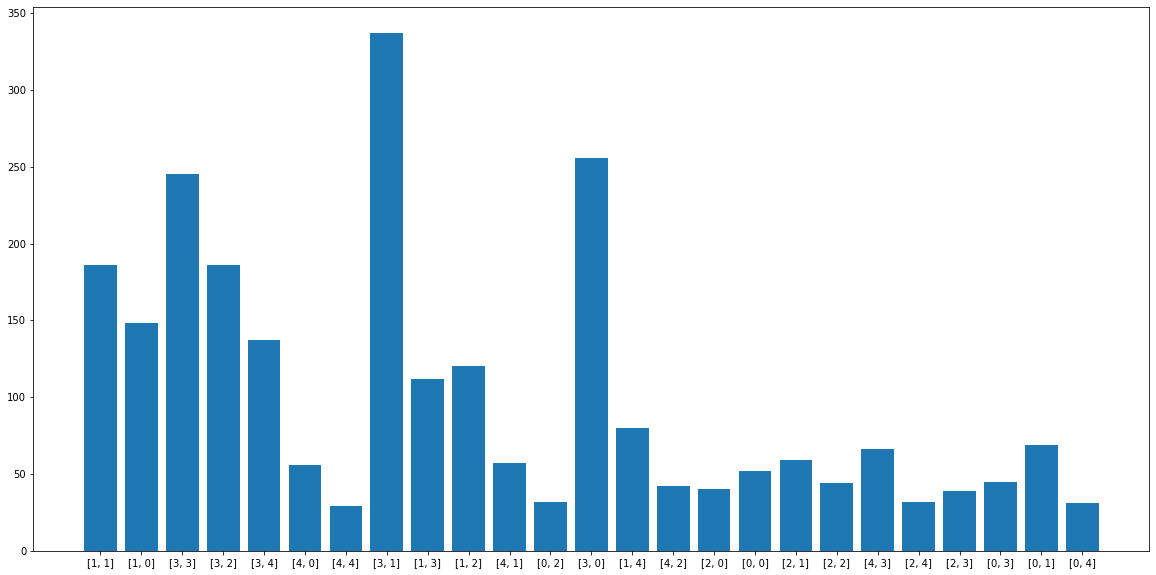

Processing Epoch 17
training start
Iteration 0, d real/fake loss 0.6629887223243713/0.6994467973709106 and g loss is 0.6802308559417725, NDiv loss 0.03282300755381584
Iteration 1, d real/fake loss 0.6627872586250305/0.705582857131958 and g loss is 0.6854037642478943, NDiv loss 0.03271763026714325
Iteration 2, d real/fake loss 0.6625931262969971/0.7005188465118408 and g loss is 0.6844400763511658, NDiv loss 0.031801171600818634
Iteration 3, d real/fake loss 0.6624064445495605/0.7034956216812134 and g loss is 0.6856213808059692, NDiv loss 0.03249717876315117
Iteration 4, d real/fake loss 0.6622244119644165/0.6995149850845337 and g loss is 0.689998984336853, NDiv loss 0.030761389061808586


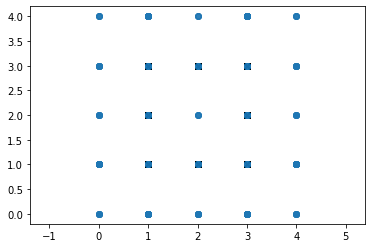

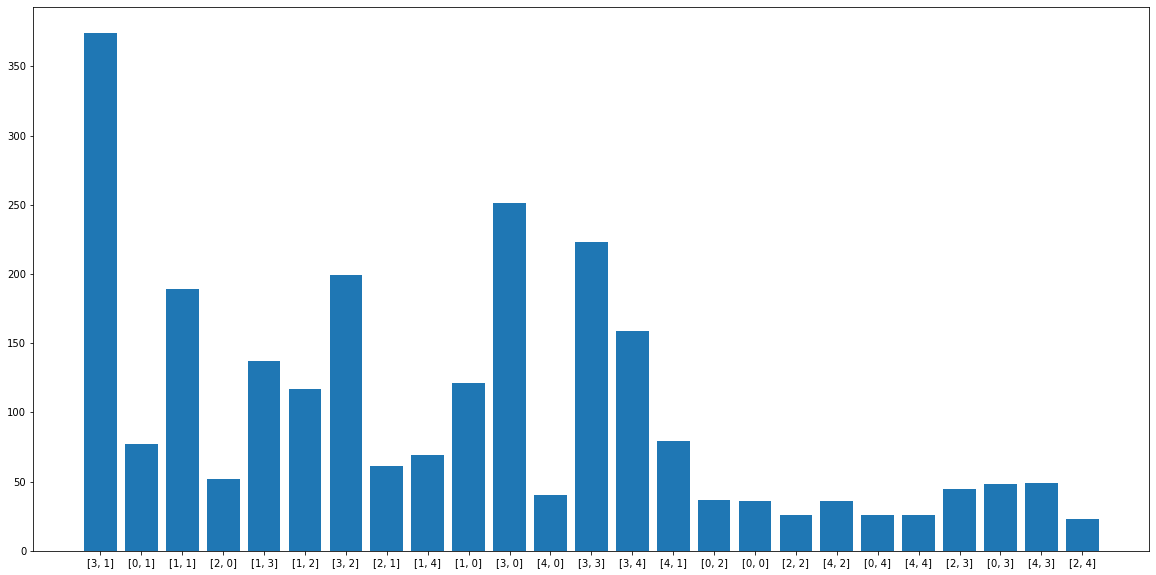

Processing Epoch 18
training start
Iteration 0, d real/fake loss 0.6565566062927246/0.6987966299057007 and g loss is 0.6905987858772278, NDiv loss 0.034303564578294754
Iteration 1, d real/fake loss 0.6564512252807617/0.6957393884658813 and g loss is 0.6930788159370422, NDiv loss 0.03308374434709549
Iteration 2, d real/fake loss 0.6563384532928467/0.7024149894714355 and g loss is 0.6866095066070557, NDiv loss 0.03303823620080948
Iteration 3, d real/fake loss 0.6562252640724182/0.6987202763557434 and g loss is 0.6838885545730591, NDiv loss 0.03227831423282623
Iteration 4, d real/fake loss 0.6561082005500793/0.7003277540206909 and g loss is 0.6837696433067322, NDiv loss 0.03429663926362991


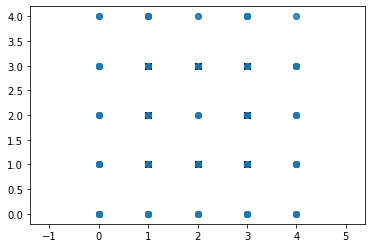

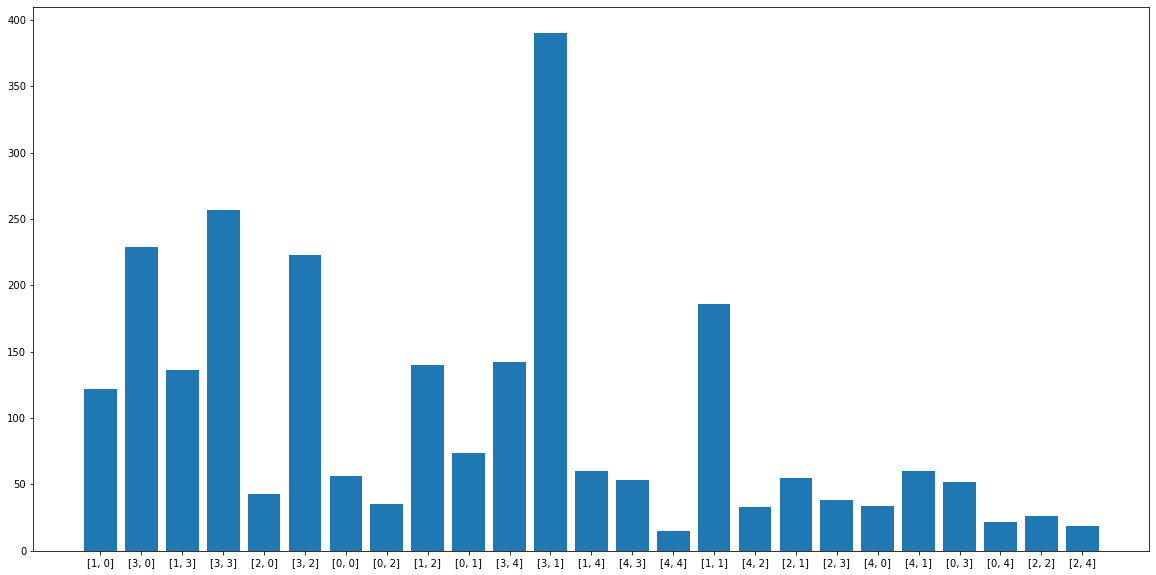

Processing Epoch 19
training start
Iteration 0, d real/fake loss 0.6629601716995239/0.7012492418289185 and g loss is 0.6860826015472412, NDiv loss 0.033405642956495285
Iteration 1, d real/fake loss 0.6628021001815796/0.6956483721733093 and g loss is 0.6930563449859619, NDiv loss 0.030654095113277435
Iteration 2, d real/fake loss 0.6626337766647339/0.6991881132125854 and g loss is 0.6896204352378845, NDiv loss 0.032419294118881226
Iteration 3, d real/fake loss 0.6624632477760315/0.7007046937942505 and g loss is 0.6827574372291565, NDiv loss 0.03245067968964577
Iteration 4, d real/fake loss 0.662287175655365/0.7022199630737305 and g loss is 0.6887723803520203, NDiv loss 0.03255215287208557


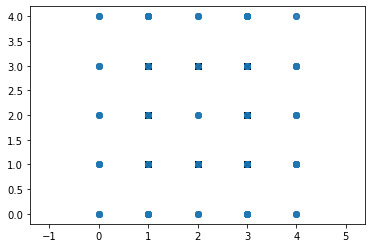

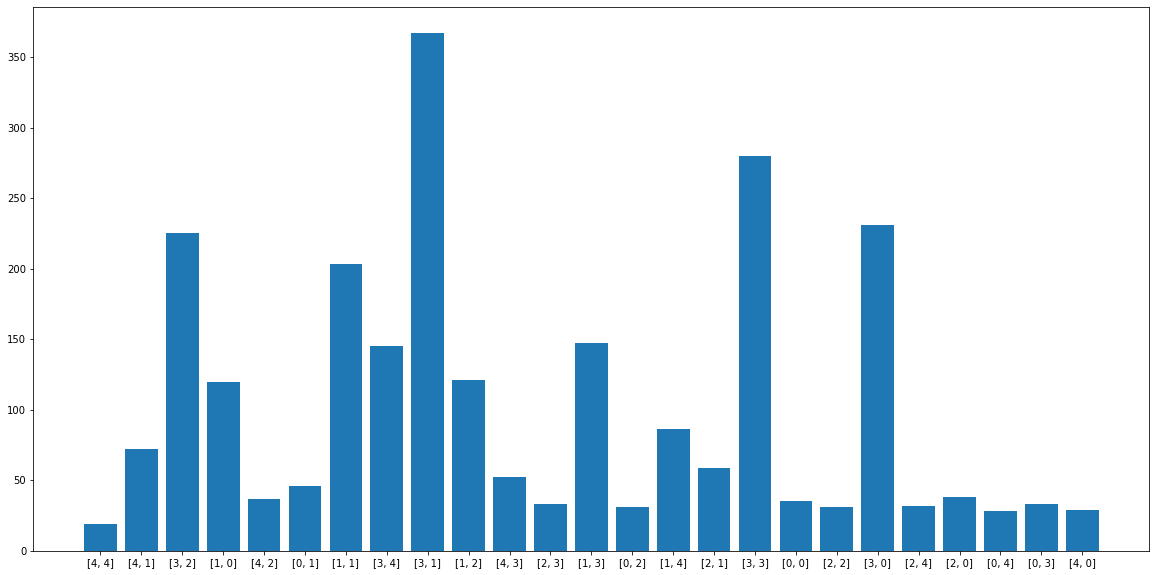

Processing Epoch 20
training start
Iteration 0, d real/fake loss 0.6626009941101074/0.7019796371459961 and g loss is 0.6855183839797974, NDiv loss 0.0335497222840786
Iteration 1, d real/fake loss 0.6624244451522827/0.6986712217330933 and g loss is 0.6914426684379578, NDiv loss 0.035085346549749374
Iteration 2, d real/fake loss 0.6622462272644043/0.7046489119529724 and g loss is 0.685829222202301, NDiv loss 0.03579871729016304
Iteration 3, d real/fake loss 0.6620721220970154/0.698645830154419 and g loss is 0.6874256730079651, NDiv loss 0.033109936863183975
Iteration 4, d real/fake loss 0.6618970632553101/0.6997940540313721 and g loss is 0.6786215305328369, NDiv loss 0.03671704977750778


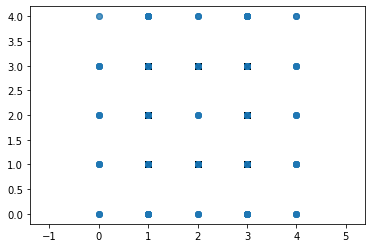

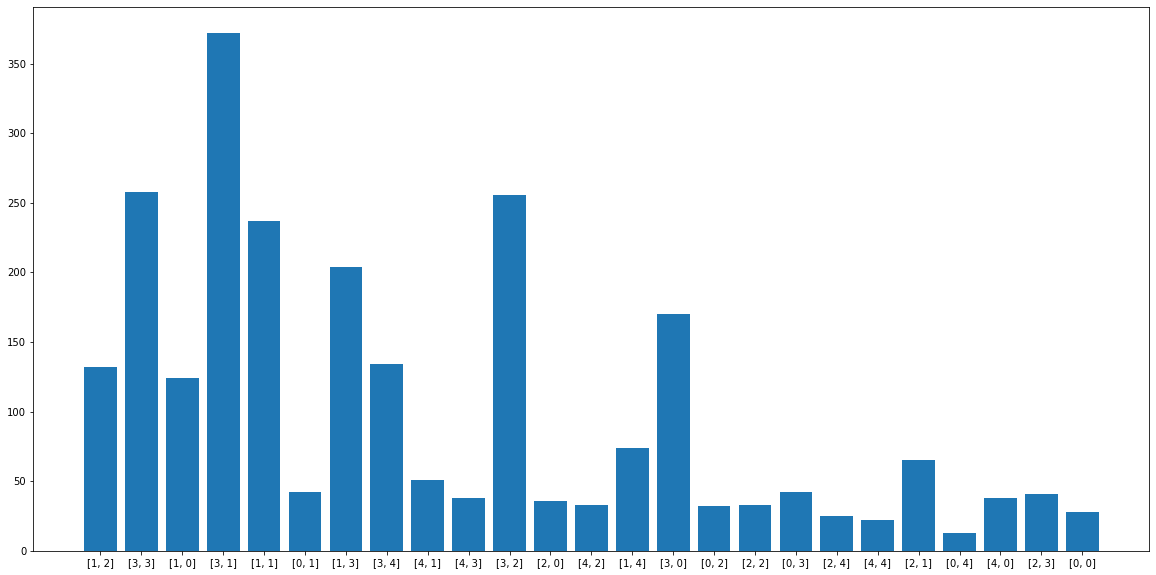

Processing Epoch 21
training start
Iteration 0, d real/fake loss 0.660402774810791/0.6983252763748169 and g loss is 0.6837584972381592, NDiv loss 0.033985503017902374
Iteration 1, d real/fake loss 0.6602616310119629/0.7013782262802124 and g loss is 0.6819484233856201, NDiv loss 0.0321139357984066
Iteration 2, d real/fake loss 0.6601266860961914/0.7061867117881775 and g loss is 0.6910600662231445, NDiv loss 0.03325013443827629
Iteration 3, d real/fake loss 0.6599991917610168/0.7029551267623901 and g loss is 0.685654878616333, NDiv loss 0.0373644195497036
Iteration 4, d real/fake loss 0.6598763465881348/0.6970816850662231 and g loss is 0.6847032308578491, NDiv loss 0.031675755977630615


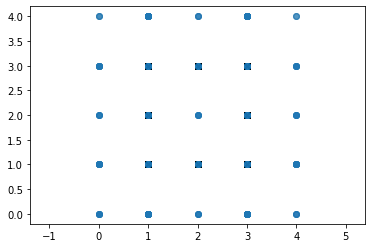

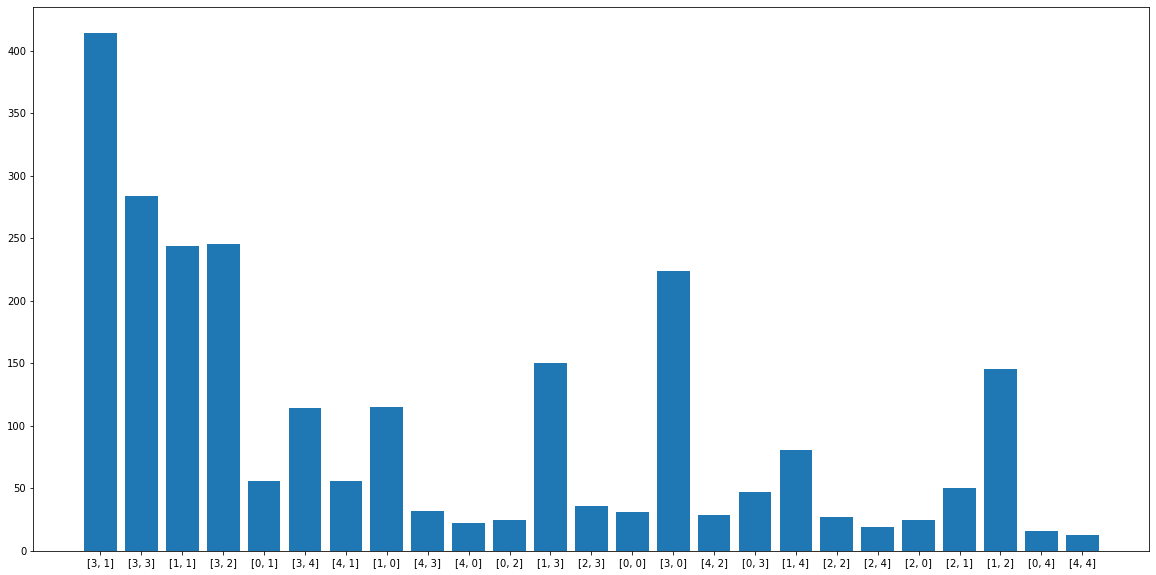

Processing Epoch 22
training start
Iteration 0, d real/fake loss 0.6611789464950562/0.7033600807189941 and g loss is 0.6855798959732056, NDiv loss 0.036237653344869614
Iteration 1, d real/fake loss 0.6610618829727173/0.702258825302124 and g loss is 0.6848554611206055, NDiv loss 0.03488554060459137
Iteration 2, d real/fake loss 0.6609441041946411/0.7004321217536926 and g loss is 0.680213451385498, NDiv loss 0.03714902698993683
Iteration 3, d real/fake loss 0.6608221530914307/0.7021234035491943 and g loss is 0.6856602430343628, NDiv loss 0.034430984407663345
Iteration 4, d real/fake loss 0.6606984734535217/0.701425313949585 and g loss is 0.6793974041938782, NDiv loss 0.03403755649924278


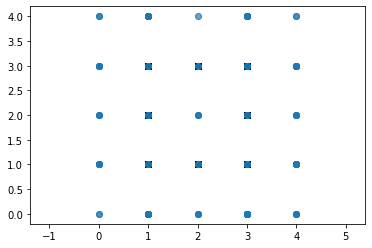

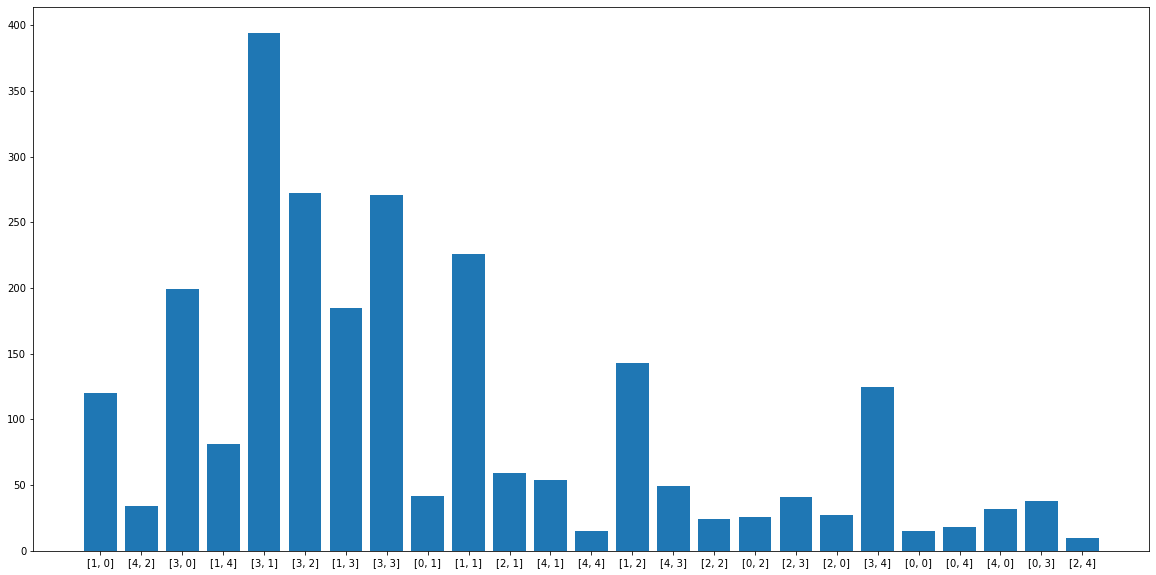

Processing Epoch 23
training start
Iteration 0, d real/fake loss 0.6640740633010864/0.7022542953491211 and g loss is 0.6839977502822876, NDiv loss 0.0362052246928215
Iteration 1, d real/fake loss 0.6638985872268677/0.7004512548446655 and g loss is 0.6890841722488403, NDiv loss 0.03578145429491997
Iteration 2, d real/fake loss 0.6637204885482788/0.7008174657821655 and g loss is 0.6837188005447388, NDiv loss 0.037568338215351105
Iteration 3, d real/fake loss 0.6635459661483765/0.7035877704620361 and g loss is 0.6874041557312012, NDiv loss 0.03627934679389
Iteration 4, d real/fake loss 0.66337651014328/0.7045840620994568 and g loss is 0.6853744983673096, NDiv loss 0.03669719770550728


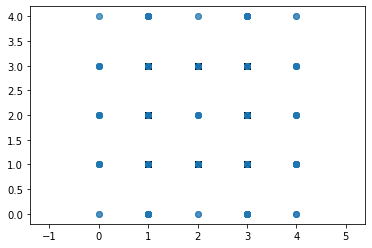

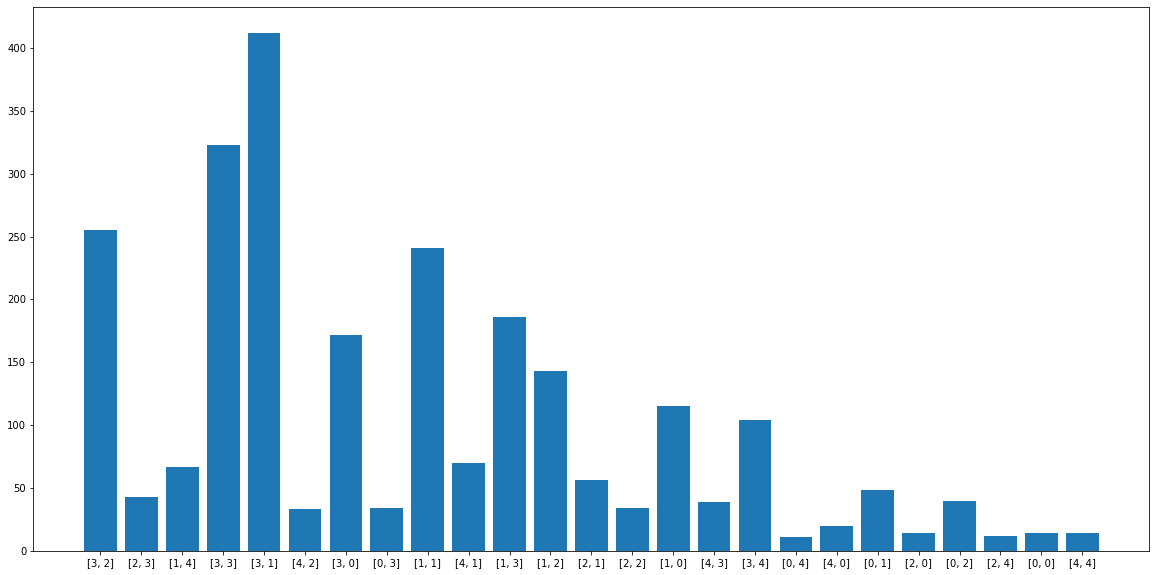

Processing Epoch 24
training start
Iteration 0, d real/fake loss 0.6557601094245911/0.704045295715332 and g loss is 0.6846061944961548, NDiv loss 0.03608926385641098
Iteration 1, d real/fake loss 0.6556419730186462/0.7013005614280701 and g loss is 0.6858879327774048, NDiv loss 0.035049233585596085
Iteration 2, d real/fake loss 0.6555278897285461/0.6993685960769653 and g loss is 0.6837476491928101, NDiv loss 0.03741928189992905
Iteration 3, d real/fake loss 0.6554111242294312/0.702264130115509 and g loss is 0.6823244094848633, NDiv loss 0.035258956253528595
Iteration 4, d real/fake loss 0.6553001403808594/0.7042434215545654 and g loss is 0.6833746433258057, NDiv loss 0.03499237075448036


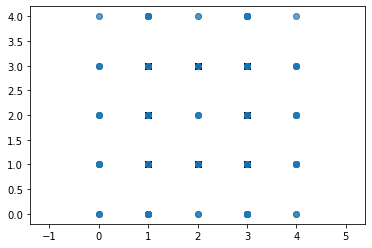

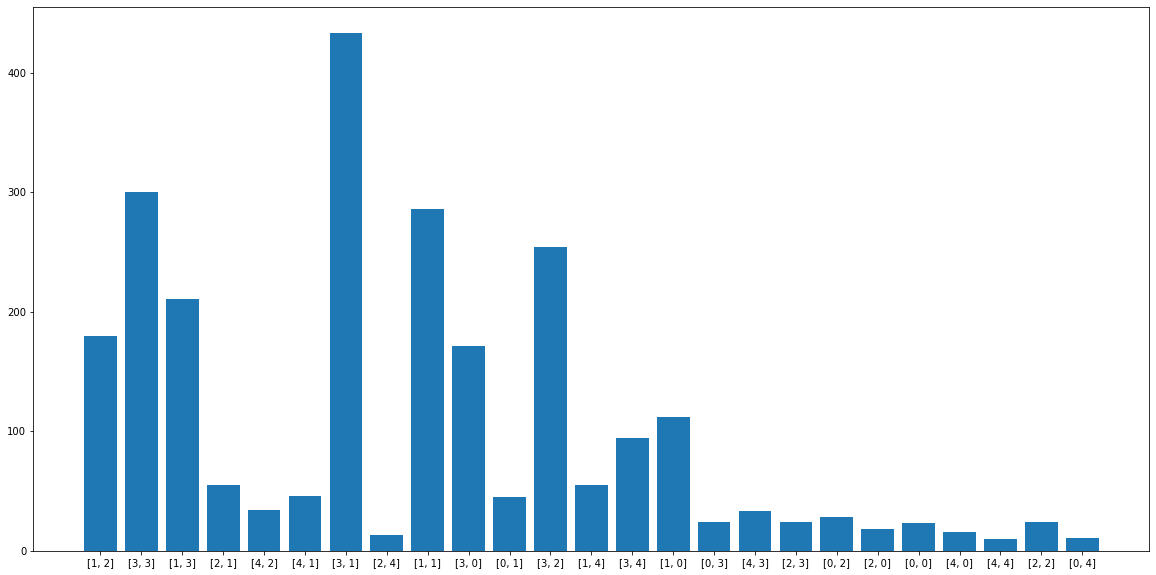

Processing Epoch 25
training start
Iteration 0, d real/fake loss 0.6602926254272461/0.7016792297363281 and g loss is 0.6815462112426758, NDiv loss 0.03698672726750374
Iteration 1, d real/fake loss 0.6602243185043335/0.7052443027496338 and g loss is 0.685576319694519, NDiv loss 0.03980720415711403
Iteration 2, d real/fake loss 0.660149872303009/0.7020266056060791 and g loss is 0.6828773021697998, NDiv loss 0.0380680188536644
Iteration 3, d real/fake loss 0.6600691080093384/0.7067283987998962 and g loss is 0.6853386759757996, NDiv loss 0.034190017729997635
Iteration 4, d real/fake loss 0.6599843502044678/0.7048026323318481 and g loss is 0.6862516403198242, NDiv loss 0.034496206790208817


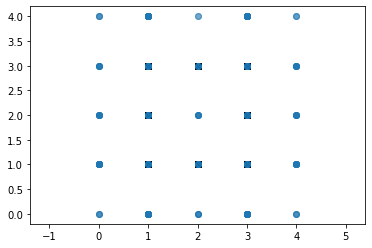

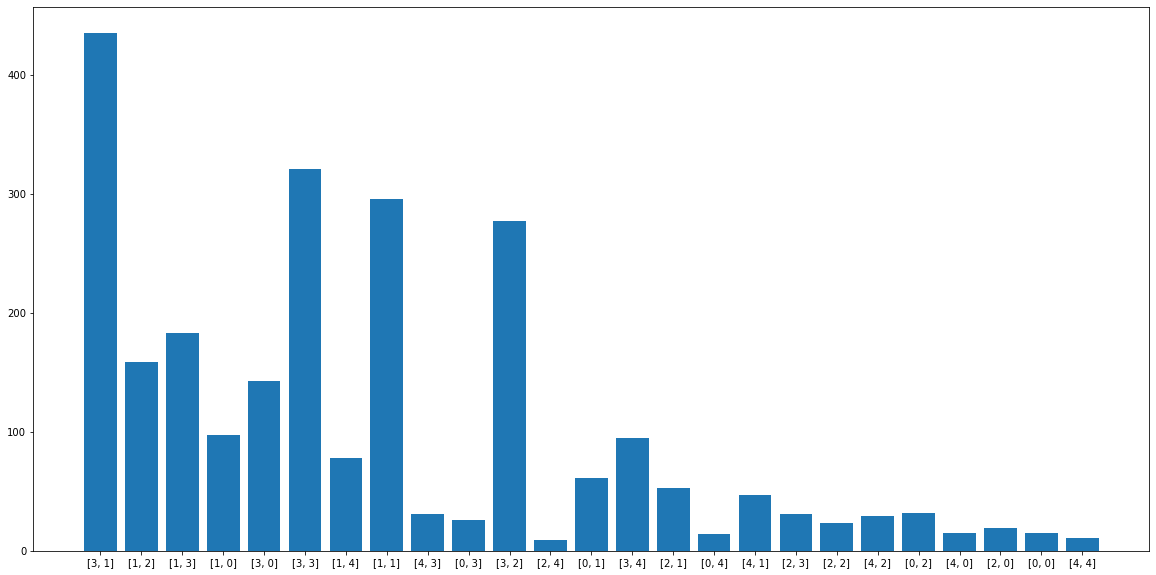

Processing Epoch 26
training start
Iteration 0, d real/fake loss 0.6559463739395142/0.7004851698875427 and g loss is 0.6819100379943848, NDiv loss 0.03464188426733017
Iteration 1, d real/fake loss 0.6558750867843628/0.70334792137146 and g loss is 0.686952531337738, NDiv loss 0.03686272352933884
Iteration 2, d real/fake loss 0.6557999849319458/0.7011061906814575 and g loss is 0.6897770166397095, NDiv loss 0.03375624492764473
Iteration 3, d real/fake loss 0.6557169556617737/0.7026053667068481 and g loss is 0.6868625283241272, NDiv loss 0.03771232068538666
Iteration 4, d real/fake loss 0.6556289792060852/0.6996027231216431 and g loss is 0.6844879984855652, NDiv loss 0.03741084784269333


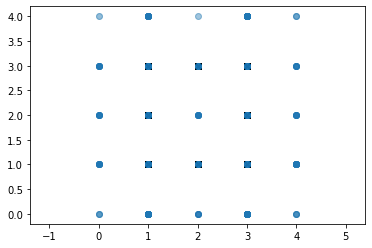

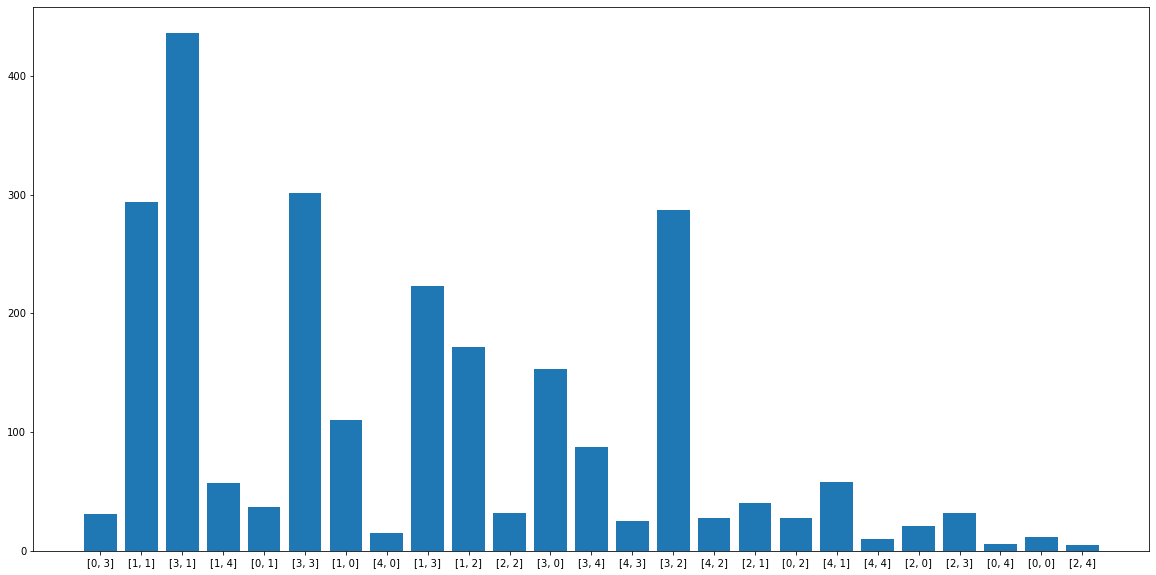

Processing Epoch 27
training start
Iteration 0, d real/fake loss 0.6608378291130066/0.7034305334091187 and g loss is 0.6842994689941406, NDiv loss 0.03754369542002678
Iteration 1, d real/fake loss 0.6607212424278259/0.7043343186378479 and g loss is 0.6824172735214233, NDiv loss 0.04204880818724632
Iteration 2, d real/fake loss 0.6606030464172363/0.7055104970932007 and g loss is 0.6813950538635254, NDiv loss 0.03738092631101608
Iteration 3, d real/fake loss 0.6604847311973572/0.7021884322166443 and g loss is 0.68949294090271, NDiv loss 0.03586596995592117
Iteration 4, d real/fake loss 0.6603626012802124/0.7060614228248596 and g loss is 0.6869643330574036, NDiv loss 0.03806851804256439


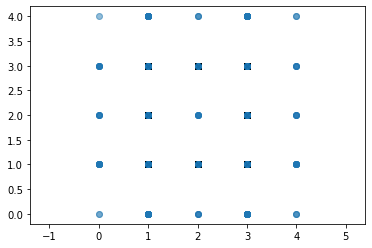

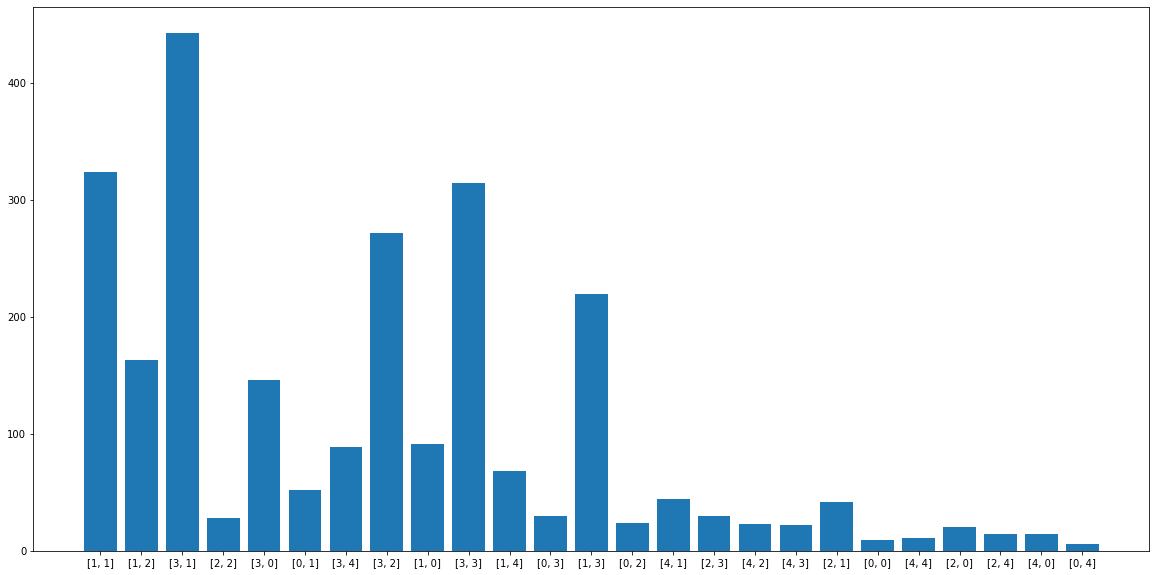

Processing Epoch 28
training start
Iteration 0, d real/fake loss 0.6606148481369019/0.6995366215705872 and g loss is 0.6835603713989258, NDiv loss 0.03604384884238243
Iteration 1, d real/fake loss 0.6604874134063721/0.6992464065551758 and g loss is 0.6807175874710083, NDiv loss 0.039257727563381195
Iteration 2, d real/fake loss 0.6603506803512573/0.7038620710372925 and g loss is 0.684069037437439, NDiv loss 0.037100061774253845
Iteration 3, d real/fake loss 0.6602169275283813/0.7048748731613159 and g loss is 0.6850508451461792, NDiv loss 0.036391522735357285
Iteration 4, d real/fake loss 0.6600838899612427/0.7088947296142578 and g loss is 0.6865686774253845, NDiv loss 0.037526942789554596


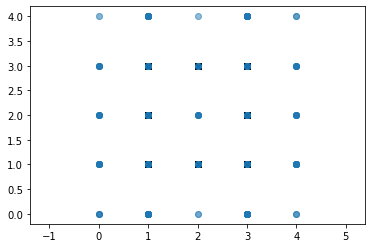

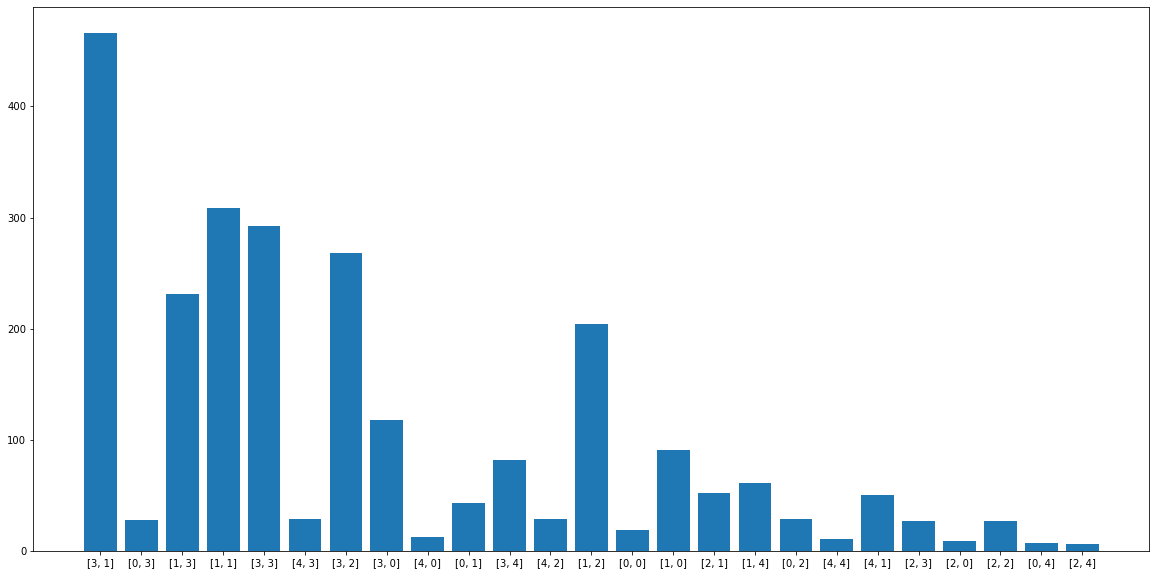

Processing Epoch 29
training start
Iteration 0, d real/fake loss 0.6556442379951477/0.7043166756629944 and g loss is 0.6869279146194458, NDiv loss 0.03855641558766365
Iteration 1, d real/fake loss 0.6555377840995789/0.7007334232330322 and g loss is 0.6874146461486816, NDiv loss 0.03893083706498146
Iteration 2, d real/fake loss 0.6554189324378967/0.6960609555244446 and g loss is 0.677715539932251, NDiv loss 0.03876383602619171
Iteration 3, d real/fake loss 0.6552897691726685/0.7018327116966248 and g loss is 0.6878171563148499, NDiv loss 0.0356152318418026
Iteration 4, d real/fake loss 0.655157744884491/0.700451672077179 and g loss is 0.6827905178070068, NDiv loss 0.03600506857037544


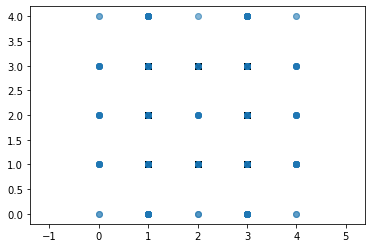

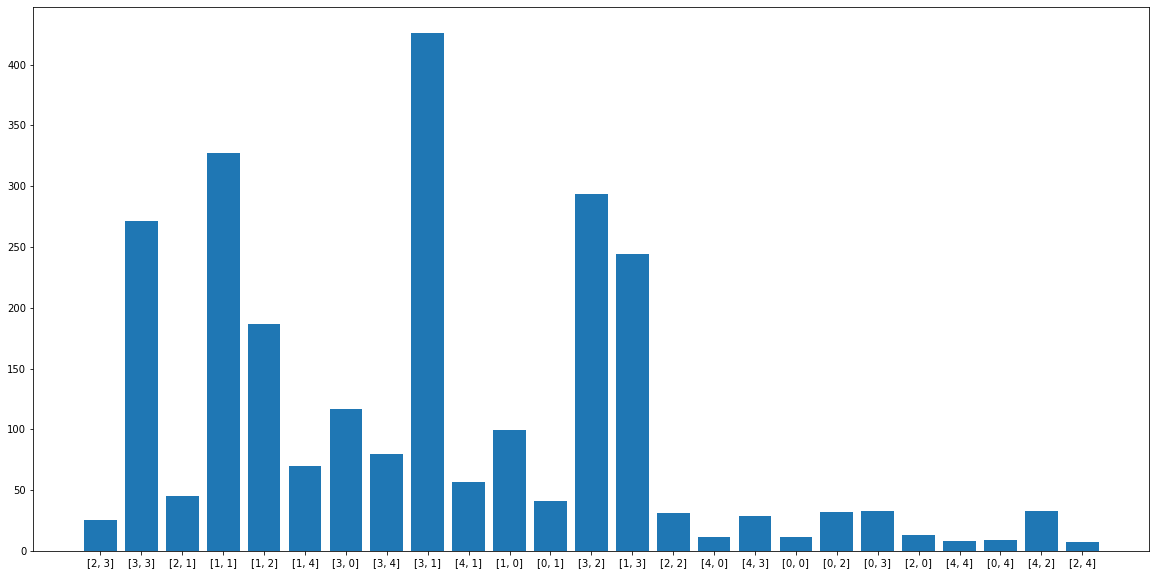

Processing Epoch 30
training start
Iteration 0, d real/fake loss 0.6613006591796875/0.7068697214126587 and g loss is 0.6870919466018677, NDiv loss 0.0387025848031044
Iteration 1, d real/fake loss 0.6611286401748657/0.699404239654541 and g loss is 0.6793807744979858, NDiv loss 0.038259610533714294
Iteration 2, d real/fake loss 0.6609560251235962/0.705557644367218 and g loss is 0.6836326718330383, NDiv loss 0.03852299600839615
Iteration 3, d real/fake loss 0.6607887744903564/0.7050442695617676 and g loss is 0.6786462664604187, NDiv loss 0.03985416516661644
Iteration 4, d real/fake loss 0.6606253385543823/0.7075198888778687 and g loss is 0.682974100112915, NDiv loss 0.040509264916181564


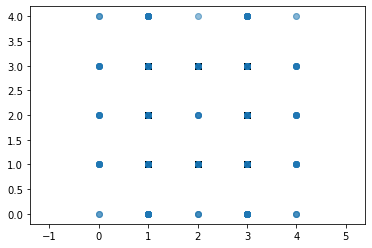

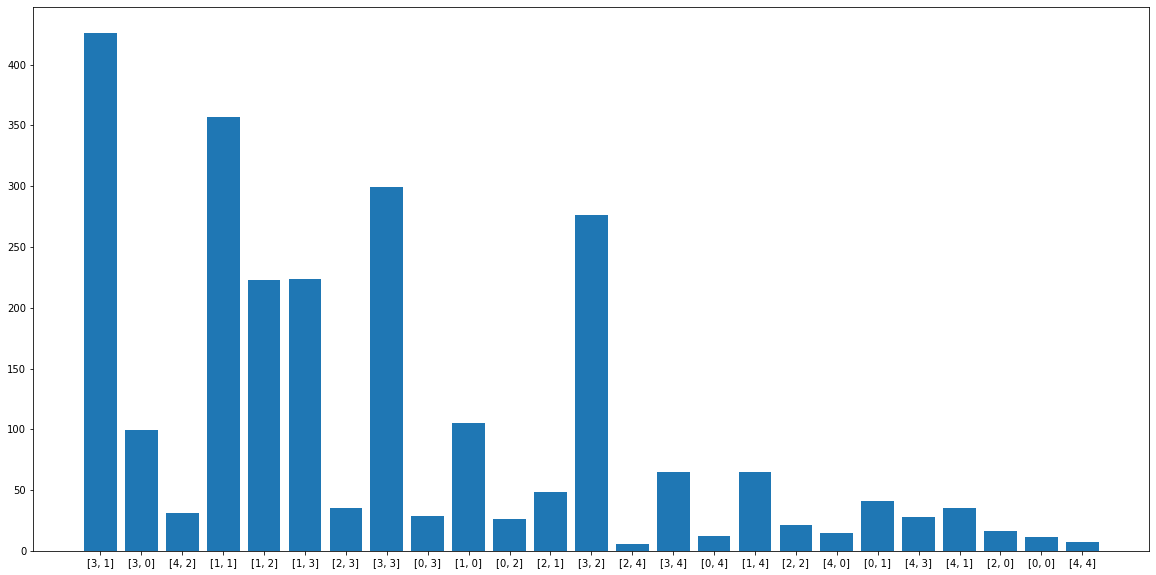

Processing Epoch 31
training start
Iteration 0, d real/fake loss 0.6600703001022339/0.7033074498176575 and g loss is 0.684973955154419, NDiv loss 0.0414276123046875
Iteration 1, d real/fake loss 0.6599569320678711/0.7051103115081787 and g loss is 0.6844288110733032, NDiv loss 0.03841371089220047
Iteration 2, d real/fake loss 0.6598351001739502/0.7011032104492188 and g loss is 0.6797849535942078, NDiv loss 0.03864877298474312
Iteration 3, d real/fake loss 0.6597039103507996/0.7019113302230835 and g loss is 0.6839033365249634, NDiv loss 0.03836526721715927
Iteration 4, d real/fake loss 0.6595660448074341/0.7074438333511353 and g loss is 0.6820792555809021, NDiv loss 0.03809147700667381


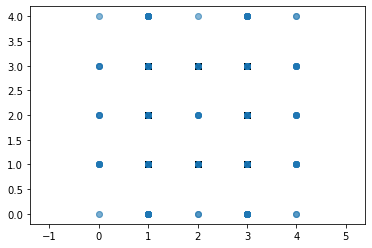

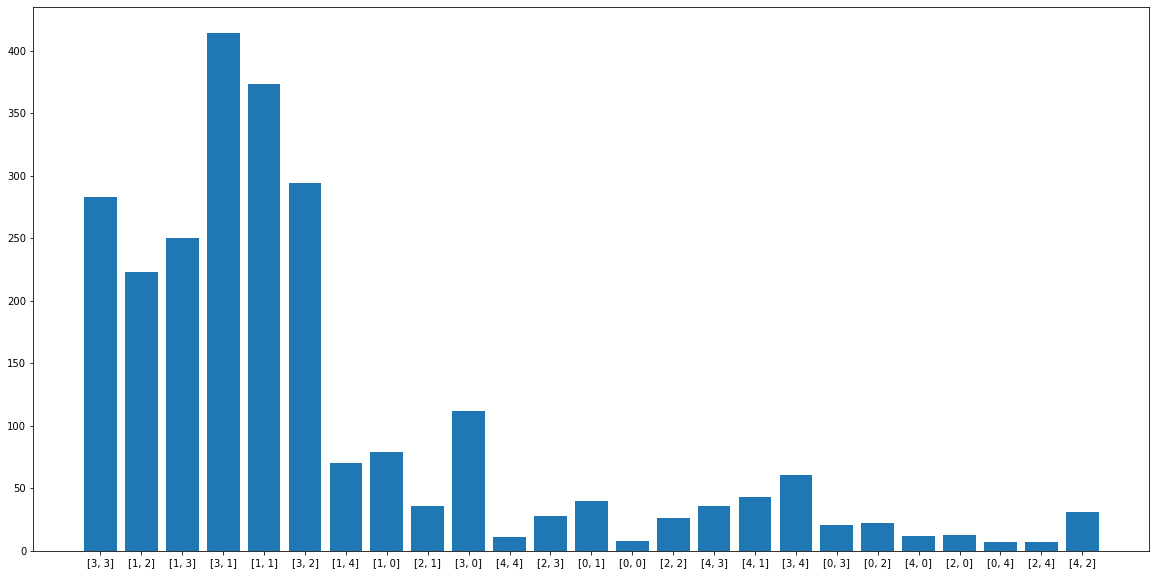

Processing Epoch 32
training start
Iteration 0, d real/fake loss 0.6561419367790222/0.7049656510353088 and g loss is 0.6813439726829529, NDiv loss 0.03969060257077217
Iteration 1, d real/fake loss 0.6560423970222473/0.7070177793502808 and g loss is 0.6814069747924805, NDiv loss 0.03895833343267441
Iteration 2, d real/fake loss 0.65594482421875/0.7058510780334473 and g loss is 0.6875304579734802, NDiv loss 0.042130306363105774
Iteration 3, d real/fake loss 0.6558533906936646/0.6985034942626953 and g loss is 0.6873716115951538, NDiv loss 0.04077408090233803
Iteration 4, d real/fake loss 0.6557564735412598/0.7031795382499695 and g loss is 0.6831440925598145, NDiv loss 0.040104568004608154


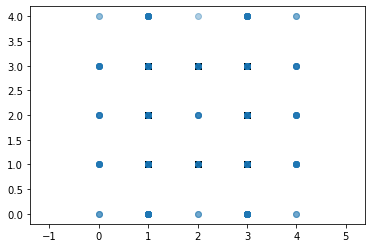

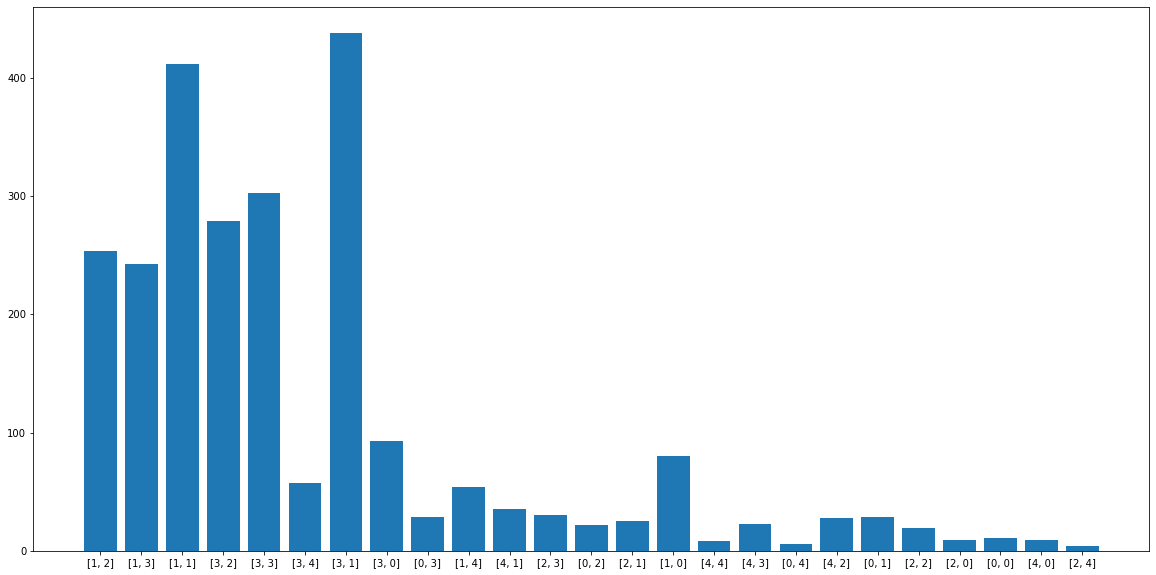

Processing Epoch 33
training start
Iteration 0, d real/fake loss 0.648208498954773/0.7008442282676697 and g loss is 0.688481330871582, NDiv loss 0.03819757327437401
Iteration 1, d real/fake loss 0.6481593251228333/0.7040300369262695 and g loss is 0.6841656565666199, NDiv loss 0.04389030858874321
Iteration 2, d real/fake loss 0.6481137275695801/0.7014850974082947 and g loss is 0.686820387840271, NDiv loss 0.038651950657367706
Iteration 3, d real/fake loss 0.6480652689933777/0.7051888704299927 and g loss is 0.685360312461853, NDiv loss 0.04322812706232071
Iteration 4, d real/fake loss 0.6480214595794678/0.7015341520309448 and g loss is 0.6815870404243469, NDiv loss 0.04048612341284752


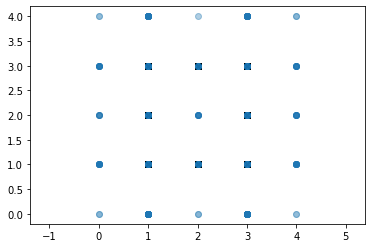

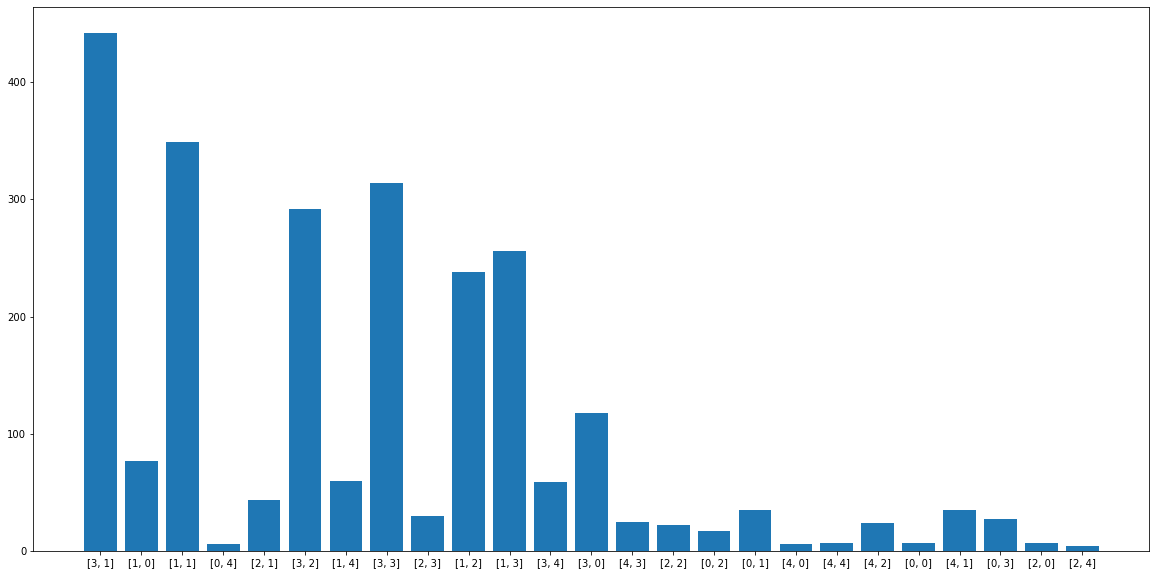

Processing Epoch 34
training start
Iteration 0, d real/fake loss 0.6522715091705322/0.7004927396774292 and g loss is 0.679574728012085, NDiv loss 0.03868241235613823
Iteration 1, d real/fake loss 0.6521840691566467/0.7045783400535583 and g loss is 0.6811813712120056, NDiv loss 0.037622395902872086
Iteration 2, d real/fake loss 0.6521018743515015/0.7049131393432617 and g loss is 0.6866171360015869, NDiv loss 0.040373511612415314
Iteration 3, d real/fake loss 0.6520270109176636/0.6990687251091003 and g loss is 0.6860876679420471, NDiv loss 0.03975191339850426
Iteration 4, d real/fake loss 0.6519486904144287/0.7018197774887085 and g loss is 0.681326150894165, NDiv loss 0.039911456406116486


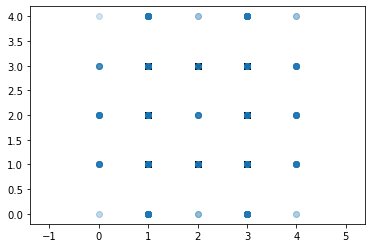

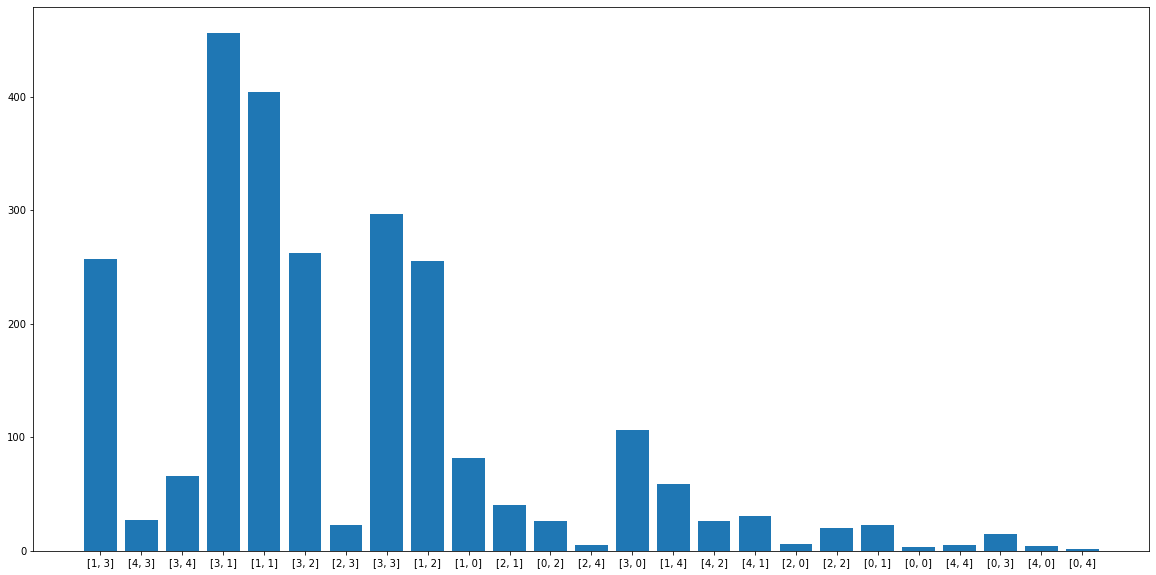

Processing Epoch 35
training start
Iteration 0, d real/fake loss 0.6540243625640869/0.7002171874046326 and g loss is 0.6847399473190308, NDiv loss 0.03868134692311287
Iteration 1, d real/fake loss 0.6539802551269531/0.7040208578109741 and g loss is 0.6836698055267334, NDiv loss 0.04098554328083992
Iteration 2, d real/fake loss 0.6539312601089478/0.7034059166908264 and g loss is 0.6836163997650146, NDiv loss 0.03956877440214157
Iteration 3, d real/fake loss 0.6538779735565186/0.7049592733383179 and g loss is 0.6872604489326477, NDiv loss 0.04311370104551315
Iteration 4, d real/fake loss 0.6538302898406982/0.7022421956062317 and g loss is 0.6838034391403198, NDiv loss 0.039827167987823486


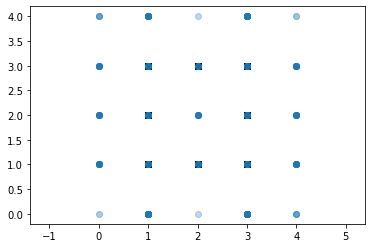

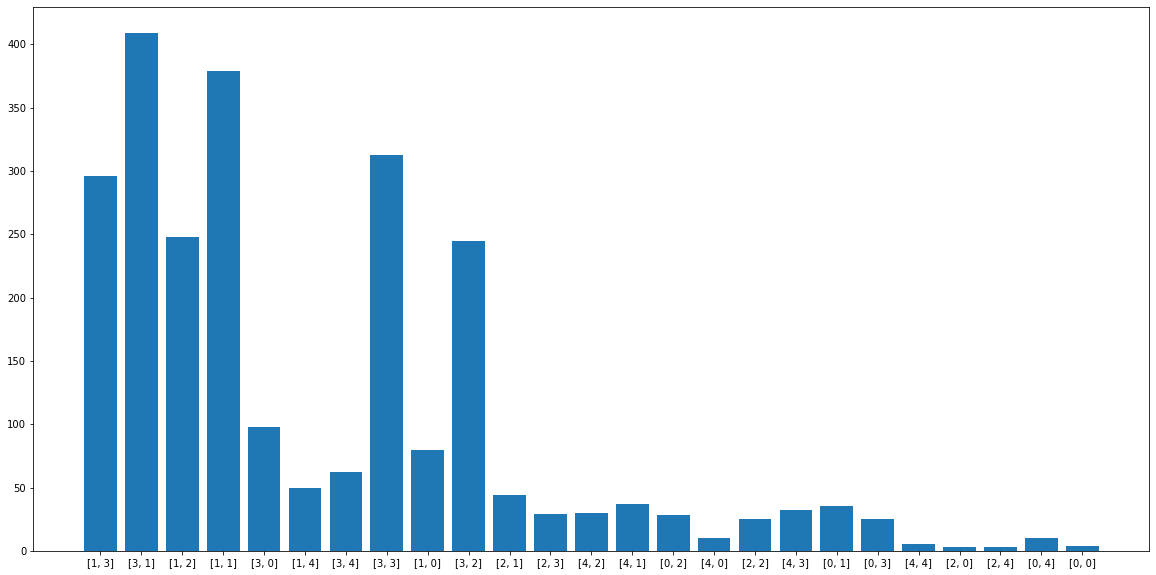

Processing Epoch 36
training start
Iteration 0, d real/fake loss 0.661426305770874/0.7006644010543823 and g loss is 0.6908966898918152, NDiv loss 0.043140120804309845
Iteration 1, d real/fake loss 0.6613085269927979/0.6992861032485962 and g loss is 0.6848716139793396, NDiv loss 0.042112741619348526
Iteration 2, d real/fake loss 0.6611754298210144/0.7047683596611023 and g loss is 0.6856669783592224, NDiv loss 0.040406033396720886
Iteration 3, d real/fake loss 0.6610384583473206/0.7031031847000122 and g loss is 0.6865272521972656, NDiv loss 0.04035421460866928
Iteration 4, d real/fake loss 0.6608949899673462/0.7000831961631775 and g loss is 0.6857582330703735, NDiv loss 0.03916488587856293


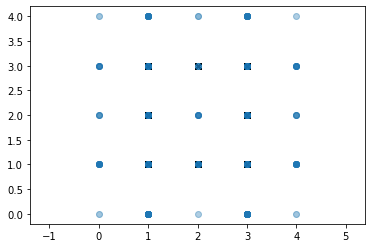

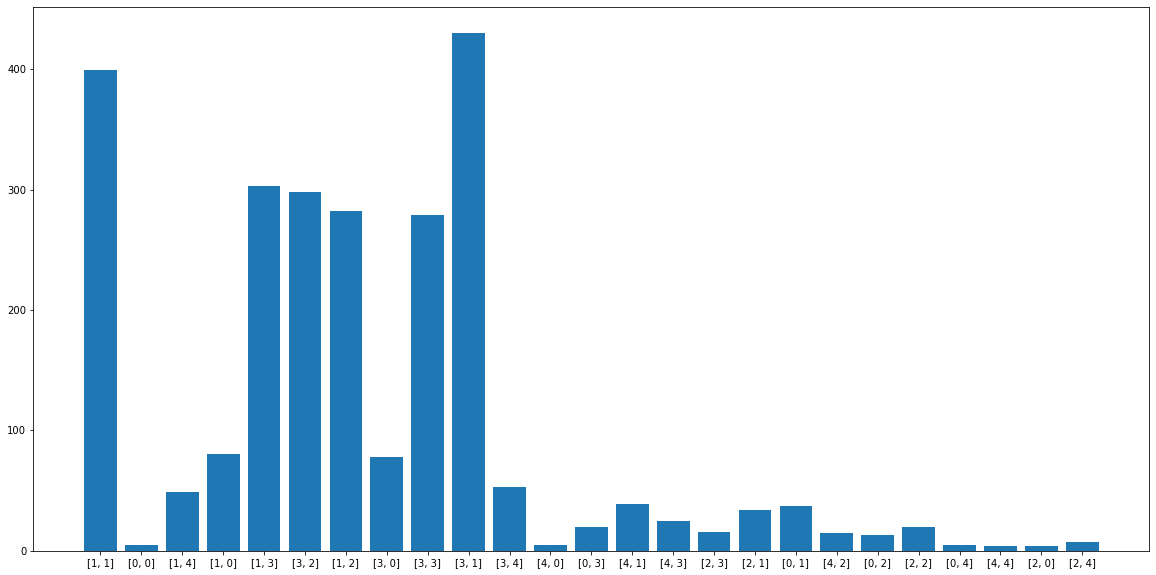

Processing Epoch 37
training start
Iteration 0, d real/fake loss 0.6552067399024963/0.7027854919433594 and g loss is 0.690451979637146, NDiv loss 0.03886983543634415
Iteration 1, d real/fake loss 0.6550992131233215/0.7025752663612366 and g loss is 0.6845344305038452, NDiv loss 0.040279075503349304
Iteration 2, d real/fake loss 0.6549888253211975/0.6989323496818542 and g loss is 0.6831614971160889, NDiv loss 0.040266137570142746
Iteration 3, d real/fake loss 0.654869556427002/0.7020387053489685 and g loss is 0.6851827502250671, NDiv loss 0.04058877378702164
Iteration 4, d real/fake loss 0.654749870300293/0.6975418329238892 and g loss is 0.6866528987884521, NDiv loss 0.043329738080501556


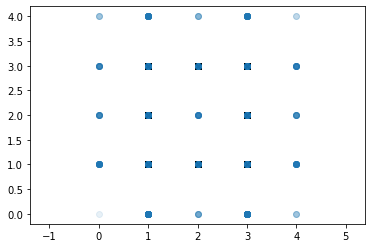

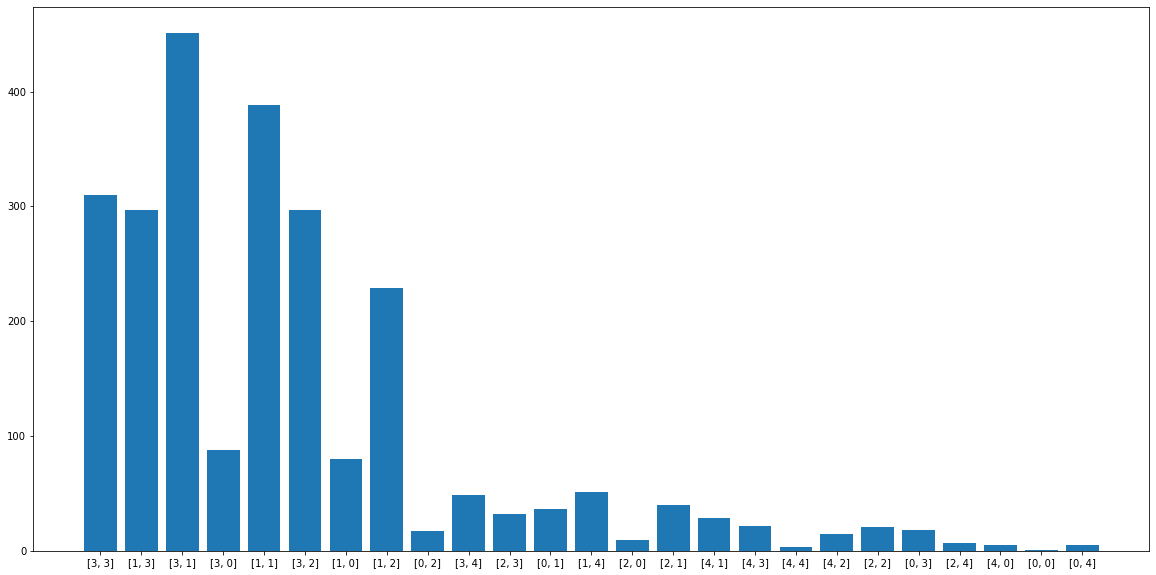

Processing Epoch 38
training start
Iteration 0, d real/fake loss 0.6552178859710693/0.7011520862579346 and g loss is 0.6871357560157776, NDiv loss 0.043705787509679794
Iteration 1, d real/fake loss 0.6551045775413513/0.6993137001991272 and g loss is 0.6816181540489197, NDiv loss 0.04060440510511398
Iteration 2, d real/fake loss 0.6549916863441467/0.7019413709640503 and g loss is 0.6853111982345581, NDiv loss 0.042472198605537415
Iteration 3, d real/fake loss 0.6548865437507629/0.7017458081245422 and g loss is 0.688840389251709, NDiv loss 0.0408349372446537
Iteration 4, d real/fake loss 0.6547865867614746/0.7008959054946899 and g loss is 0.6876528263092041, NDiv loss 0.03901900351047516


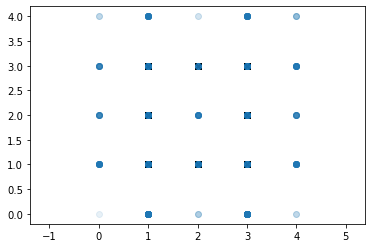

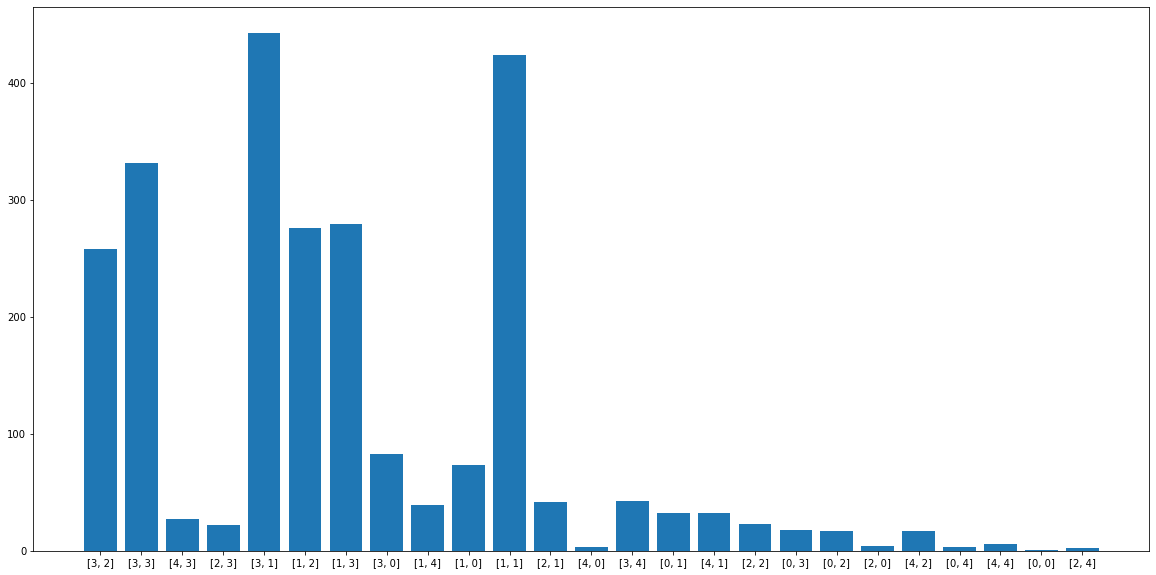

Processing Epoch 39
training start
Iteration 0, d real/fake loss 0.6511073708534241/0.6998528242111206 and g loss is 0.6908026933670044, NDiv loss 0.04316907376050949
Iteration 1, d real/fake loss 0.6510521769523621/0.7038519382476807 and g loss is 0.6840319633483887, NDiv loss 0.042744483798742294
Iteration 2, d real/fake loss 0.651004433631897/0.6991546154022217 and g loss is 0.6880064010620117, NDiv loss 0.04161636158823967
Iteration 3, d real/fake loss 0.6509521007537842/0.6982917785644531 and g loss is 0.6843444108963013, NDiv loss 0.03982601687312126
Iteration 4, d real/fake loss 0.6508989334106445/0.7035316228866577 and g loss is 0.689965009689331, NDiv loss 0.041122060269117355


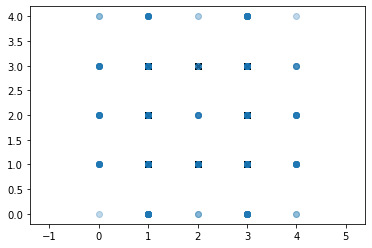

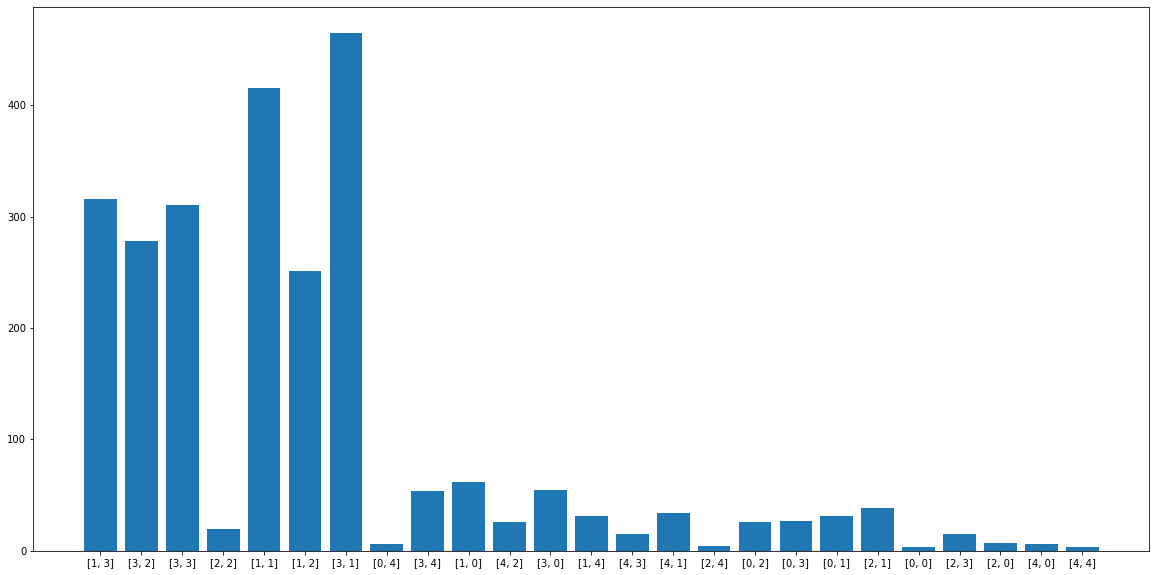

Processing Epoch 40
training start
Iteration 0, d real/fake loss 0.6495090126991272/0.6983765959739685 and g loss is 0.6861249208450317, NDiv loss 0.04396616294980049
Iteration 1, d real/fake loss 0.6494912505149841/0.6992610096931458 and g loss is 0.6854685544967651, NDiv loss 0.0439729169011116
Iteration 2, d real/fake loss 0.6494703888893127/0.6982259750366211 and g loss is 0.6835941076278687, NDiv loss 0.043497223407030106
Iteration 3, d real/fake loss 0.6494495272636414/0.699981689453125 and g loss is 0.6908780336380005, NDiv loss 0.03980020433664322
Iteration 4, d real/fake loss 0.6494278311729431/0.697751522064209 and g loss is 0.6876661777496338, NDiv loss 0.03678565472364426


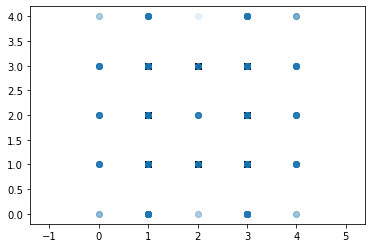

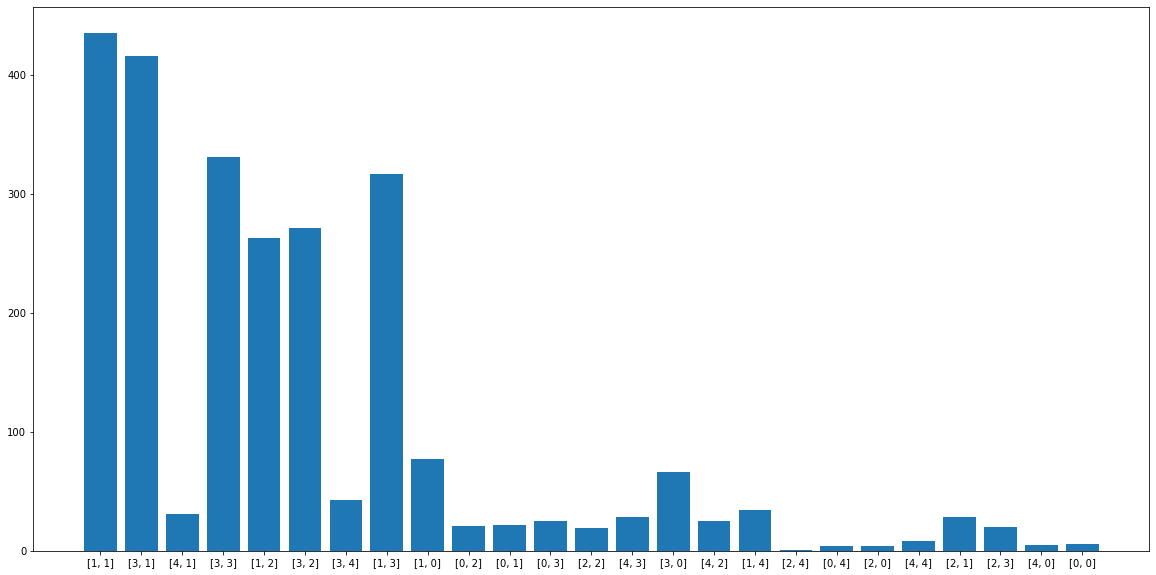

Processing Epoch 41
training start
Iteration 0, d real/fake loss 0.6512714624404907/0.6953930854797363 and g loss is 0.6902313232421875, NDiv loss 0.04048096761107445
Iteration 1, d real/fake loss 0.6512192487716675/0.7027367353439331 and g loss is 0.6881932616233826, NDiv loss 0.04398640990257263
Iteration 2, d real/fake loss 0.651162326335907/0.7003592848777771 and g loss is 0.6887940168380737, NDiv loss 0.041073355823755264
Iteration 3, d real/fake loss 0.6511008739471436/0.6941563487052917 and g loss is 0.6898281574249268, NDiv loss 0.03998913615942001
Iteration 4, d real/fake loss 0.651024580001831/0.6974588632583618 and g loss is 0.6926840543746948, NDiv loss 0.04240483418107033


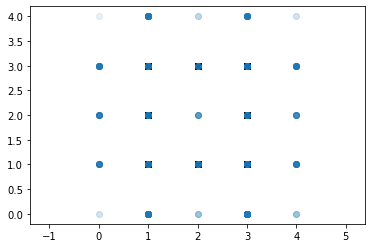

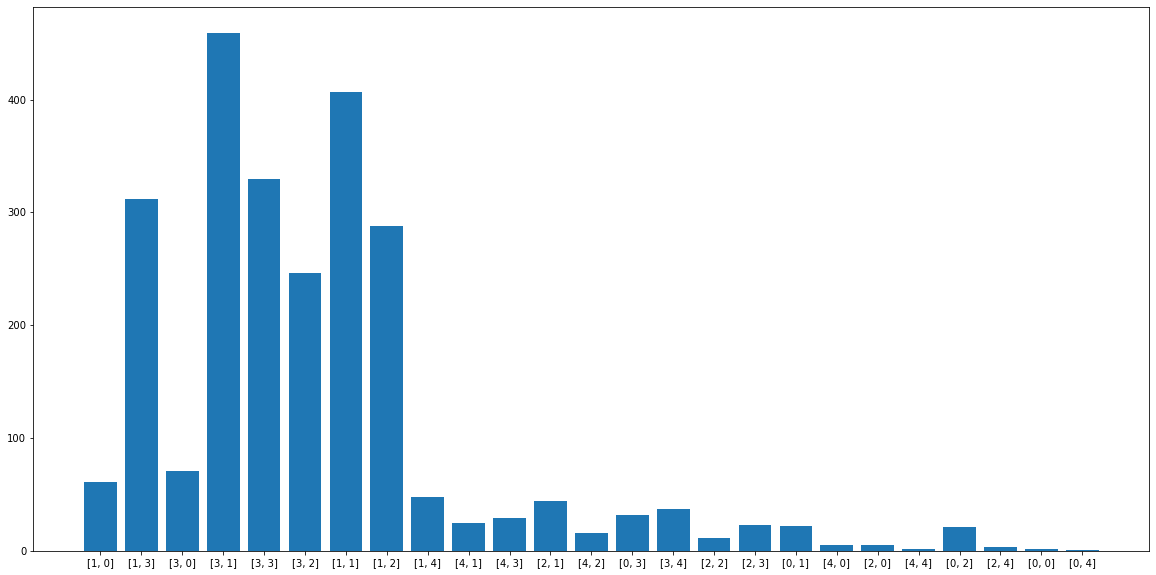

Processing Epoch 42
training start
Iteration 0, d real/fake loss 0.651299774646759/0.6983544826507568 and g loss is 0.6885446310043335, NDiv loss 0.04153229668736458
Iteration 1, d real/fake loss 0.6512618064880371/0.6978216767311096 and g loss is 0.68935626745224, NDiv loss 0.0396399162709713
Iteration 2, d real/fake loss 0.6512000560760498/0.6982097625732422 and g loss is 0.6886492967605591, NDiv loss 0.04345029965043068
Iteration 3, d real/fake loss 0.651119589805603/0.6970646381378174 and g loss is 0.6863986253738403, NDiv loss 0.046231459826231
Iteration 4, d real/fake loss 0.6510184407234192/0.6997671723365784 and g loss is 0.6907188892364502, NDiv loss 0.03942909091711044


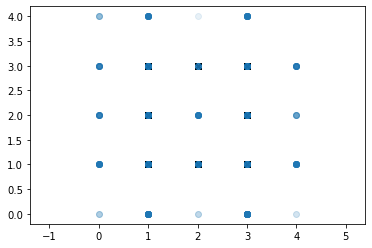

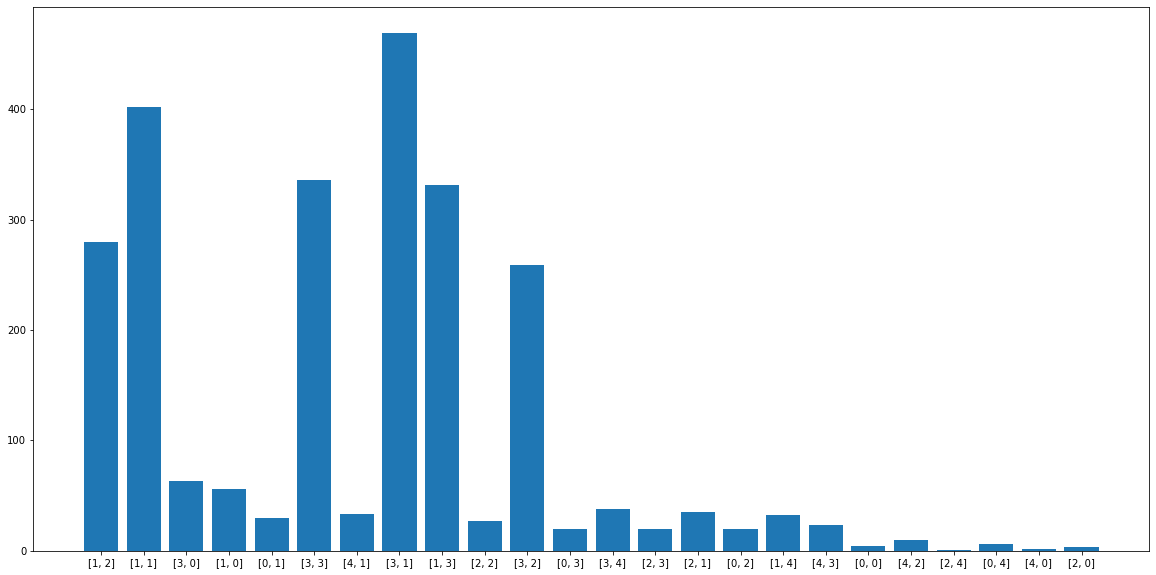

Processing Epoch 43
training start
Iteration 0, d real/fake loss 0.6520426273345947/0.6959569454193115 and g loss is 0.6884599328041077, NDiv loss 0.043906912207603455
Iteration 1, d real/fake loss 0.6518988013267517/0.694337010383606 and g loss is 0.6939829587936401, NDiv loss 0.043806042522192
Iteration 2, d real/fake loss 0.6517528295516968/0.7003803253173828 and g loss is 0.6879740953445435, NDiv loss 0.04506427049636841
Iteration 3, d real/fake loss 0.6516172289848328/0.6976708173751831 and g loss is 0.6899794936180115, NDiv loss 0.04641301929950714
Iteration 4, d real/fake loss 0.6514853239059448/0.6987608671188354 and g loss is 0.6901799440383911, NDiv loss 0.04029427468776703


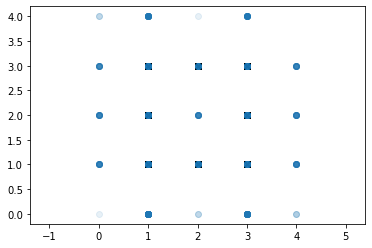

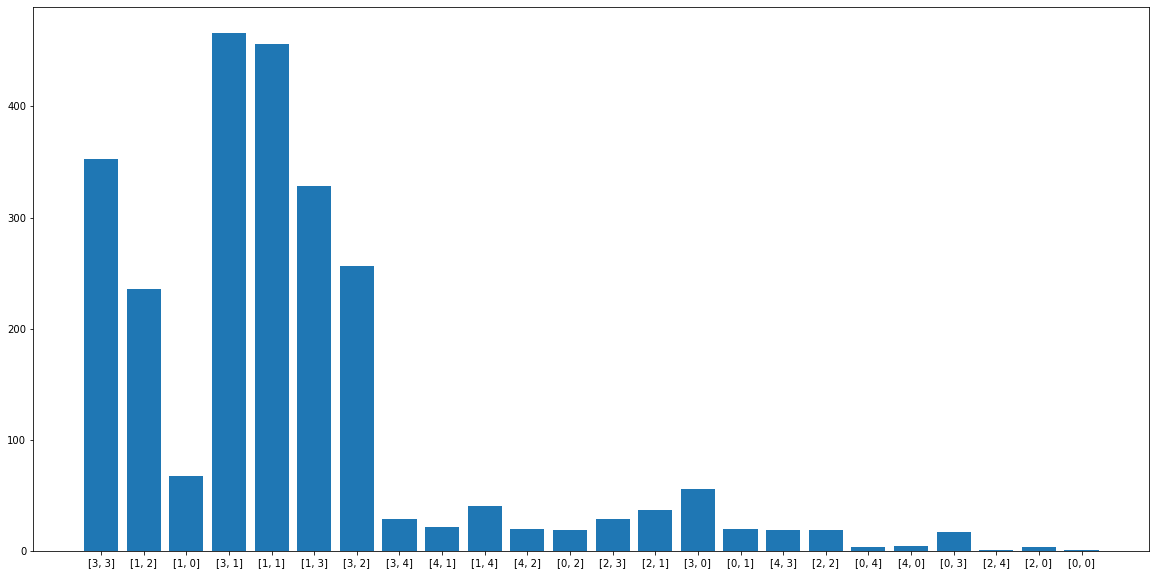

Processing Epoch 44
training start
Iteration 0, d real/fake loss 0.6519918441772461/0.6975222826004028 and g loss is 0.685218334197998, NDiv loss 0.043291762471199036
Iteration 1, d real/fake loss 0.6518787741661072/0.7007010579109192 and g loss is 0.688907265663147, NDiv loss 0.04460971802473068
Iteration 2, d real/fake loss 0.6517635583877563/0.7013912796974182 and g loss is 0.6895937323570251, NDiv loss 0.041053298860788345
Iteration 3, d real/fake loss 0.6516506671905518/0.6998465657234192 and g loss is 0.685204267501831, NDiv loss 0.040377866476774216
Iteration 4, d real/fake loss 0.6515400409698486/0.6928964853286743 and g loss is 0.6923732757568359, NDiv loss 0.043157465755939484


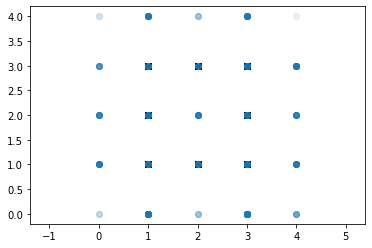

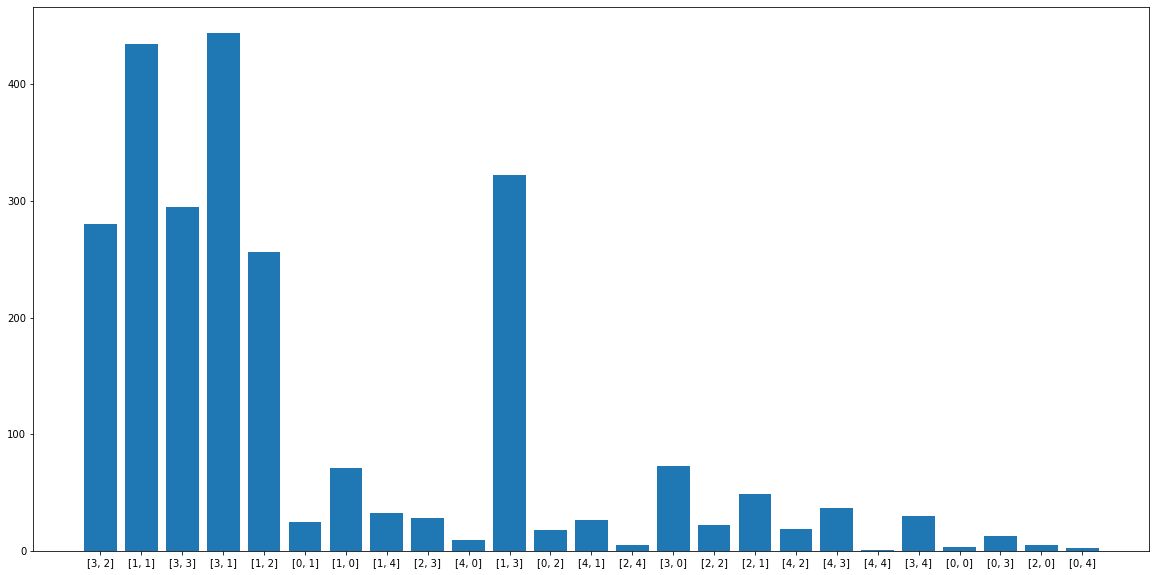

Processing Epoch 45
training start
Iteration 0, d real/fake loss 0.6514781713485718/0.6974266171455383 and g loss is 0.6877788305282593, NDiv loss 0.041045840829610825
Iteration 1, d real/fake loss 0.6513659954071045/0.696297824382782 and g loss is 0.6929806470870972, NDiv loss 0.043143272399902344
Iteration 2, d real/fake loss 0.6512494087219238/0.7013578414916992 and g loss is 0.6874436140060425, NDiv loss 0.0431244894862175
Iteration 3, d real/fake loss 0.6511374115943909/0.6966807842254639 and g loss is 0.6904059648513794, NDiv loss 0.04464530199766159
Iteration 4, d real/fake loss 0.651023268699646/0.7006700038909912 and g loss is 0.6927406191825867, NDiv loss 0.04385196417570114


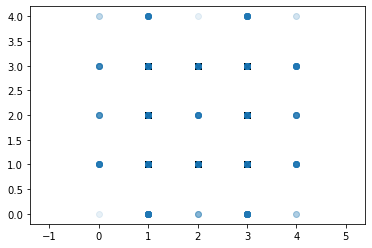

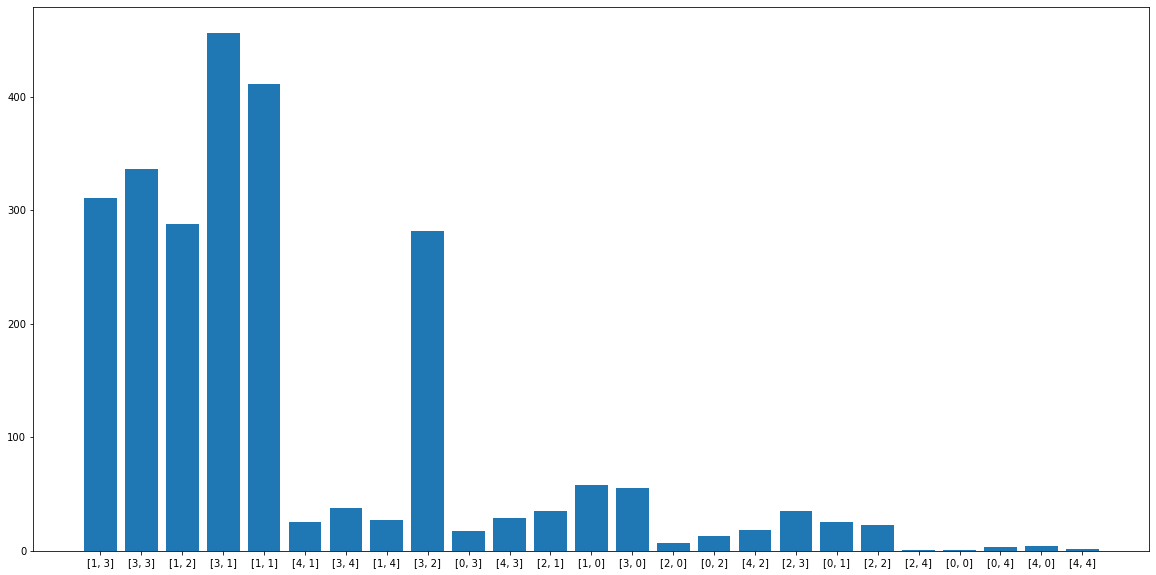

Processing Epoch 46
training start
Iteration 0, d real/fake loss 0.6512683033943176/0.6933268904685974 and g loss is 0.6919159889221191, NDiv loss 0.04677824676036835
Iteration 1, d real/fake loss 0.6511114835739136/0.6956007480621338 and g loss is 0.6899999976158142, NDiv loss 0.043892454355955124
Iteration 2, d real/fake loss 0.6509456038475037/0.6954964399337769 and g loss is 0.6889444589614868, NDiv loss 0.04133971035480499
Iteration 3, d real/fake loss 0.6507697105407715/0.6967453360557556 and g loss is 0.6879099011421204, NDiv loss 0.04175533354282379
Iteration 4, d real/fake loss 0.650582492351532/0.6951639652252197 and g loss is 0.6908019185066223, NDiv loss 0.04449126869440079


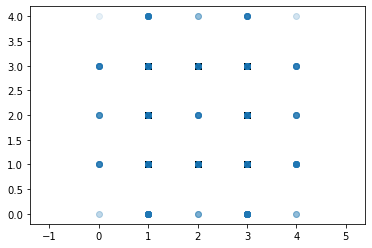

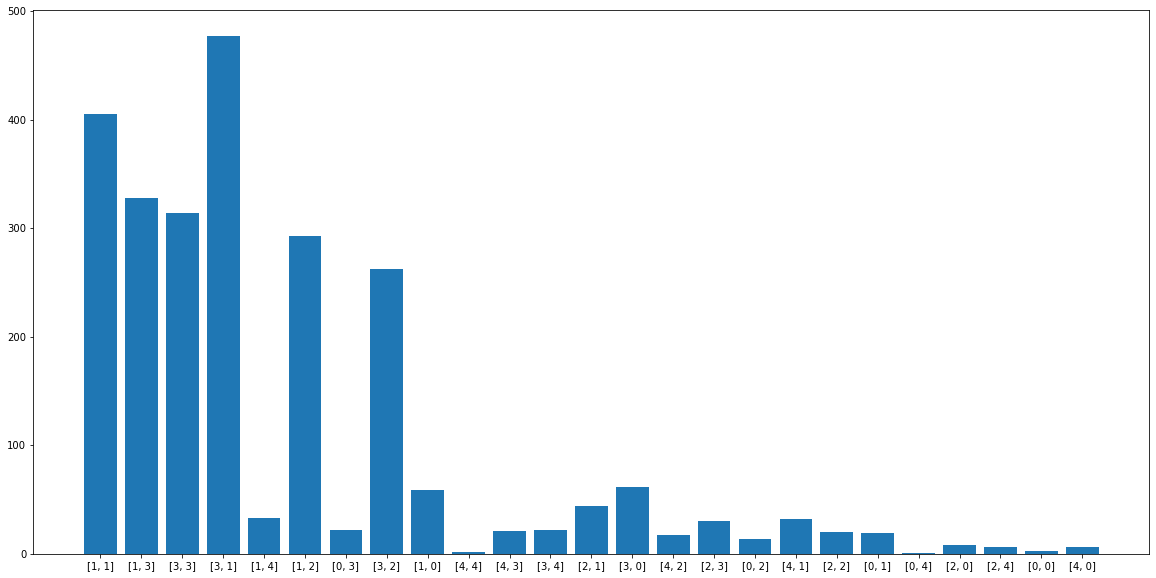

Processing Epoch 47
training start
Iteration 0, d real/fake loss 0.6485075950622559/0.697144627571106 and g loss is 0.6911677122116089, NDiv loss 0.0417865514755249
Iteration 1, d real/fake loss 0.6484028100967407/0.6982609033584595 and g loss is 0.6897463798522949, NDiv loss 0.04662296548485756
Iteration 2, d real/fake loss 0.648292064666748/0.6951589584350586 and g loss is 0.6896950602531433, NDiv loss 0.044363800436258316
Iteration 3, d real/fake loss 0.6481782793998718/0.6961885094642639 and g loss is 0.6850684285163879, NDiv loss 0.041247639805078506
Iteration 4, d real/fake loss 0.6480584144592285/0.6970005035400391 and g loss is 0.6923431754112244, NDiv loss 0.043879080563783646


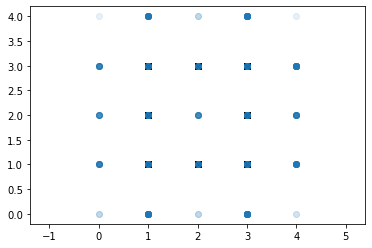

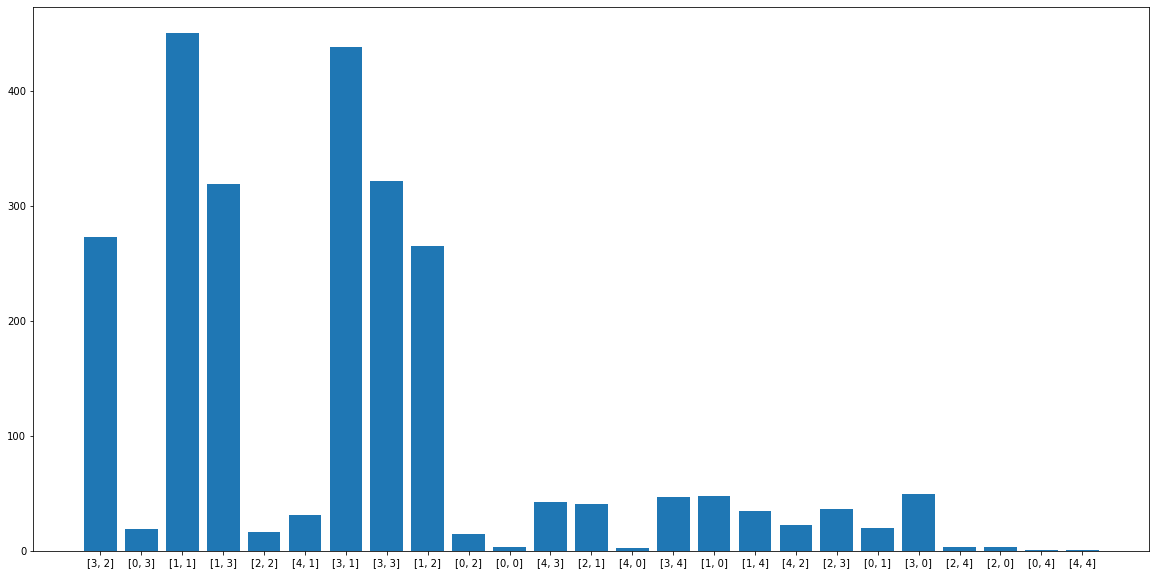

Processing Epoch 48
training start
Iteration 0, d real/fake loss 0.6484014391899109/0.6959275007247925 and g loss is 0.6917930245399475, NDiv loss 0.04156592860817909
Iteration 1, d real/fake loss 0.6483020186424255/0.6974900960922241 and g loss is 0.6931362748146057, NDiv loss 0.04178805649280548
Iteration 2, d real/fake loss 0.6482070684432983/0.6932473182678223 and g loss is 0.6931440830230713, NDiv loss 0.03986215963959694
Iteration 3, d real/fake loss 0.6481097936630249/0.6926019787788391 and g loss is 0.689643383026123, NDiv loss 0.043464235961437225
Iteration 4, d real/fake loss 0.6480059623718262/0.6956334710121155 and g loss is 0.6929805278778076, NDiv loss 0.04157036915421486


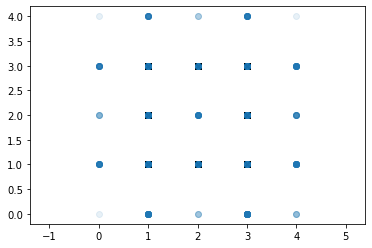

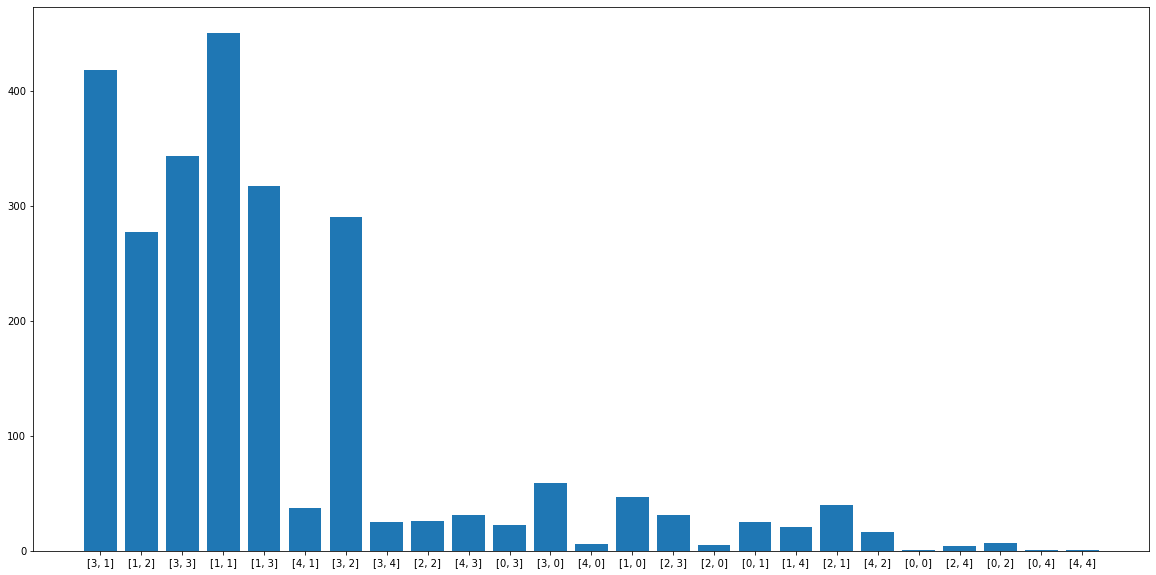

Processing Epoch 49
training start
Iteration 0, d real/fake loss 0.6478765606880188/0.6975752115249634 and g loss is 0.6908332109451294, NDiv loss 0.0435134582221508
Iteration 1, d real/fake loss 0.6478009223937988/0.6936442852020264 and g loss is 0.6915727853775024, NDiv loss 0.041596610099077225
Iteration 2, d real/fake loss 0.6477247476577759/0.7006999254226685 and g loss is 0.6936349868774414, NDiv loss 0.04433107003569603
Iteration 3, d real/fake loss 0.6476572751998901/0.6960732936859131 and g loss is 0.6895139217376709, NDiv loss 0.04378870129585266
Iteration 4, d real/fake loss 0.6475911736488342/0.6954437494277954 and g loss is 0.690418004989624, NDiv loss 0.04230323061347008


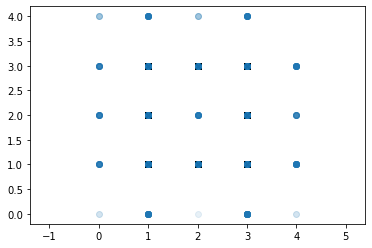

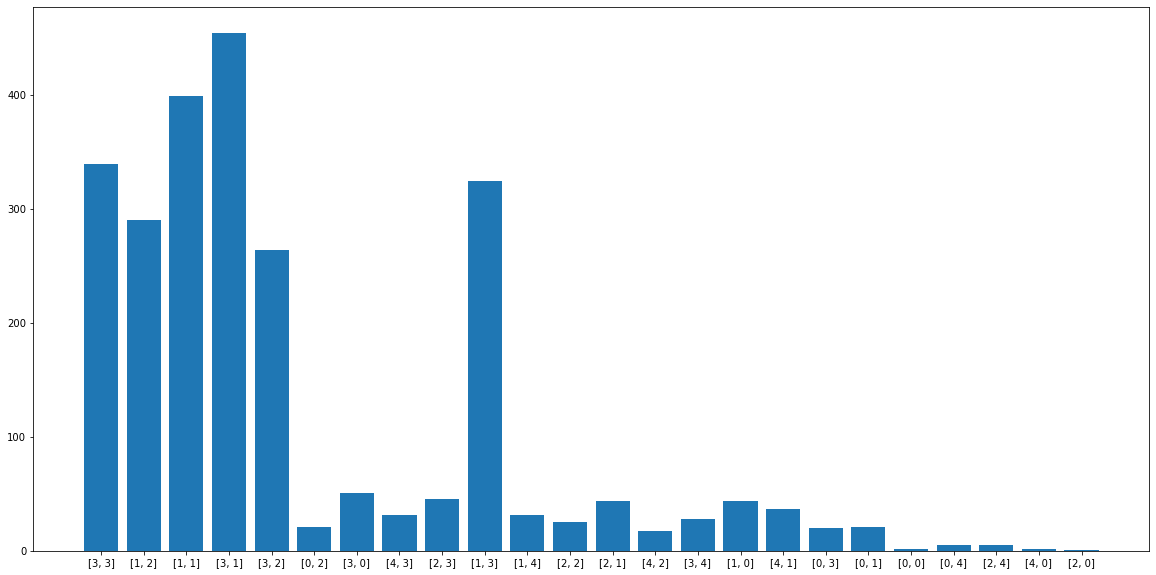

Processing Epoch 50
training start
Iteration 0, d real/fake loss 0.6504459381103516/0.6959519982337952 and g loss is 0.6947638392448425, NDiv loss 0.047685347497463226
Iteration 1, d real/fake loss 0.6503405570983887/0.6926239132881165 and g loss is 0.6939611434936523, NDiv loss 0.04571196064352989
Iteration 2, d real/fake loss 0.6502230167388916/0.6986135244369507 and g loss is 0.691376268863678, NDiv loss 0.039917025715112686
Iteration 3, d real/fake loss 0.6500997543334961/0.6917988657951355 and g loss is 0.6901246905326843, NDiv loss 0.04453234001994133
Iteration 4, d real/fake loss 0.6499620079994202/0.6935678124427795 and g loss is 0.6917222738265991, NDiv loss 0.044102203100919724


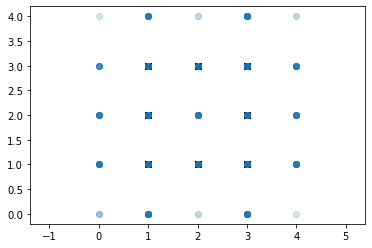

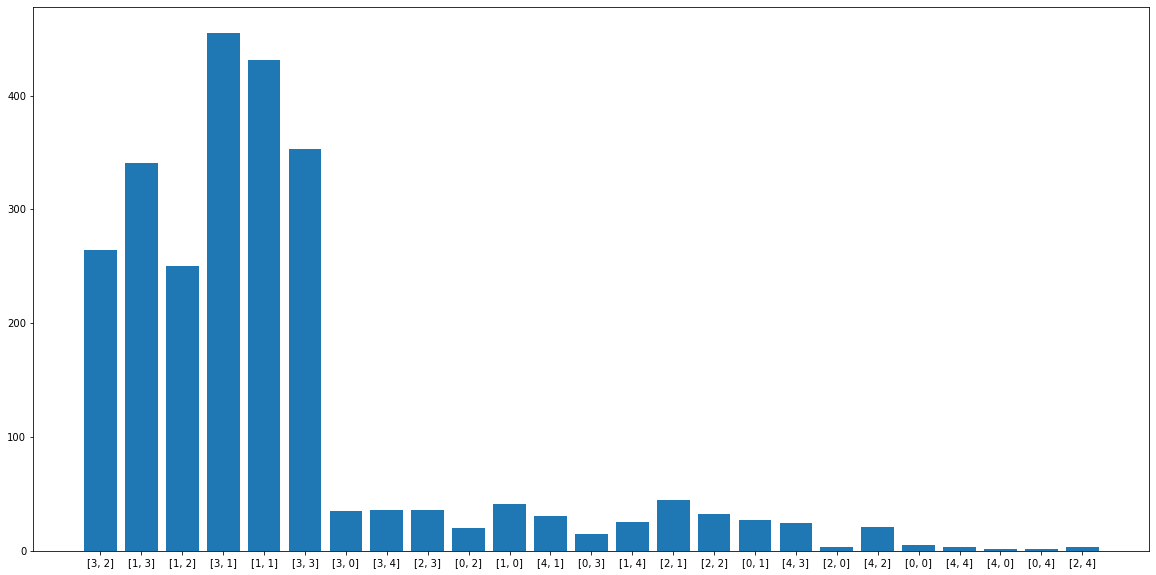

Processing Epoch 51
training start
Iteration 0, d real/fake loss 0.6509978771209717/0.6944814324378967 and g loss is 0.69207763671875, NDiv loss 0.0437217615544796
Iteration 1, d real/fake loss 0.6509082913398743/0.6950333714485168 and g loss is 0.6953533887863159, NDiv loss 0.044563453644514084
Iteration 2, d real/fake loss 0.6508191823959351/0.6923770904541016 and g loss is 0.6930286884307861, NDiv loss 0.040608879178762436
Iteration 3, d real/fake loss 0.6507278680801392/0.6899609565734863 and g loss is 0.6937956809997559, NDiv loss 0.0470910370349884
Iteration 4, d real/fake loss 0.6506309509277344/0.6958887577056885 and g loss is 0.6905691623687744, NDiv loss 0.041086919605731964


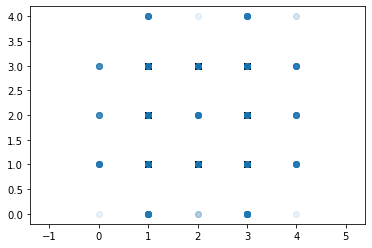

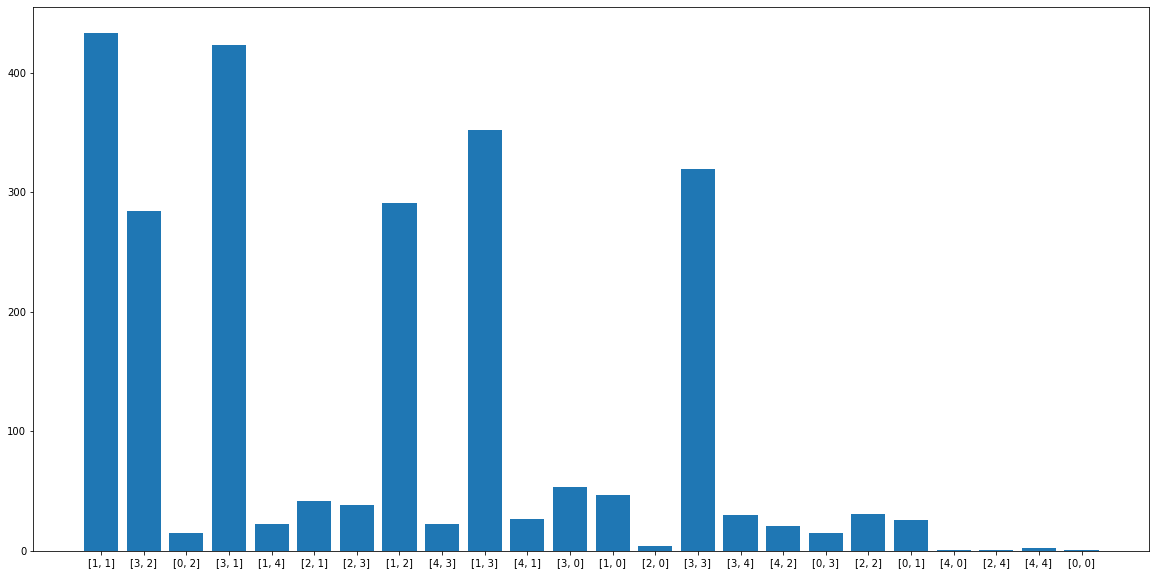

Processing Epoch 52
training start
Iteration 0, d real/fake loss 0.6446962952613831/0.696425199508667 and g loss is 0.6963542699813843, NDiv loss 0.047269001603126526
Iteration 1, d real/fake loss 0.6446743607521057/0.6942353248596191 and g loss is 0.6874985098838806, NDiv loss 0.044407252222299576
Iteration 2, d real/fake loss 0.6446517705917358/0.6913948059082031 and g loss is 0.6942276358604431, NDiv loss 0.043126560747623444
Iteration 3, d real/fake loss 0.6446259021759033/0.6973565220832825 and g loss is 0.6968780159950256, NDiv loss 0.046679701656103134
Iteration 4, d real/fake loss 0.6446042060852051/0.6920356154441833 and g loss is 0.6971185207366943, NDiv loss 0.043041206896305084


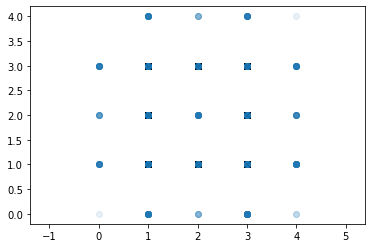

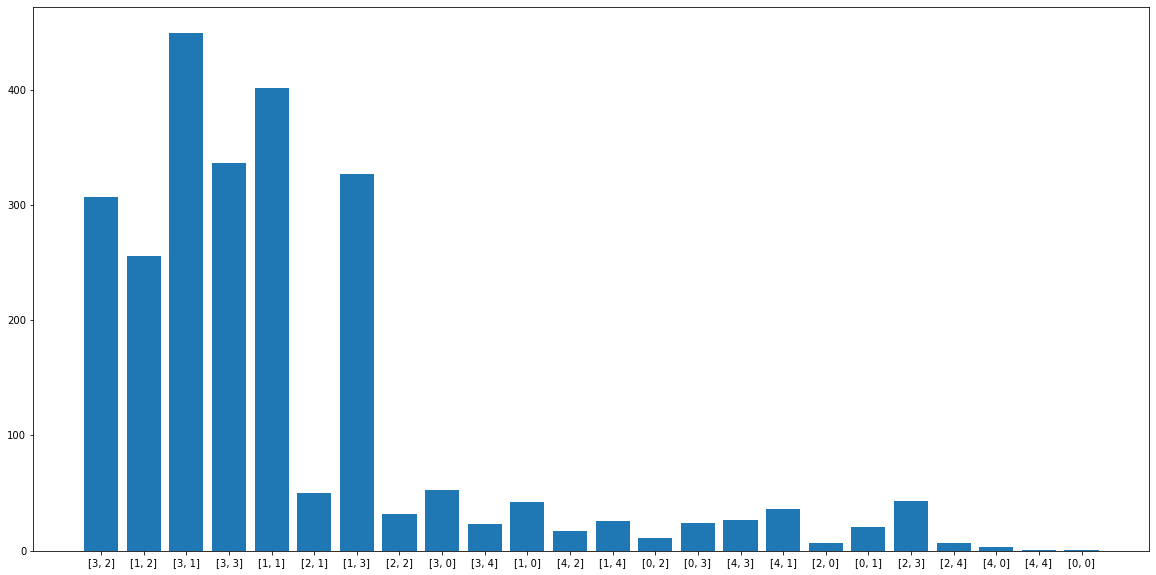

Processing Epoch 53
training start
Iteration 0, d real/fake loss 0.6474753618240356/0.6900348663330078 and g loss is 0.697018027305603, NDiv loss 0.041874006390571594
Iteration 1, d real/fake loss 0.6474007368087769/0.694720983505249 and g loss is 0.6970916986465454, NDiv loss 0.04453548043966293
Iteration 2, d real/fake loss 0.6473272442817688/0.6919515132904053 and g loss is 0.697714626789093, NDiv loss 0.044460855424404144
Iteration 3, d real/fake loss 0.6472556591033936/0.6903741955757141 and g loss is 0.6982584595680237, NDiv loss 0.0427413284778595
Iteration 4, d real/fake loss 0.6471742987632751/0.6918283700942993 and g loss is 0.6930093765258789, NDiv loss 0.04528387263417244


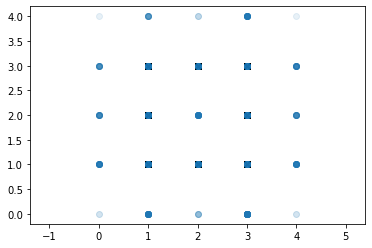

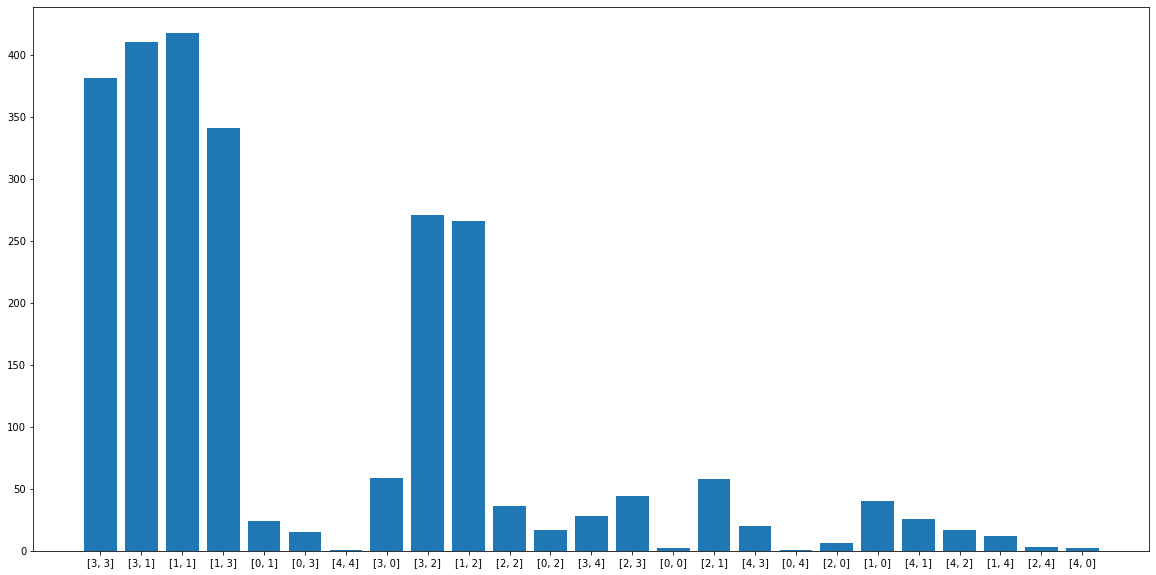

Processing Epoch 54
training start
Iteration 0, d real/fake loss 0.6476090550422668/0.696346640586853 and g loss is 0.6963908076286316, NDiv loss 0.04077581316232681
Iteration 1, d real/fake loss 0.6475372314453125/0.6933456063270569 and g loss is 0.6920819282531738, NDiv loss 0.047033168375492096
Iteration 2, d real/fake loss 0.6474664211273193/0.6913307309150696 and g loss is 0.7007972598075867, NDiv loss 0.043277207762002945
Iteration 3, d real/fake loss 0.6473931074142456/0.6898843050003052 and g loss is 0.6948908567428589, NDiv loss 0.04162225127220154
Iteration 4, d real/fake loss 0.6473139524459839/0.6899669766426086 and g loss is 0.6953792572021484, NDiv loss 0.04553099721670151


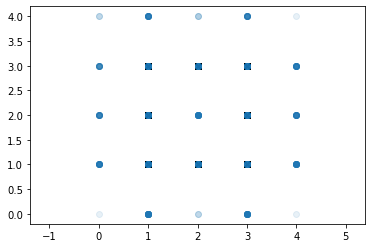

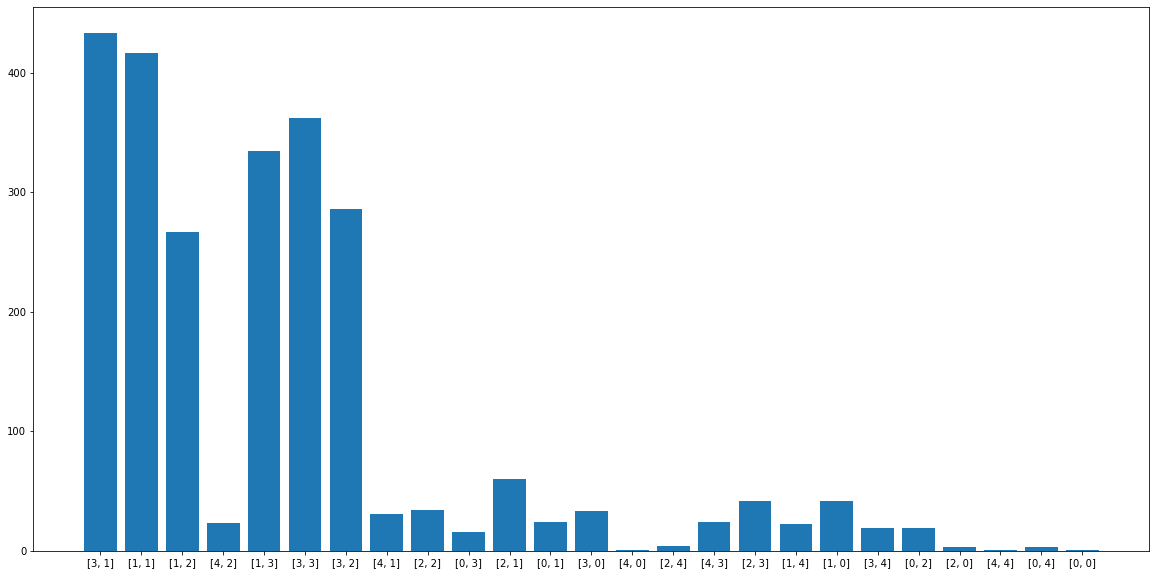

Processing Epoch 55
training start
Iteration 0, d real/fake loss 0.6445639133453369/0.6886653304100037 and g loss is 0.6937456130981445, NDiv loss 0.03865087777376175
Iteration 1, d real/fake loss 0.6444846987724304/0.6922707557678223 and g loss is 0.6948893666267395, NDiv loss 0.044054046273231506
Iteration 2, d real/fake loss 0.6444069147109985/0.6906037330627441 and g loss is 0.6947799921035767, NDiv loss 0.04414096474647522
Iteration 3, d real/fake loss 0.6443292498588562/0.6946317553520203 and g loss is 0.6988953351974487, NDiv loss 0.047190241515636444
Iteration 4, d real/fake loss 0.644255518913269/0.6914253234863281 and g loss is 0.6963082551956177, NDiv loss 0.040948353707790375


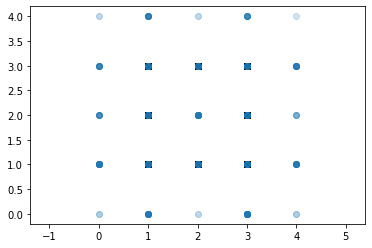

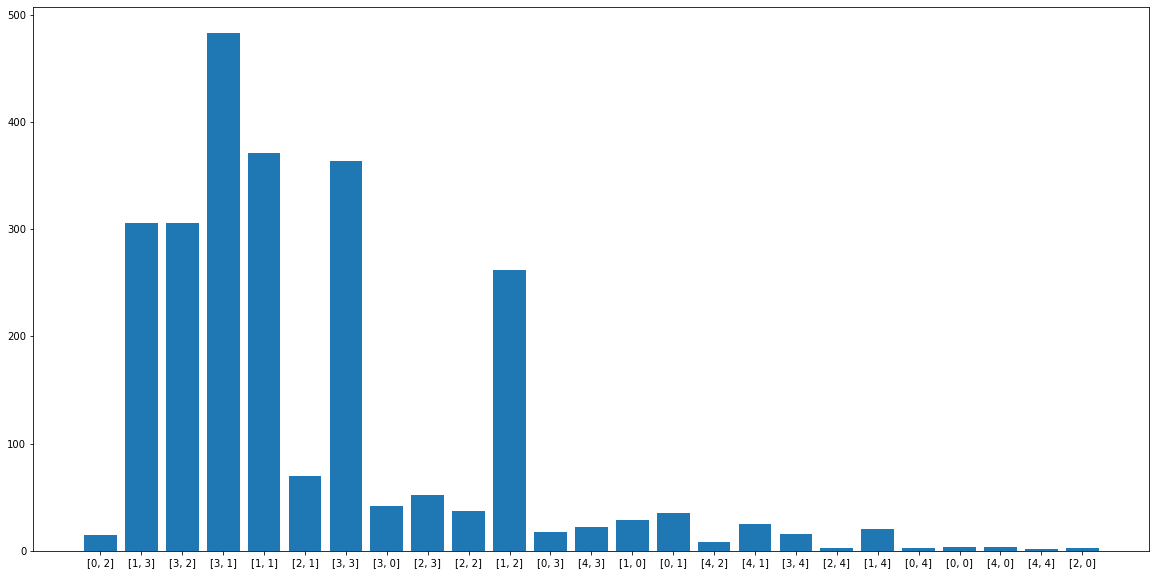

Processing Epoch 56
training start
Iteration 0, d real/fake loss 0.6459935903549194/0.6919577717781067 and g loss is 0.6934983134269714, NDiv loss 0.04517202451825142
Iteration 1, d real/fake loss 0.6459680795669556/0.6878746151924133 and g loss is 0.6985427141189575, NDiv loss 0.0399242602288723
Iteration 2, d real/fake loss 0.6459274888038635/0.6883272528648376 and g loss is 0.6975882053375244, NDiv loss 0.044288624078035355
Iteration 3, d real/fake loss 0.6458758115768433/0.6847118139266968 and g loss is 0.6966779232025146, NDiv loss 0.039994727820158005
Iteration 4, d real/fake loss 0.6458083391189575/0.6908690929412842 and g loss is 0.6989732980728149, NDiv loss 0.04271295294165611


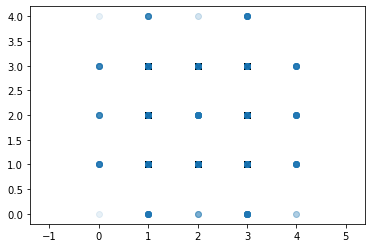

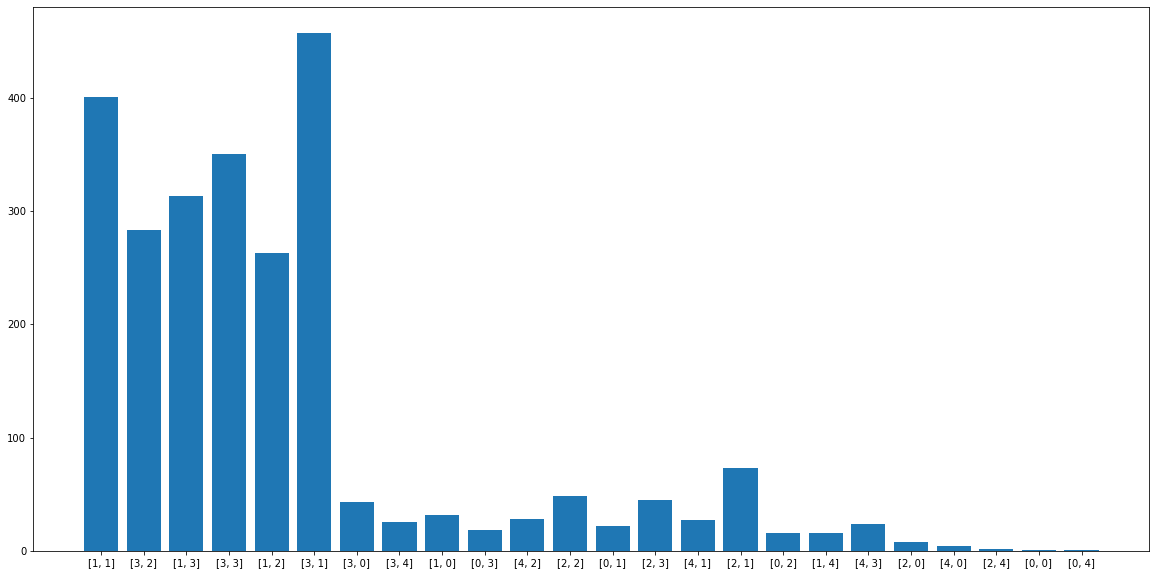

Processing Epoch 57
training start
Iteration 0, d real/fake loss 0.6455527544021606/0.6894912123680115 and g loss is 0.6976697444915771, NDiv loss 0.04319315403699875
Iteration 1, d real/fake loss 0.6454535722732544/0.6874656081199646 and g loss is 0.6977542638778687, NDiv loss 0.04592224583029747
Iteration 2, d real/fake loss 0.645352840423584/0.6875714063644409 and g loss is 0.6969678997993469, NDiv loss 0.04369504377245903
Iteration 3, d real/fake loss 0.6452425718307495/0.6872982978820801 and g loss is 0.6961320042610168, NDiv loss 0.0396534726023674
Iteration 4, d real/fake loss 0.6451326012611389/0.6883666515350342 and g loss is 0.6971884965896606, NDiv loss 0.042030420154333115


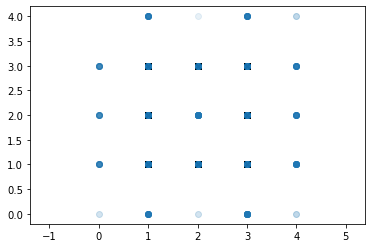

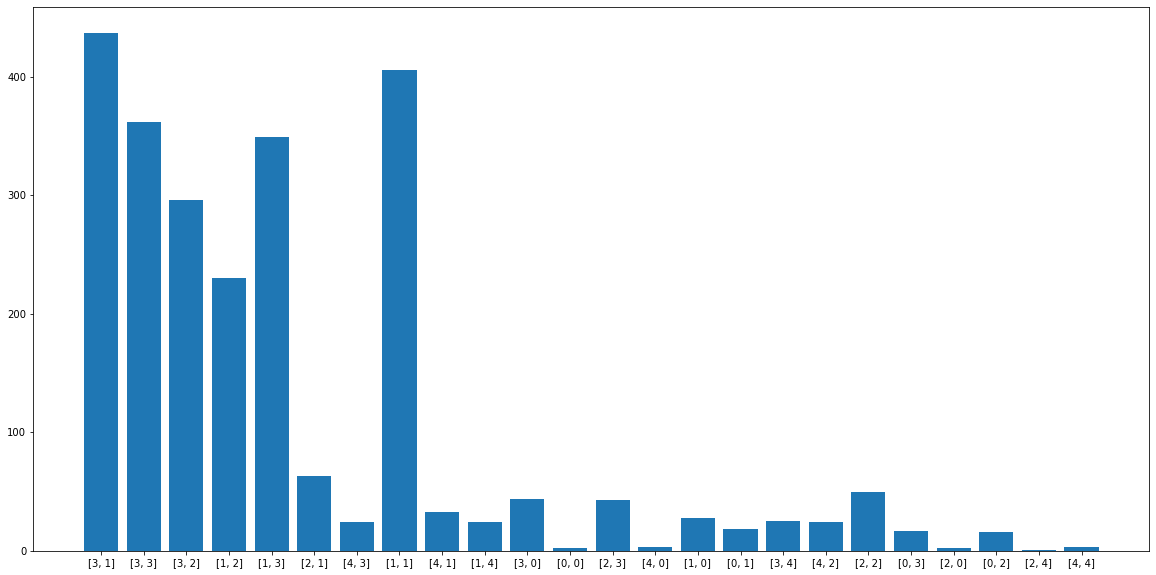

Processing Epoch 58
training start
Iteration 0, d real/fake loss 0.6467145085334778/0.6872720122337341 and g loss is 0.6985108852386475, NDiv loss 0.04781670123338699
Iteration 1, d real/fake loss 0.6466104984283447/0.6909006834030151 and g loss is 0.6973176598548889, NDiv loss 0.04583103209733963
Iteration 2, d real/fake loss 0.6465075016021729/0.686998724937439 and g loss is 0.703395426273346, NDiv loss 0.042558103799819946
Iteration 3, d real/fake loss 0.6464011073112488/0.6901069283485413 and g loss is 0.6951385736465454, NDiv loss 0.041556622833013535
Iteration 4, d real/fake loss 0.646297037601471/0.6853811144828796 and g loss is 0.7002251148223877, NDiv loss 0.04462617635726929


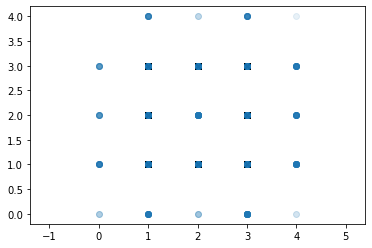

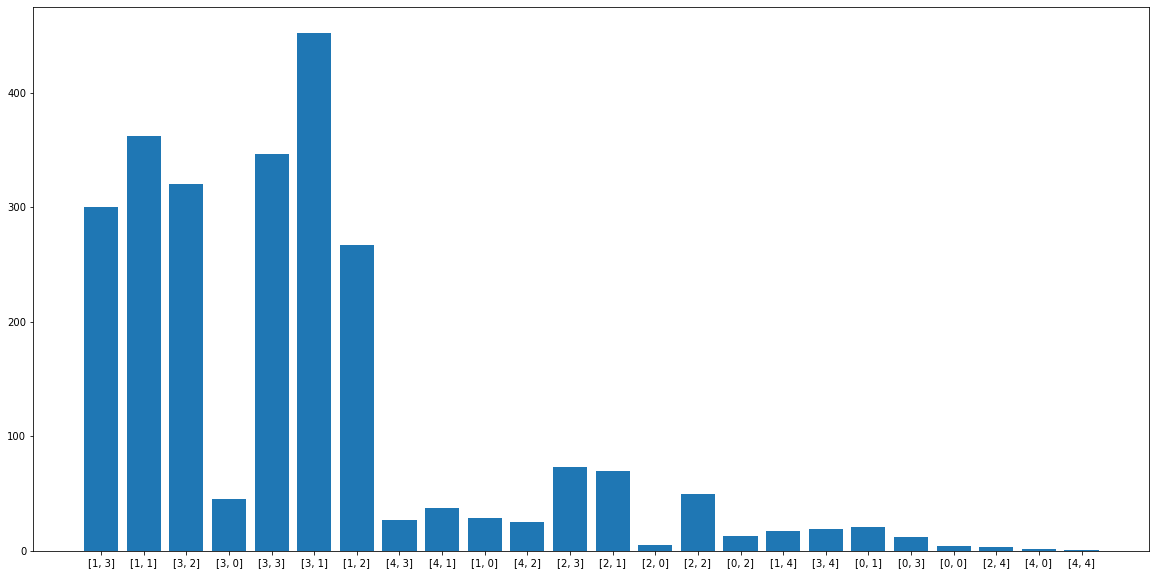

Processing Epoch 59
training start
Iteration 0, d real/fake loss 0.644040584564209/0.6886280179023743 and g loss is 0.702438235282898, NDiv loss 0.04392586648464203
Iteration 1, d real/fake loss 0.6439419388771057/0.6858339309692383 and g loss is 0.699637770652771, NDiv loss 0.0430467464029789
Iteration 2, d real/fake loss 0.6438420414924622/0.6857004165649414 and g loss is 0.7013419270515442, NDiv loss 0.042967140674591064
Iteration 3, d real/fake loss 0.6437422037124634/0.6883050203323364 and g loss is 0.6994151473045349, NDiv loss 0.044272251427173615
Iteration 4, d real/fake loss 0.6436472535133362/0.6856995820999146 and g loss is 0.6974233388900757, NDiv loss 0.03958849608898163


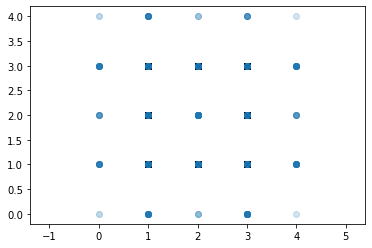

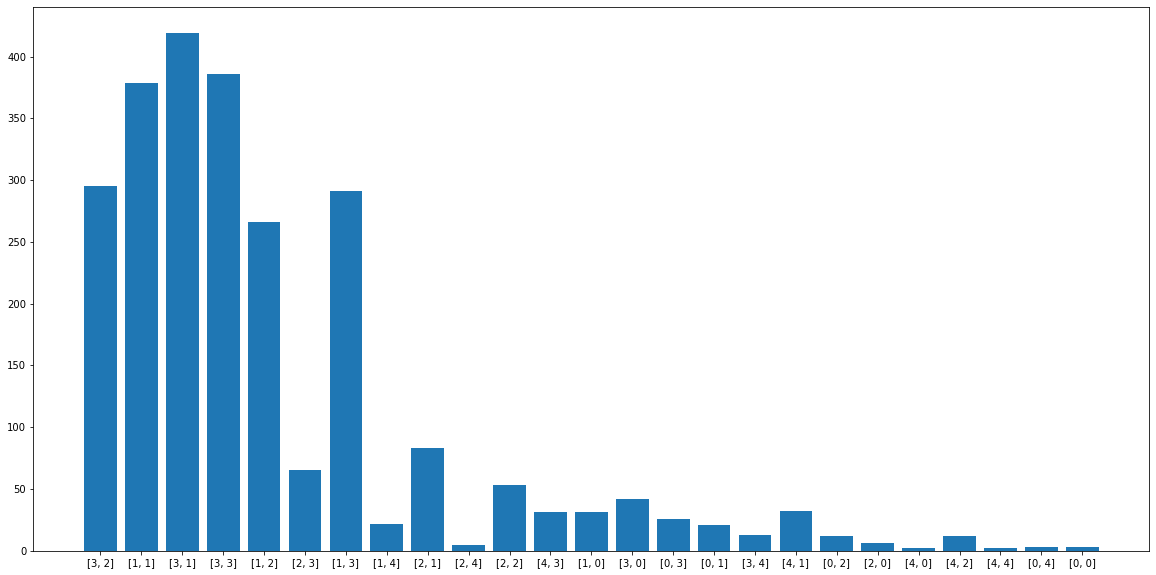

Processing Epoch 60
training start
Iteration 0, d real/fake loss 0.6447815895080566/0.6880242824554443 and g loss is 0.7007990479469299, NDiv loss 0.04545070230960846
Iteration 1, d real/fake loss 0.644696831703186/0.6854146718978882 and g loss is 0.6982979774475098, NDiv loss 0.043043993413448334
Iteration 2, d real/fake loss 0.6446072459220886/0.6874587535858154 and g loss is 0.6992621421813965, NDiv loss 0.041319701820611954
Iteration 3, d real/fake loss 0.6445150971412659/0.688091516494751 and g loss is 0.7006838321685791, NDiv loss 0.04521362483501434
Iteration 4, d real/fake loss 0.6444177627563477/0.6847747564315796 and g loss is 0.7005124688148499, NDiv loss 0.039764292538166046


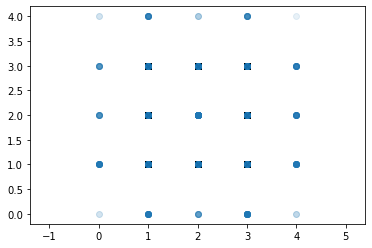

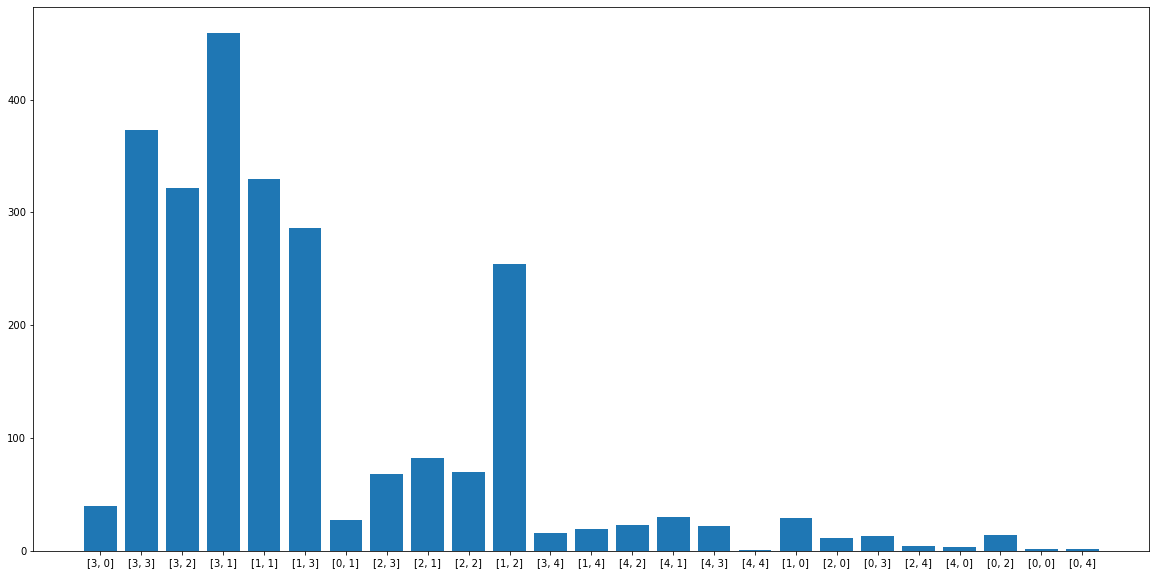

Processing Epoch 61
training start
Iteration 0, d real/fake loss 0.6444343328475952/0.686540961265564 and g loss is 0.6995494961738586, NDiv loss 0.041550930589437485
Iteration 1, d real/fake loss 0.644336462020874/0.6859132051467896 and g loss is 0.6970003247261047, NDiv loss 0.041594427078962326
Iteration 2, d real/fake loss 0.644233763217926/0.6906112432479858 and g loss is 0.7014926671981812, NDiv loss 0.04781254008412361
Iteration 3, d real/fake loss 0.6441336274147034/0.6851364970207214 and g loss is 0.7000844478607178, NDiv loss 0.04474204406142235
Iteration 4, d real/fake loss 0.6440321207046509/0.687705934047699 and g loss is 0.6969701051712036, NDiv loss 0.04237879812717438


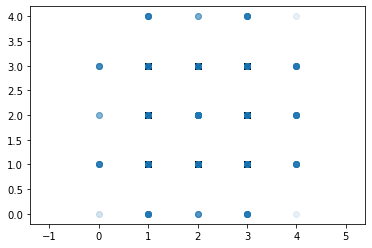

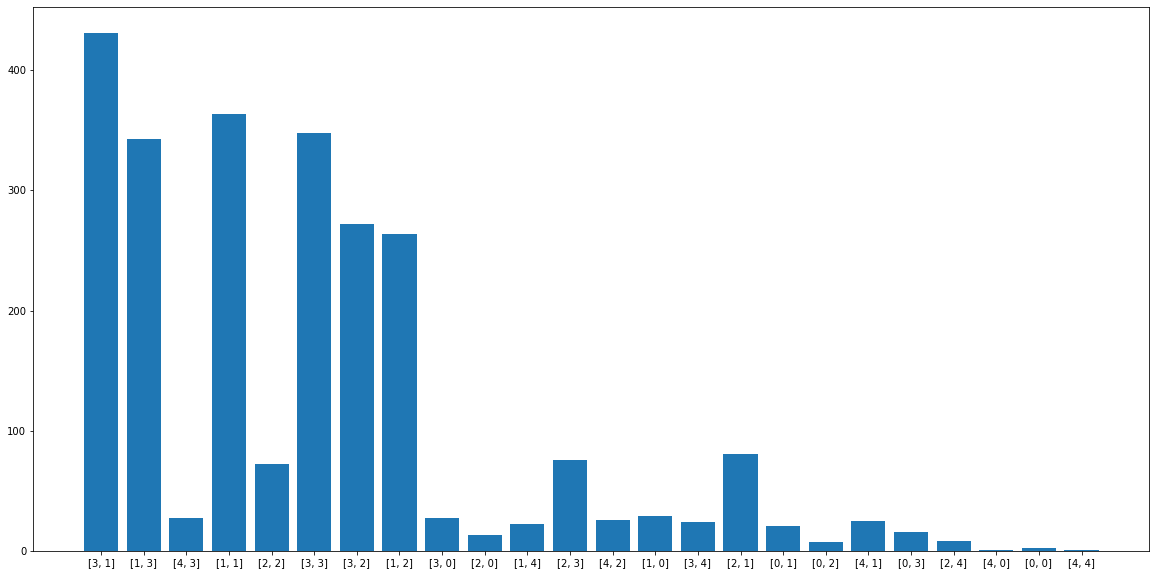

Processing Epoch 62
training start
Iteration 0, d real/fake loss 0.6456828713417053/0.6885131001472473 and g loss is 0.6993118524551392, NDiv loss 0.04020391404628754
Iteration 1, d real/fake loss 0.645601749420166/0.688029408454895 and g loss is 0.6993871331214905, NDiv loss 0.041538503021001816
Iteration 2, d real/fake loss 0.6455155611038208/0.6857051849365234 and g loss is 0.7011860013008118, NDiv loss 0.045017071068286896
Iteration 3, d real/fake loss 0.6454201936721802/0.6856400966644287 and g loss is 0.701561450958252, NDiv loss 0.0422615110874176
Iteration 4, d real/fake loss 0.6453112959861755/0.6889200210571289 and g loss is 0.7003624439239502, NDiv loss 0.04063224419951439


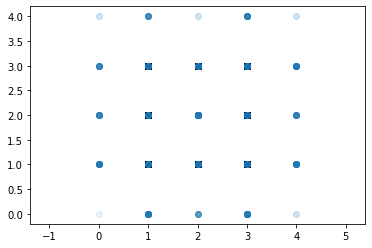

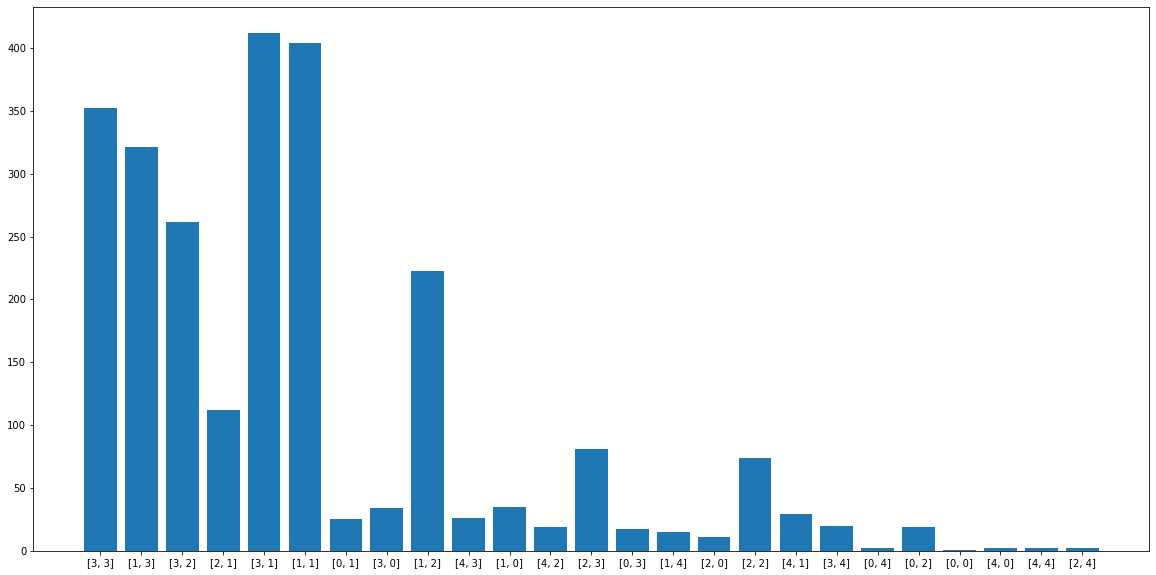

Processing Epoch 63
training start
Iteration 0, d real/fake loss 0.64521324634552/0.6898443698883057 and g loss is 0.7023604512214661, NDiv loss 0.041980914771556854
Iteration 1, d real/fake loss 0.6451099514961243/0.6861934661865234 and g loss is 0.7041324377059937, NDiv loss 0.03900911286473274
Iteration 2, d real/fake loss 0.6449918150901794/0.6892785429954529 and g loss is 0.7025355696678162, NDiv loss 0.0429367795586586
Iteration 3, d real/fake loss 0.6448612809181213/0.6862854957580566 and g loss is 0.699290931224823, NDiv loss 0.039315130561590195
Iteration 4, d real/fake loss 0.6447224020957947/0.6878141164779663 and g loss is 0.6997053027153015, NDiv loss 0.043754566460847855


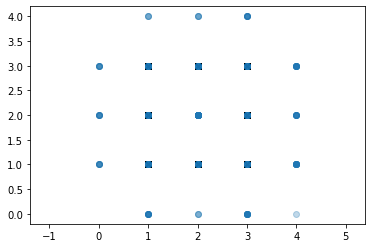

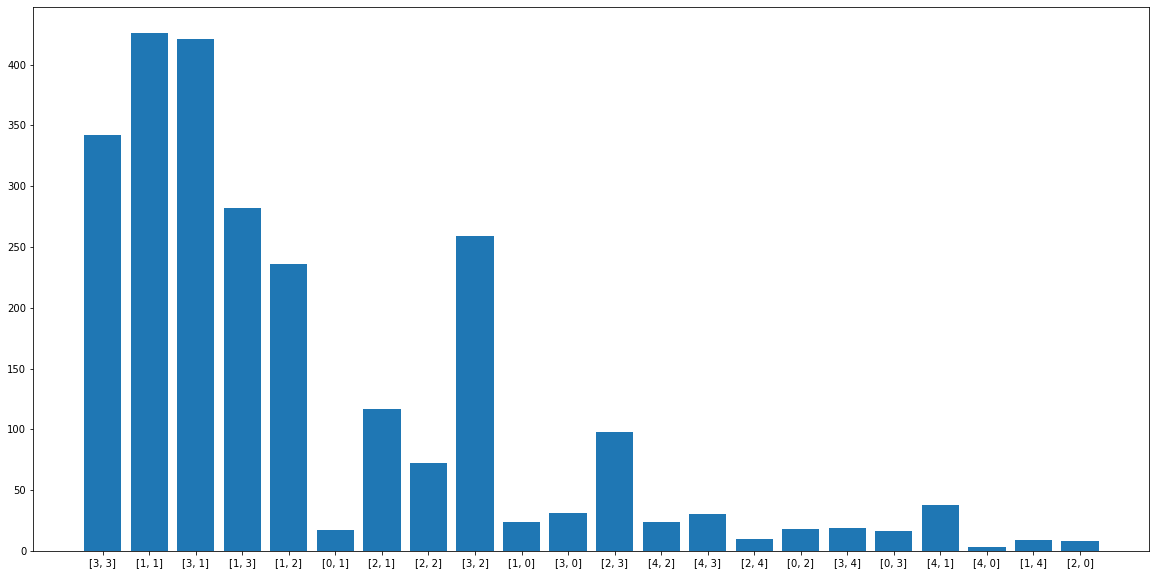

Processing Epoch 64
training start
Iteration 0, d real/fake loss 0.6416833400726318/0.6859968900680542 and g loss is 0.700641393661499, NDiv loss 0.04126472398638725
Iteration 1, d real/fake loss 0.6415387988090515/0.6862035989761353 and g loss is 0.6994408965110779, NDiv loss 0.042167242616415024
Iteration 2, d real/fake loss 0.6413886547088623/0.6889722943305969 and g loss is 0.7011526823043823, NDiv loss 0.043083757162094116
Iteration 3, d real/fake loss 0.6412488222122192/0.6875543594360352 and g loss is 0.6985064744949341, NDiv loss 0.04194045439362526
Iteration 4, d real/fake loss 0.6411085724830627/0.6873133182525635 and g loss is 0.6989454030990601, NDiv loss 0.04258641228079796


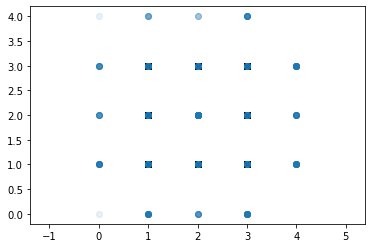

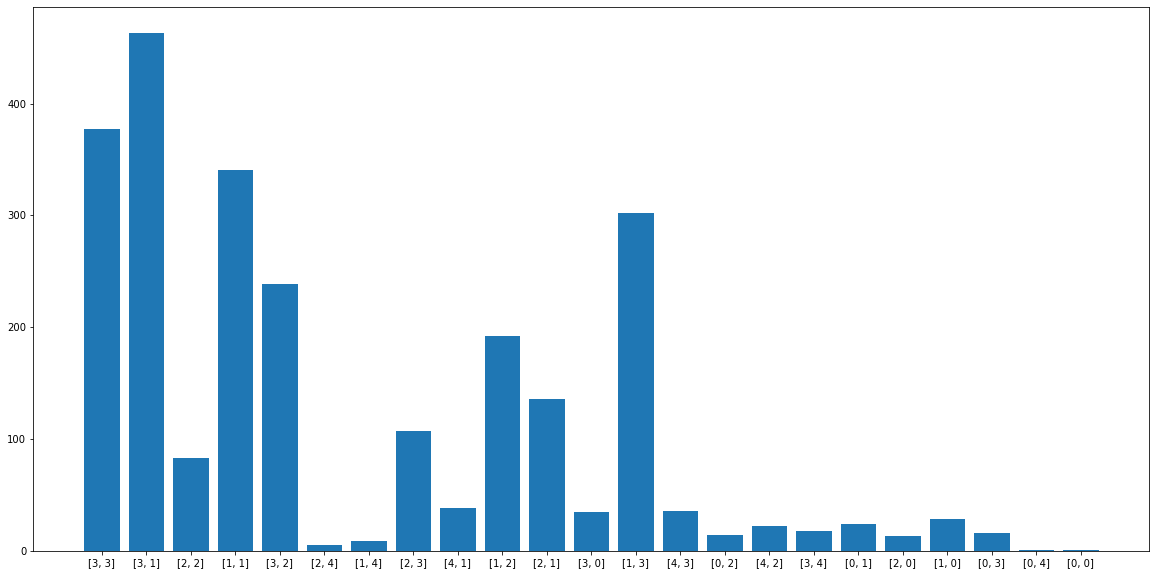

Processing Epoch 65
training start
Iteration 0, d real/fake loss 0.6428244113922119/0.6892164349555969 and g loss is 0.7023868560791016, NDiv loss 0.040621139109134674
Iteration 1, d real/fake loss 0.6426924467086792/0.6860836744308472 and g loss is 0.7024065256118774, NDiv loss 0.04001881554722786
Iteration 2, d real/fake loss 0.6425571441650391/0.6838544011116028 and g loss is 0.6971704959869385, NDiv loss 0.046870239078998566
Iteration 3, d real/fake loss 0.642413854598999/0.6906372308731079 and g loss is 0.7075174450874329, NDiv loss 0.04249076545238495
Iteration 4, d real/fake loss 0.6422693133354187/0.6856749057769775 and g loss is 0.6986541748046875, NDiv loss 0.04602784663438797


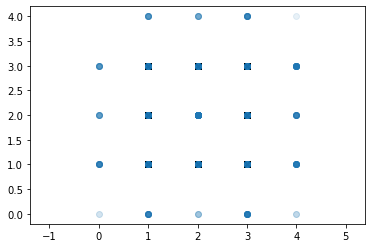

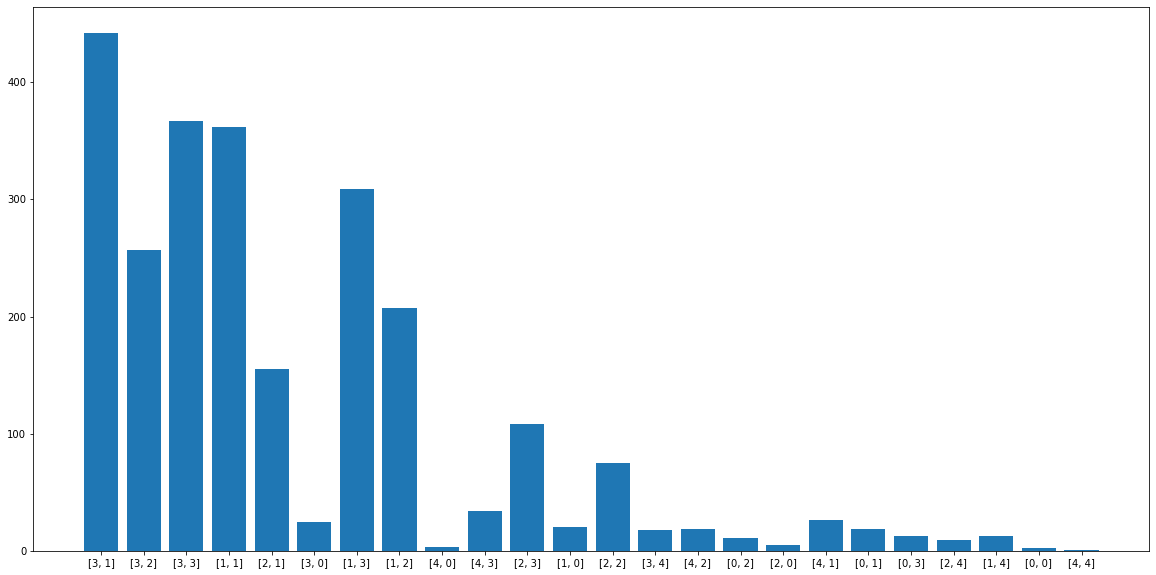

Processing Epoch 66
training start
Iteration 0, d real/fake loss 0.641126275062561/0.6868594288825989 and g loss is 0.7028512358665466, NDiv loss 0.041791871190071106
Iteration 1, d real/fake loss 0.6410059928894043/0.6863664388656616 and g loss is 0.7006509304046631, NDiv loss 0.04293650761246681
Iteration 2, d real/fake loss 0.6408880352973938/0.6889288425445557 and g loss is 0.6992096900939941, NDiv loss 0.0416080504655838
Iteration 3, d real/fake loss 0.6407793164253235/0.6853999495506287 and g loss is 0.7013086080551147, NDiv loss 0.043883491307497025
Iteration 4, d real/fake loss 0.6406673192977905/0.6899380087852478 and g loss is 0.7000135183334351, NDiv loss 0.04492821916937828


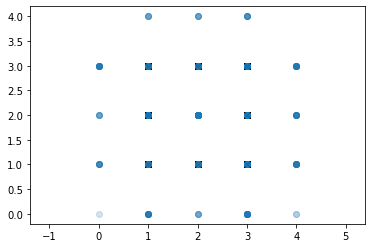

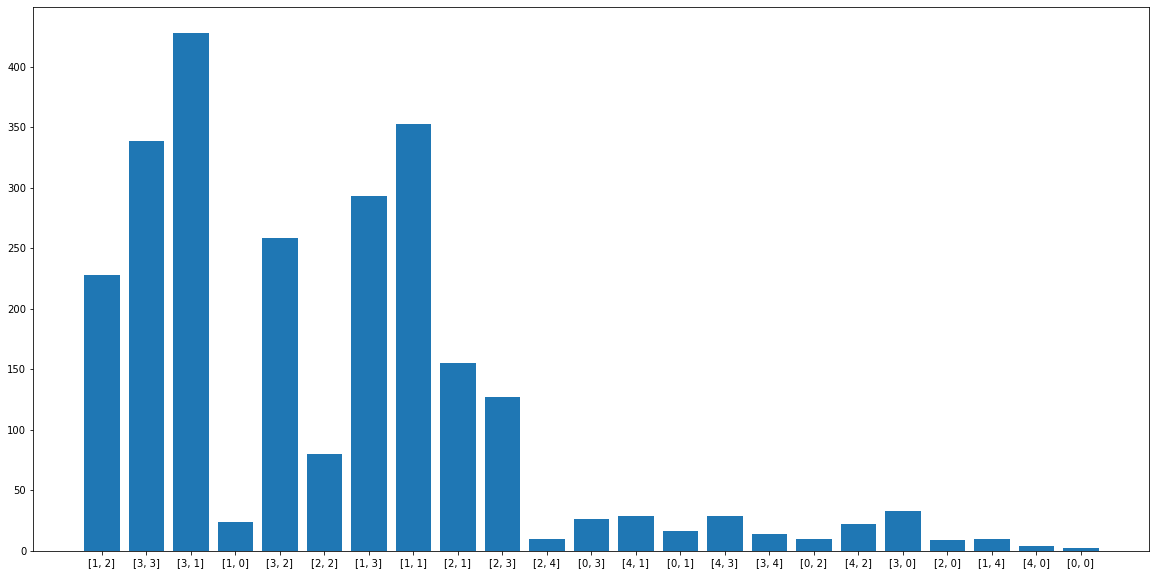

Processing Epoch 67
training start
Iteration 0, d real/fake loss 0.6394782662391663/0.6852145791053772 and g loss is 0.6975498199462891, NDiv loss 0.045916877686977386
Iteration 1, d real/fake loss 0.6394068002700806/0.6876581311225891 and g loss is 0.699521541595459, NDiv loss 0.04150531813502312
Iteration 2, d real/fake loss 0.639328122138977/0.6867502331733704 and g loss is 0.7026849389076233, NDiv loss 0.040322549641132355
Iteration 3, d real/fake loss 0.6392431259155273/0.6855695247650146 and g loss is 0.6971945762634277, NDiv loss 0.04120048135519028
Iteration 4, d real/fake loss 0.6391456723213196/0.6840431690216064 and g loss is 0.7011715173721313, NDiv loss 0.045769933611154556


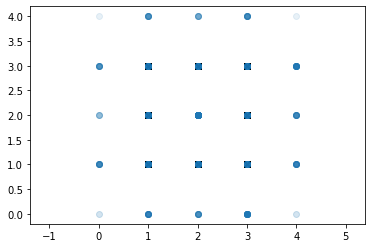

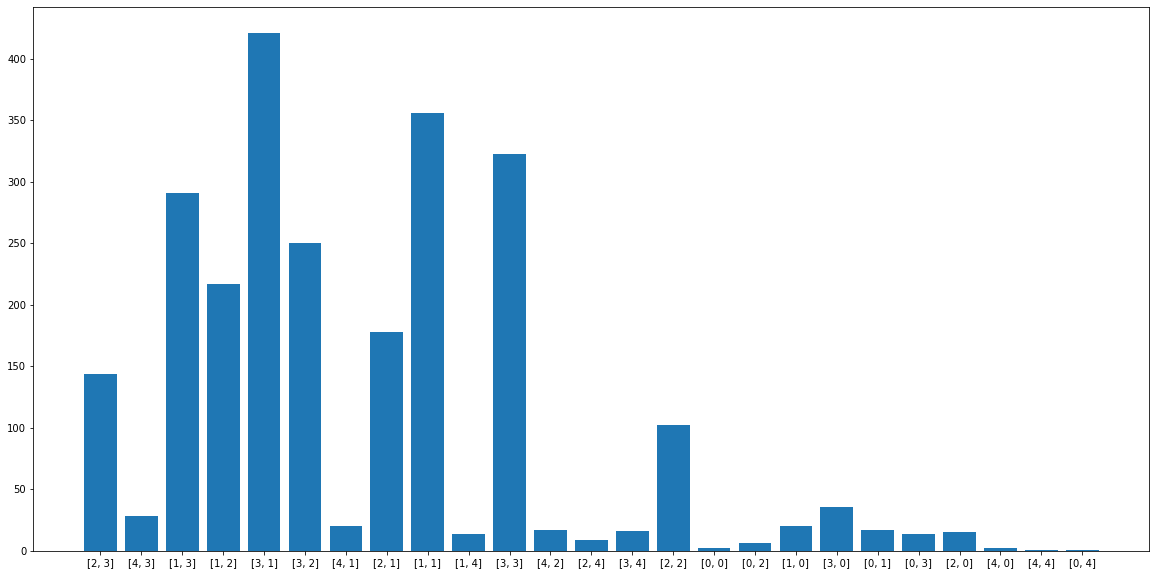

Processing Epoch 68
training start
Iteration 0, d real/fake loss 0.6382983922958374/0.6850910186767578 and g loss is 0.7041270136833191, NDiv loss 0.04238222911953926
Iteration 1, d real/fake loss 0.6381897926330566/0.6878491640090942 and g loss is 0.7011861205101013, NDiv loss 0.0417768731713295
Iteration 2, d real/fake loss 0.6380839347839355/0.6884403228759766 and g loss is 0.6973730325698853, NDiv loss 0.04131493717432022
Iteration 3, d real/fake loss 0.6379803419113159/0.6853823661804199 and g loss is 0.7016175985336304, NDiv loss 0.042641449719667435
Iteration 4, d real/fake loss 0.6378791332244873/0.6862149238586426 and g loss is 0.6948487758636475, NDiv loss 0.04260706529021263


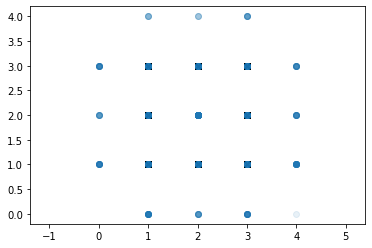

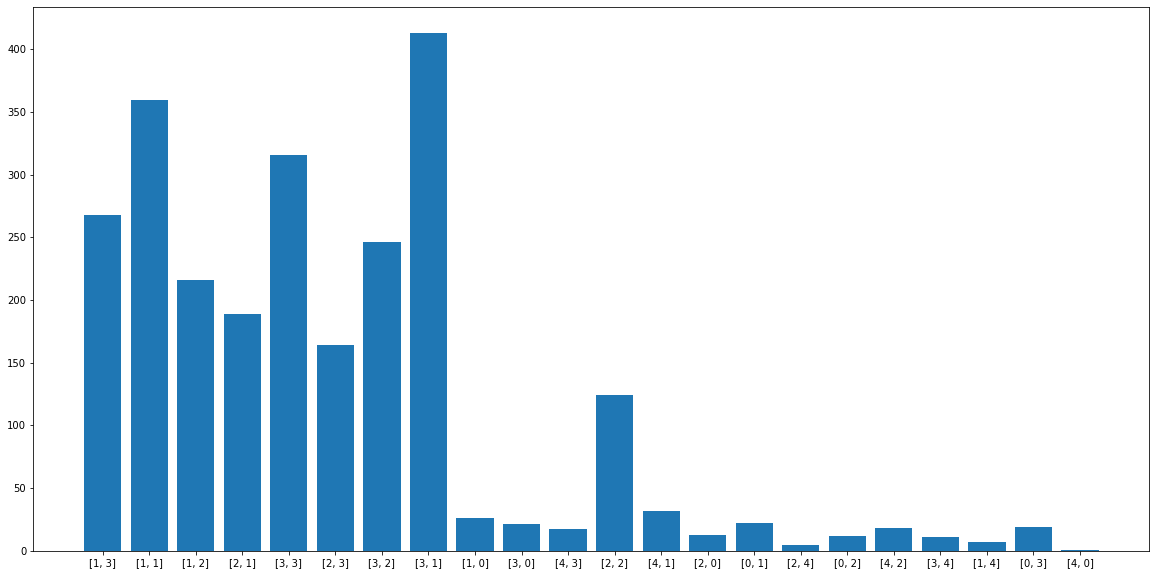

Processing Epoch 69
training start
Iteration 0, d real/fake loss 0.6409784555435181/0.6847376227378845 and g loss is 0.6984430551528931, NDiv loss 0.04242776706814766
Iteration 1, d real/fake loss 0.6408705115318298/0.6877735257148743 and g loss is 0.7022014856338501, NDiv loss 0.04125944525003433
Iteration 2, d real/fake loss 0.6407530307769775/0.6864796876907349 and g loss is 0.6999015808105469, NDiv loss 0.0445651113986969
Iteration 3, d real/fake loss 0.6406285762786865/0.6934442520141602 and g loss is 0.6913150548934937, NDiv loss 0.03885136544704437
Iteration 4, d real/fake loss 0.6405107975006104/0.688694179058075 and g loss is 0.6975651979446411, NDiv loss 0.04012522101402283


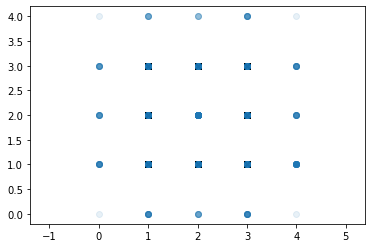

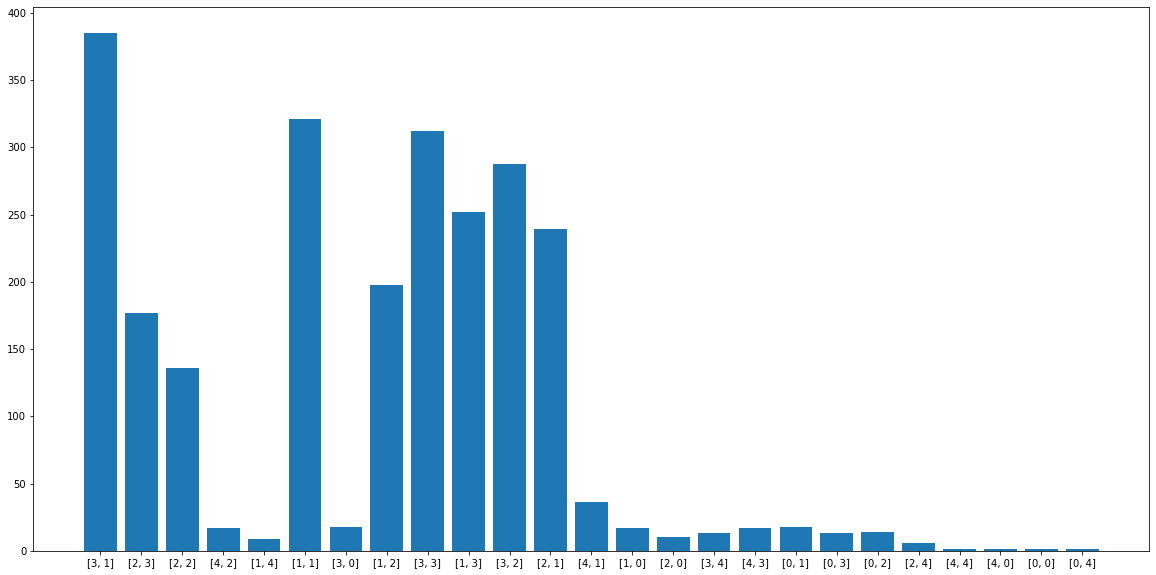

Processing Epoch 70
training start
Iteration 0, d real/fake loss 0.6403065919876099/0.6893442869186401 and g loss is 0.6935527324676514, NDiv loss 0.043230608105659485
Iteration 1, d real/fake loss 0.6401782035827637/0.6886088848114014 and g loss is 0.7014063000679016, NDiv loss 0.04296683892607689
Iteration 2, d real/fake loss 0.6400337219238281/0.6838253736495972 and g loss is 0.6942321062088013, NDiv loss 0.04273207113146782
Iteration 3, d real/fake loss 0.6398841142654419/0.6856884360313416 and g loss is 0.700799822807312, NDiv loss 0.042597446590662
Iteration 4, d real/fake loss 0.639724850654602/0.6889907121658325 and g loss is 0.6959034204483032, NDiv loss 0.0420868806540966


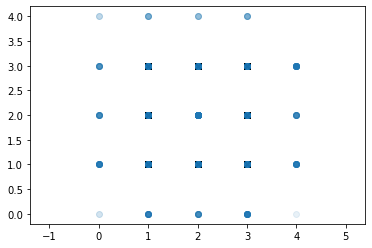

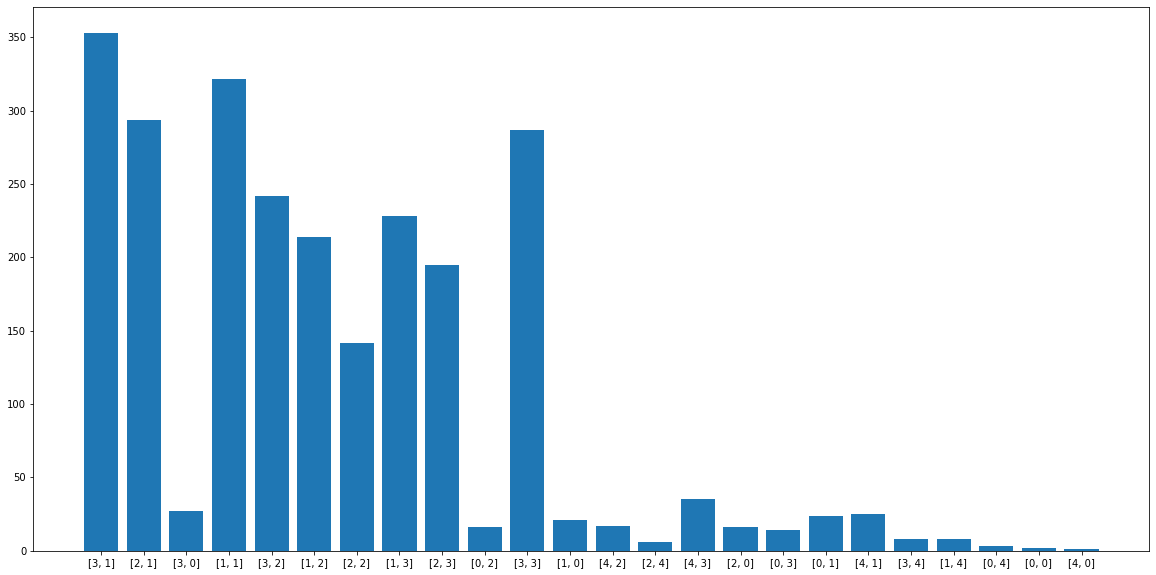

Processing Epoch 71
training start
Iteration 0, d real/fake loss 0.6414813995361328/0.6854027509689331 and g loss is 0.6971312761306763, NDiv loss 0.04398338124155998
Iteration 1, d real/fake loss 0.6413116455078125/0.6882143616676331 and g loss is 0.6975903511047363, NDiv loss 0.04258456826210022
Iteration 2, d real/fake loss 0.6411399841308594/0.6868811845779419 and g loss is 0.6983051300048828, NDiv loss 0.0404786691069603
Iteration 3, d real/fake loss 0.6409611701965332/0.6884124279022217 and g loss is 0.6971532702445984, NDiv loss 0.042208023369312286
Iteration 4, d real/fake loss 0.6407813429832458/0.6899474859237671 and g loss is 0.6965081095695496, NDiv loss 0.04193536192178726


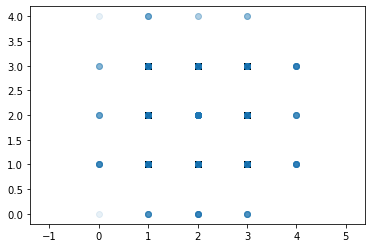

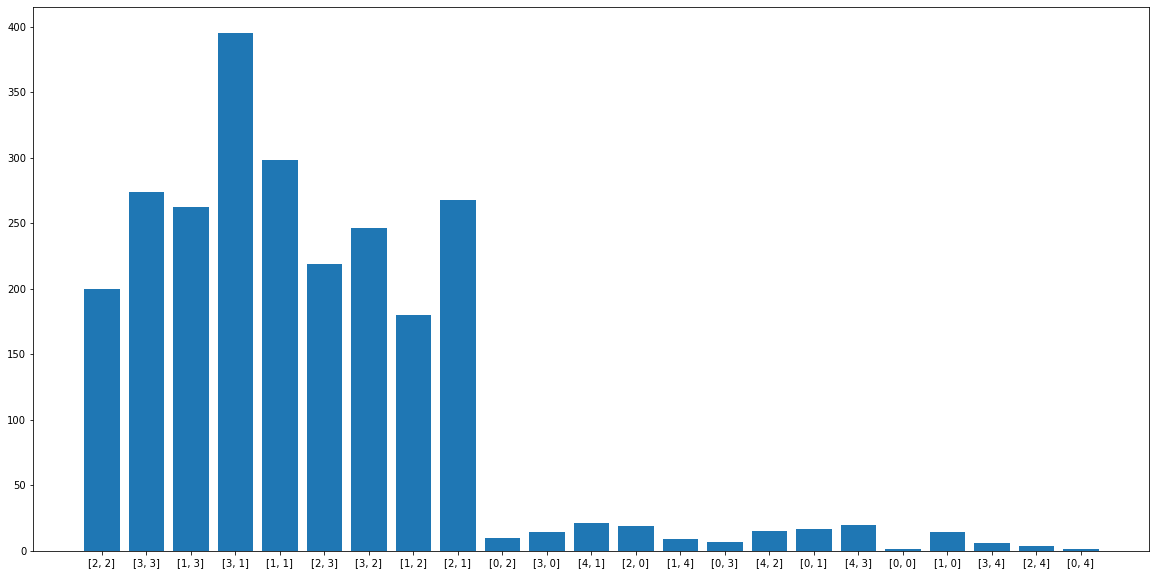

Processing Epoch 72
training start
Iteration 0, d real/fake loss 0.6392232179641724/0.6854695677757263 and g loss is 0.6949375867843628, NDiv loss 0.0412299670279026
Iteration 1, d real/fake loss 0.6390597820281982/0.688219428062439 and g loss is 0.6989139914512634, NDiv loss 0.039160776883363724
Iteration 2, d real/fake loss 0.6388957500457764/0.6885514259338379 and g loss is 0.7021404504776001, NDiv loss 0.04303869605064392
Iteration 3, d real/fake loss 0.6387348175048828/0.6909105777740479 and g loss is 0.7012813091278076, NDiv loss 0.04322924464941025
Iteration 4, d real/fake loss 0.6385799050331116/0.688287615776062 and g loss is 0.6988415122032166, NDiv loss 0.04208105430006981


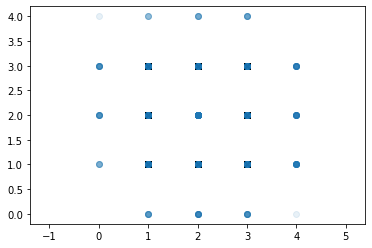

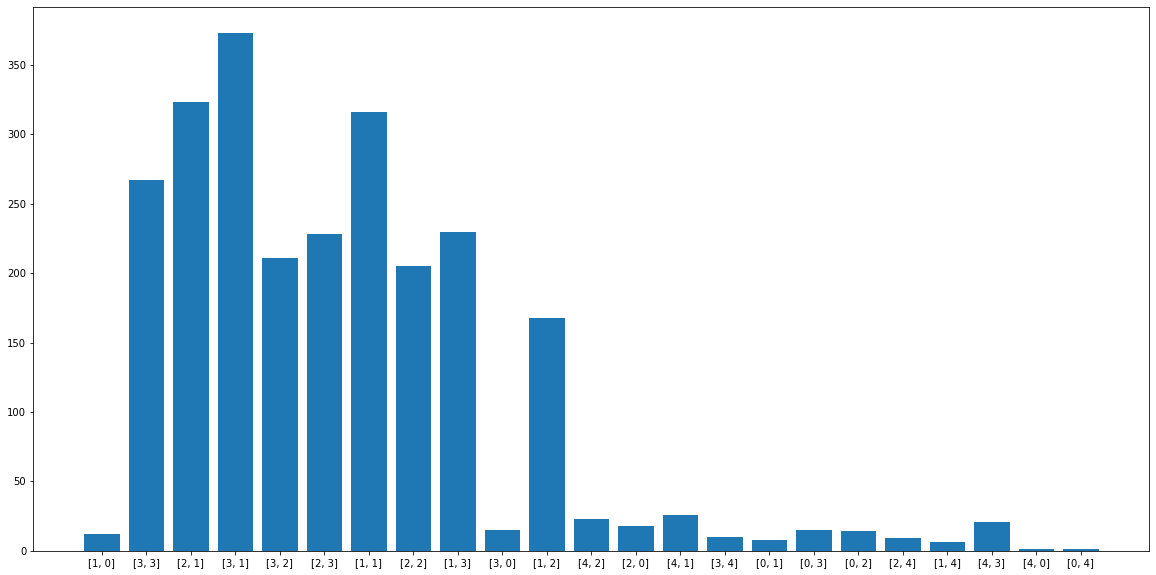

Processing Epoch 73
training start
Iteration 0, d real/fake loss 0.6383249163627625/0.6938294768333435 and g loss is 0.6956679821014404, NDiv loss 0.04230188578367233
Iteration 1, d real/fake loss 0.6381733417510986/0.6874988675117493 and g loss is 0.699446976184845, NDiv loss 0.04178505018353462
Iteration 2, d real/fake loss 0.6380165815353394/0.6931184530258179 and g loss is 0.6987545490264893, NDiv loss 0.04247992858290672
Iteration 3, d real/fake loss 0.637861430644989/0.6906212568283081 and g loss is 0.6959620714187622, NDiv loss 0.042669329792261124
Iteration 4, d real/fake loss 0.6377025246620178/0.6890602707862854 and g loss is 0.6964030265808105, NDiv loss 0.0435960628092289


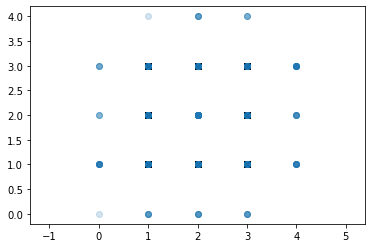

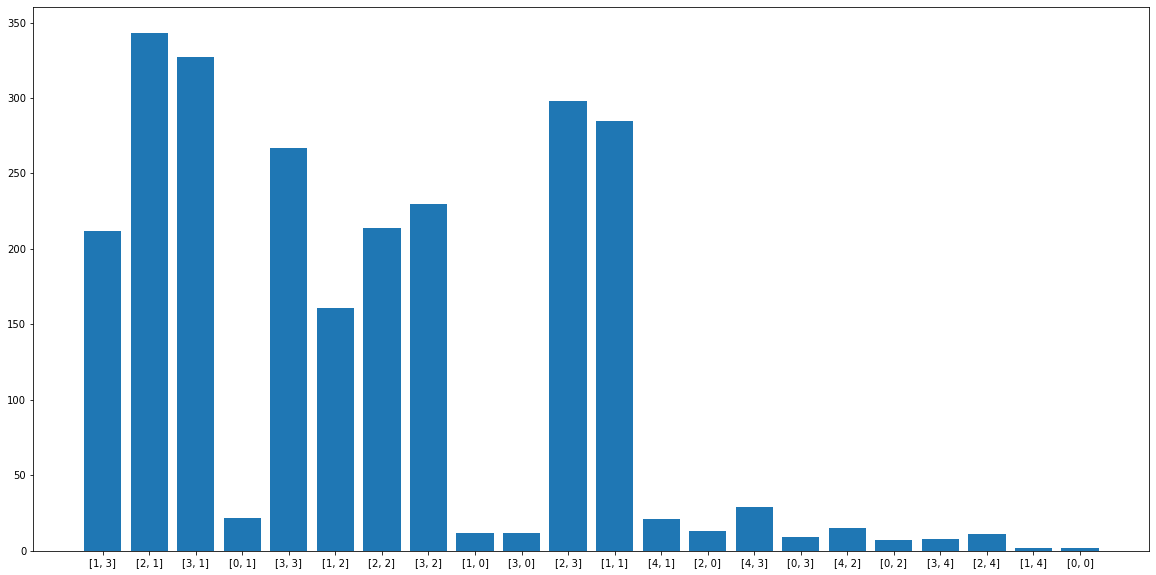

Processing Epoch 74
training start
Iteration 0, d real/fake loss 0.6364837884902954/0.6878608465194702 and g loss is 0.698121964931488, NDiv loss 0.044562991708517075
Iteration 1, d real/fake loss 0.6363389492034912/0.6907758712768555 and g loss is 0.6997088193893433, NDiv loss 0.04223483428359032
Iteration 2, d real/fake loss 0.6361956596374512/0.6878378987312317 and g loss is 0.6930426955223083, NDiv loss 0.04367071017622948
Iteration 3, d real/fake loss 0.6360520124435425/0.6885182857513428 and g loss is 0.6947852373123169, NDiv loss 0.04091979190707207
Iteration 4, d real/fake loss 0.6359098553657532/0.6883863210678101 and g loss is 0.6966584920883179, NDiv loss 0.04055751860141754


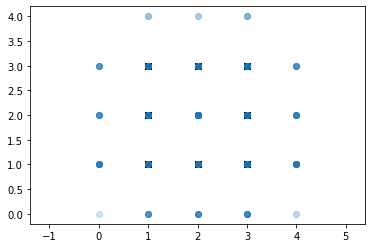

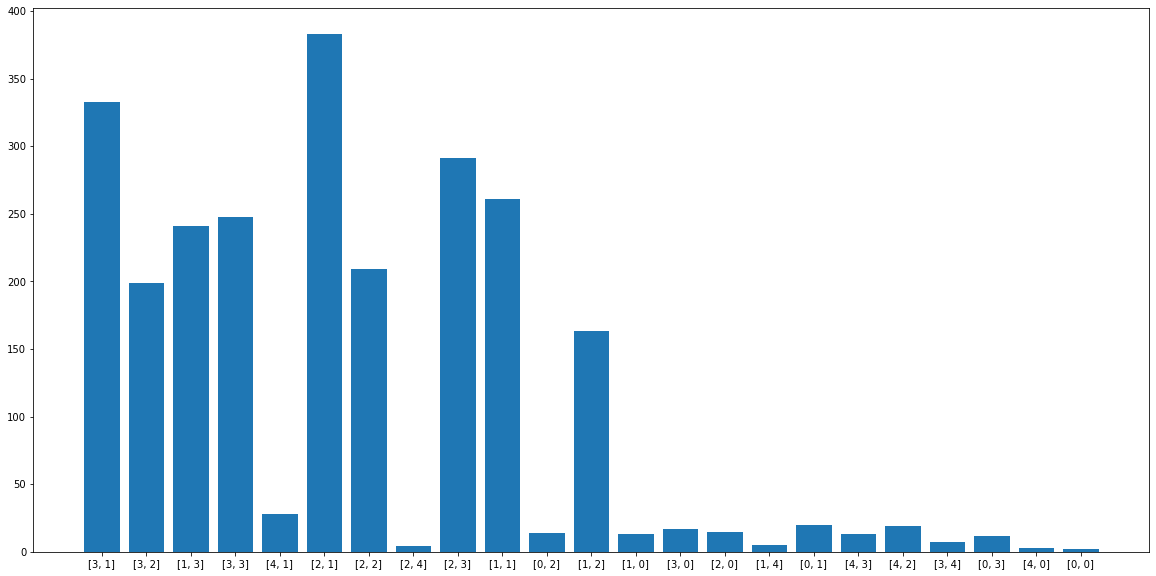

Processing Epoch 75
training start
Iteration 0, d real/fake loss 0.6346242427825928/0.6896567344665527 and g loss is 0.6964853405952454, NDiv loss 0.04009826481342316
Iteration 1, d real/fake loss 0.6345053911209106/0.6915738582611084 and g loss is 0.6972767114639282, NDiv loss 0.04339659959077835
Iteration 2, d real/fake loss 0.6343953609466553/0.6914498805999756 and g loss is 0.6989628672599792, NDiv loss 0.043002236634492874
Iteration 3, d real/fake loss 0.6342911720275879/0.684753954410553 and g loss is 0.6966583132743835, NDiv loss 0.04286068677902222
Iteration 4, d real/fake loss 0.634184718132019/0.6910811066627502 and g loss is 0.699441134929657, NDiv loss 0.04437417909502983


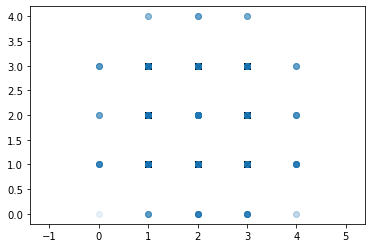

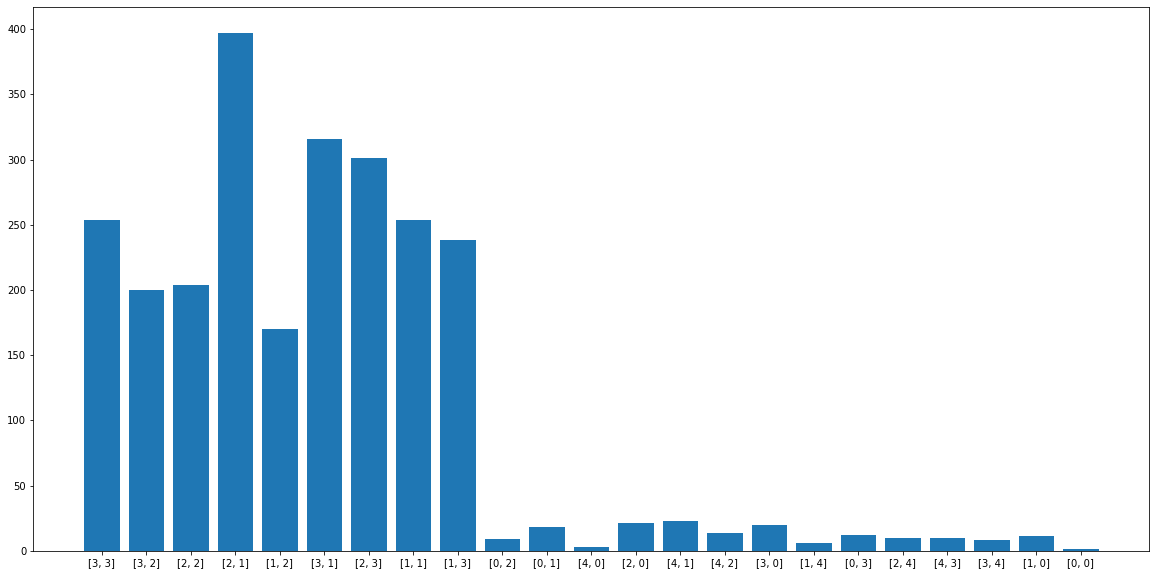

Processing Epoch 76
training start
Iteration 0, d real/fake loss 0.6367489099502563/0.6926497220993042 and g loss is 0.6955850720405579, NDiv loss 0.04489658772945404
Iteration 1, d real/fake loss 0.636655330657959/0.6924861669540405 and g loss is 0.7014233469963074, NDiv loss 0.043368060141801834
Iteration 2, d real/fake loss 0.6365607976913452/0.6864681243896484 and g loss is 0.6974657773971558, NDiv loss 0.041833069175481796
Iteration 3, d real/fake loss 0.636459469795227/0.6880320310592651 and g loss is 0.6937801837921143, NDiv loss 0.04368630051612854
Iteration 4, d real/fake loss 0.636348307132721/0.6897968053817749 and g loss is 0.6951432228088379, NDiv loss 0.042646799236536026


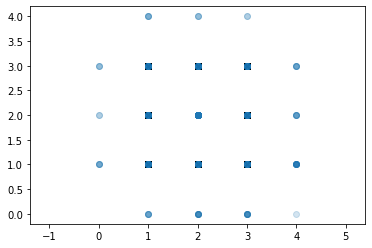

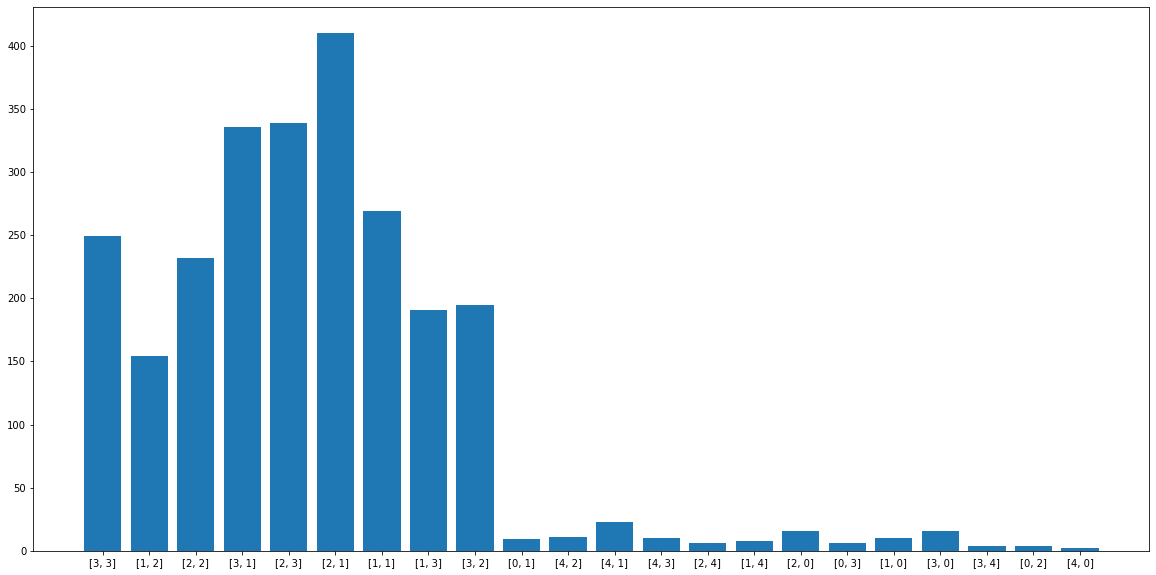

Processing Epoch 77
training start
Iteration 0, d real/fake loss 0.6358413100242615/0.6889568567276001 and g loss is 0.6982520818710327, NDiv loss 0.046050865203142166
Iteration 1, d real/fake loss 0.6357581615447998/0.6937804222106934 and g loss is 0.6945959329605103, NDiv loss 0.04258880764245987
Iteration 2, d real/fake loss 0.635673463344574/0.6904477477073669 and g loss is 0.6986458897590637, NDiv loss 0.04440697282552719
Iteration 3, d real/fake loss 0.6355859041213989/0.6892774701118469 and g loss is 0.6921793818473816, NDiv loss 0.04378947243094444
Iteration 4, d real/fake loss 0.6354947090148926/0.6874524354934692 and g loss is 0.694555938243866, NDiv loss 0.0428178571164608


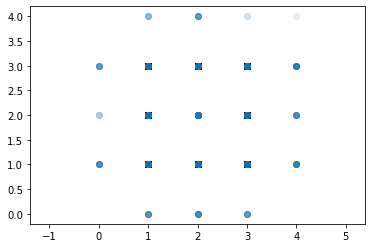

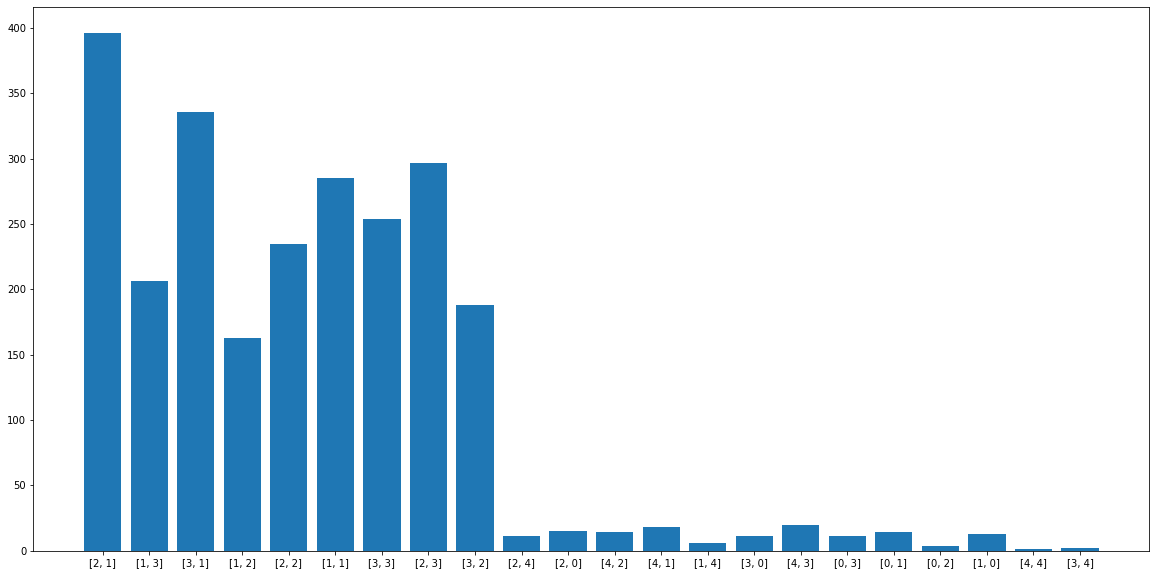

Processing Epoch 78
training start
Iteration 0, d real/fake loss 0.6335659623146057/0.6883106827735901 and g loss is 0.6985546350479126, NDiv loss 0.04114772751927376
Iteration 1, d real/fake loss 0.6334558129310608/0.6891077756881714 and g loss is 0.6956734657287598, NDiv loss 0.044068120419979095
Iteration 2, d real/fake loss 0.6333471536636353/0.6894629001617432 and g loss is 0.6974349617958069, NDiv loss 0.04466353729367256
Iteration 3, d real/fake loss 0.63323974609375/0.6900028586387634 and g loss is 0.698682427406311, NDiv loss 0.045422136783599854
Iteration 4, d real/fake loss 0.6331331729888916/0.6886001825332642 and g loss is 0.6966833472251892, NDiv loss 0.04221920669078827


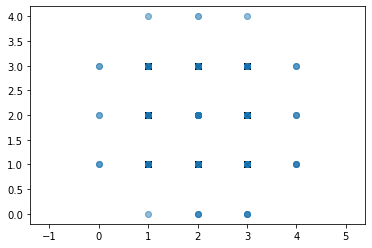

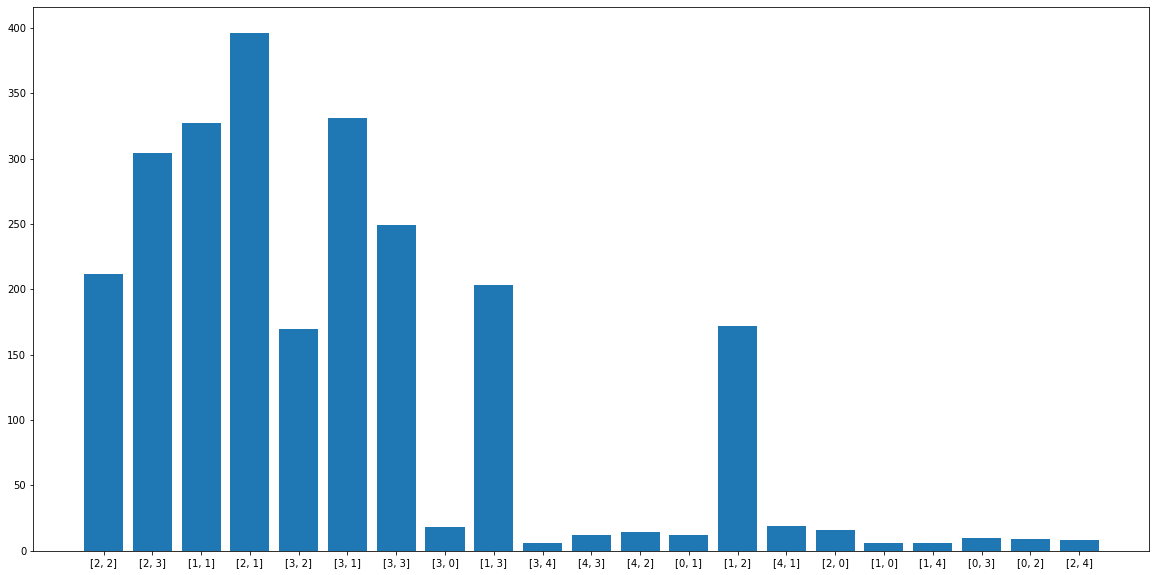

Processing Epoch 79
training start
Iteration 0, d real/fake loss 0.632744312286377/0.6888662576675415 and g loss is 0.6974172592163086, NDiv loss 0.04468338564038277
Iteration 1, d real/fake loss 0.6326632499694824/0.6863337755203247 and g loss is 0.6983323097229004, NDiv loss 0.04478979483246803
Iteration 2, d real/fake loss 0.6325769424438477/0.6872655153274536 and g loss is 0.6967008113861084, NDiv loss 0.045411091297864914
Iteration 3, d real/fake loss 0.6324847936630249/0.6862170100212097 and g loss is 0.699776291847229, NDiv loss 0.04359889775514603
Iteration 4, d real/fake loss 0.6323935389518738/0.6887506246566772 and g loss is 0.697508692741394, NDiv loss 0.044542185962200165


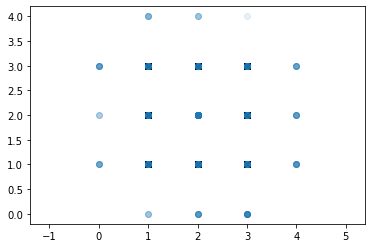

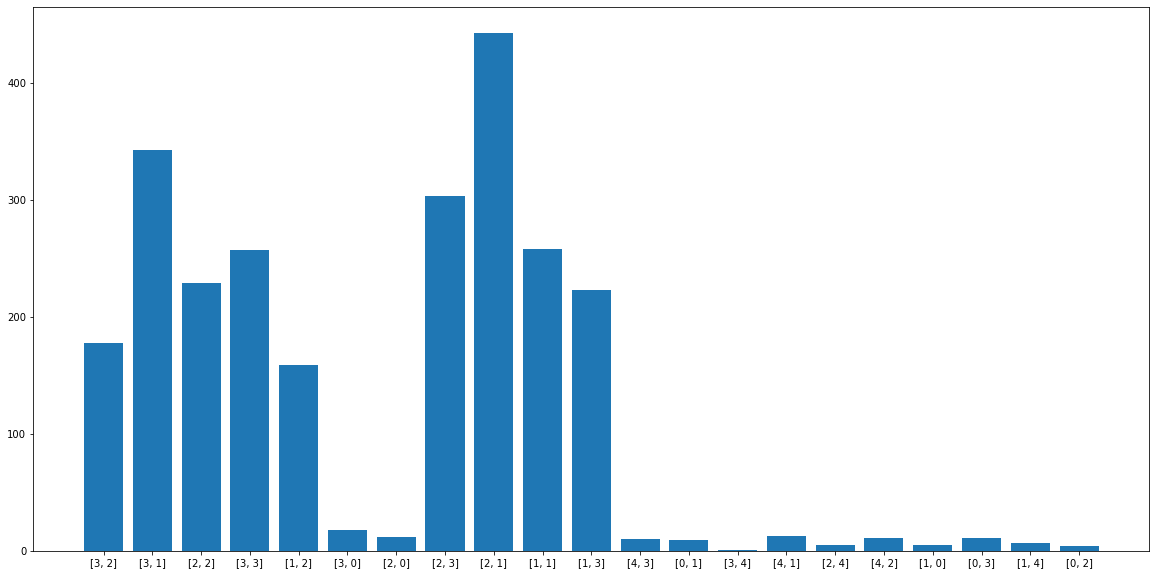

Processing Epoch 80
training start
Iteration 0, d real/fake loss 0.6352226138114929/0.6927126049995422 and g loss is 0.6940440535545349, NDiv loss 0.04351328685879707
Iteration 1, d real/fake loss 0.6350959539413452/0.691165030002594 and g loss is 0.6982026696205139, NDiv loss 0.04547448456287384
Iteration 2, d real/fake loss 0.6349639296531677/0.6927958726882935 and g loss is 0.7003943920135498, NDiv loss 0.043179068714380264
Iteration 3, d real/fake loss 0.6348187327384949/0.6898859143257141 and g loss is 0.6980769634246826, NDiv loss 0.04626466706395149
Iteration 4, d real/fake loss 0.6346595287322998/0.6905803680419922 and g loss is 0.7008675336837769, NDiv loss 0.04333783686161041


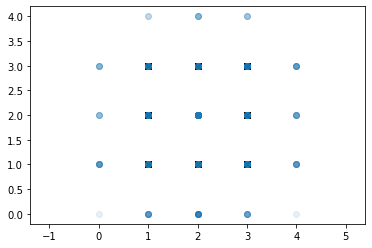

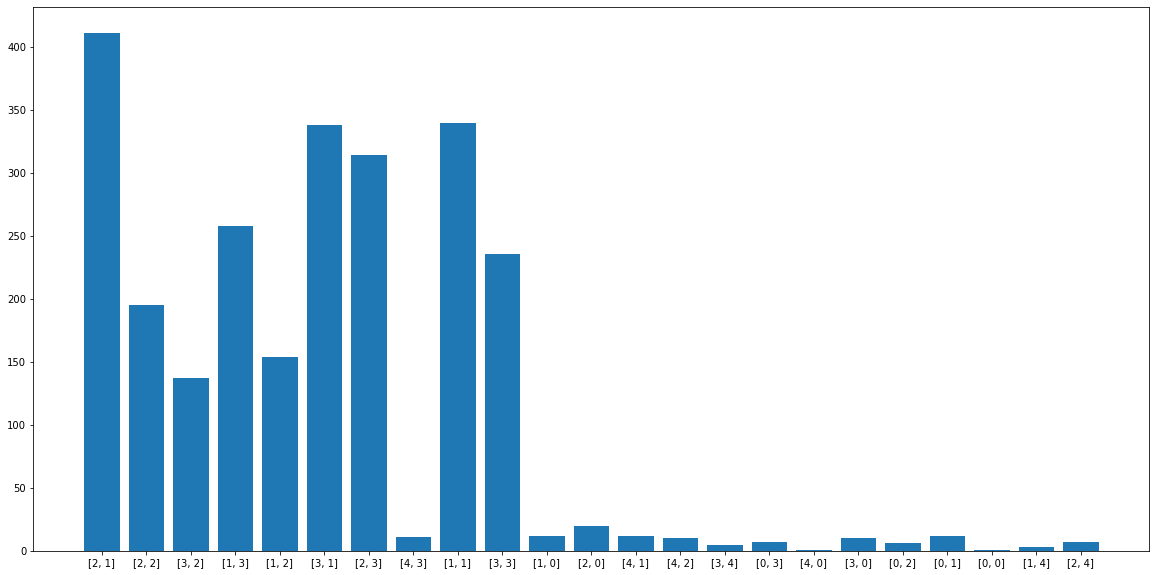

Processing Epoch 81
training start
Iteration 0, d real/fake loss 0.6351119875907898/0.6899641752243042 and g loss is 0.6977612972259521, NDiv loss 0.045907411724328995
Iteration 1, d real/fake loss 0.6349993348121643/0.6857540607452393 and g loss is 0.7004469633102417, NDiv loss 0.04449571296572685
Iteration 2, d real/fake loss 0.6348839998245239/0.6874479651451111 and g loss is 0.7026145458221436, NDiv loss 0.045522335916757584
Iteration 3, d real/fake loss 0.634765625/0.6910481452941895 and g loss is 0.6988775730133057, NDiv loss 0.044372327625751495
Iteration 4, d real/fake loss 0.6346418261528015/0.6832789182662964 and g loss is 0.6981506943702698, NDiv loss 0.042962100356817245


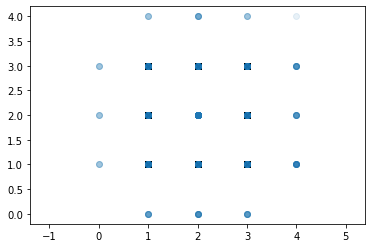

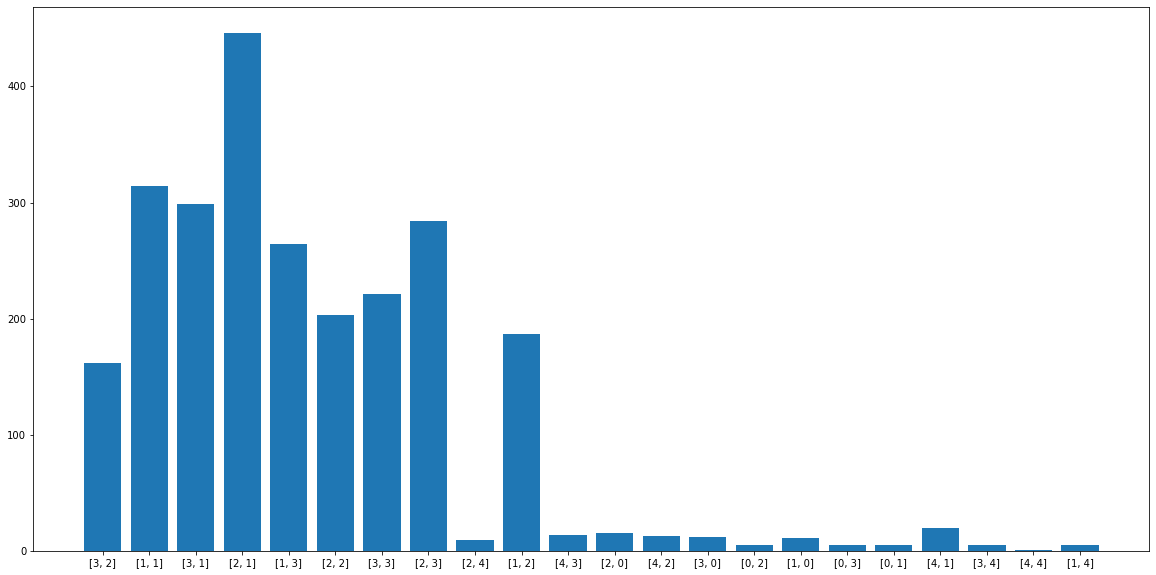

Processing Epoch 82
training start
Iteration 0, d real/fake loss 0.6335930824279785/0.6875876188278198 and g loss is 0.699393093585968, NDiv loss 0.04245851933956146
Iteration 1, d real/fake loss 0.6335597038269043/0.684555172920227 and g loss is 0.7007824182510376, NDiv loss 0.04538944363594055
Iteration 2, d real/fake loss 0.633507251739502/0.6853100657463074 and g loss is 0.7007420659065247, NDiv loss 0.043435849249362946
Iteration 3, d real/fake loss 0.6334424018859863/0.689157247543335 and g loss is 0.7011685371398926, NDiv loss 0.04526986554265022
Iteration 4, d real/fake loss 0.6333728432655334/0.6893787384033203 and g loss is 0.7035076022148132, NDiv loss 0.04474988207221031


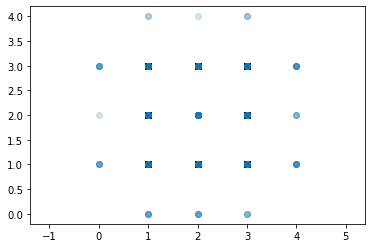

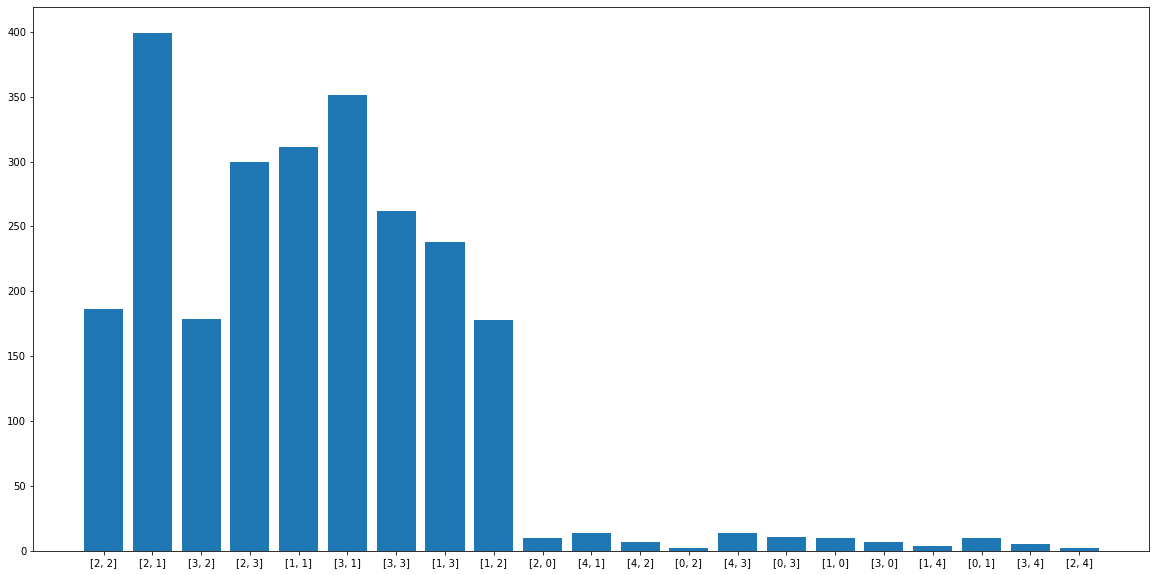

Processing Epoch 83
training start
Iteration 0, d real/fake loss 0.6318612098693848/0.6869384050369263 and g loss is 0.6991070508956909, NDiv loss 0.04354780167341232
Iteration 1, d real/fake loss 0.6317470669746399/0.6871864199638367 and g loss is 0.7019317150115967, NDiv loss 0.04353824257850647
Iteration 2, d real/fake loss 0.6316391229629517/0.6862843036651611 and g loss is 0.700084388256073, NDiv loss 0.04463595896959305
Iteration 3, d real/fake loss 0.6315376162528992/0.6837193369865417 and g loss is 0.7011650800704956, NDiv loss 0.044898394495248795
Iteration 4, d real/fake loss 0.6314350962638855/0.6870394349098206 and g loss is 0.7008202075958252, NDiv loss 0.04674772918224335


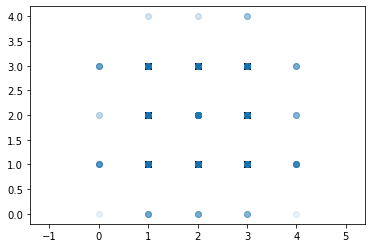

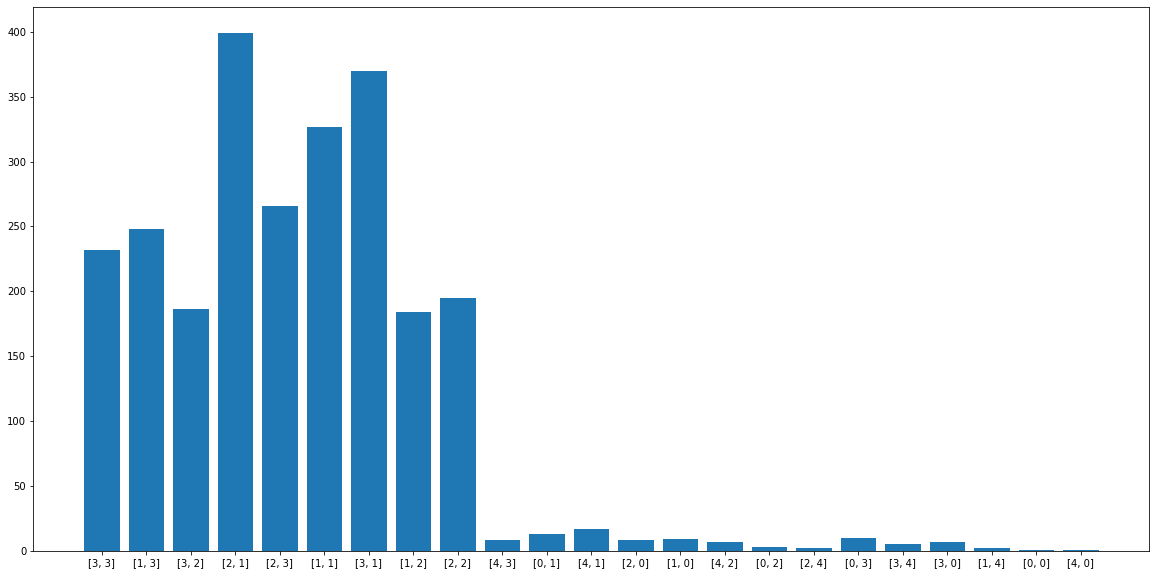

Processing Epoch 84
training start
Iteration 0, d real/fake loss 0.633625864982605/0.6867842674255371 and g loss is 0.7008017301559448, NDiv loss 0.04641461372375488
Iteration 1, d real/fake loss 0.6335666179656982/0.6860158443450928 and g loss is 0.7010155916213989, NDiv loss 0.044500481337308884
Iteration 2, d real/fake loss 0.6335017681121826/0.6903837323188782 and g loss is 0.6997693777084351, NDiv loss 0.04514923691749573
Iteration 3, d real/fake loss 0.6334426403045654/0.6820840835571289 and g loss is 0.6981860995292664, NDiv loss 0.04446778446435928
Iteration 4, d real/fake loss 0.6333820223808289/0.6901002526283264 and g loss is 0.7014690637588501, NDiv loss 0.04732411354780197


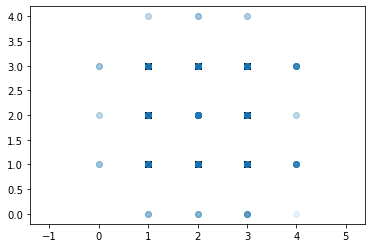

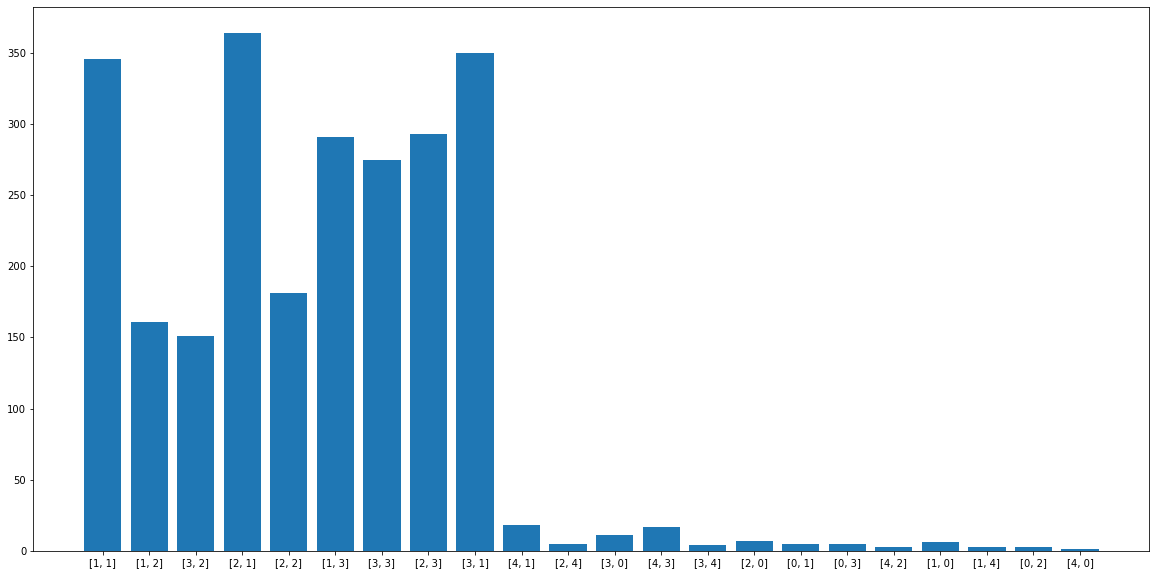

Processing Epoch 85
training start
Iteration 0, d real/fake loss 0.6306847333908081/0.6846122741699219 and g loss is 0.695404052734375, NDiv loss 0.04382014647126198
Iteration 1, d real/fake loss 0.6305835247039795/0.6841686964035034 and g loss is 0.6977671384811401, NDiv loss 0.043188951909542084
Iteration 2, d real/fake loss 0.6304760575294495/0.6887636780738831 and g loss is 0.701316773891449, NDiv loss 0.04741040617227554
Iteration 3, d real/fake loss 0.6303684711456299/0.6834114789962769 and g loss is 0.6983935832977295, NDiv loss 0.0487588569521904
Iteration 4, d real/fake loss 0.6302511096000671/0.6892927885055542 and g loss is 0.704391598701477, NDiv loss 0.043767768889665604


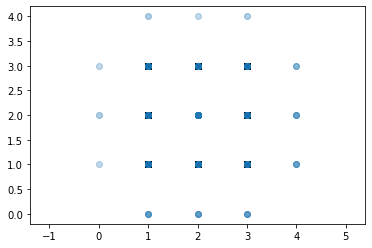

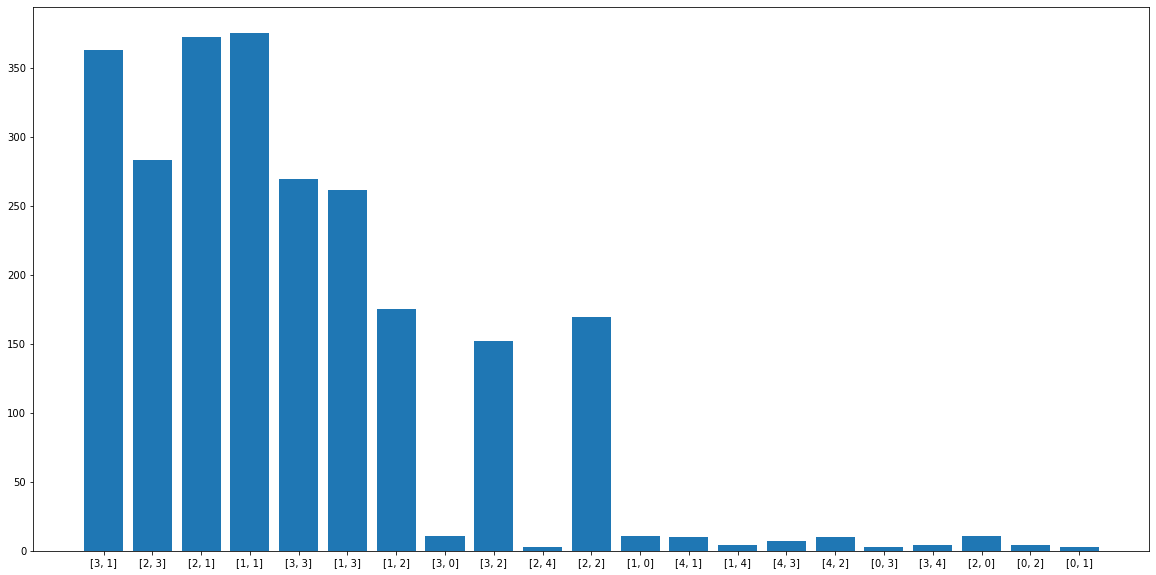

Processing Epoch 86
training start
Iteration 0, d real/fake loss 0.6315400004386902/0.6885253190994263 and g loss is 0.7015565037727356, NDiv loss 0.04528465121984482
Iteration 1, d real/fake loss 0.631479799747467/0.6841572523117065 and g loss is 0.700480580329895, NDiv loss 0.04251136630773544
Iteration 2, d real/fake loss 0.6314182877540588/0.6858495473861694 and g loss is 0.6949225664138794, NDiv loss 0.04434550181031227
Iteration 3, d real/fake loss 0.6313585042953491/0.6876780390739441 and g loss is 0.7015478014945984, NDiv loss 0.04648677259683609
Iteration 4, d real/fake loss 0.6313032507896423/0.6853346824645996 and g loss is 0.7037051916122437, NDiv loss 0.04294218495488167


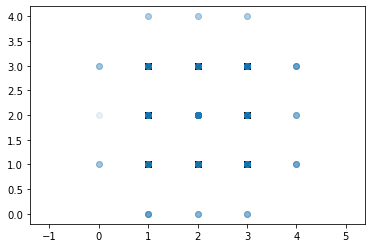

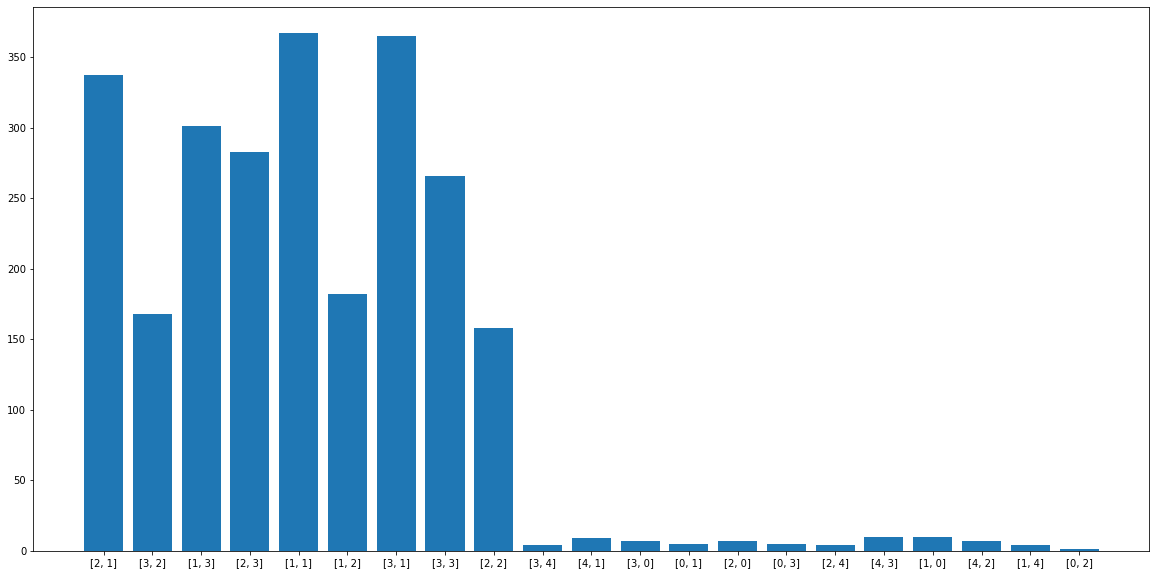

Processing Epoch 87
training start
Iteration 0, d real/fake loss 0.6316932439804077/0.6841748952865601 and g loss is 0.6931127309799194, NDiv loss 0.04477819427847862
Iteration 1, d real/fake loss 0.6315876841545105/0.6898961067199707 and g loss is 0.6988824605941772, NDiv loss 0.04490538686513901
Iteration 2, d real/fake loss 0.6314774751663208/0.6834439635276794 and g loss is 0.7019789218902588, NDiv loss 0.04697839170694351
Iteration 3, d real/fake loss 0.6313489675521851/0.6846976280212402 and g loss is 0.7009351253509521, NDiv loss 0.04668319225311279
Iteration 4, d real/fake loss 0.6312077045440674/0.6894067525863647 and g loss is 0.70258629322052, NDiv loss 0.04794984683394432


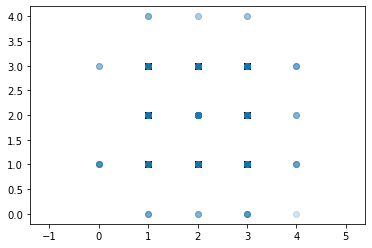

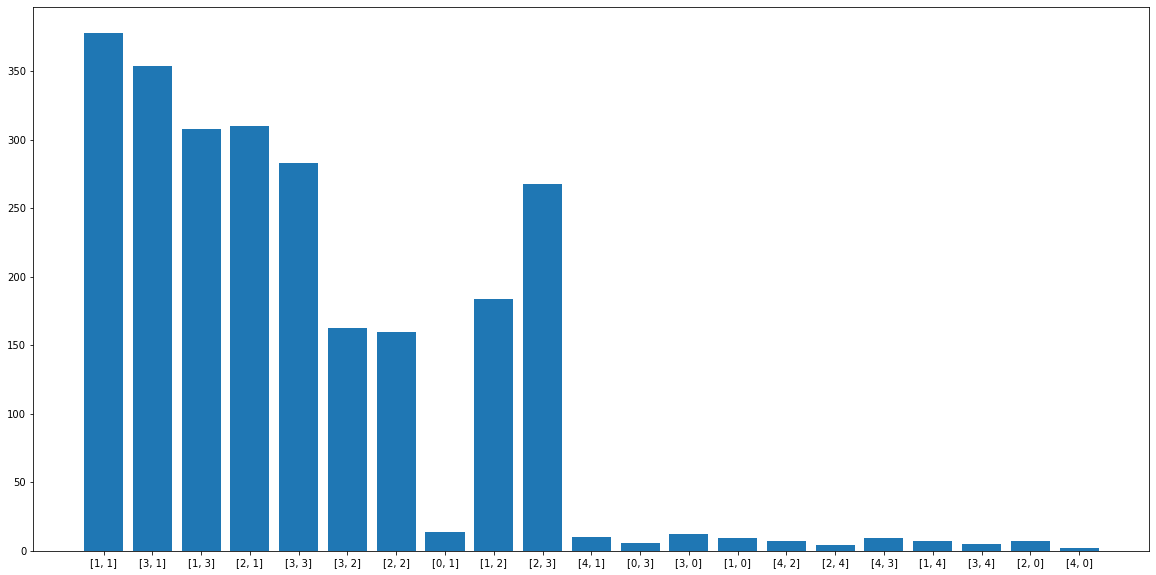

Processing Epoch 88
training start
Iteration 0, d real/fake loss 0.6284821033477783/0.6850975751876831 and g loss is 0.7007684707641602, NDiv loss 0.04364481568336487
Iteration 1, d real/fake loss 0.6283810138702393/0.687653124332428 and g loss is 0.7033953070640564, NDiv loss 0.044940751045942307
Iteration 2, d real/fake loss 0.6282833814620972/0.6881399154663086 and g loss is 0.7014750242233276, NDiv loss 0.0485701821744442
Iteration 3, d real/fake loss 0.6281927824020386/0.6845878958702087 and g loss is 0.702336311340332, NDiv loss 0.046012405306100845
Iteration 4, d real/fake loss 0.6281027793884277/0.6800056099891663 and g loss is 0.7019285559654236, NDiv loss 0.044396549463272095


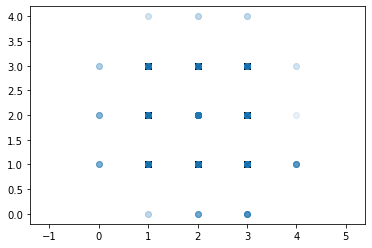

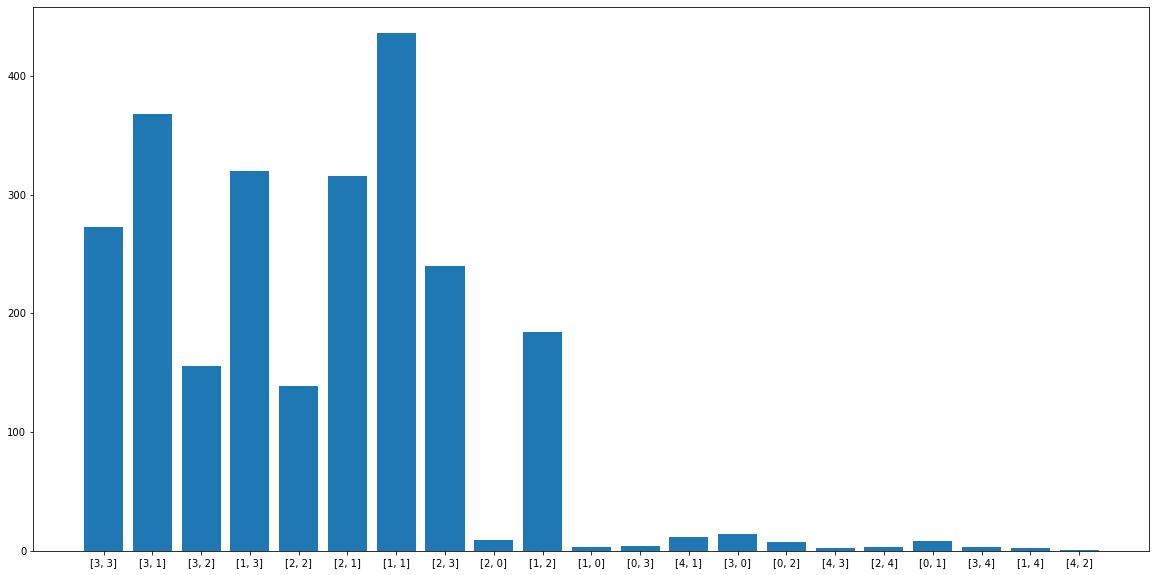

Processing Epoch 89
training start
Iteration 0, d real/fake loss 0.6280792951583862/0.6828427314758301 and g loss is 0.7028495073318481, NDiv loss 0.04790568724274635
Iteration 1, d real/fake loss 0.6279667615890503/0.6832135915756226 and g loss is 0.7015889883041382, NDiv loss 0.043679315596818924
Iteration 2, d real/fake loss 0.6278507709503174/0.6848647594451904 and g loss is 0.7001711130142212, NDiv loss 0.04630529135465622
Iteration 3, d real/fake loss 0.6277369260787964/0.684559166431427 and g loss is 0.701783299446106, NDiv loss 0.047588493674993515
Iteration 4, d real/fake loss 0.6276217699050903/0.6856788992881775 and g loss is 0.703764796257019, NDiv loss 0.04586459696292877


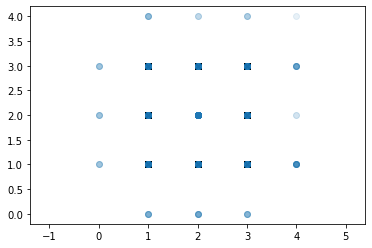

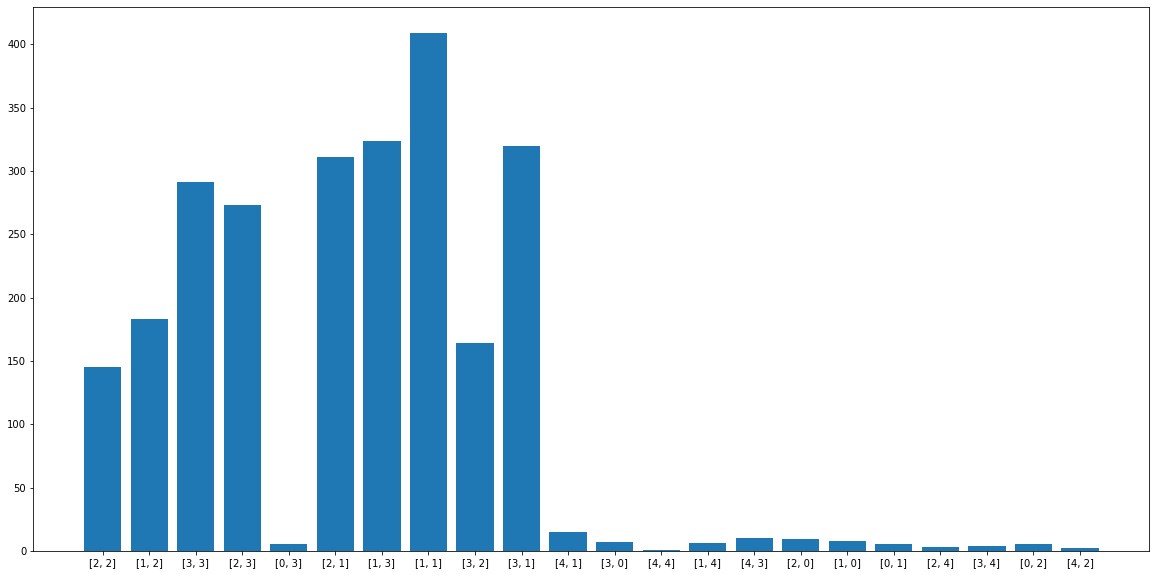

Processing Epoch 90
training start
Iteration 0, d real/fake loss 0.6292389631271362/0.6872973442077637 and g loss is 0.7021489143371582, NDiv loss 0.044443950057029724
Iteration 1, d real/fake loss 0.6291544437408447/0.6907296776771545 and g loss is 0.7011680006980896, NDiv loss 0.04617535322904587
Iteration 2, d real/fake loss 0.6290894746780396/0.6853657960891724 and g loss is 0.6995981335639954, NDiv loss 0.04800121858716011
Iteration 3, d real/fake loss 0.6290311813354492/0.6867238283157349 and g loss is 0.7017292380332947, NDiv loss 0.04630248248577118
Iteration 4, d real/fake loss 0.6289733052253723/0.6879062652587891 and g loss is 0.6971241235733032, NDiv loss 0.046150173991918564


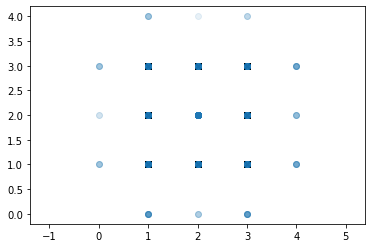

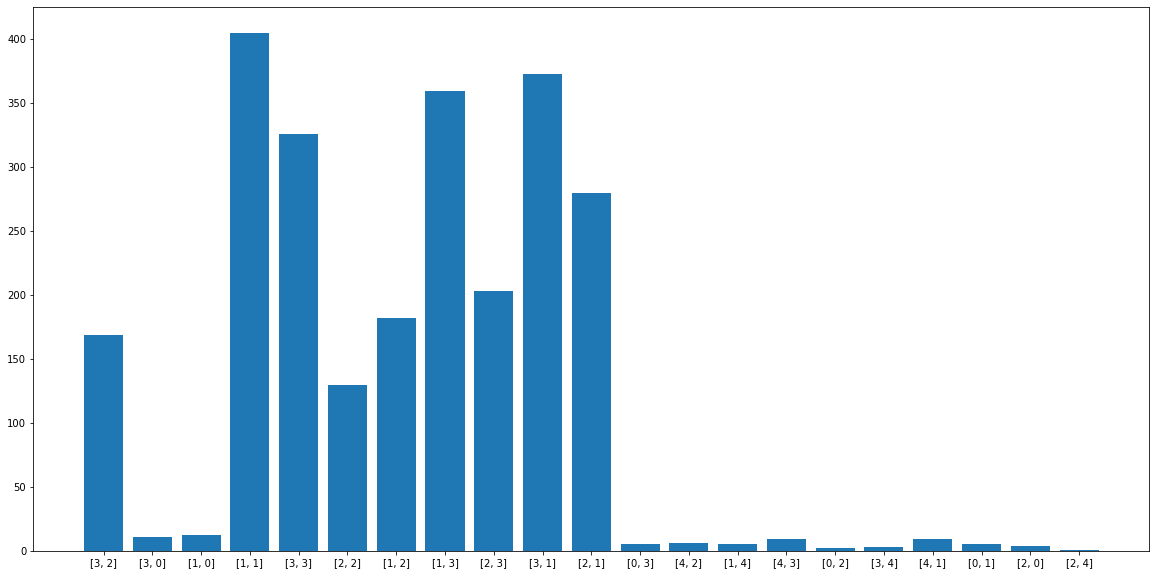

Processing Epoch 91
training start
Iteration 0, d real/fake loss 0.6279964447021484/0.6850264072418213 and g loss is 0.6969366669654846, NDiv loss 0.04508506879210472
Iteration 1, d real/fake loss 0.6279443502426147/0.6876498460769653 and g loss is 0.7013072371482849, NDiv loss 0.04577594995498657
Iteration 2, d real/fake loss 0.6278944611549377/0.6882607936859131 and g loss is 0.7029184103012085, NDiv loss 0.04475703462958336
Iteration 3, d real/fake loss 0.6278519034385681/0.6837454438209534 and g loss is 0.6988182067871094, NDiv loss 0.04729059711098671
Iteration 4, d real/fake loss 0.6278045177459717/0.6866368055343628 and g loss is 0.7002593278884888, NDiv loss 0.04747847840189934


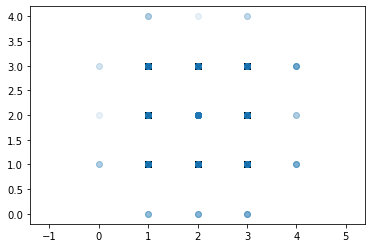

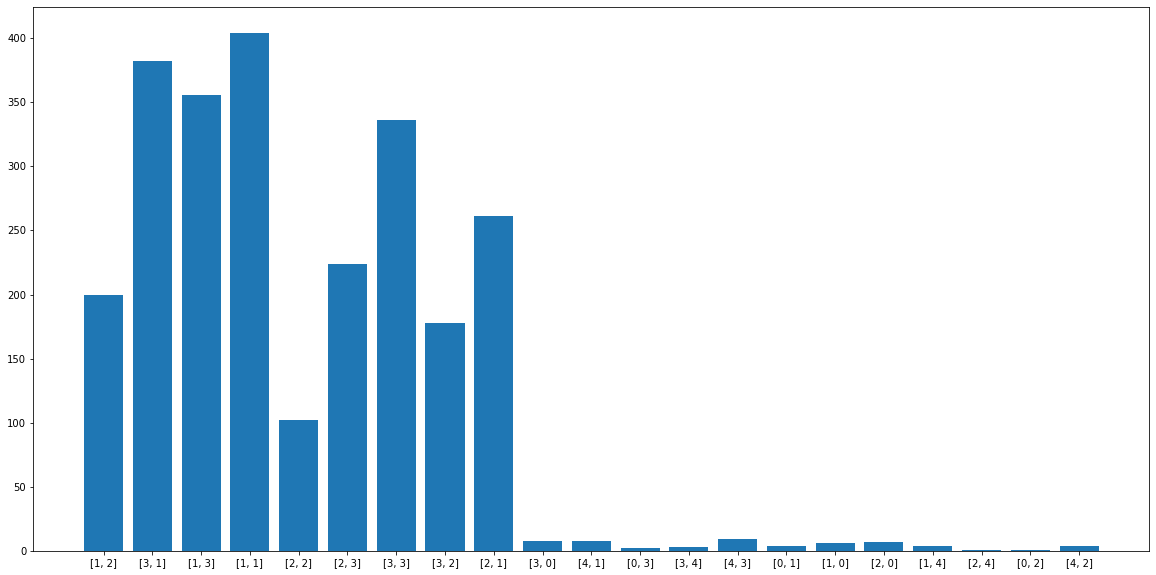

Processing Epoch 92
training start
Iteration 0, d real/fake loss 0.626915693283081/0.6835286617279053 and g loss is 0.7029677629470825, NDiv loss 0.04458735138177872
Iteration 1, d real/fake loss 0.6268936395645142/0.6801915168762207 and g loss is 0.6952913999557495, NDiv loss 0.04653896018862724
Iteration 2, d real/fake loss 0.6268641948699951/0.6868881583213806 and g loss is 0.6950883269309998, NDiv loss 0.04833711311221123
Iteration 3, d real/fake loss 0.6268413066864014/0.6877729892730713 and g loss is 0.7017213106155396, NDiv loss 0.04785977676510811
Iteration 4, d real/fake loss 0.6268283128738403/0.6849623918533325 and g loss is 0.7027345895767212, NDiv loss 0.0454457551240921


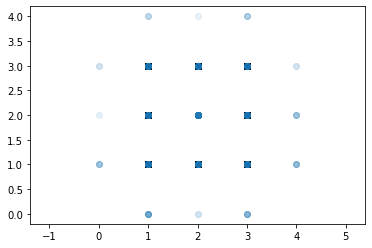

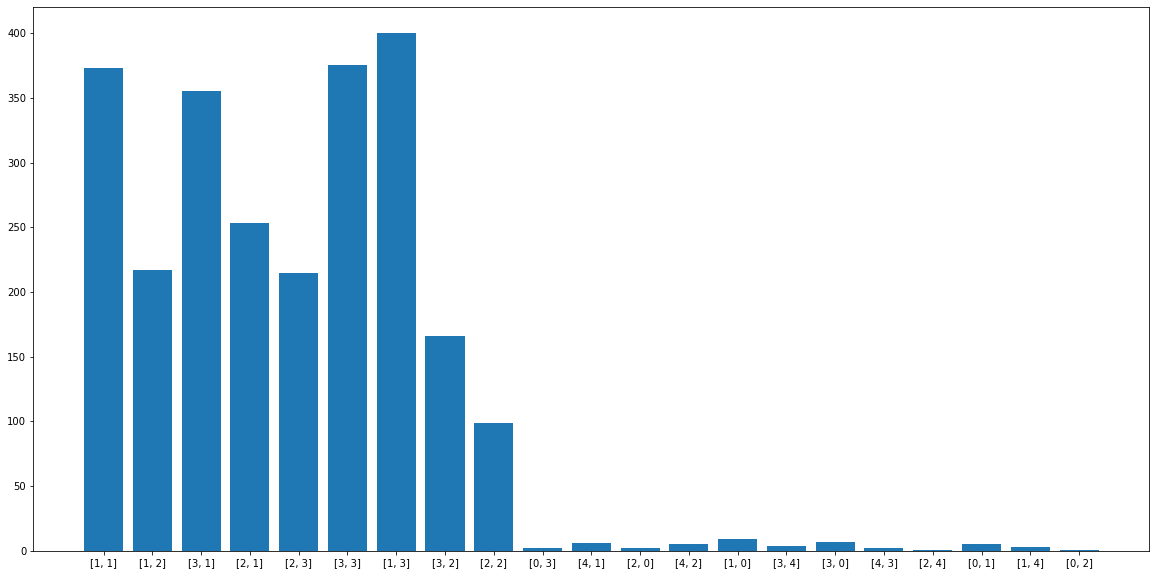

Processing Epoch 93
training start
Iteration 0, d real/fake loss 0.6272369027137756/0.690327525138855 and g loss is 0.6981527209281921, NDiv loss 0.04939120262861252
Iteration 1, d real/fake loss 0.6272320747375488/0.6884565353393555 and g loss is 0.7027722597122192, NDiv loss 0.04696040600538254
Iteration 2, d real/fake loss 0.6272354125976562/0.6898240447044373 and g loss is 0.7002595067024231, NDiv loss 0.04707802087068558
Iteration 3, d real/fake loss 0.6272442936897278/0.6849085688591003 and g loss is 0.7009674310684204, NDiv loss 0.044046081602573395
Iteration 4, d real/fake loss 0.6272485256195068/0.6868940591812134 and g loss is 0.701413631439209, NDiv loss 0.04794836789369583


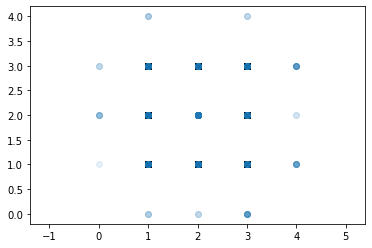

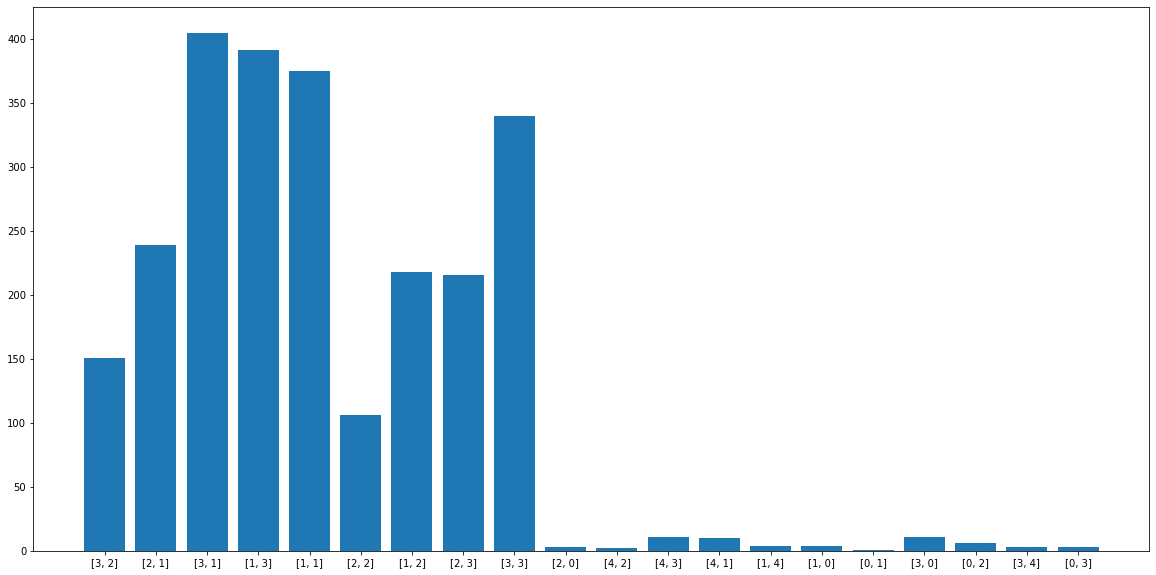

Processing Epoch 94
training start
Iteration 0, d real/fake loss 0.6312795877456665/0.6888594031333923 and g loss is 0.7040030360221863, NDiv loss 0.04674547538161278
Iteration 1, d real/fake loss 0.6313315033912659/0.6889464259147644 and g loss is 0.703952968120575, NDiv loss 0.047027189284563065
Iteration 2, d real/fake loss 0.6313825249671936/0.6826488971710205 and g loss is 0.7038621306419373, NDiv loss 0.04909748211503029
Iteration 3, d real/fake loss 0.6314250230789185/0.6864479780197144 and g loss is 0.7026084661483765, NDiv loss 0.05023513361811638
Iteration 4, d real/fake loss 0.6314573884010315/0.684251070022583 and g loss is 0.7047154903411865, NDiv loss 0.05101330578327179


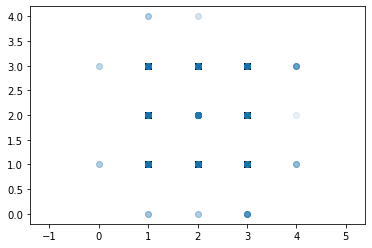

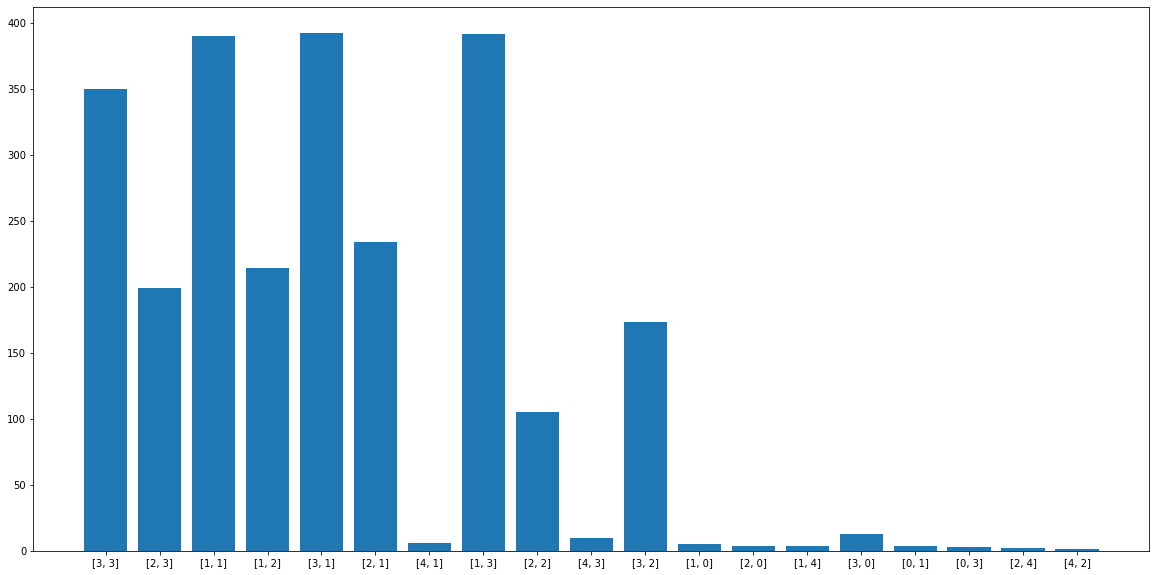

Processing Epoch 95
training start
Iteration 0, d real/fake loss 0.6274945735931396/0.6833306550979614 and g loss is 0.6986912488937378, NDiv loss 0.04870728403329849
Iteration 1, d real/fake loss 0.6275315284729004/0.6840782761573792 and g loss is 0.6996797919273376, NDiv loss 0.04811043292284012
Iteration 2, d real/fake loss 0.6275677680969238/0.6837440729141235 and g loss is 0.7080235481262207, NDiv loss 0.04753628000617027
Iteration 3, d real/fake loss 0.6275976896286011/0.6860858798027039 and g loss is 0.7046597003936768, NDiv loss 0.04775520786643028
Iteration 4, d real/fake loss 0.6276240348815918/0.6852554678916931 and g loss is 0.7087340354919434, NDiv loss 0.048272505402565


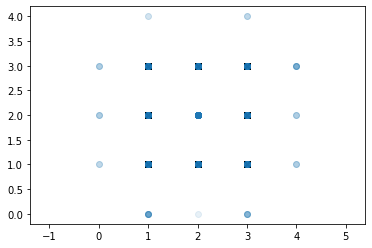

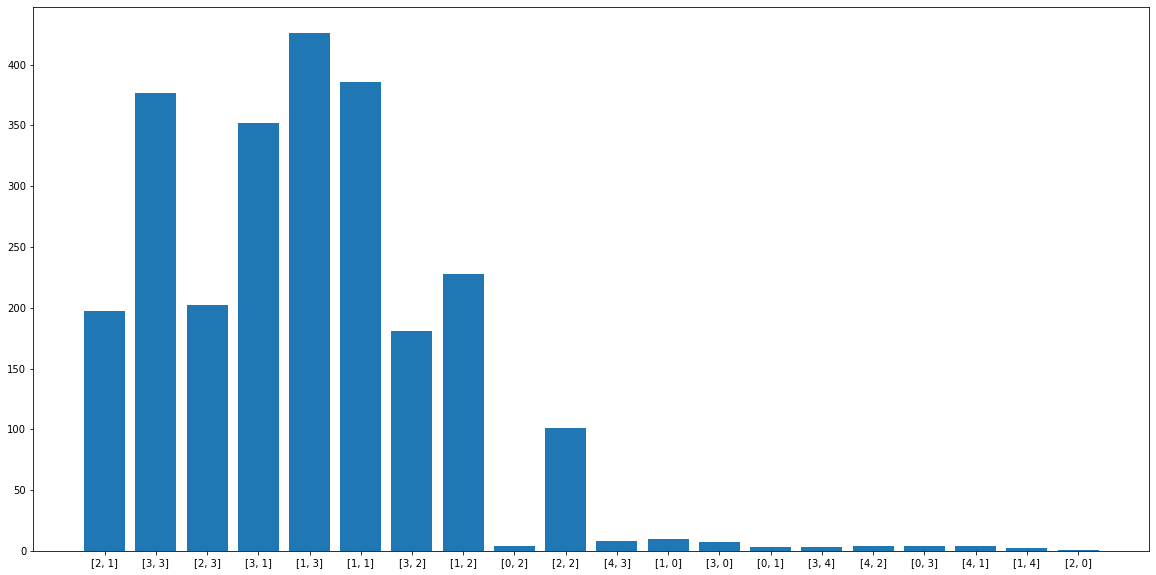

Processing Epoch 96
training start
Iteration 0, d real/fake loss 0.6277181506156921/0.6838527321815491 and g loss is 0.7017074227333069, NDiv loss 0.048721253871917725
Iteration 1, d real/fake loss 0.627765417098999/0.682070255279541 and g loss is 0.7053346037864685, NDiv loss 0.045582663267850876
Iteration 2, d real/fake loss 0.6278012990951538/0.6825573444366455 and g loss is 0.7036166787147522, NDiv loss 0.043504491448402405
Iteration 3, d real/fake loss 0.6278314590454102/0.6793004274368286 and g loss is 0.7006109952926636, NDiv loss 0.04440878704190254
Iteration 4, d real/fake loss 0.6278502941131592/0.6834580898284912 and g loss is 0.7051398754119873, NDiv loss 0.047135740518569946


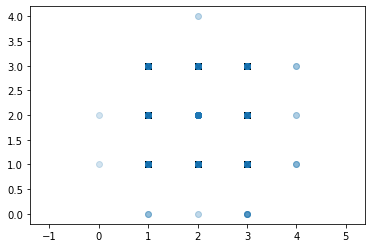

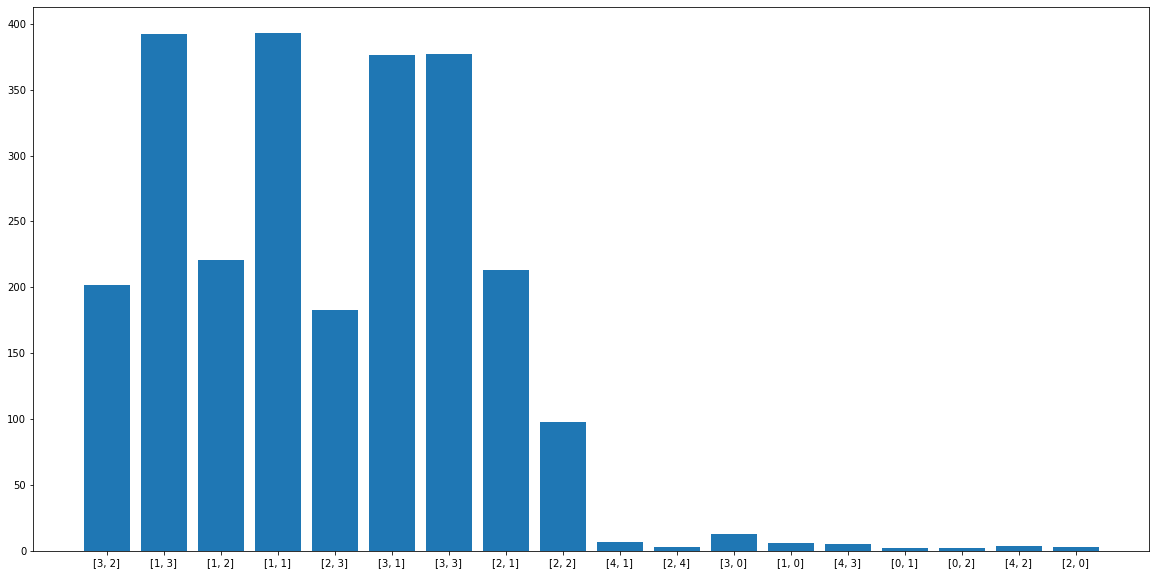

Processing Epoch 97
training start
Iteration 0, d real/fake loss 0.6283908486366272/0.6848122477531433 and g loss is 0.7029613256454468, NDiv loss 0.05101042985916138
Iteration 1, d real/fake loss 0.6284236907958984/0.6841480731964111 and g loss is 0.7052509784698486, NDiv loss 0.049819353967905045
Iteration 2, d real/fake loss 0.6284545660018921/0.687494158744812 and g loss is 0.7032972574234009, NDiv loss 0.05093550309538841
Iteration 3, d real/fake loss 0.628497302532196/0.6806012392044067 and g loss is 0.7087941765785217, NDiv loss 0.04504471272230148
Iteration 4, d real/fake loss 0.6285355091094971/0.6803112030029297 and g loss is 0.7035903930664062, NDiv loss 0.04734176769852638


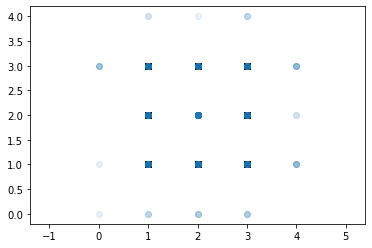

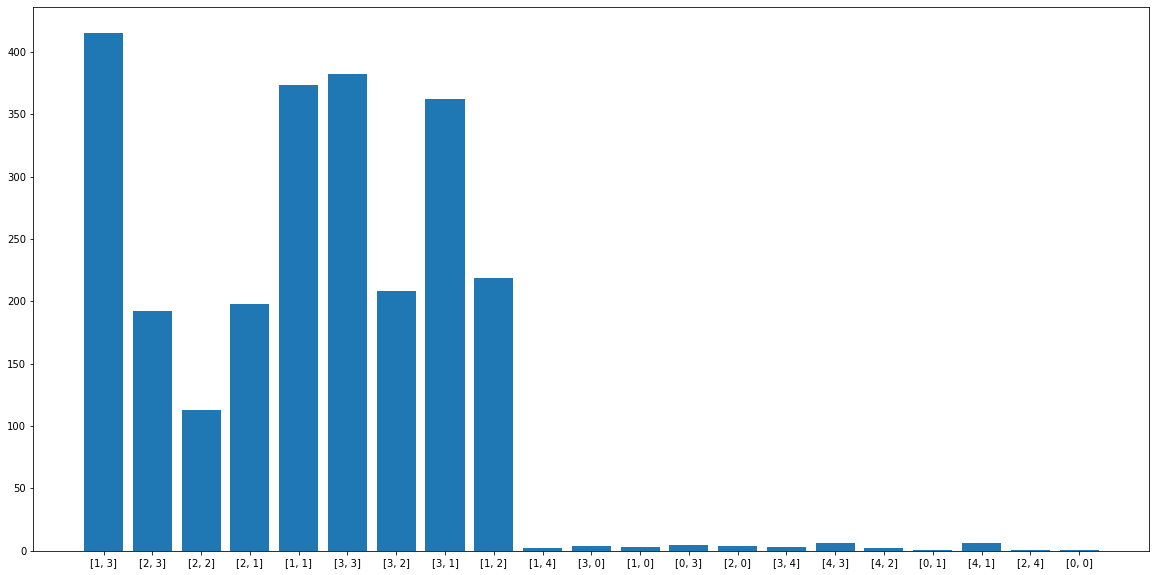

Processing Epoch 98
training start
Iteration 0, d real/fake loss 0.6313475966453552/0.6848894357681274 and g loss is 0.7002018690109253, NDiv loss 0.04563894122838974
Iteration 1, d real/fake loss 0.6313906311988831/0.6844847202301025 and g loss is 0.7062020301818848, NDiv loss 0.04773358255624771
Iteration 2, d real/fake loss 0.6314382553100586/0.6804318428039551 and g loss is 0.7086166143417358, NDiv loss 0.05085532367229462
Iteration 3, d real/fake loss 0.6314826011657715/0.6823248863220215 and g loss is 0.7036874294281006, NDiv loss 0.04869261384010315
Iteration 4, d real/fake loss 0.6315240859985352/0.6820185780525208 and g loss is 0.707767128944397, NDiv loss 0.04555033519864082


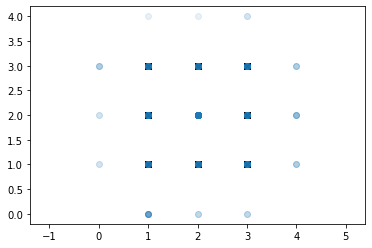

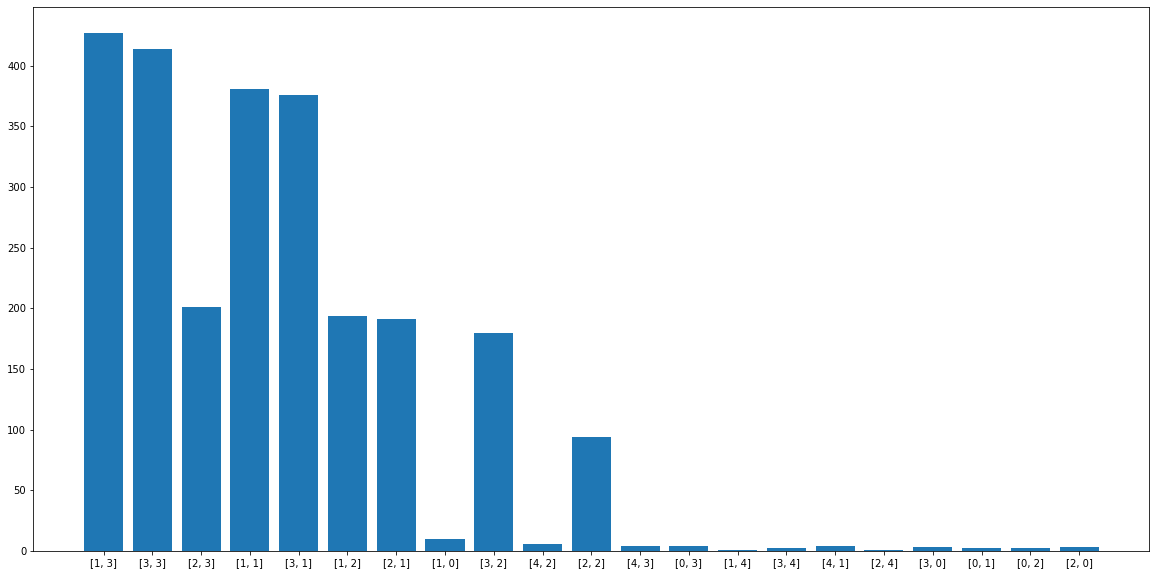

Processing Epoch 99
training start
Iteration 0, d real/fake loss 0.6284679174423218/0.6811295747756958 and g loss is 0.7042573690414429, NDiv loss 0.049747515469789505
Iteration 1, d real/fake loss 0.6285208463668823/0.6762318015098572 and g loss is 0.70435631275177, NDiv loss 0.0474340058863163
Iteration 2, d real/fake loss 0.6285627484321594/0.6780225038528442 and g loss is 0.706798791885376, NDiv loss 0.04754262790083885
Iteration 3, d real/fake loss 0.6285955905914307/0.6803246140480042 and g loss is 0.7084066867828369, NDiv loss 0.05138451233506203
Iteration 4, d real/fake loss 0.6286299228668213/0.6801528930664062 and g loss is 0.7067246437072754, NDiv loss 0.04763144999742508


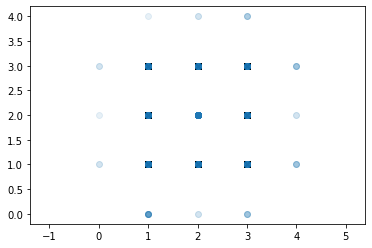

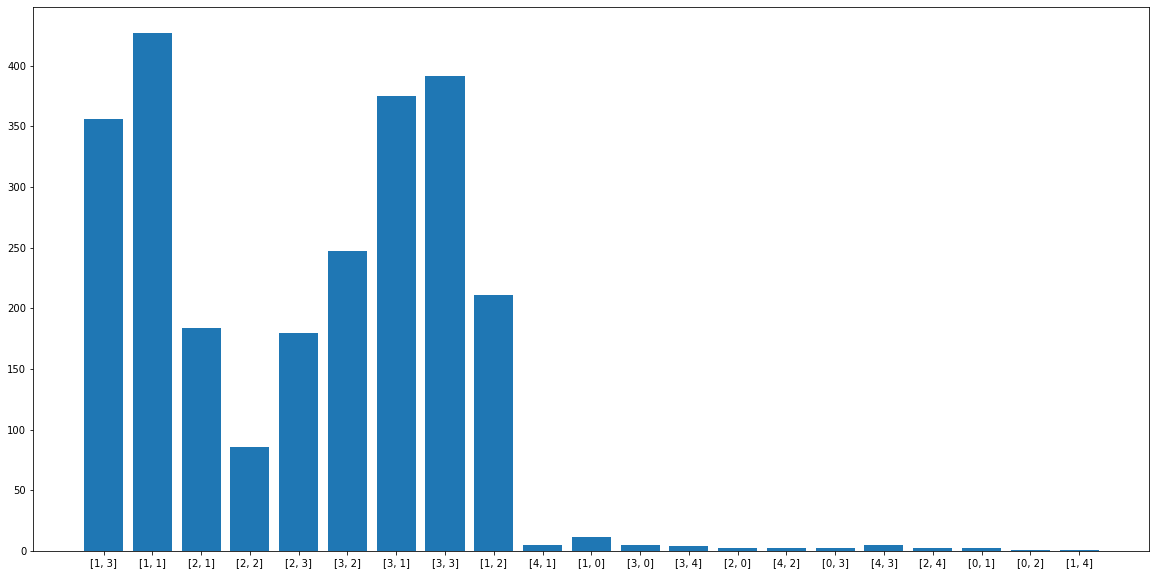

Processing Epoch 100
training start
Iteration 0, d real/fake loss 0.6292485594749451/0.6784853935241699 and g loss is 0.7071415185928345, NDiv loss 0.04649770259857178
Iteration 1, d real/fake loss 0.6293068528175354/0.6786197423934937 and g loss is 0.709029495716095, NDiv loss 0.04820950701832771
Iteration 2, d real/fake loss 0.6293530464172363/0.677577793598175 and g loss is 0.707650363445282, NDiv loss 0.047314103692770004
Iteration 3, d real/fake loss 0.6293762922286987/0.6757197380065918 and g loss is 0.7120298743247986, NDiv loss 0.047470107674598694
Iteration 4, d real/fake loss 0.6293847560882568/0.6814271211624146 and g loss is 0.7134770154953003, NDiv loss 0.048873420804739


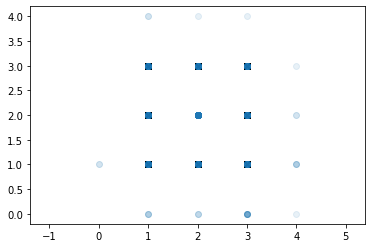

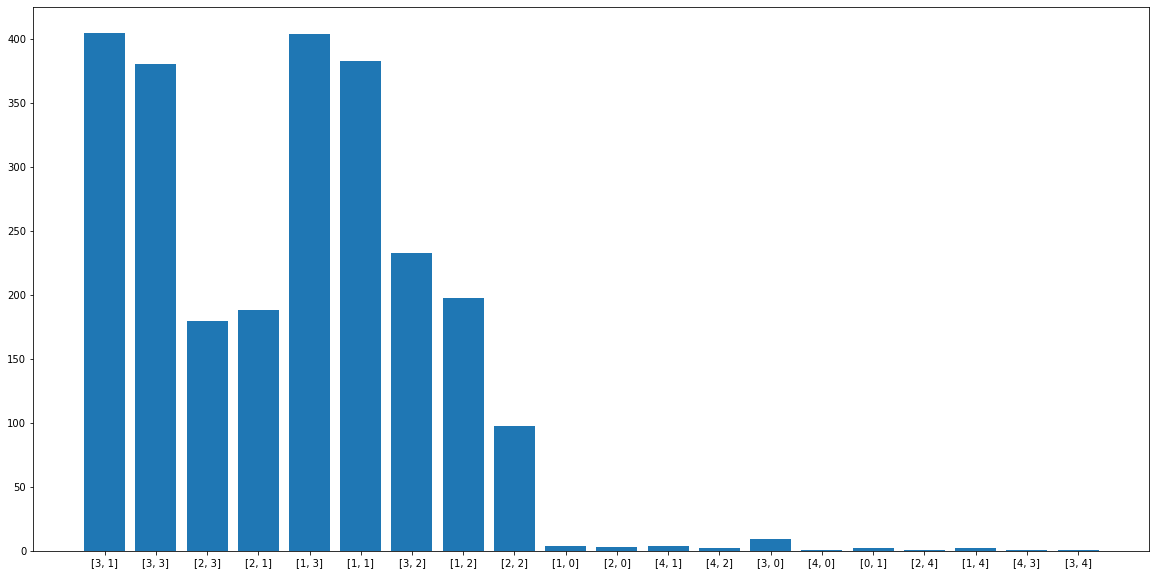

Processing Epoch 101
training start
Iteration 0, d real/fake loss 0.6291383504867554/0.6800017952919006 and g loss is 0.709062933921814, NDiv loss 0.04908550903201103
Iteration 1, d real/fake loss 0.629158616065979/0.675805926322937 and g loss is 0.7087808847427368, NDiv loss 0.046768445521593094
Iteration 2, d real/fake loss 0.6291676163673401/0.6798195242881775 and g loss is 0.7058590650558472, NDiv loss 0.045891884714365005
Iteration 3, d real/fake loss 0.6291735172271729/0.6763017177581787 and g loss is 0.7107429504394531, NDiv loss 0.048703040927648544
Iteration 4, d real/fake loss 0.6291635036468506/0.6761107444763184 and g loss is 0.7082785964012146, NDiv loss 0.049718983471393585


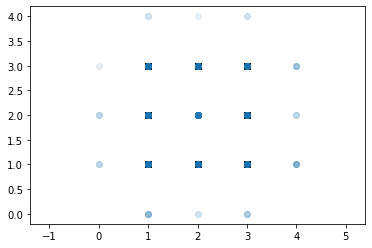

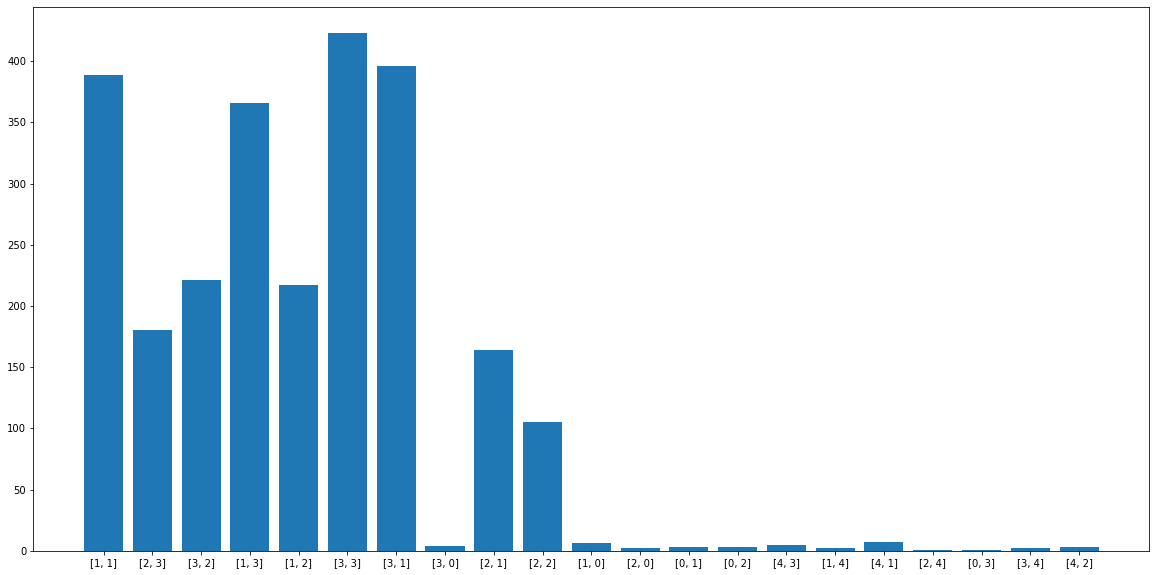

Processing Epoch 102
training start
Iteration 0, d real/fake loss 0.62800133228302/0.6802855730056763 and g loss is 0.7100595831871033, NDiv loss 0.049274787306785583
Iteration 1, d real/fake loss 0.627984881401062/0.673612117767334 and g loss is 0.7075364589691162, NDiv loss 0.04642120748758316
Iteration 2, d real/fake loss 0.6279597878456116/0.6787790656089783 and g loss is 0.7131162285804749, NDiv loss 0.049924299120903015
Iteration 3, d real/fake loss 0.6279395818710327/0.6732534170150757 and g loss is 0.7081452012062073, NDiv loss 0.04822274670004845
Iteration 4, d real/fake loss 0.6279129981994629/0.678513765335083 and g loss is 0.7052264213562012, NDiv loss 0.050235532224178314


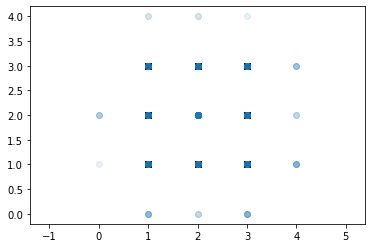

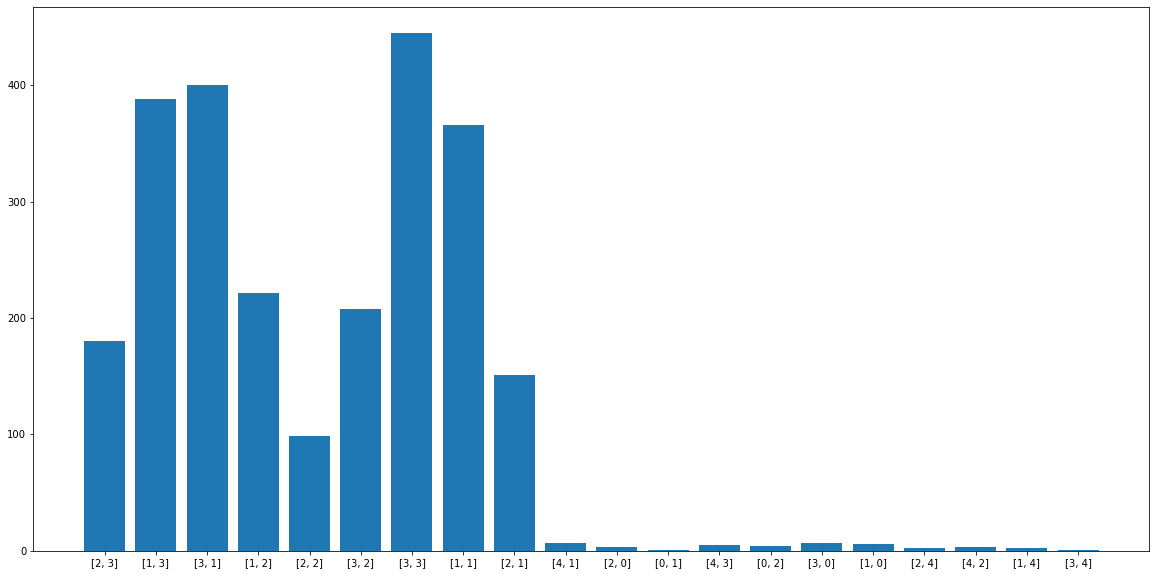

Processing Epoch 103
training start
Iteration 0, d real/fake loss 0.6315316557884216/0.6761956810951233 and g loss is 0.7134556770324707, NDiv loss 0.04624573141336441
Iteration 1, d real/fake loss 0.6315394639968872/0.6777852773666382 and g loss is 0.7101566791534424, NDiv loss 0.04941944405436516
Iteration 2, d real/fake loss 0.6315339803695679/0.6774495840072632 and g loss is 0.7061089277267456, NDiv loss 0.04809616133570671
Iteration 3, d real/fake loss 0.6315242052078247/0.6780783534049988 and g loss is 0.7111213207244873, NDiv loss 0.04534638673067093
Iteration 4, d real/fake loss 0.6315124034881592/0.6770142316818237 and g loss is 0.7059816718101501, NDiv loss 0.04769292101264


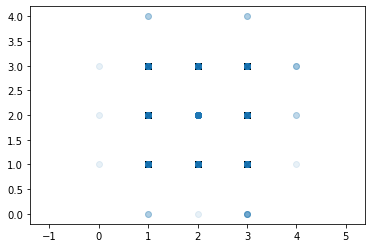

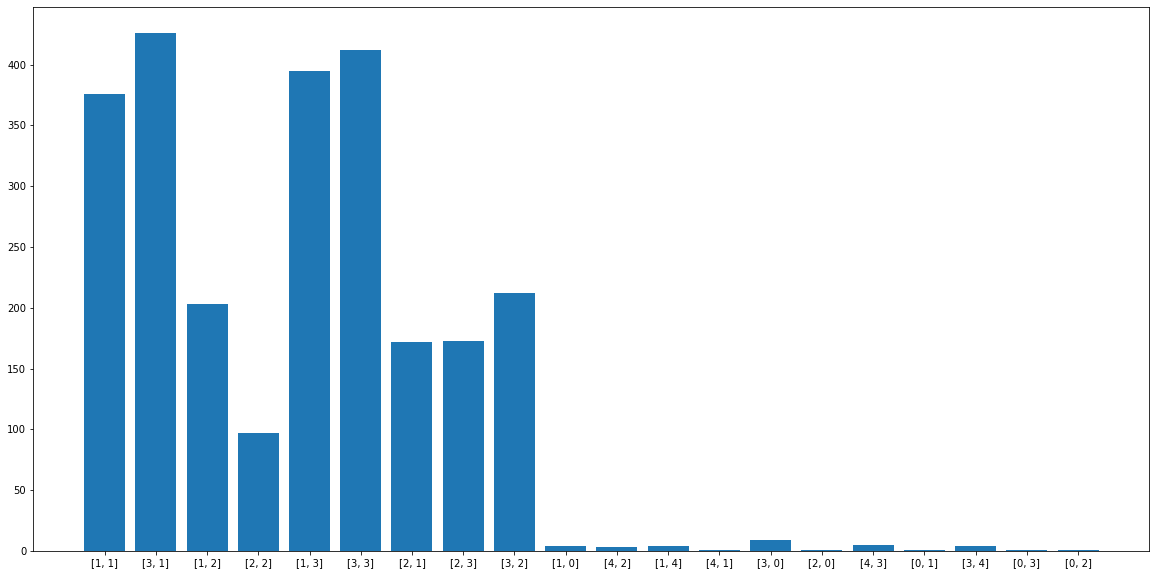

Processing Epoch 104
training start
Iteration 0, d real/fake loss 0.6275745034217834/0.6773843765258789 and g loss is 0.7126373052597046, NDiv loss 0.04892772436141968
Iteration 1, d real/fake loss 0.6275754570960999/0.6728980541229248 and g loss is 0.7106168270111084, NDiv loss 0.04766891896724701
Iteration 2, d real/fake loss 0.6275709867477417/0.6756695508956909 and g loss is 0.7111621499061584, NDiv loss 0.0484357625246048
Iteration 3, d real/fake loss 0.627565324306488/0.679086446762085 and g loss is 0.7054624557495117, NDiv loss 0.04827604442834854
Iteration 4, d real/fake loss 0.6275599002838135/0.6719992160797119 and g loss is 0.7064441442489624, NDiv loss 0.049329690635204315


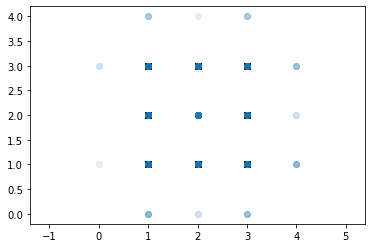

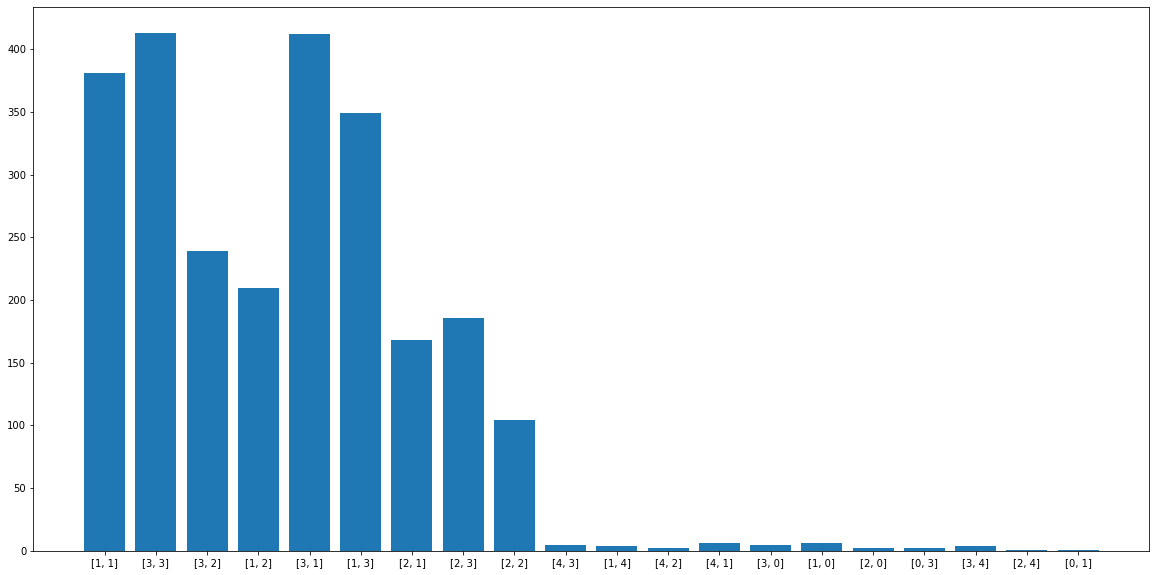

Processing Epoch 105
training start
Iteration 0, d real/fake loss 0.6296257376670837/0.6744509935379028 and g loss is 0.7131727933883667, NDiv loss 0.048566557466983795
Iteration 1, d real/fake loss 0.6296252012252808/0.6768000721931458 and g loss is 0.7073360681533813, NDiv loss 0.049440331757068634
Iteration 2, d real/fake loss 0.6296029090881348/0.6758023500442505 and g loss is 0.7096863985061646, NDiv loss 0.04837733134627342
Iteration 3, d real/fake loss 0.6295575499534607/0.6793591976165771 and g loss is 0.7129387855529785, NDiv loss 0.04951515421271324
Iteration 4, d real/fake loss 0.6295080184936523/0.6746124029159546 and g loss is 0.710614025592804, NDiv loss 0.04917890578508377


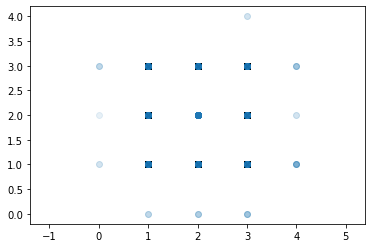

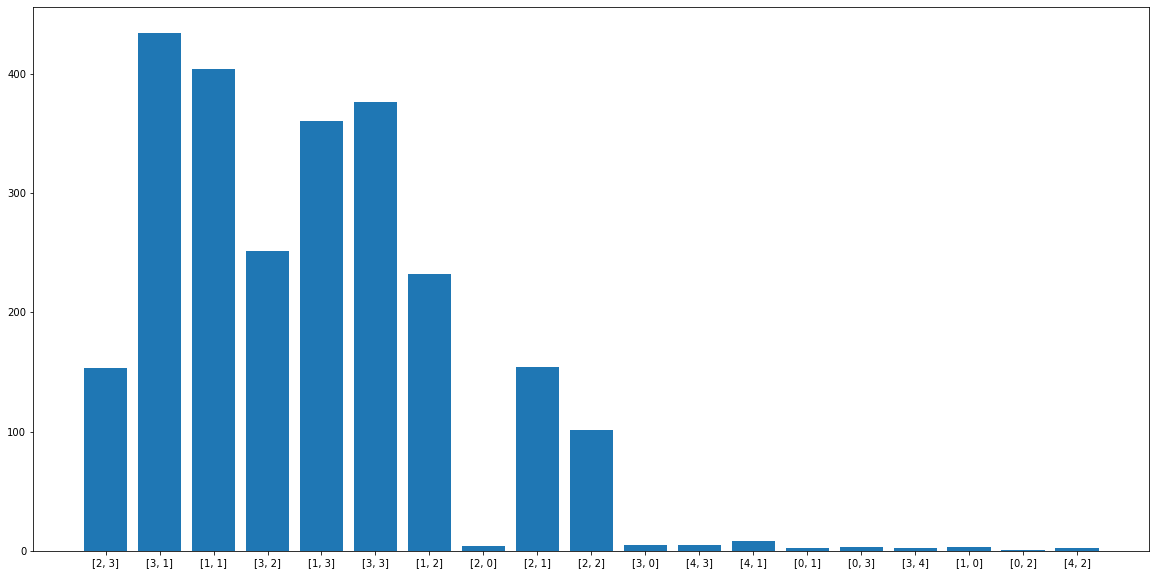

Processing Epoch 106
training start
Iteration 0, d real/fake loss 0.6319699883460999/0.6759395003318787 and g loss is 0.7167448401451111, NDiv loss 0.049313489347696304
Iteration 1, d real/fake loss 0.631933331489563/0.6788969039916992 and g loss is 0.7163598537445068, NDiv loss 0.04667116701602936
Iteration 2, d real/fake loss 0.631900429725647/0.6741917729377747 and g loss is 0.7142516374588013, NDiv loss 0.04701245203614235
Iteration 3, d real/fake loss 0.6318548917770386/0.6749114990234375 and g loss is 0.7157273888587952, NDiv loss 0.049926213920116425
Iteration 4, d real/fake loss 0.6318072080612183/0.669086217880249 and g loss is 0.7090179920196533, NDiv loss 0.05008711665868759


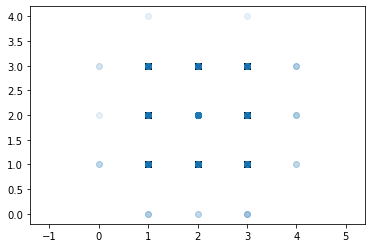

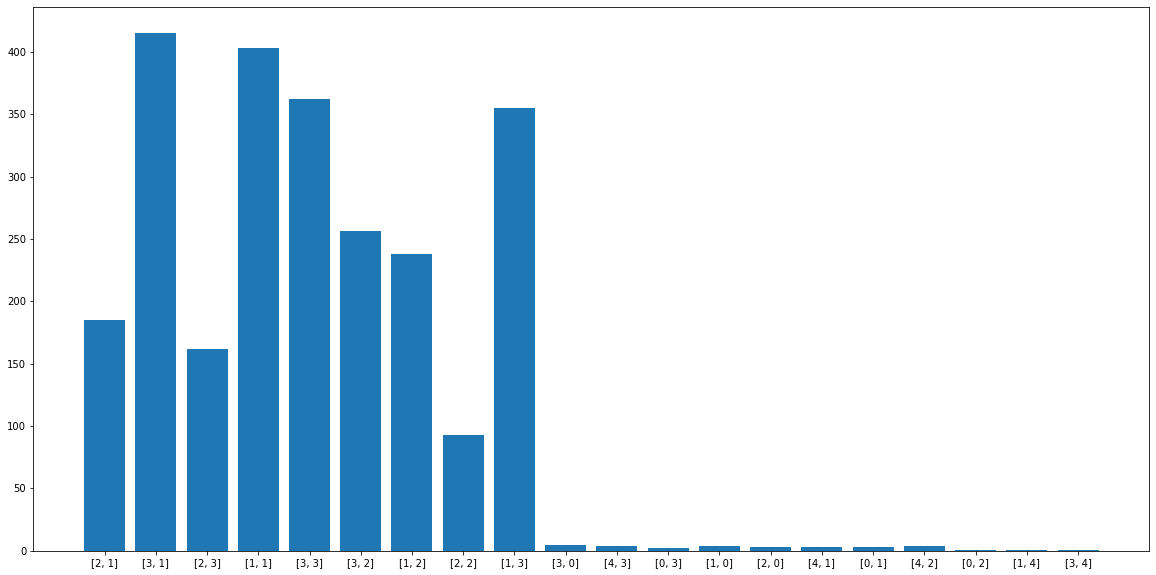

Processing Epoch 107
training start
Iteration 0, d real/fake loss 0.6278883814811707/0.6718734502792358 and g loss is 0.7203134298324585, NDiv loss 0.04793170839548111
Iteration 1, d real/fake loss 0.6278200149536133/0.6711561679840088 and g loss is 0.7117856740951538, NDiv loss 0.048258110880851746
Iteration 2, d real/fake loss 0.6277371644973755/0.6682332754135132 and g loss is 0.7111056447029114, NDiv loss 0.04906883090734482
Iteration 3, d real/fake loss 0.627629816532135/0.6726211309432983 and g loss is 0.7179123163223267, NDiv loss 0.047322437167167664
Iteration 4, d real/fake loss 0.62751305103302/0.6760883331298828 and g loss is 0.7125061750411987, NDiv loss 0.05115089565515518


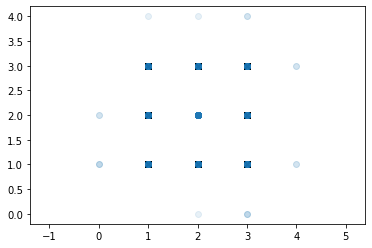

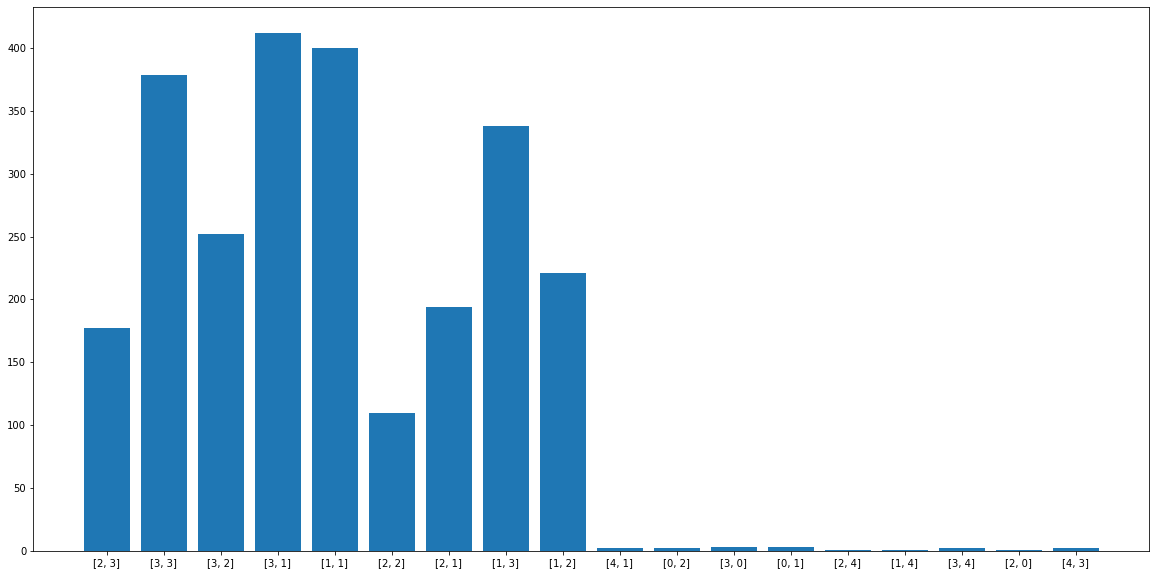

Processing Epoch 108
training start
Iteration 0, d real/fake loss 0.6297855973243713/0.6707966923713684 and g loss is 0.711524248123169, NDiv loss 0.05003679543733597
Iteration 1, d real/fake loss 0.6297333836555481/0.6752257943153381 and g loss is 0.716517448425293, NDiv loss 0.04679827019572258
Iteration 2, d real/fake loss 0.629671573638916/0.6788740158081055 and g loss is 0.7145498991012573, NDiv loss 0.04790549352765083
Iteration 3, d real/fake loss 0.6296142339706421/0.6780896186828613 and g loss is 0.7169588208198547, NDiv loss 0.050440091639757156
Iteration 4, d real/fake loss 0.6295573711395264/0.6702308654785156 and g loss is 0.714392900466919, NDiv loss 0.049692124128341675


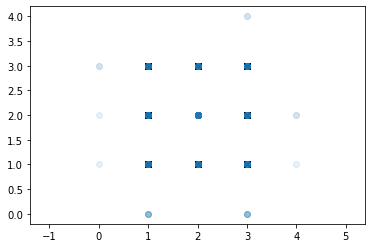

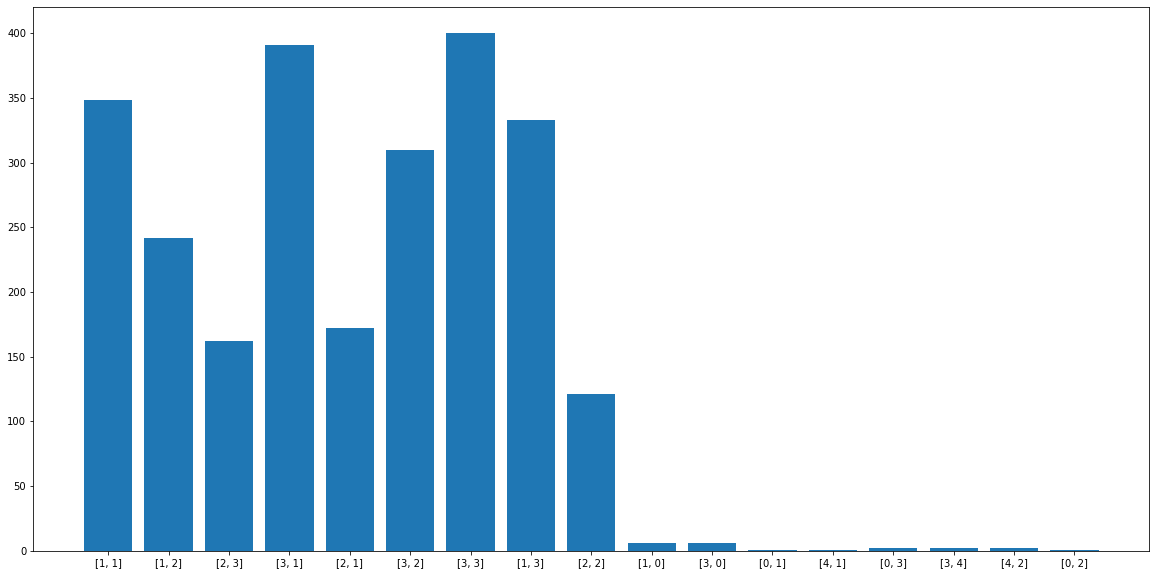

Processing Epoch 109
training start
Iteration 0, d real/fake loss 0.6308780312538147/0.6735512614250183 and g loss is 0.7134783864021301, NDiv loss 0.04685487598180771
Iteration 1, d real/fake loss 0.6307794451713562/0.6709718704223633 and g loss is 0.7152433395385742, NDiv loss 0.04866907373070717
Iteration 2, d real/fake loss 0.6306759715080261/0.6729543209075928 and g loss is 0.7096627354621887, NDiv loss 0.04870223626494408
Iteration 3, d real/fake loss 0.6305758953094482/0.6739709377288818 and g loss is 0.7159209847450256, NDiv loss 0.04894242808222771
Iteration 4, d real/fake loss 0.6304770708084106/0.6720841526985168 and g loss is 0.7143886089324951, NDiv loss 0.047784965485334396


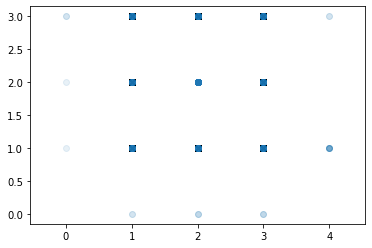

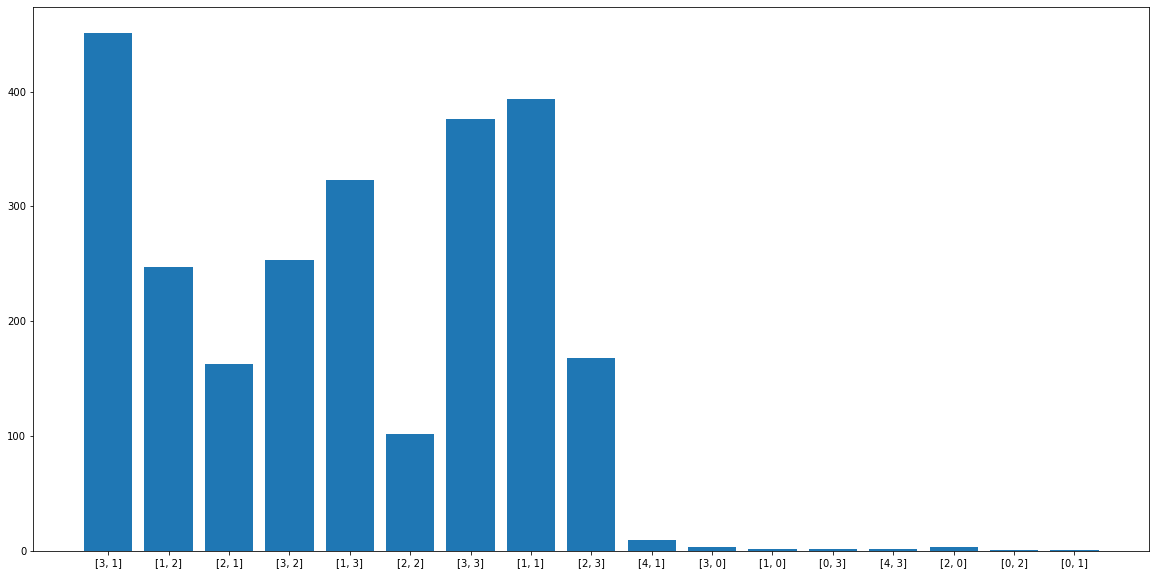

Processing Epoch 110
training start
Iteration 0, d real/fake loss 0.6299630403518677/0.6696484088897705 and g loss is 0.7132807374000549, NDiv loss 0.045757897198200226
Iteration 1, d real/fake loss 0.6298675537109375/0.6726641058921814 and g loss is 0.7154561281204224, NDiv loss 0.04797864332795143
Iteration 2, d real/fake loss 0.6297658681869507/0.6764720678329468 and g loss is 0.7199835181236267, NDiv loss 0.04759952425956726
Iteration 3, d real/fake loss 0.6296663880348206/0.6692867279052734 and g loss is 0.719708263874054, NDiv loss 0.0514724999666214
Iteration 4, d real/fake loss 0.6295617818832397/0.6746325492858887 and g loss is 0.7169200778007507, NDiv loss 0.049721699208021164


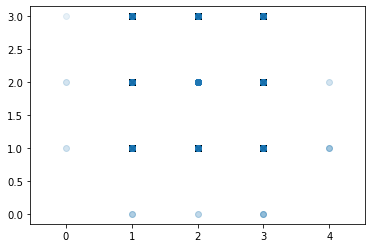

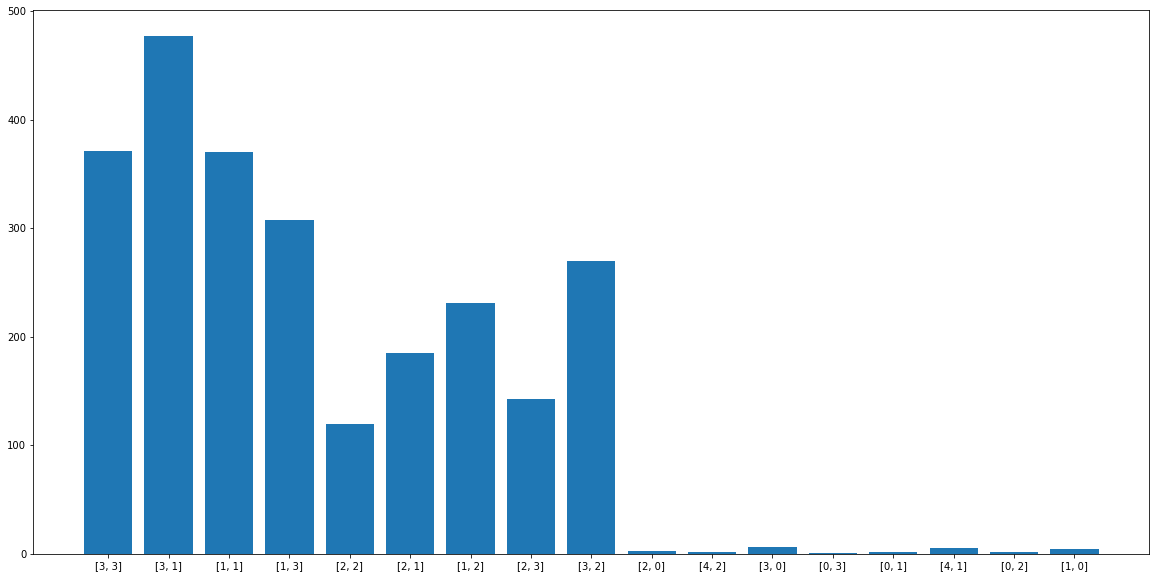

Processing Epoch 111
training start
Iteration 0, d real/fake loss 0.6286760568618774/0.6680073738098145 and g loss is 0.7132556438446045, NDiv loss 0.04835962504148483
Iteration 1, d real/fake loss 0.6285990476608276/0.6700503826141357 and g loss is 0.712365984916687, NDiv loss 0.04829733073711395
Iteration 2, d real/fake loss 0.6285127401351929/0.6729375720024109 and g loss is 0.7185490131378174, NDiv loss 0.050754763185977936
Iteration 3, d real/fake loss 0.6284282207489014/0.6725757122039795 and g loss is 0.7163976430892944, NDiv loss 0.04751027002930641
Iteration 4, d real/fake loss 0.6283413767814636/0.6710964441299438 and g loss is 0.7183641195297241, NDiv loss 0.05114298686385155


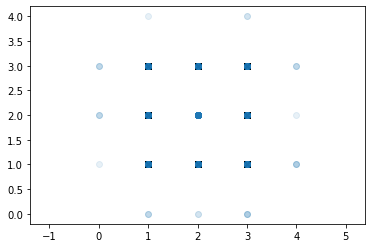

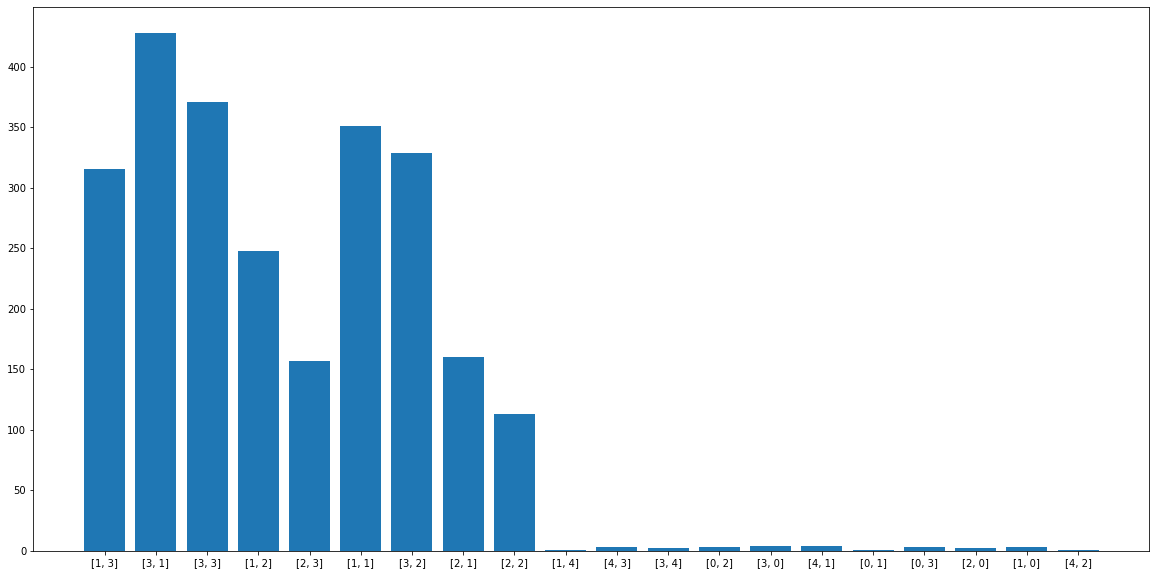

Processing Epoch 112
training start
Iteration 0, d real/fake loss 0.6280496120452881/0.6698060631752014 and g loss is 0.714145839214325, NDiv loss 0.05002586916089058
Iteration 1, d real/fake loss 0.6279832720756531/0.6794438362121582 and g loss is 0.7146509885787964, NDiv loss 0.04996839165687561
Iteration 2, d real/fake loss 0.6279207468032837/0.6739743947982788 and g loss is 0.7221760749816895, NDiv loss 0.05101456120610237
Iteration 3, d real/fake loss 0.6278602480888367/0.6679569482803345 and g loss is 0.7226256728172302, NDiv loss 0.048695292323827744
Iteration 4, d real/fake loss 0.6277889013290405/0.6733682155609131 and g loss is 0.7149718403816223, NDiv loss 0.048032231628894806


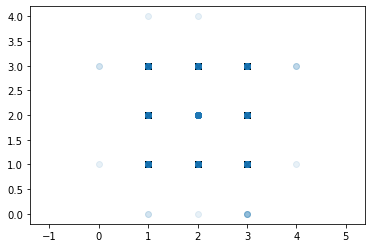

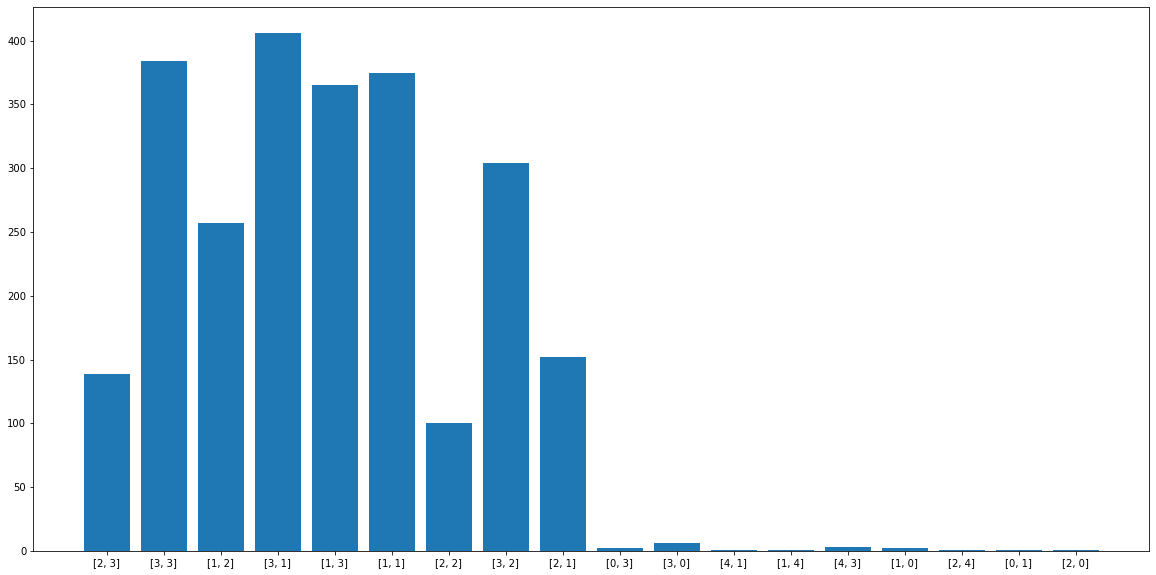

Processing Epoch 113
training start
Iteration 0, d real/fake loss 0.6273686289787292/0.6662234663963318 and g loss is 0.7233986258506775, NDiv loss 0.0494481660425663
Iteration 1, d real/fake loss 0.6273412704467773/0.6724157929420471 and g loss is 0.7207789421081543, NDiv loss 0.04815034195780754
Iteration 2, d real/fake loss 0.6273046135902405/0.6679733991622925 and g loss is 0.7193439602851868, NDiv loss 0.048608552664518356
Iteration 3, d real/fake loss 0.6272515654563904/0.6714622974395752 and g loss is 0.7190167903900146, NDiv loss 0.04937773197889328
Iteration 4, d real/fake loss 0.6271941065788269/0.6678363084793091 and g loss is 0.7182825207710266, NDiv loss 0.049545906484127045


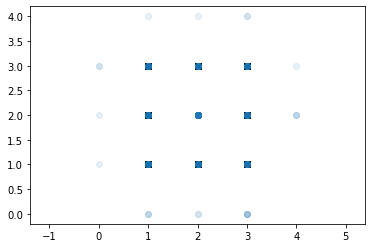

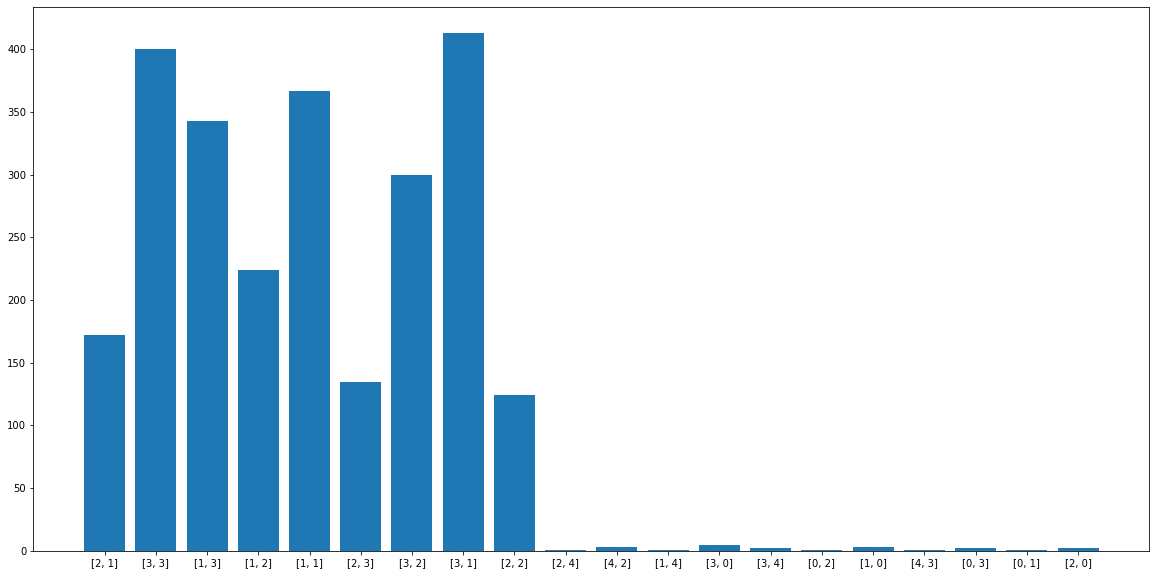

Processing Epoch 114
training start
Iteration 0, d real/fake loss 0.6265345215797424/0.6725426316261292 and g loss is 0.7228831052780151, NDiv loss 0.04984129220247269
Iteration 1, d real/fake loss 0.6264564990997314/0.6698141098022461 and g loss is 0.7265080213546753, NDiv loss 0.049833931028842926
Iteration 2, d real/fake loss 0.6263754963874817/0.6661964058876038 and g loss is 0.7138487100601196, NDiv loss 0.05083509534597397
Iteration 3, d real/fake loss 0.6262853741645813/0.669482946395874 and g loss is 0.7183406352996826, NDiv loss 0.04773474484682083
Iteration 4, d real/fake loss 0.6261976957321167/0.668728232383728 and g loss is 0.7170161008834839, NDiv loss 0.048537079244852066


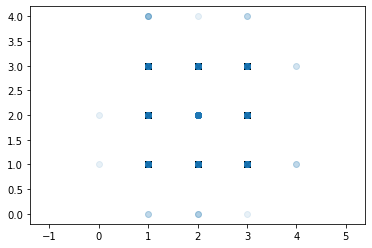

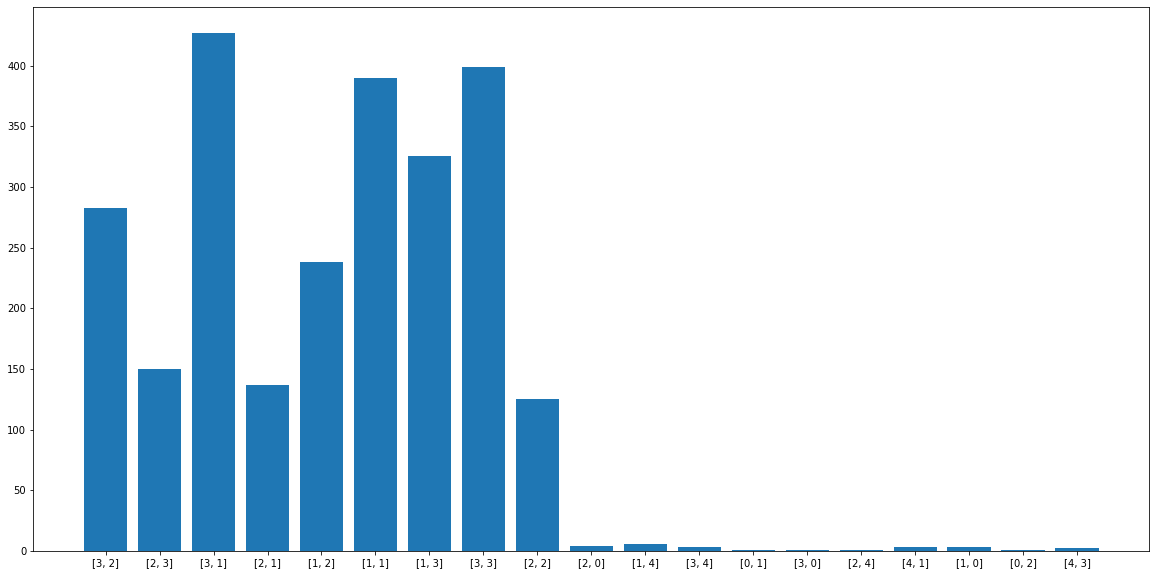

Processing Epoch 115
training start
Iteration 0, d real/fake loss 0.6277813911437988/0.6665889620780945 and g loss is 0.7175848484039307, NDiv loss 0.048230066895484924
Iteration 1, d real/fake loss 0.6276870965957642/0.6698976755142212 and g loss is 0.7240206003189087, NDiv loss 0.05116330087184906
Iteration 2, d real/fake loss 0.6275919079780579/0.6608493328094482 and g loss is 0.7225026488304138, NDiv loss 0.04880464822053909
Iteration 3, d real/fake loss 0.6274749636650085/0.6671023964881897 and g loss is 0.7188147306442261, NDiv loss 0.04877796024084091
Iteration 4, d real/fake loss 0.6273580193519592/0.6658402681350708 and g loss is 0.7174689769744873, NDiv loss 0.04993591457605362


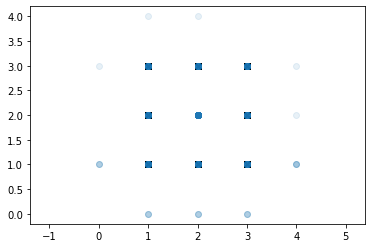

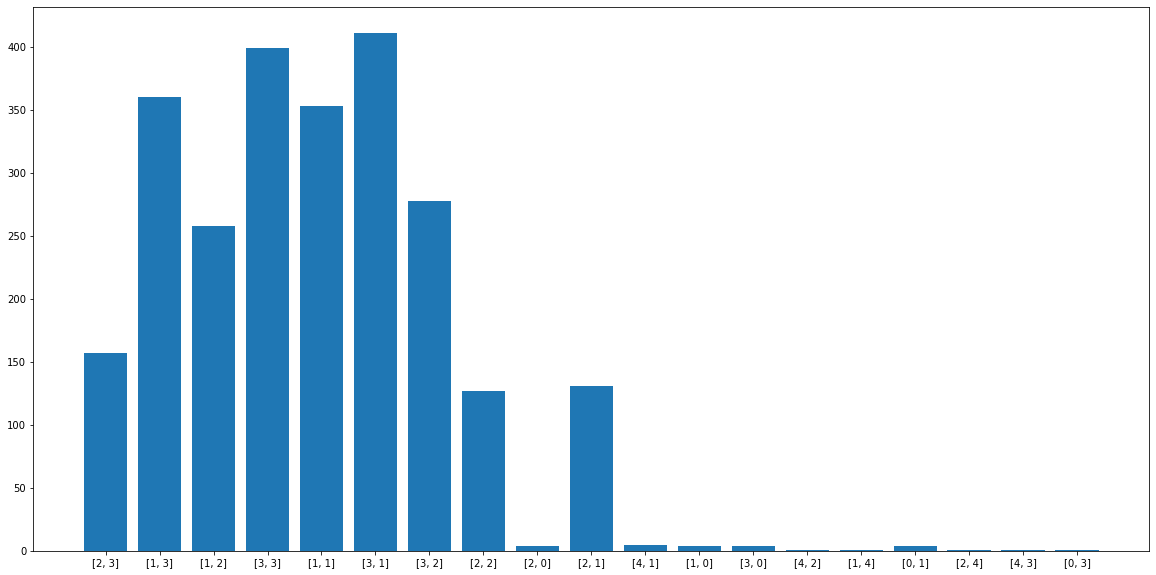

Processing Epoch 116
training start
Iteration 0, d real/fake loss 0.6282815933227539/0.6661226749420166 and g loss is 0.7247706651687622, NDiv loss 0.04759236052632332
Iteration 1, d real/fake loss 0.6281790137290955/0.6677306890487671 and g loss is 0.7253462076187134, NDiv loss 0.05088992789387703
Iteration 2, d real/fake loss 0.628068208694458/0.6668719053268433 and g loss is 0.7215214967727661, NDiv loss 0.0500921793282032
Iteration 3, d real/fake loss 0.6279615163803101/0.6649914979934692 and g loss is 0.7198033928871155, NDiv loss 0.04704032465815544
Iteration 4, d real/fake loss 0.6278458833694458/0.6731095314025879 and g loss is 0.7168921232223511, NDiv loss 0.0478045828640461


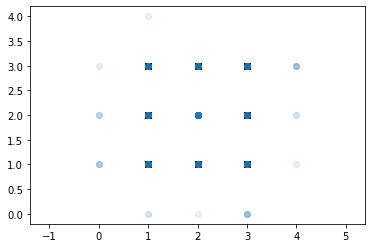

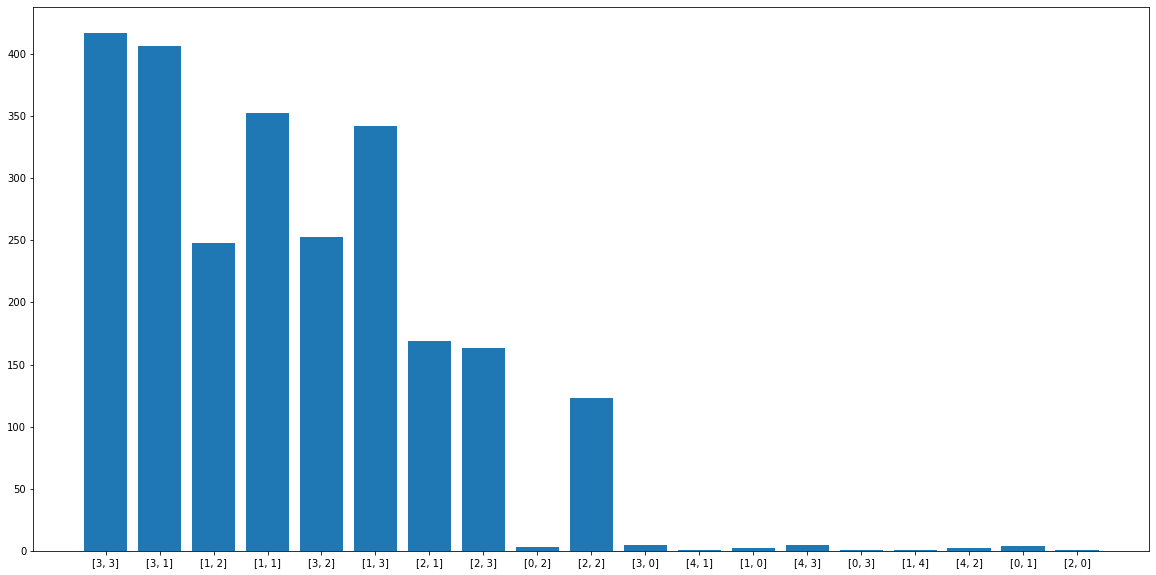

Processing Epoch 117
training start
Iteration 0, d real/fake loss 0.625542402267456/0.66497802734375 and g loss is 0.7243133187294006, NDiv loss 0.050709862262010574
Iteration 1, d real/fake loss 0.6254421472549438/0.6693261861801147 and g loss is 0.7201302647590637, NDiv loss 0.04847152903676033
Iteration 2, d real/fake loss 0.625339925289154/0.6663925647735596 and g loss is 0.7190008163452148, NDiv loss 0.05152898281812668
Iteration 3, d real/fake loss 0.6252309679985046/0.6672346591949463 and g loss is 0.7235186100006104, NDiv loss 0.046964094042778015
Iteration 4, d real/fake loss 0.6251204013824463/0.6662654876708984 and g loss is 0.717241644859314, NDiv loss 0.049206800758838654


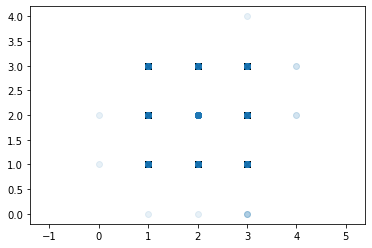

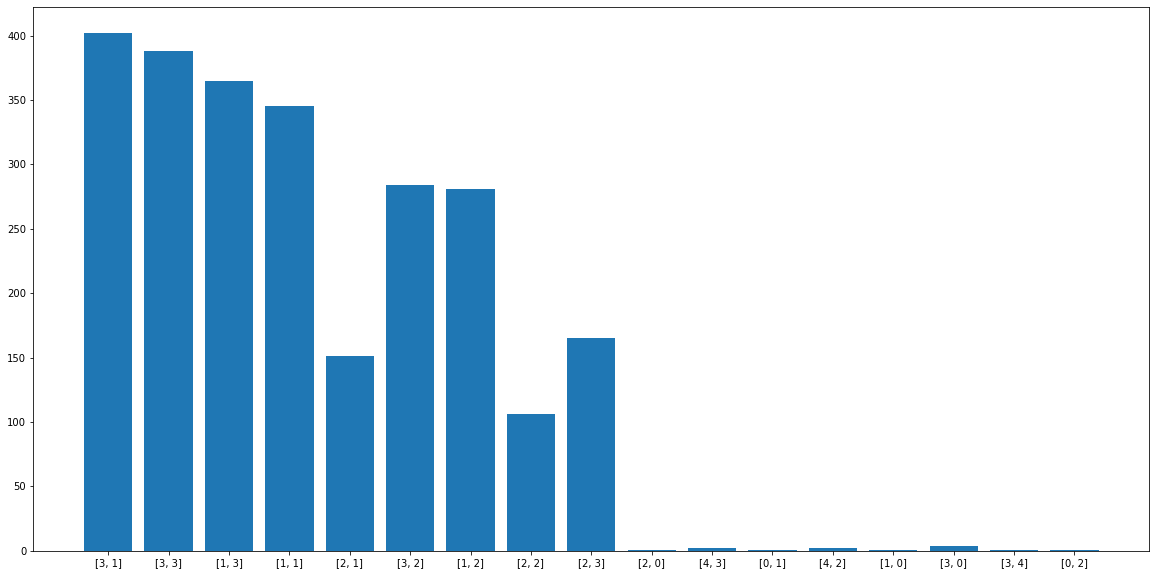

Processing Epoch 118
training start
Iteration 0, d real/fake loss 0.6255797147750854/0.6581572890281677 and g loss is 0.7201988697052002, NDiv loss 0.046951912343502045
Iteration 1, d real/fake loss 0.6254639625549316/0.6673324704170227 and g loss is 0.7245146036148071, NDiv loss 0.047747883945703506
Iteration 2, d real/fake loss 0.6253545880317688/0.6670637130737305 and g loss is 0.7218931317329407, NDiv loss 0.0481463186442852
Iteration 3, d real/fake loss 0.6252554059028625/0.6641749143600464 and g loss is 0.7248533964157104, NDiv loss 0.05027332901954651
Iteration 4, d real/fake loss 0.6251611113548279/0.6673134565353394 and g loss is 0.7269694805145264, NDiv loss 0.050101250410079956


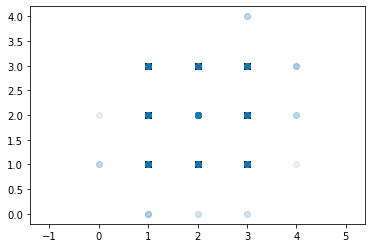

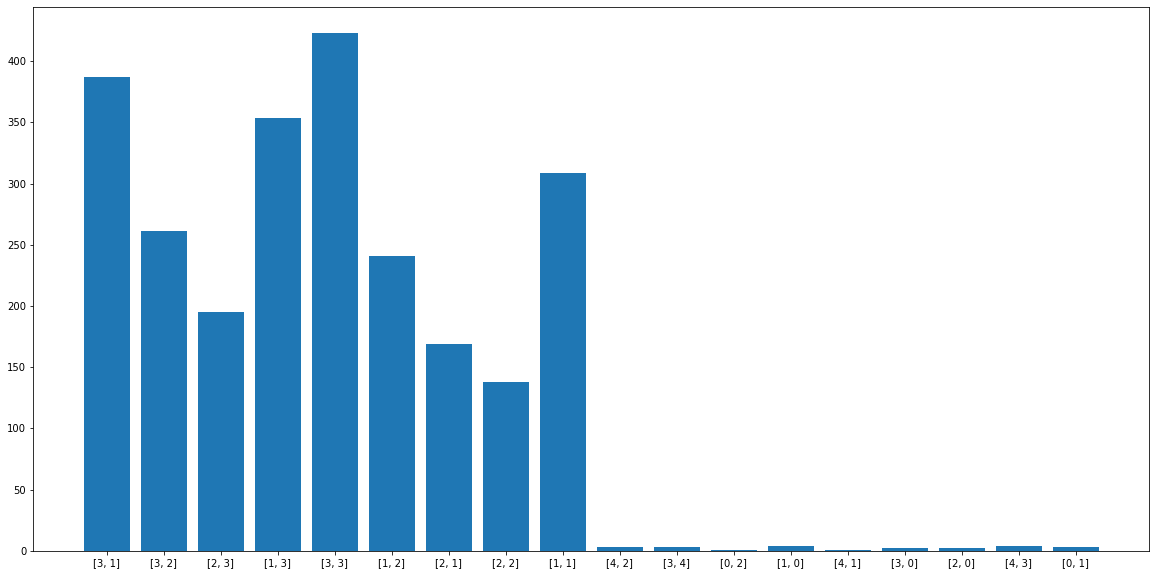

Processing Epoch 119
training start
Iteration 0, d real/fake loss 0.6267613172531128/0.6670417189598083 and g loss is 0.7243615984916687, NDiv loss 0.04752065986394882
Iteration 1, d real/fake loss 0.6266871690750122/0.6622834801673889 and g loss is 0.7258299589157104, NDiv loss 0.04773002490401268
Iteration 2, d real/fake loss 0.6265953779220581/0.6639717221260071 and g loss is 0.7178249955177307, NDiv loss 0.046865686774253845
Iteration 3, d real/fake loss 0.6264972686767578/0.6681820154190063 and g loss is 0.7217755317687988, NDiv loss 0.048083335161209106
Iteration 4, d real/fake loss 0.6264011859893799/0.6669639348983765 and g loss is 0.7217470407485962, NDiv loss 0.04795224592089653


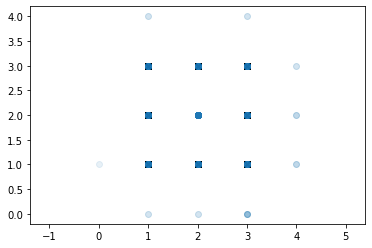

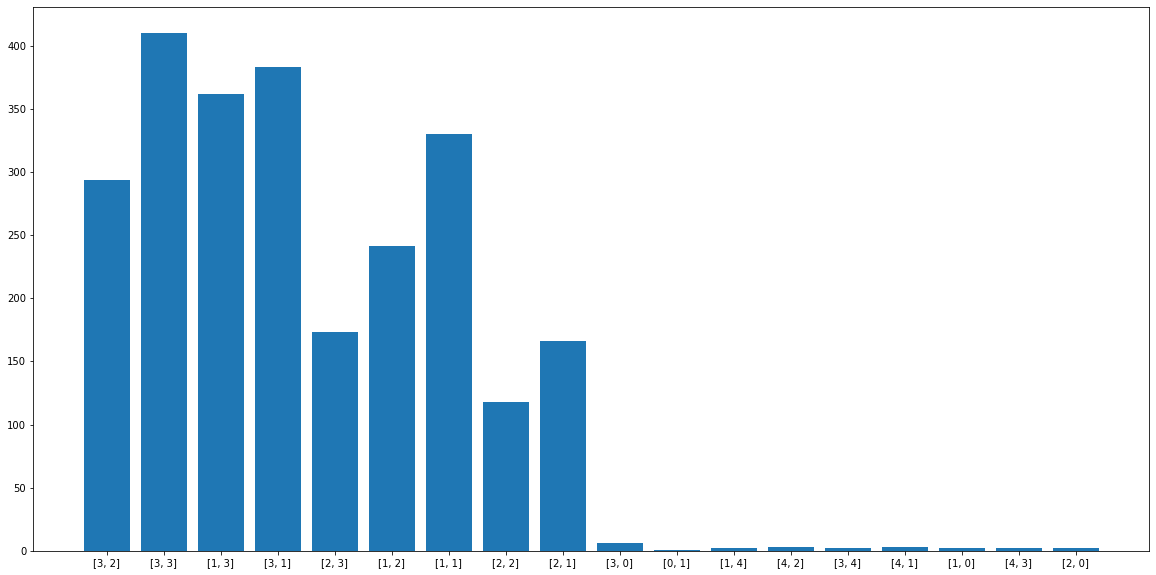

Processing Epoch 120
training start
Iteration 0, d real/fake loss 0.626121461391449/0.6641825437545776 and g loss is 0.7243646383285522, NDiv loss 0.0496257022023201
Iteration 1, d real/fake loss 0.6260747313499451/0.6636418104171753 and g loss is 0.720702052116394, NDiv loss 0.048414576798677444
Iteration 2, d real/fake loss 0.6260178685188293/0.6674008369445801 and g loss is 0.7248630523681641, NDiv loss 0.04810686036944389
Iteration 3, d real/fake loss 0.625960648059845/0.6660717725753784 and g loss is 0.7228069305419922, NDiv loss 0.0486186221241951
Iteration 4, d real/fake loss 0.6259005069732666/0.6676476001739502 and g loss is 0.7209303379058838, NDiv loss 0.04928408935666084


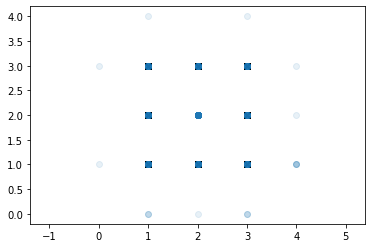

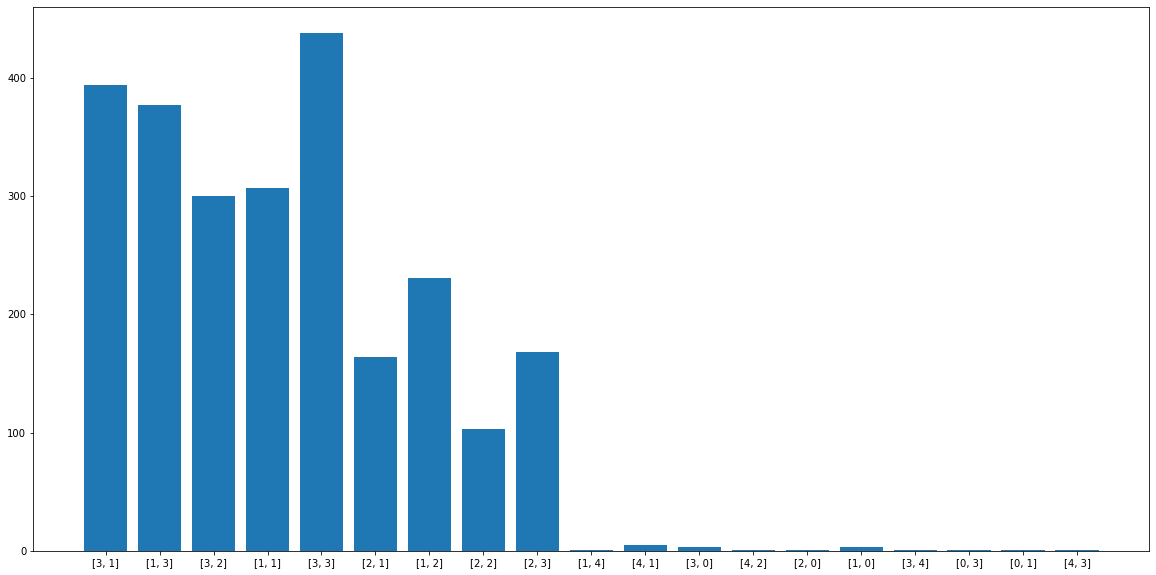

Processing Epoch 121
training start
Iteration 0, d real/fake loss 0.6231589317321777/0.6588224172592163 and g loss is 0.7253097891807556, NDiv loss 0.04817907512187958
Iteration 1, d real/fake loss 0.623100996017456/0.6658616065979004 and g loss is 0.7239206433296204, NDiv loss 0.0492054782807827
Iteration 2, d real/fake loss 0.6230394840240479/0.6625553369522095 and g loss is 0.7286014556884766, NDiv loss 0.04867536574602127
Iteration 3, d real/fake loss 0.6229537129402161/0.6702067852020264 and g loss is 0.72604900598526, NDiv loss 0.04657961428165436
Iteration 4, d real/fake loss 0.6228691339492798/0.6666209697723389 and g loss is 0.724567711353302, NDiv loss 0.04940520226955414


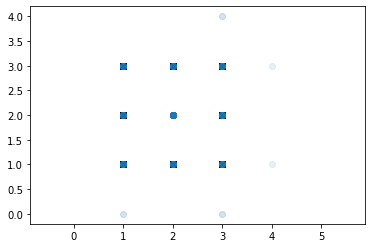

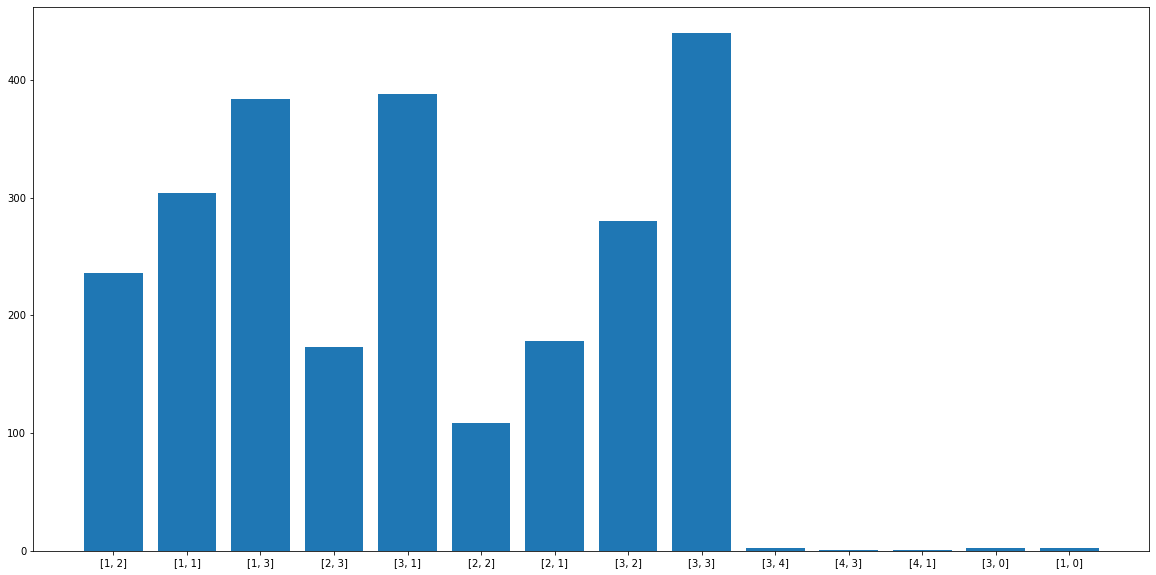

Processing Epoch 122
training start
Iteration 0, d real/fake loss 0.6233305335044861/0.6606814861297607 and g loss is 0.7254412174224854, NDiv loss 0.048012182116508484
Iteration 1, d real/fake loss 0.6232573390007019/0.6614066362380981 and g loss is 0.7234988212585449, NDiv loss 0.04686844348907471
Iteration 2, d real/fake loss 0.6231775283813477/0.6608395576477051 and g loss is 0.7226730585098267, NDiv loss 0.052151549607515335
Iteration 3, d real/fake loss 0.6230883598327637/0.6629650592803955 and g loss is 0.7282894849777222, NDiv loss 0.048895906656980515
Iteration 4, d real/fake loss 0.622992992401123/0.659691572189331 and g loss is 0.7338823676109314, NDiv loss 0.04827507585287094


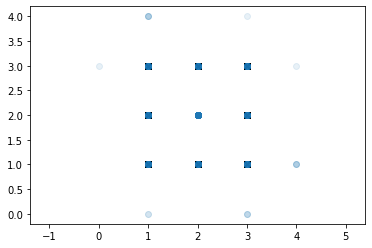

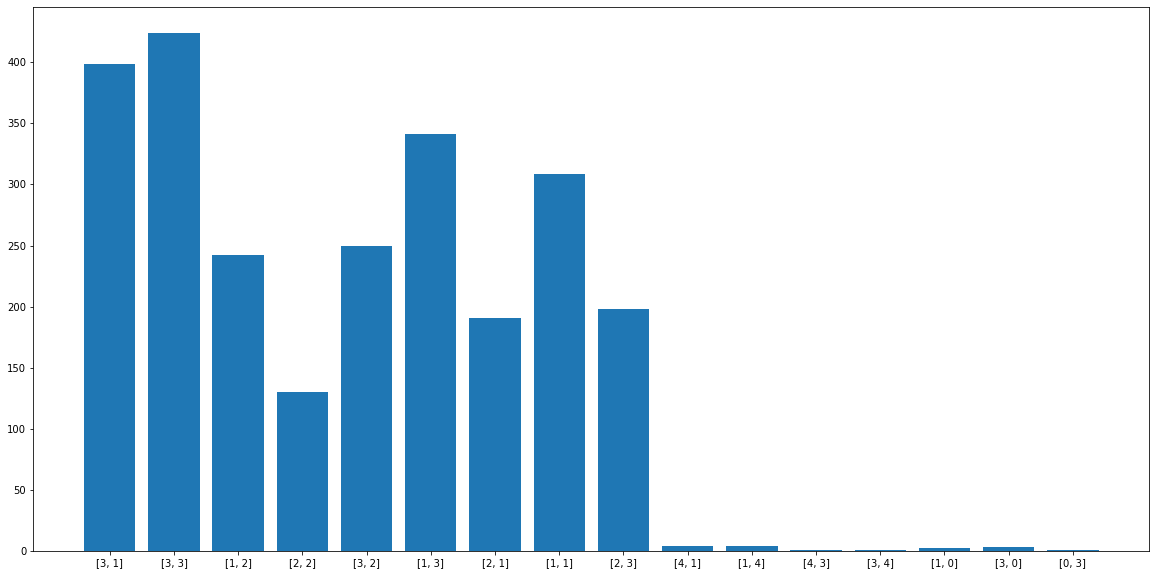

Processing Epoch 123
training start
Iteration 0, d real/fake loss 0.6228269338607788/0.6576111316680908 and g loss is 0.725382387638092, NDiv loss 0.050429485738277435
Iteration 1, d real/fake loss 0.6227267980575562/0.6631070971488953 and g loss is 0.724761426448822, NDiv loss 0.04682827368378639
Iteration 2, d real/fake loss 0.6226237416267395/0.6639789342880249 and g loss is 0.7237626910209656, NDiv loss 0.0494605228304863
Iteration 3, d real/fake loss 0.6225186586380005/0.662588357925415 and g loss is 0.7319194078445435, NDiv loss 0.049524638801813126
Iteration 4, d real/fake loss 0.6224056482315063/0.6593976616859436 and g loss is 0.7253894805908203, NDiv loss 0.048466119915246964


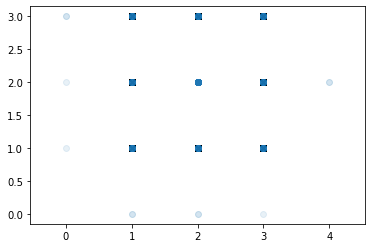

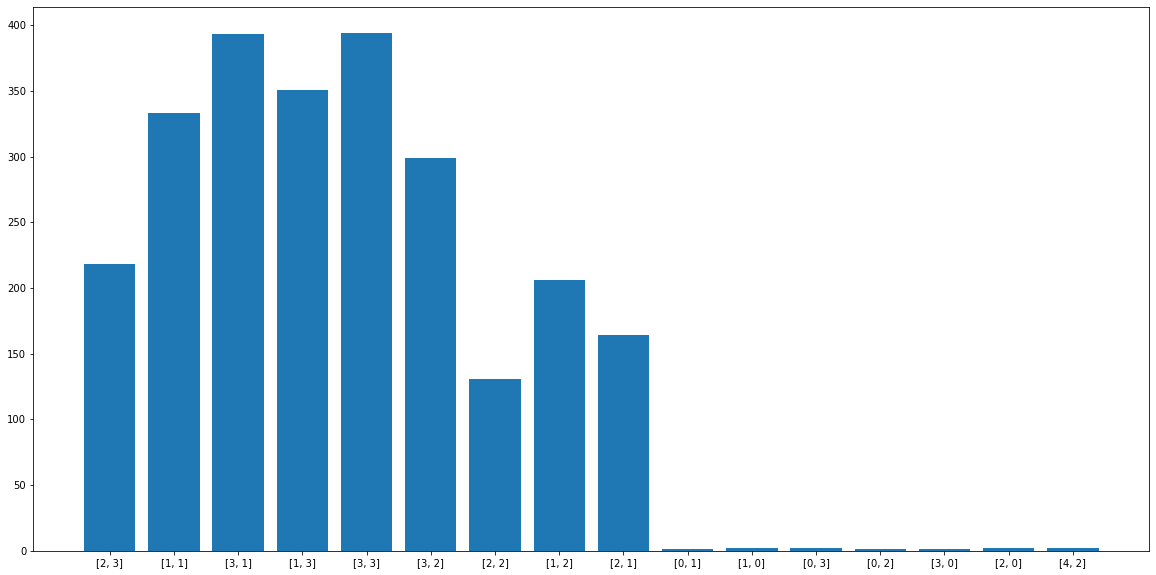

Processing Epoch 124
training start
Iteration 0, d real/fake loss 0.6231266260147095/0.6592326164245605 and g loss is 0.7264674305915833, NDiv loss 0.048793330788612366
Iteration 1, d real/fake loss 0.6230109930038452/0.6631737351417542 and g loss is 0.7302130460739136, NDiv loss 0.050707634538412094
Iteration 2, d real/fake loss 0.6229000687599182/0.6623128056526184 and g loss is 0.7238872051239014, NDiv loss 0.04680443927645683
Iteration 3, d real/fake loss 0.6227924227714539/0.6605865955352783 and g loss is 0.7302423715591431, NDiv loss 0.04811236262321472
Iteration 4, d real/fake loss 0.6226794719696045/0.6667413115501404 and g loss is 0.7251451015472412, NDiv loss 0.047991640865802765


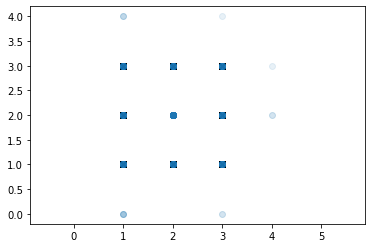

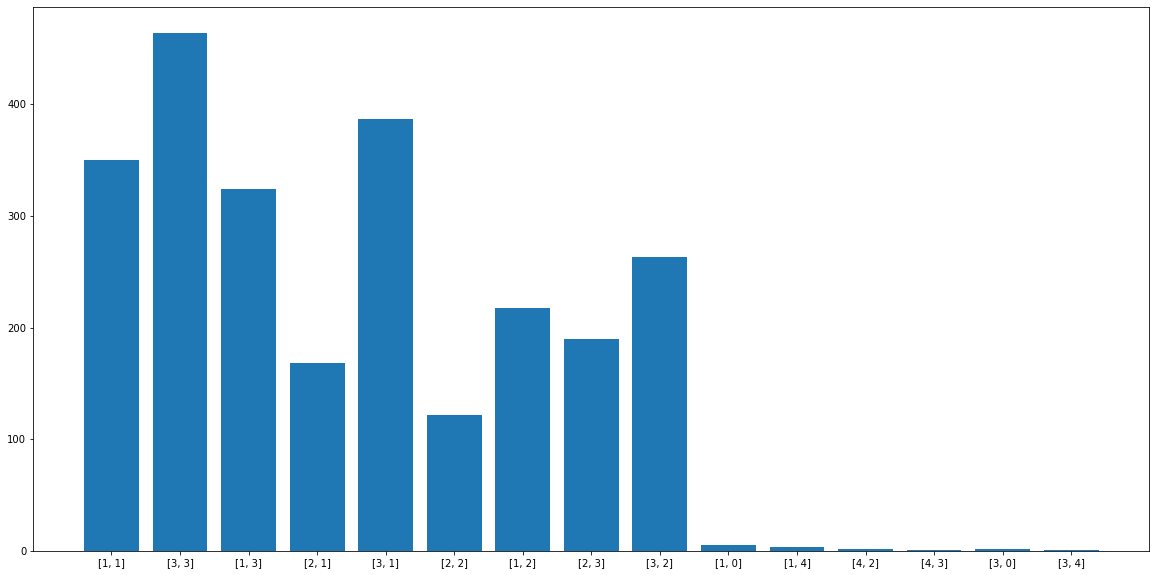

Processing Epoch 125
training start
Iteration 0, d real/fake loss 0.6239202618598938/0.6546962857246399 and g loss is 0.7240540981292725, NDiv loss 0.049014512449502945
Iteration 1, d real/fake loss 0.6238411068916321/0.6655260920524597 and g loss is 0.7248850464820862, NDiv loss 0.049332376569509506
Iteration 2, d real/fake loss 0.6237586140632629/0.6593128442764282 and g loss is 0.729902446269989, NDiv loss 0.04864872246980667
Iteration 3, d real/fake loss 0.6236556768417358/0.6611947417259216 and g loss is 0.7269520163536072, NDiv loss 0.047384366393089294
Iteration 4, d real/fake loss 0.6235431432723999/0.6597912311553955 and g loss is 0.7252554893493652, NDiv loss 0.049499787390232086


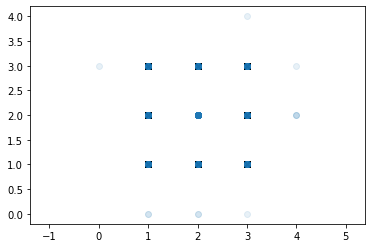

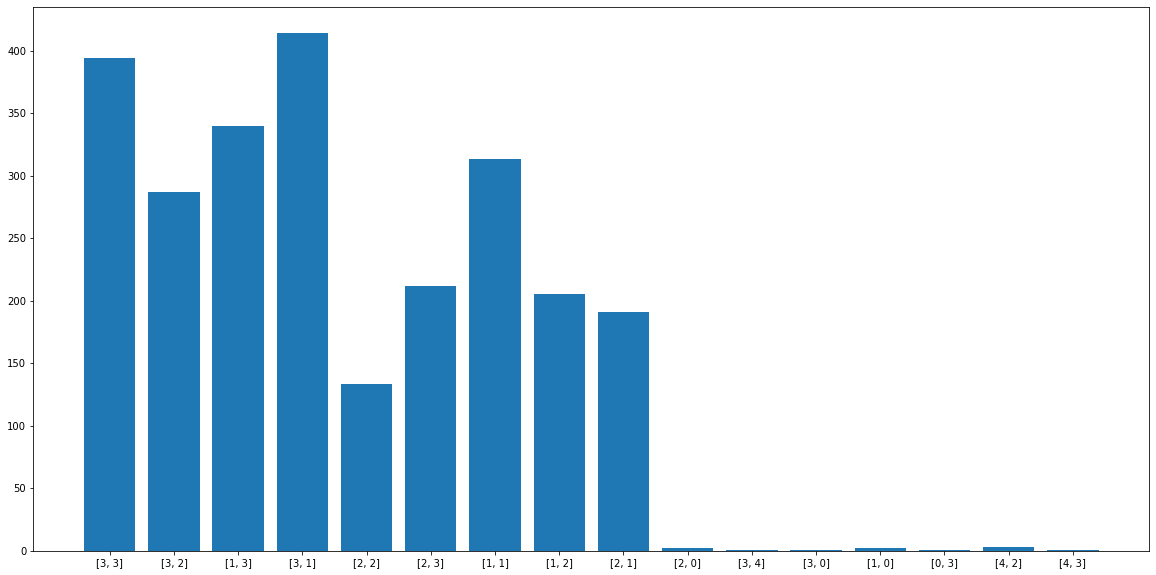

Processing Epoch 126
training start
Iteration 0, d real/fake loss 0.6225761771202087/0.6635799407958984 and g loss is 0.7306765913963318, NDiv loss 0.049149636179208755
Iteration 1, d real/fake loss 0.6224762797355652/0.6584534645080566 and g loss is 0.7237067222595215, NDiv loss 0.0471092164516449
Iteration 2, d real/fake loss 0.622368335723877/0.6656548976898193 and g loss is 0.7281471490859985, NDiv loss 0.04649557173252106
Iteration 3, d real/fake loss 0.6222662925720215/0.6633708477020264 and g loss is 0.7292503118515015, NDiv loss 0.046600811183452606
Iteration 4, d real/fake loss 0.6221646070480347/0.6588301658630371 and g loss is 0.7264391183853149, NDiv loss 0.04552067071199417


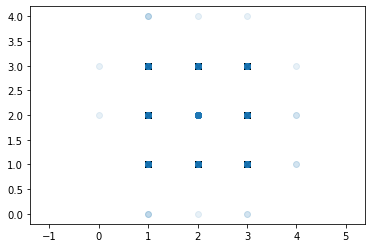

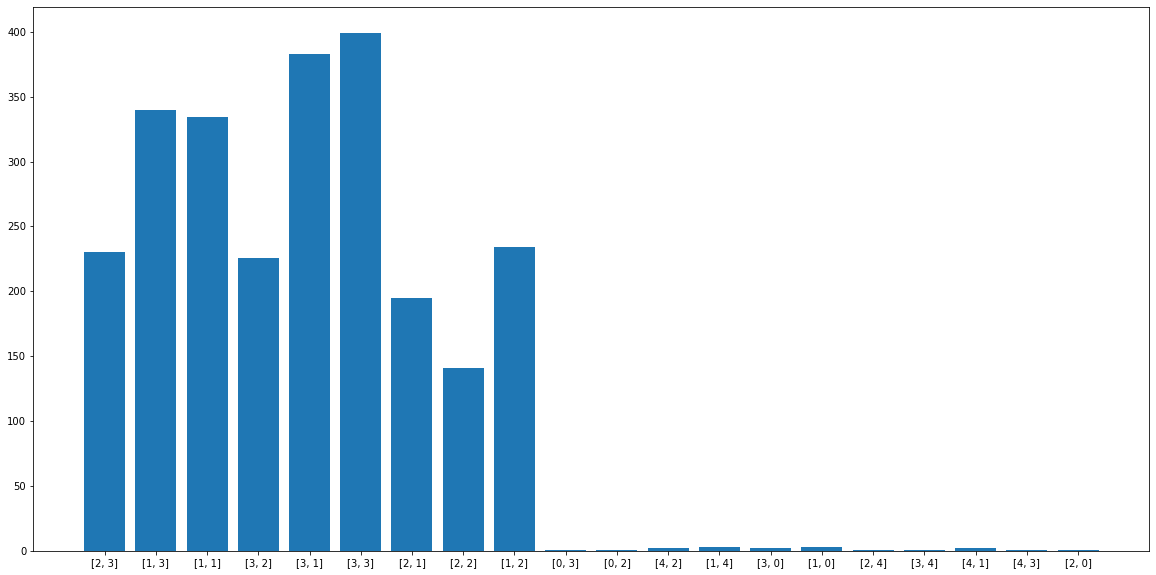

Processing Epoch 127
training start
Iteration 0, d real/fake loss 0.6203368902206421/0.6616479754447937 and g loss is 0.7306200265884399, NDiv loss 0.04836204648017883
Iteration 1, d real/fake loss 0.6202600002288818/0.6604739427566528 and g loss is 0.7261200547218323, NDiv loss 0.04696181043982506
Iteration 2, d real/fake loss 0.6201708912849426/0.6632611751556396 and g loss is 0.7264828085899353, NDiv loss 0.04898577556014061
Iteration 3, d real/fake loss 0.6200802326202393/0.6514031887054443 and g loss is 0.7308313846588135, NDiv loss 0.04923629388213158
Iteration 4, d real/fake loss 0.6199690103530884/0.6615884900093079 and g loss is 0.7234351634979248, NDiv loss 0.05036044865846634


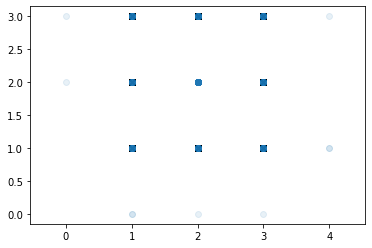

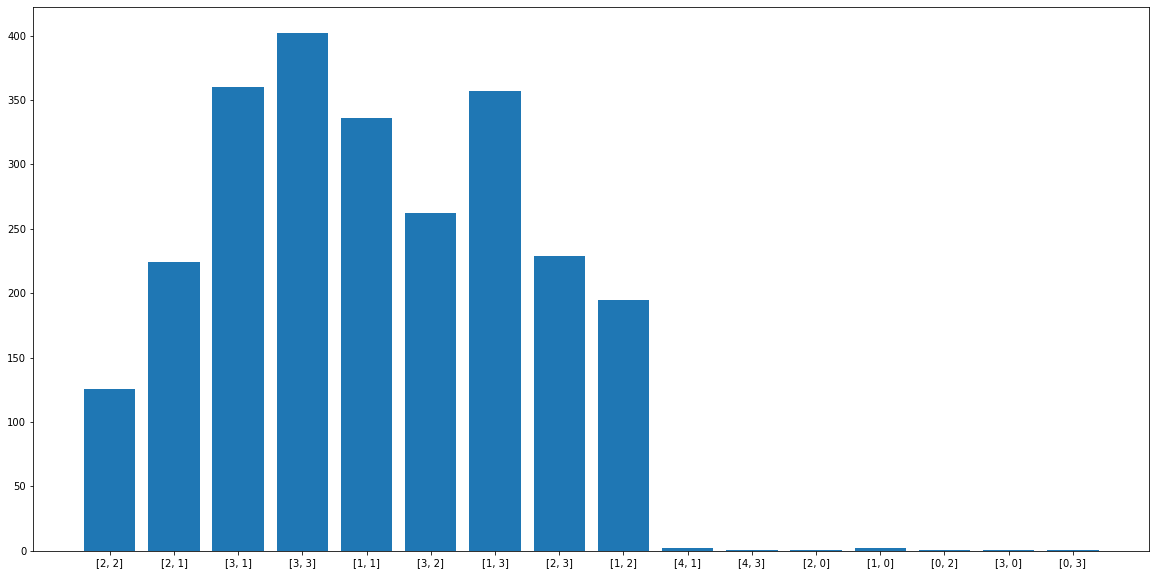

Processing Epoch 128
training start
Iteration 0, d real/fake loss 0.6233230829238892/0.6541138887405396 and g loss is 0.7299923896789551, NDiv loss 0.047996994107961655
Iteration 1, d real/fake loss 0.623187780380249/0.6532077789306641 and g loss is 0.7277280688285828, NDiv loss 0.04958069324493408
Iteration 2, d real/fake loss 0.623032808303833/0.6574850082397461 and g loss is 0.7296916246414185, NDiv loss 0.04689931496977806
Iteration 3, d real/fake loss 0.6228721141815186/0.6579955220222473 and g loss is 0.7327597141265869, NDiv loss 0.04799757897853851
Iteration 4, d real/fake loss 0.6227068901062012/0.6572015881538391 and g loss is 0.730028510093689, NDiv loss 0.04510246962308884


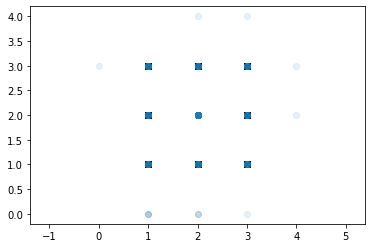

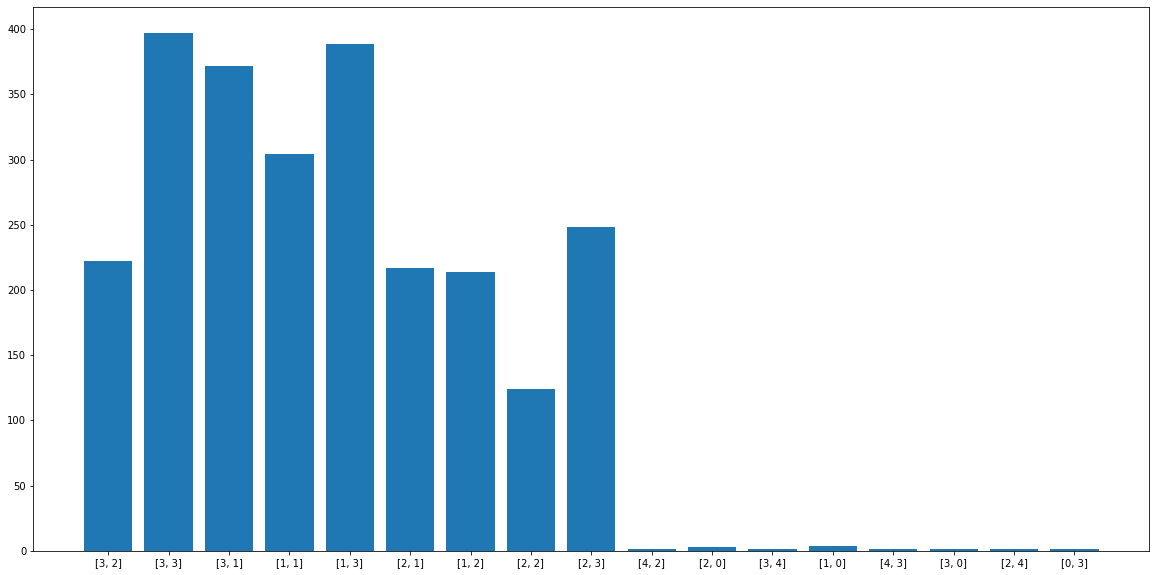

Processing Epoch 129
training start
Iteration 0, d real/fake loss 0.6217995285987854/0.6595007181167603 and g loss is 0.7237061262130737, NDiv loss 0.04772447794675827
Iteration 1, d real/fake loss 0.6216945052146912/0.6563663482666016 and g loss is 0.7272558212280273, NDiv loss 0.050256337970495224
Iteration 2, d real/fake loss 0.6215518712997437/0.6635989546775818 and g loss is 0.7237809896469116, NDiv loss 0.05040538311004639
Iteration 3, d real/fake loss 0.6213916540145874/0.6598625779151917 and g loss is 0.7279520034790039, NDiv loss 0.04858669266104698
Iteration 4, d real/fake loss 0.6212095618247986/0.667366623878479 and g loss is 0.7317222952842712, NDiv loss 0.0476156510412693


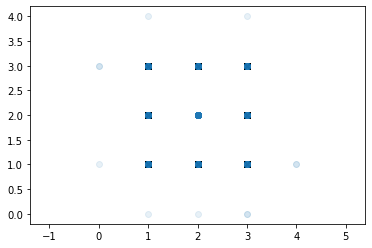

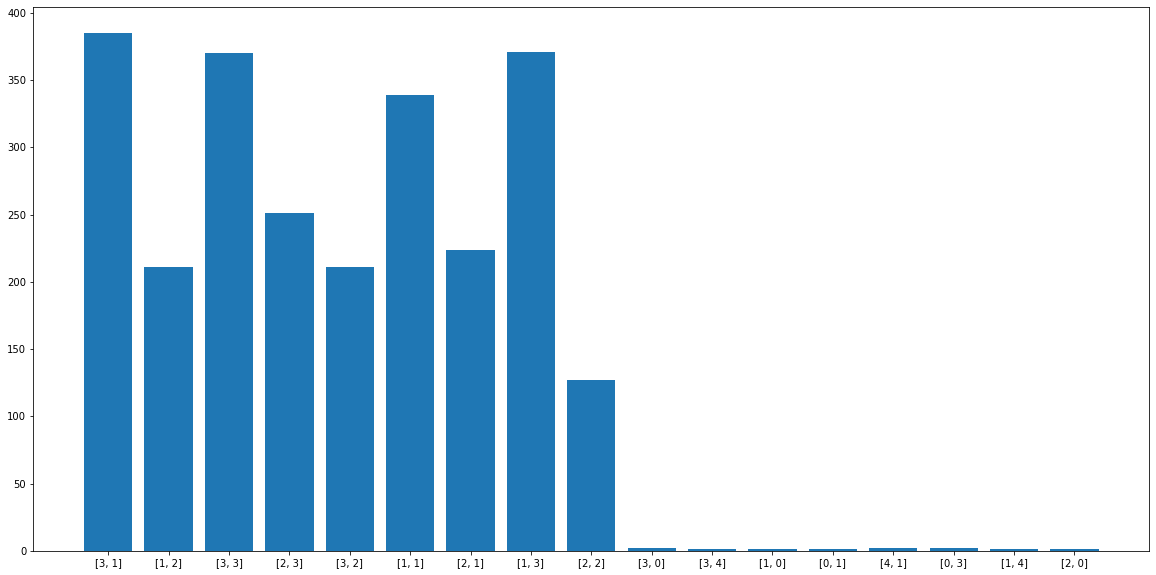

Processing Epoch 130
training start
Iteration 0, d real/fake loss 0.6196123361587524/0.6588900089263916 and g loss is 0.7274630069732666, NDiv loss 0.051211338490247726
Iteration 1, d real/fake loss 0.6194334626197815/0.6604763865470886 and g loss is 0.7316026091575623, NDiv loss 0.04703870043158531
Iteration 2, d real/fake loss 0.6192565560340881/0.6590327024459839 and g loss is 0.7306070923805237, NDiv loss 0.05020368844270706
Iteration 3, d real/fake loss 0.6190832853317261/0.6531582474708557 and g loss is 0.7271506786346436, NDiv loss 0.0487665981054306
Iteration 4, d real/fake loss 0.6189006567001343/0.6588853597640991 and g loss is 0.7307827472686768, NDiv loss 0.04726957902312279


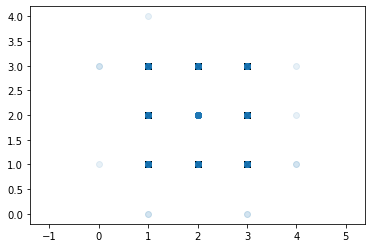

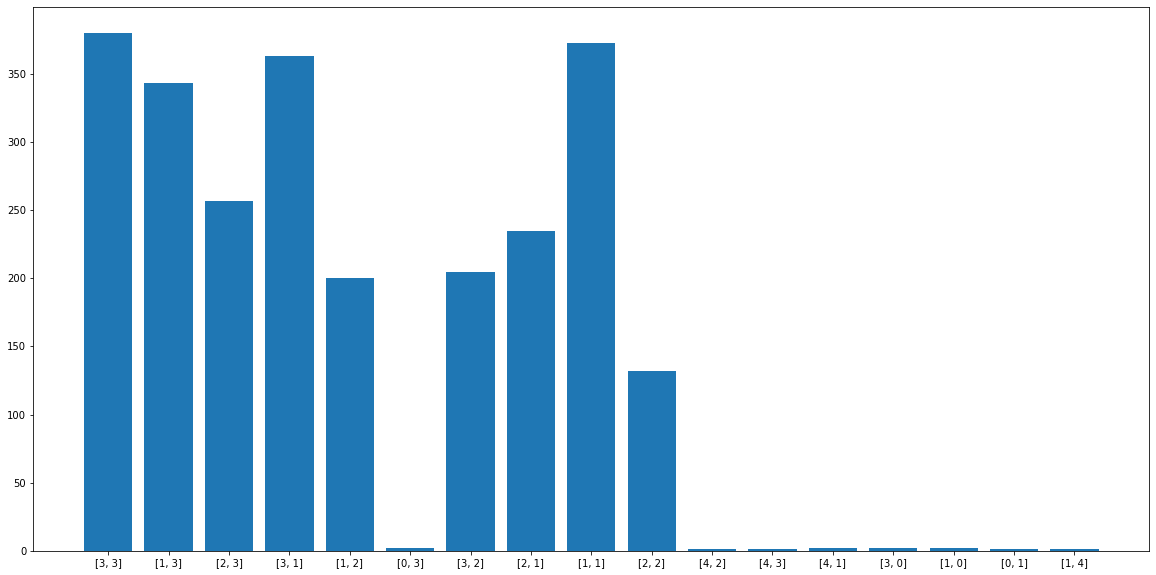

Processing Epoch 131
training start
Iteration 0, d real/fake loss 0.6196754574775696/0.65704345703125 and g loss is 0.7258058786392212, NDiv loss 0.047007106244564056
Iteration 1, d real/fake loss 0.6195317506790161/0.6587977409362793 and g loss is 0.7348160743713379, NDiv loss 0.0492376871407032
Iteration 2, d real/fake loss 0.6193698644638062/0.6608297824859619 and g loss is 0.7347205877304077, NDiv loss 0.051783762872219086
Iteration 3, d real/fake loss 0.6191965341567993/0.6570337414741516 and g loss is 0.7366797924041748, NDiv loss 0.048738326877355576
Iteration 4, d real/fake loss 0.6190097332000732/0.6643502712249756 and g loss is 0.7297872304916382, NDiv loss 0.04768207296729088


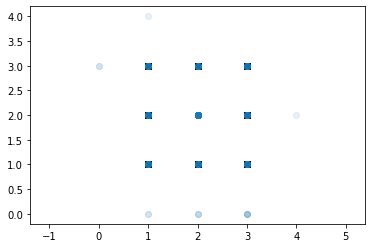

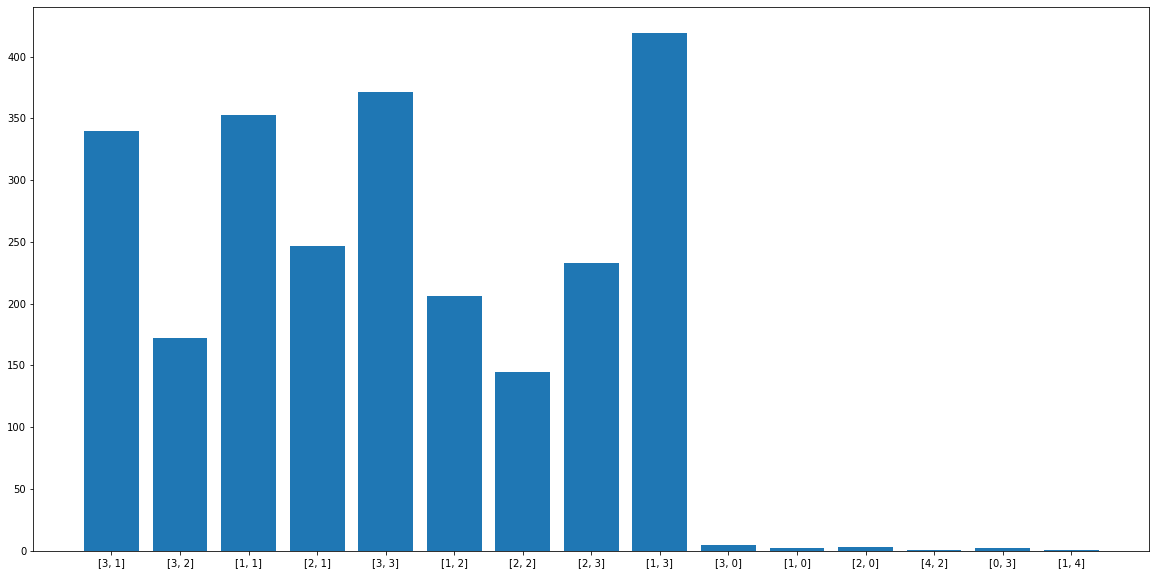

Processing Epoch 132
training start
Iteration 0, d real/fake loss 0.6203281879425049/0.6589474678039551 and g loss is 0.726074755191803, NDiv loss 0.0489528514444828
Iteration 1, d real/fake loss 0.6201439499855042/0.6529450416564941 and g loss is 0.7239466905593872, NDiv loss 0.04768189787864685
Iteration 2, d real/fake loss 0.619943380355835/0.6634547114372253 and g loss is 0.7256743311882019, NDiv loss 0.047071874141693115
Iteration 3, d real/fake loss 0.6197352409362793/0.6615458726882935 and g loss is 0.7401890754699707, NDiv loss 0.04765033349394798
Iteration 4, d real/fake loss 0.6195372343063354/0.6650688648223877 and g loss is 0.7235960960388184, NDiv loss 0.046957895159721375


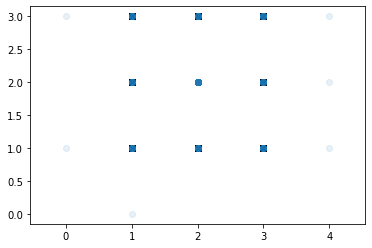

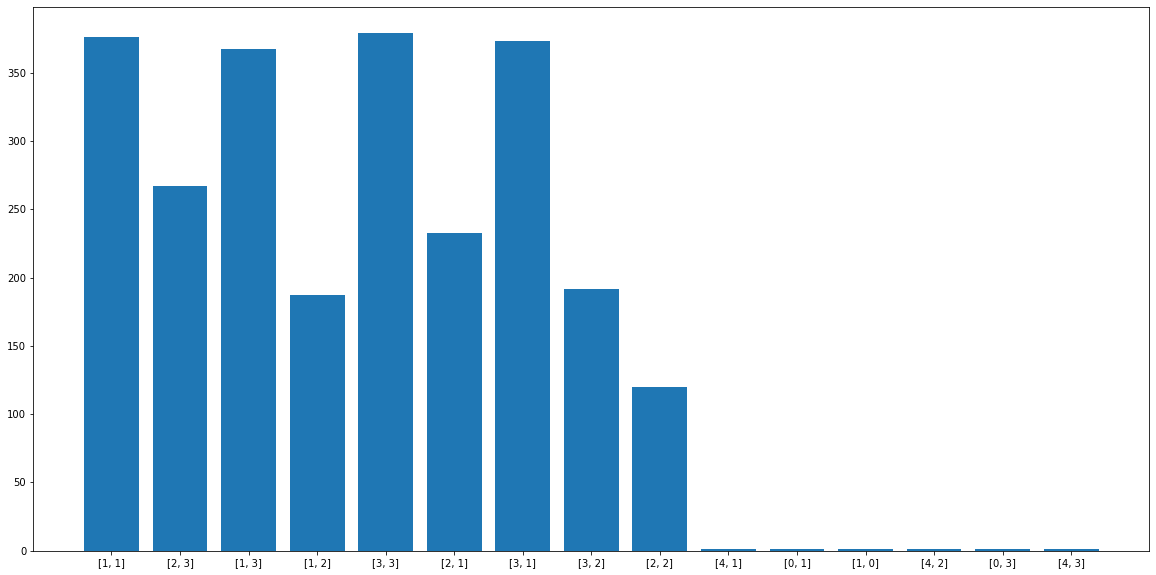

Processing Epoch 133
training start
Iteration 0, d real/fake loss 0.6186934113502502/0.662947416305542 and g loss is 0.729993999004364, NDiv loss 0.05039127916097641
Iteration 1, d real/fake loss 0.618488073348999/0.6575394868850708 and g loss is 0.7312096953392029, NDiv loss 0.04812407121062279
Iteration 2, d real/fake loss 0.6182742118835449/0.6583729386329651 and g loss is 0.7314060926437378, NDiv loss 0.05096421390771866
Iteration 3, d real/fake loss 0.6180510520935059/0.6566696166992188 and g loss is 0.7310753464698792, NDiv loss 0.0494401715695858
Iteration 4, d real/fake loss 0.6178140640258789/0.6612495183944702 and g loss is 0.7345001101493835, NDiv loss 0.04643096774816513


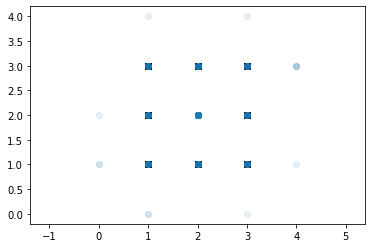

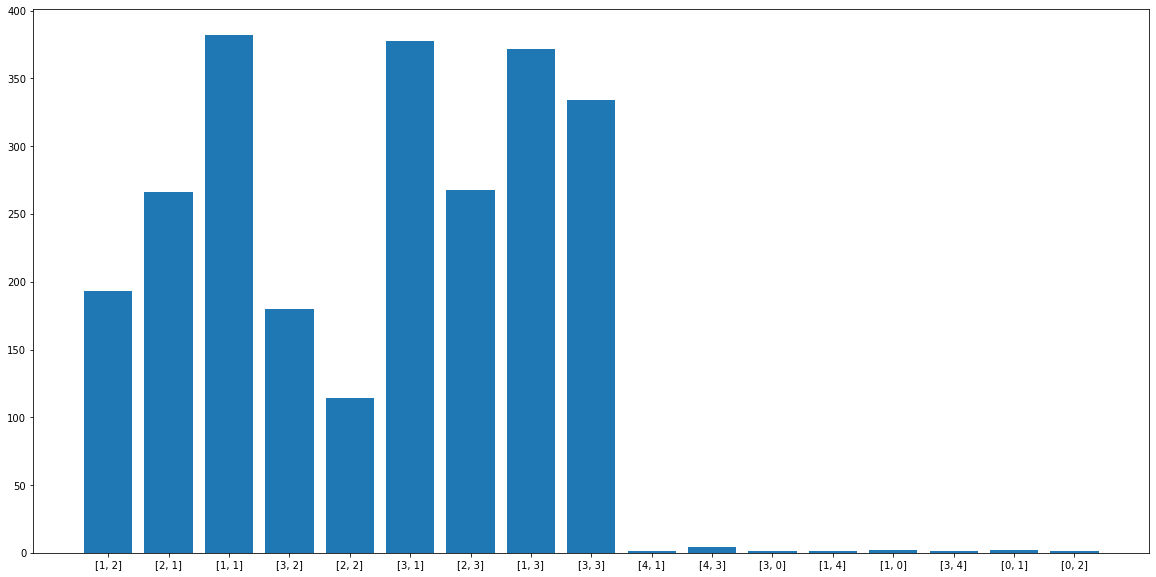

Processing Epoch 134
training start
Iteration 0, d real/fake loss 0.6178041696548462/0.6606563925743103 and g loss is 0.7293780446052551, NDiv loss 0.048760876059532166
Iteration 1, d real/fake loss 0.6176319122314453/0.656745433807373 and g loss is 0.7283155918121338, NDiv loss 0.04624919593334198
Iteration 2, d real/fake loss 0.6174501180648804/0.6591159105300903 and g loss is 0.7279068231582642, NDiv loss 0.04868731275200844
Iteration 3, d real/fake loss 0.617266833782196/0.6622666120529175 and g loss is 0.7324140071868896, NDiv loss 0.050245825201272964
Iteration 4, d real/fake loss 0.6170949935913086/0.6637229323387146 and g loss is 0.7303662300109863, NDiv loss 0.0497531034052372


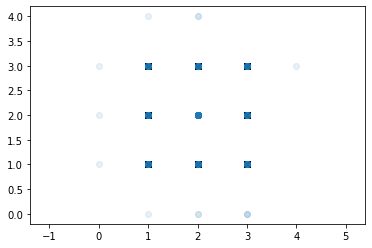

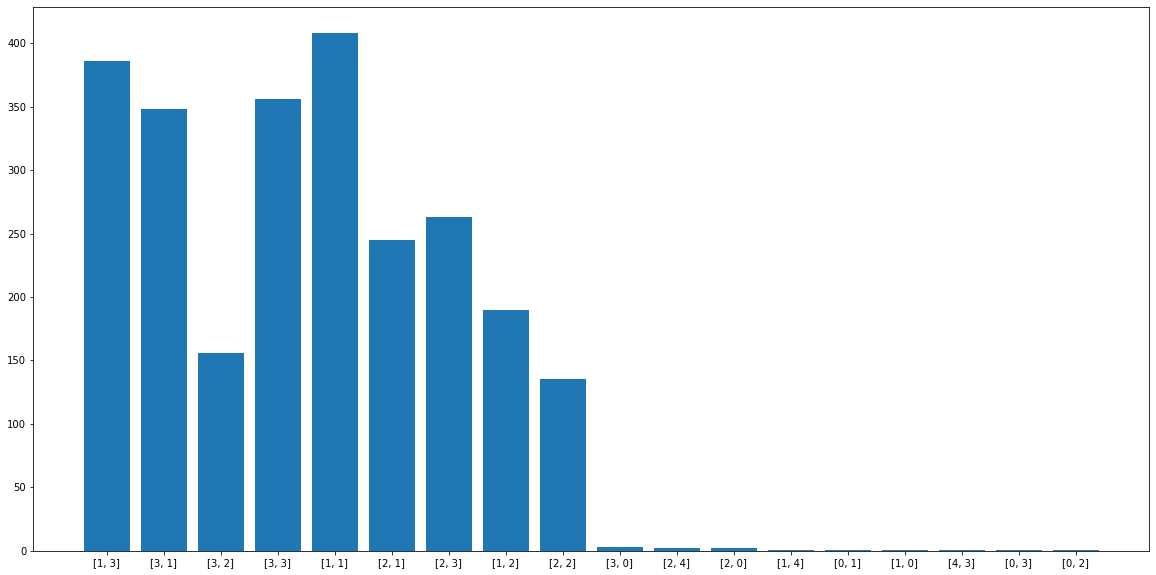

Processing Epoch 135
training start
Iteration 0, d real/fake loss 0.6161051988601685/0.6624029278755188 and g loss is 0.7349046468734741, NDiv loss 0.04927691072225571
Iteration 1, d real/fake loss 0.6160281896591187/0.6578065752983093 and g loss is 0.7271362543106079, NDiv loss 0.04777166619896889
Iteration 2, d real/fake loss 0.6159508228302002/0.6565755605697632 and g loss is 0.7304150462150574, NDiv loss 0.051210880279541016
Iteration 3, d real/fake loss 0.6158716678619385/0.6592055559158325 and g loss is 0.7314157485961914, NDiv loss 0.051628727465867996
Iteration 4, d real/fake loss 0.6157938241958618/0.649081826210022 and g loss is 0.734006404876709, NDiv loss 0.05393129959702492


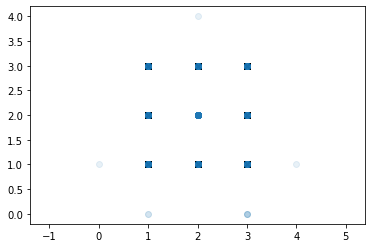

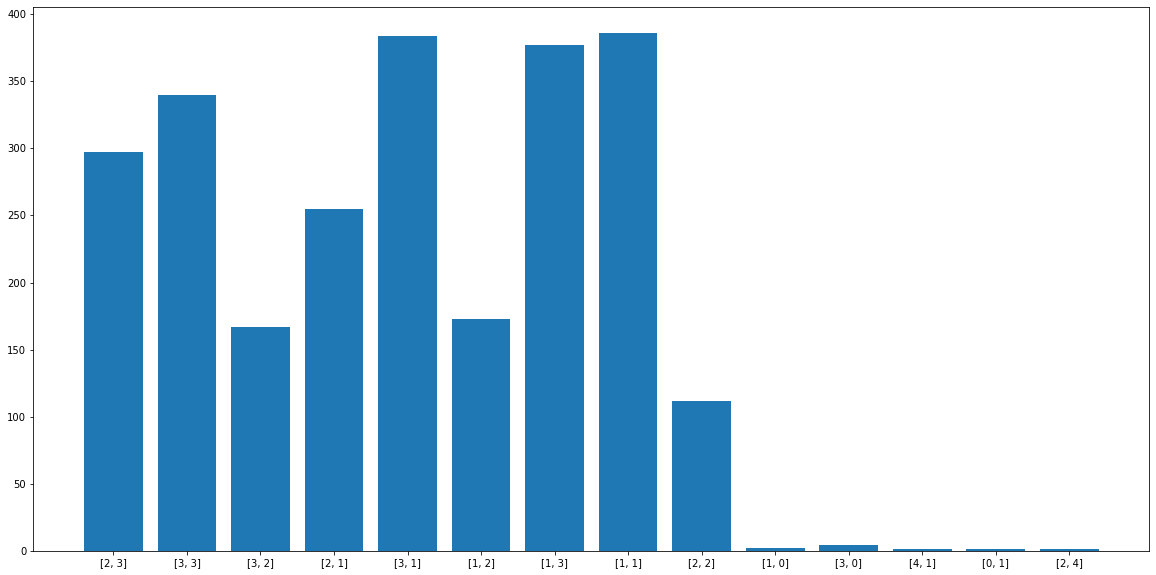

Processing Epoch 136
training start
Iteration 0, d real/fake loss 0.6135910749435425/0.6587265729904175 and g loss is 0.7309088706970215, NDiv loss 0.04634895175695419
Iteration 1, d real/fake loss 0.6134912967681885/0.6622829437255859 and g loss is 0.7388656735420227, NDiv loss 0.04731186851859093
Iteration 2, d real/fake loss 0.6133977174758911/0.6562931537628174 and g loss is 0.733347475528717, NDiv loss 0.04909735172986984
Iteration 3, d real/fake loss 0.6132986545562744/0.6507287621498108 and g loss is 0.7387021780014038, NDiv loss 0.05186789110302925
Iteration 4, d real/fake loss 0.6131865978240967/0.6551257371902466 and g loss is 0.7329285144805908, NDiv loss 0.047352924942970276


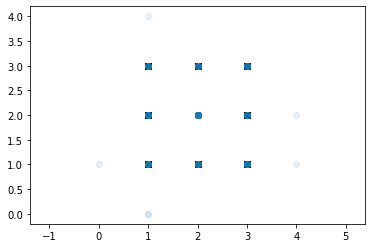

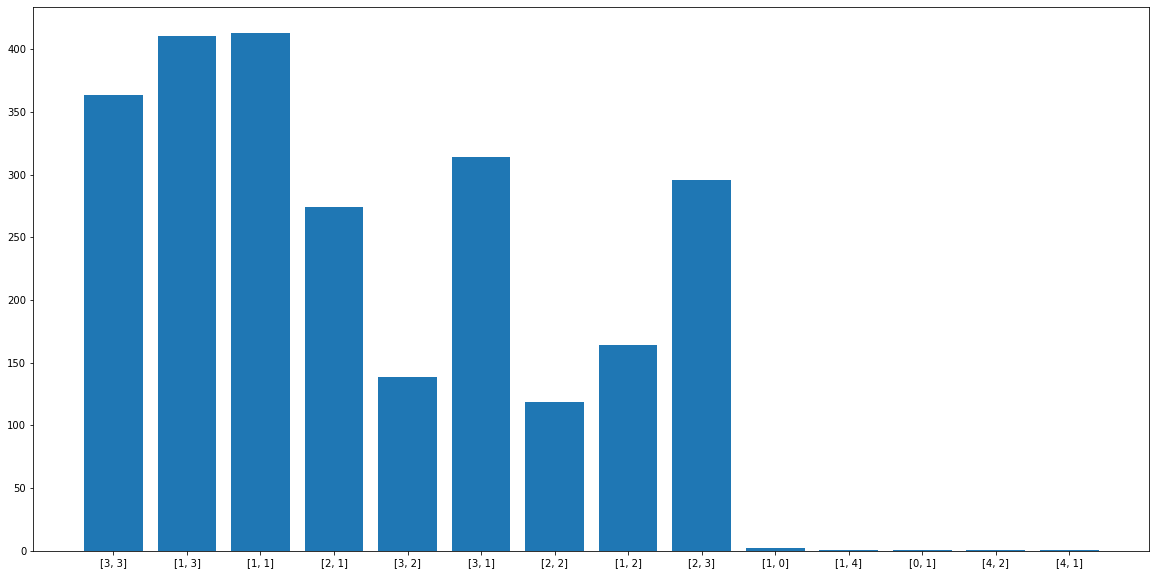

Processing Epoch 137
training start
Iteration 0, d real/fake loss 0.6156148314476013/0.6591383218765259 and g loss is 0.736811101436615, NDiv loss 0.048358380794525146
Iteration 1, d real/fake loss 0.6154614090919495/0.6596142053604126 and g loss is 0.7329741716384888, NDiv loss 0.04934322088956833
Iteration 2, d real/fake loss 0.6152963638305664/0.6602679491043091 and g loss is 0.7304879426956177, NDiv loss 0.051071908324956894
Iteration 3, d real/fake loss 0.6151242852210999/0.6623384356498718 and g loss is 0.7323431968688965, NDiv loss 0.0512264259159565
Iteration 4, d real/fake loss 0.6149436235427856/0.6519227623939514 and g loss is 0.7280704975128174, NDiv loss 0.051484689116477966


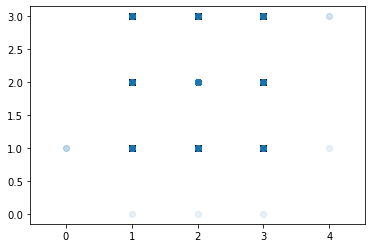

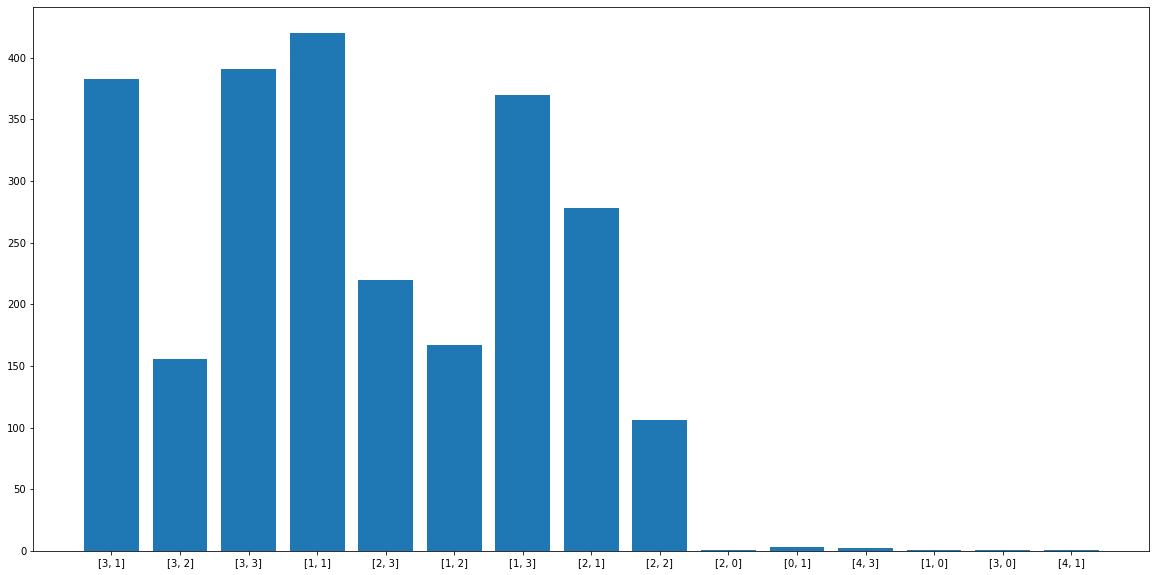

Processing Epoch 138
training start
Iteration 0, d real/fake loss 0.6143316030502319/0.6571728587150574 and g loss is 0.7323629856109619, NDiv loss 0.048960767686367035
Iteration 1, d real/fake loss 0.6142480373382568/0.6578290462493896 and g loss is 0.7347276210784912, NDiv loss 0.04899422824382782
Iteration 2, d real/fake loss 0.6141657829284668/0.6578183770179749 and g loss is 0.7344865798950195, NDiv loss 0.04906637966632843
Iteration 3, d real/fake loss 0.6140789985656738/0.65510094165802 and g loss is 0.7307218909263611, NDiv loss 0.046284448355436325
Iteration 4, d real/fake loss 0.6139939427375793/0.6572716236114502 and g loss is 0.7357096076011658, NDiv loss 0.04717773571610451


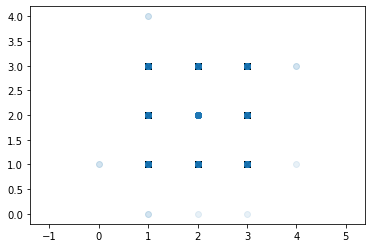

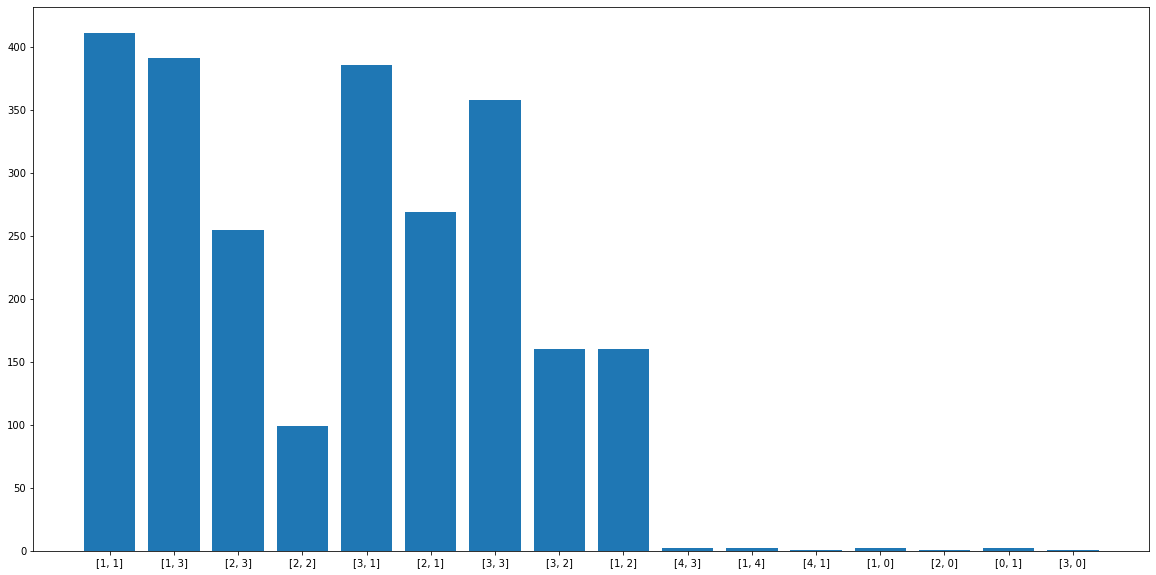

Processing Epoch 139
training start
Iteration 0, d real/fake loss 0.6139498949050903/0.6574327945709229 and g loss is 0.739173948764801, NDiv loss 0.05147019401192665
Iteration 1, d real/fake loss 0.6138094067573547/0.6528725624084473 and g loss is 0.7338398098945618, NDiv loss 0.049934785813093185
Iteration 2, d real/fake loss 0.6136536002159119/0.6596969366073608 and g loss is 0.7348867654800415, NDiv loss 0.04645554721355438
Iteration 3, d real/fake loss 0.6134979724884033/0.6568580269813538 and g loss is 0.7314186096191406, NDiv loss 0.04800892621278763
Iteration 4, d real/fake loss 0.6133412718772888/0.656199038028717 and g loss is 0.7322421073913574, NDiv loss 0.050502993166446686


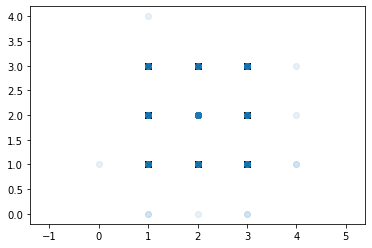

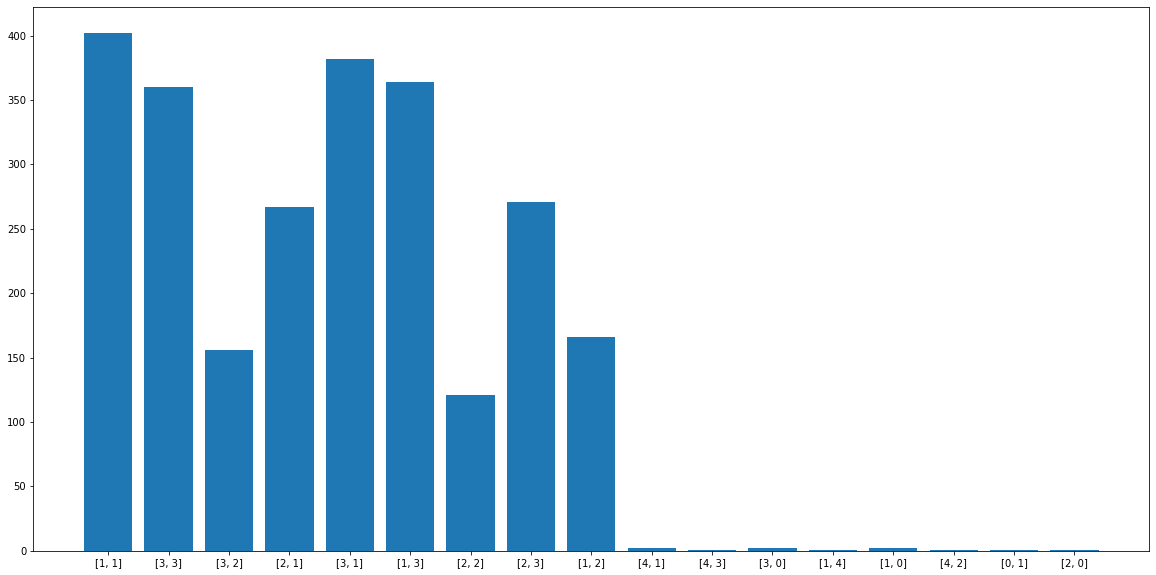

Processing Epoch 140
training start
Iteration 0, d real/fake loss 0.6159828305244446/0.6545225381851196 and g loss is 0.736991286277771, NDiv loss 0.05088142305612564
Iteration 1, d real/fake loss 0.615915060043335/0.6555121541023254 and g loss is 0.7303392887115479, NDiv loss 0.05041859671473503
Iteration 2, d real/fake loss 0.6158360838890076/0.6510600447654724 and g loss is 0.736173152923584, NDiv loss 0.04728991538286209
Iteration 3, d real/fake loss 0.6157383322715759/0.6598307490348816 and g loss is 0.7338536977767944, NDiv loss 0.04920266196131706
Iteration 4, d real/fake loss 0.6156423091888428/0.6495522260665894 and g loss is 0.7404547333717346, NDiv loss 0.04879593476653099


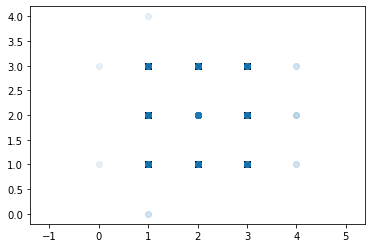

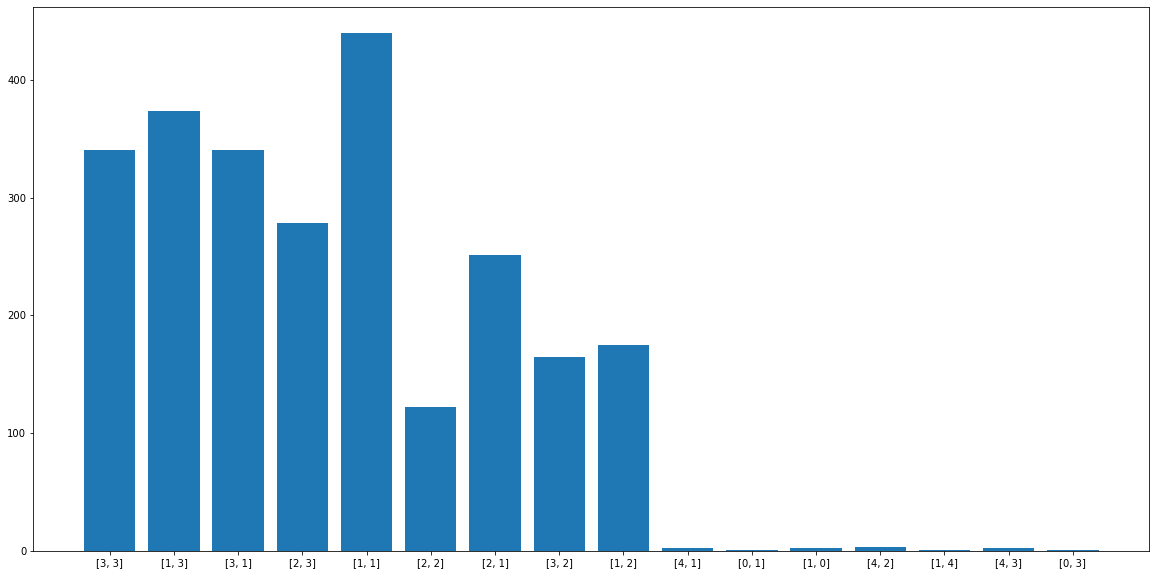

Processing Epoch 141
training start
Iteration 0, d real/fake loss 0.6150887608528137/0.6521106958389282 and g loss is 0.7402240037918091, NDiv loss 0.05030176416039467
Iteration 1, d real/fake loss 0.6149914264678955/0.6541523337364197 and g loss is 0.7357742786407471, NDiv loss 0.0502624474465847
Iteration 2, d real/fake loss 0.6148874759674072/0.6553168296813965 and g loss is 0.7438350915908813, NDiv loss 0.05091309919953346
Iteration 3, d real/fake loss 0.6147793531417847/0.6634780168533325 and g loss is 0.7338995933532715, NDiv loss 0.04939581826329231
Iteration 4, d real/fake loss 0.6146790981292725/0.6525653004646301 and g loss is 0.7316145896911621, NDiv loss 0.05104281008243561


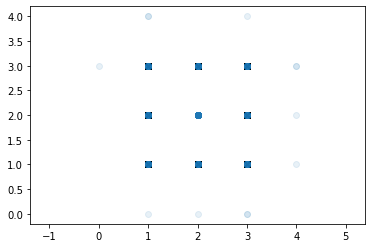

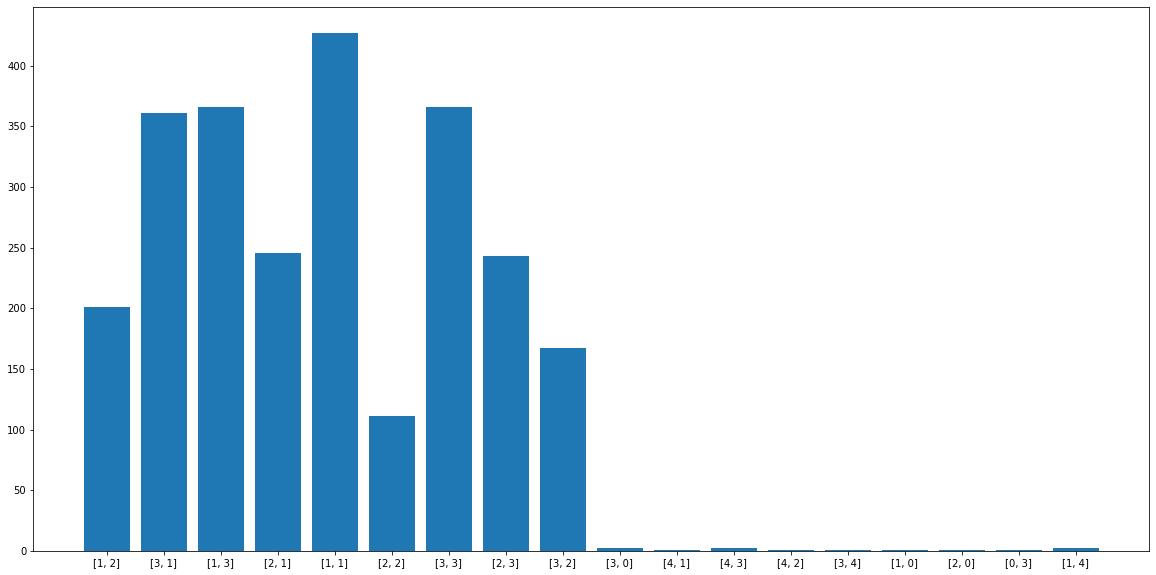

Processing Epoch 142
training start
Iteration 0, d real/fake loss 0.6125868558883667/0.6559756994247437 and g loss is 0.7378180027008057, NDiv loss 0.05319336801767349
Iteration 1, d real/fake loss 0.6125088930130005/0.6468289494514465 and g loss is 0.7395449280738831, NDiv loss 0.04955819621682167
Iteration 2, d real/fake loss 0.6124260425567627/0.6546057462692261 and g loss is 0.7368873357772827, NDiv loss 0.047854945063591
Iteration 3, d real/fake loss 0.6123462915420532/0.6520489454269409 and g loss is 0.7418668270111084, NDiv loss 0.05257093533873558
Iteration 4, d real/fake loss 0.6122636795043945/0.6528795957565308 and g loss is 0.7364896535873413, NDiv loss 0.04825945943593979


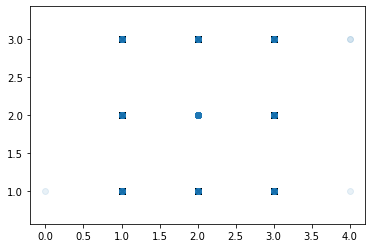

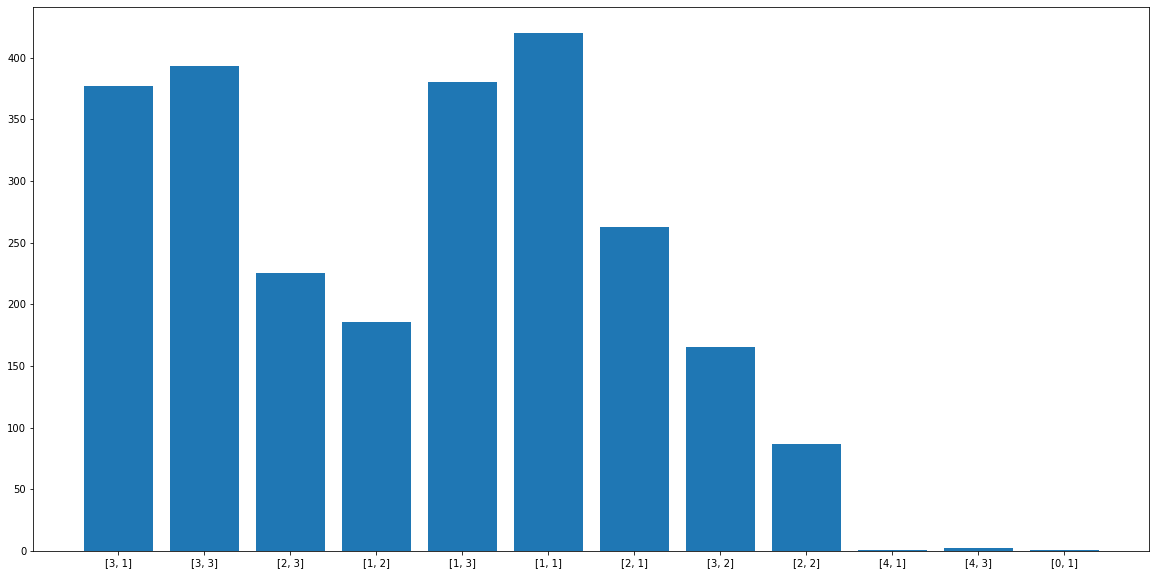

Processing Epoch 143
training start
Iteration 0, d real/fake loss 0.6135315895080566/0.6535668969154358 and g loss is 0.7313709259033203, NDiv loss 0.04891422390937805
Iteration 1, d real/fake loss 0.6134448051452637/0.6544957756996155 and g loss is 0.7367458939552307, NDiv loss 0.051659565418958664
Iteration 2, d real/fake loss 0.6133526563644409/0.6575392484664917 and g loss is 0.7388503551483154, NDiv loss 0.049715541303157806
Iteration 3, d real/fake loss 0.6132615208625793/0.6476141214370728 and g loss is 0.7312736511230469, NDiv loss 0.051437895745038986
Iteration 4, d real/fake loss 0.6131563186645508/0.6495314240455627 and g loss is 0.7362668514251709, NDiv loss 0.04817792400717735


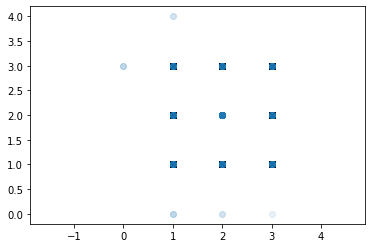

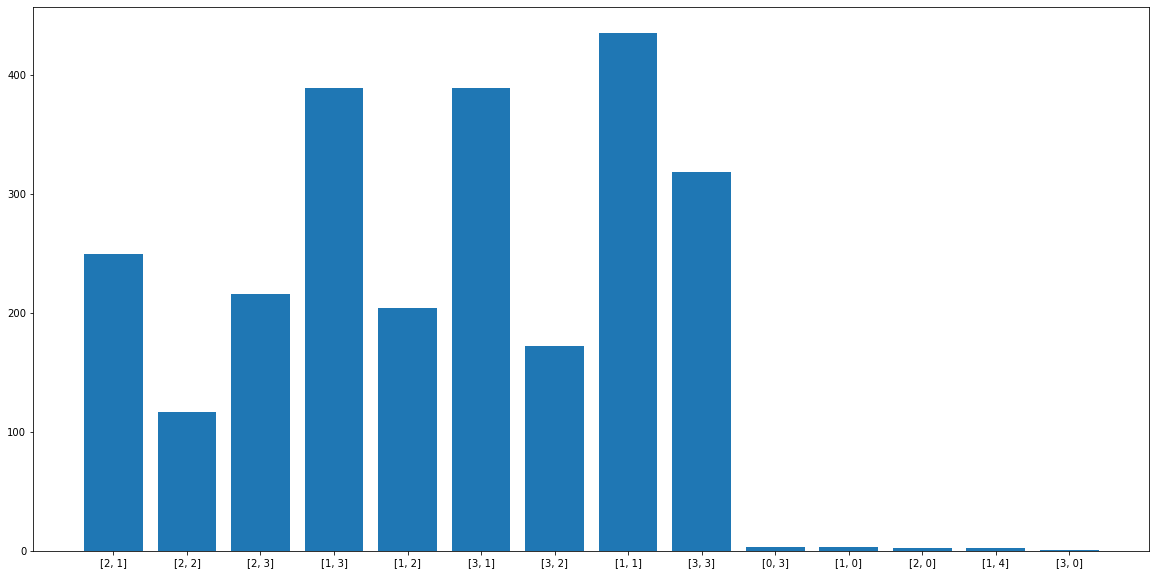

Processing Epoch 144
training start
Iteration 0, d real/fake loss 0.6105568408966064/0.652229905128479 and g loss is 0.7320858240127563, NDiv loss 0.04895170405507088
Iteration 1, d real/fake loss 0.6104702949523926/0.6493605375289917 and g loss is 0.7387559413909912, NDiv loss 0.050309665501117706
Iteration 2, d real/fake loss 0.6103750467300415/0.6507769823074341 and g loss is 0.7442441582679749, NDiv loss 0.049106765538454056
Iteration 3, d real/fake loss 0.610275149345398/0.6540811657905579 and g loss is 0.7455868721008301, NDiv loss 0.04940412938594818
Iteration 4, d real/fake loss 0.610180139541626/0.6497263312339783 and g loss is 0.7355804443359375, NDiv loss 0.05052349343895912


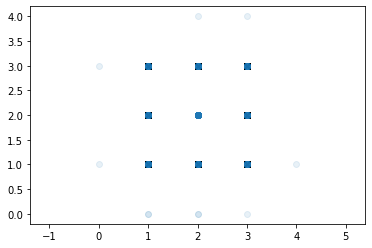

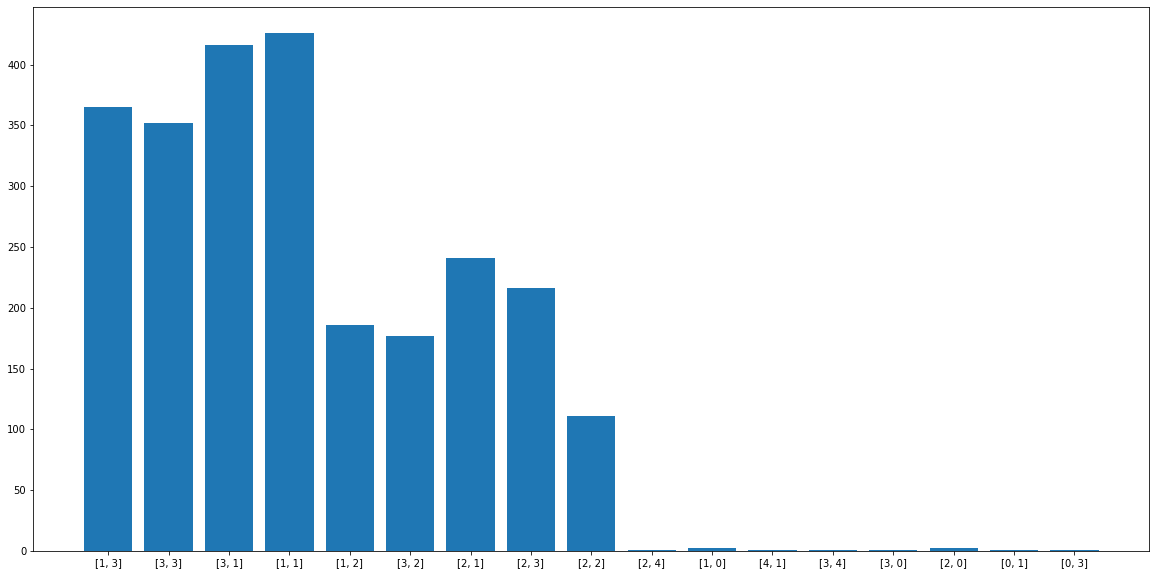

Processing Epoch 145
training start
Iteration 0, d real/fake loss 0.6099798679351807/0.6487647891044617 and g loss is 0.7446401119232178, NDiv loss 0.0484590157866478
Iteration 1, d real/fake loss 0.609851062297821/0.6537153124809265 and g loss is 0.748397707939148, NDiv loss 0.051692478358745575
Iteration 2, d real/fake loss 0.6097242832183838/0.6501245498657227 and g loss is 0.7392600178718567, NDiv loss 0.05231454223394394
Iteration 3, d real/fake loss 0.60959392786026/0.6559002995491028 and g loss is 0.7377005219459534, NDiv loss 0.04863421618938446
Iteration 4, d real/fake loss 0.6094717979431152/0.6488620042800903 and g loss is 0.7376174330711365, NDiv loss 0.05015137791633606


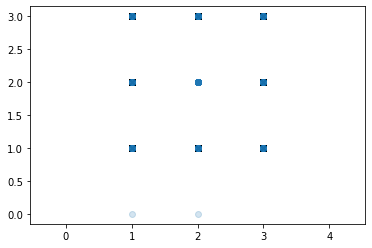

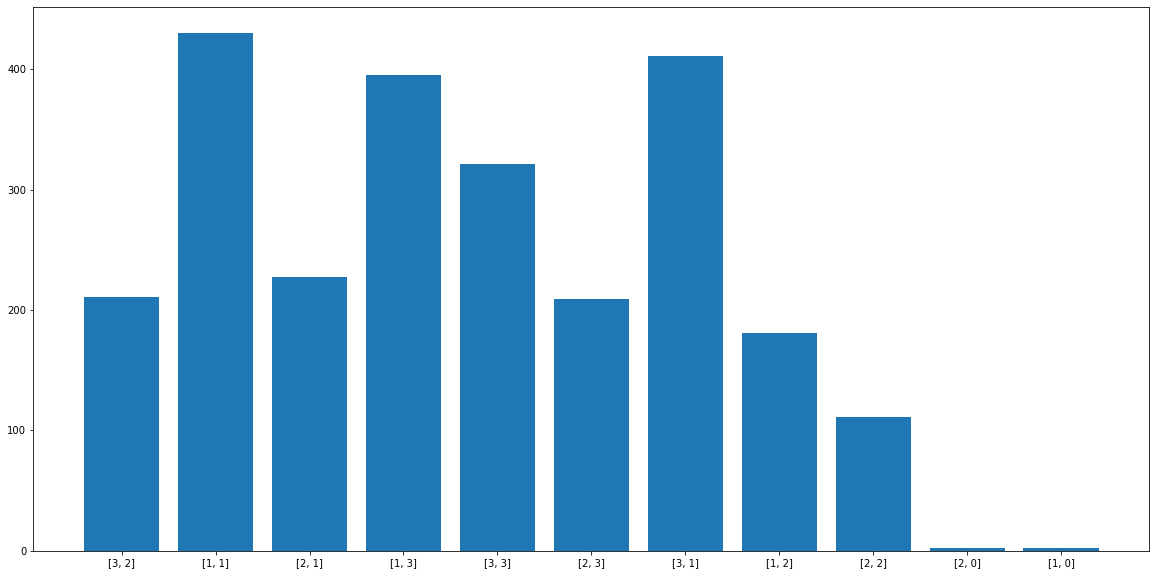

Processing Epoch 146
training start
Iteration 0, d real/fake loss 0.6117974519729614/0.6453856825828552 and g loss is 0.7455803155899048, NDiv loss 0.0506039634346962
Iteration 1, d real/fake loss 0.6116791367530823/0.648026704788208 and g loss is 0.7361507415771484, NDiv loss 0.05045606568455696
Iteration 2, d real/fake loss 0.6115425825119019/0.6497479677200317 and g loss is 0.745132565498352, NDiv loss 0.04996347054839134
Iteration 3, d real/fake loss 0.6113954782485962/0.6466216444969177 and g loss is 0.7384828329086304, NDiv loss 0.051461637020111084
Iteration 4, d real/fake loss 0.6112403869628906/0.6464201211929321 and g loss is 0.7407654523849487, NDiv loss 0.0484173484146595


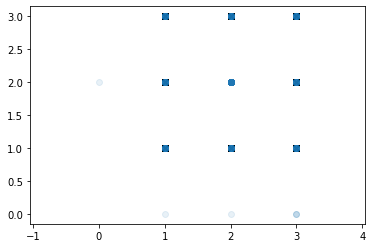

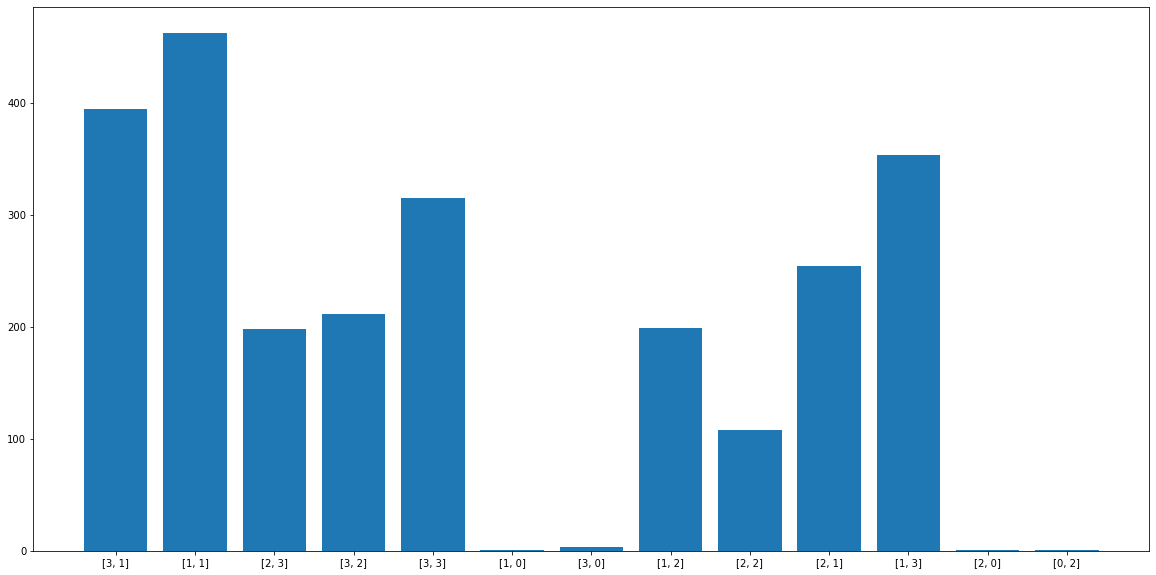

Processing Epoch 147
training start
Iteration 0, d real/fake loss 0.6081780791282654/0.656930685043335 and g loss is 0.7415111064910889, NDiv loss 0.04951583221554756
Iteration 1, d real/fake loss 0.607994556427002/0.6445320844650269 and g loss is 0.7515362501144409, NDiv loss 0.04904089868068695
Iteration 2, d real/fake loss 0.6077964305877686/0.655109167098999 and g loss is 0.7373196482658386, NDiv loss 0.04890967532992363
Iteration 3, d real/fake loss 0.6076018214225769/0.6505976319313049 and g loss is 0.7333313226699829, NDiv loss 0.04854849353432655
Iteration 4, d real/fake loss 0.6074000597000122/0.6441696882247925 and g loss is 0.7476063966751099, NDiv loss 0.04884176328778267


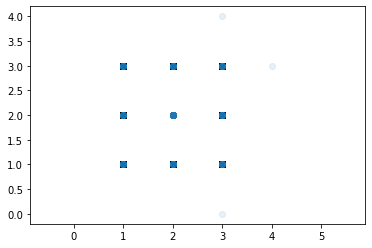

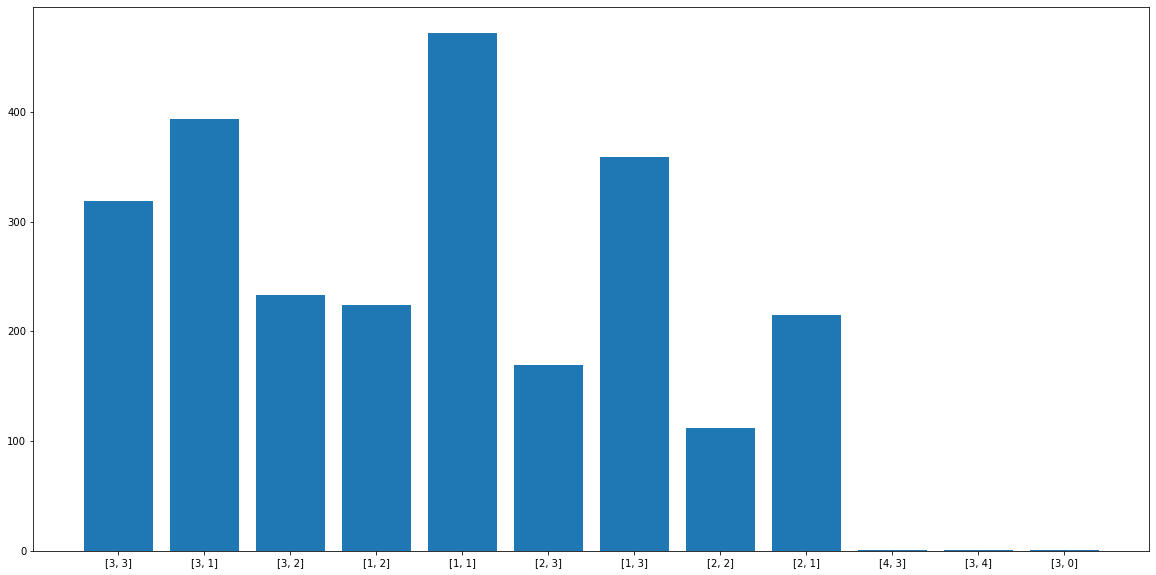

Processing Epoch 148
training start
Iteration 0, d real/fake loss 0.6126556396484375/0.6437875032424927 and g loss is 0.739779531955719, NDiv loss 0.050456564873456955
Iteration 1, d real/fake loss 0.6125597953796387/0.6508347988128662 and g loss is 0.7372804284095764, NDiv loss 0.04947184771299362
Iteration 2, d real/fake loss 0.6124605536460876/0.6520875692367554 and g loss is 0.7341103553771973, NDiv loss 0.0485394187271595
Iteration 3, d real/fake loss 0.6123507022857666/0.6478274464607239 and g loss is 0.7402245998382568, NDiv loss 0.04854302108287811
Iteration 4, d real/fake loss 0.6122245788574219/0.6508354544639587 and g loss is 0.732654333114624, NDiv loss 0.05002152919769287


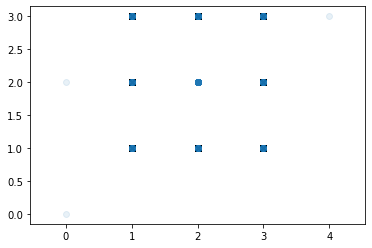

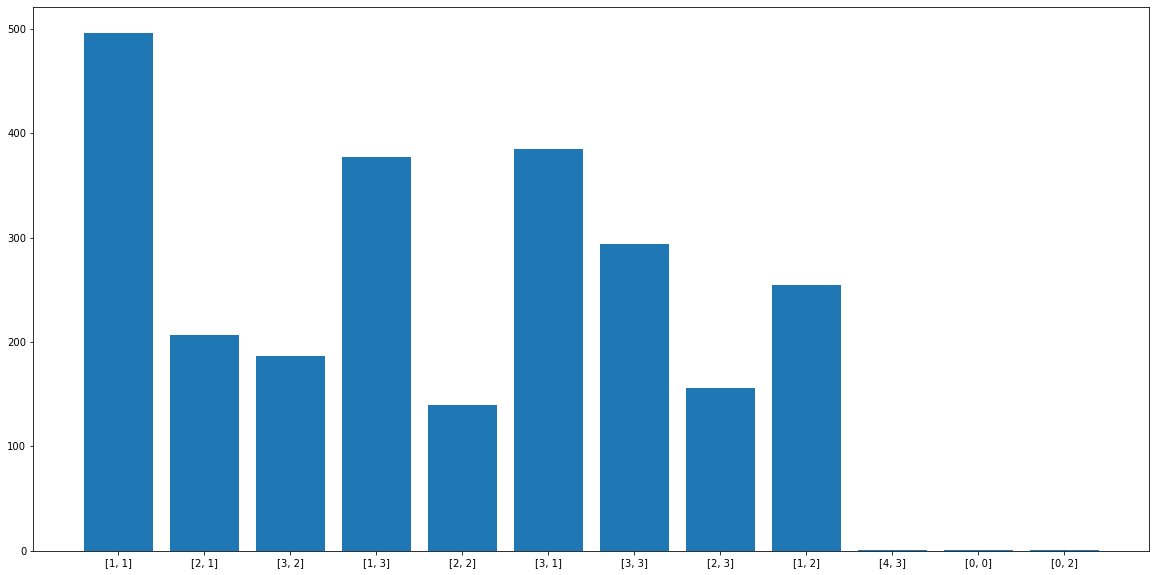

Processing Epoch 149
training start
Iteration 0, d real/fake loss 0.6102905869483948/0.6537747383117676 and g loss is 0.7345412969589233, NDiv loss 0.051826734095811844
Iteration 1, d real/fake loss 0.610169529914856/0.6531497836112976 and g loss is 0.7408101558685303, NDiv loss 0.0514858216047287
Iteration 2, d real/fake loss 0.6100413799285889/0.6553359031677246 and g loss is 0.7447153925895691, NDiv loss 0.05088046193122864
Iteration 3, d real/fake loss 0.6099120378494263/0.644690990447998 and g loss is 0.7351398468017578, NDiv loss 0.05010460689663887
Iteration 4, d real/fake loss 0.6097617149353027/0.6489637494087219 and g loss is 0.742308497428894, NDiv loss 0.049933649599552155


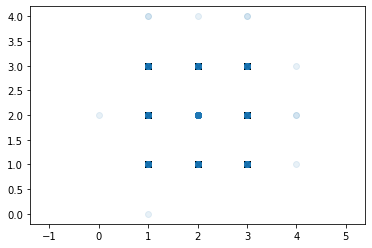

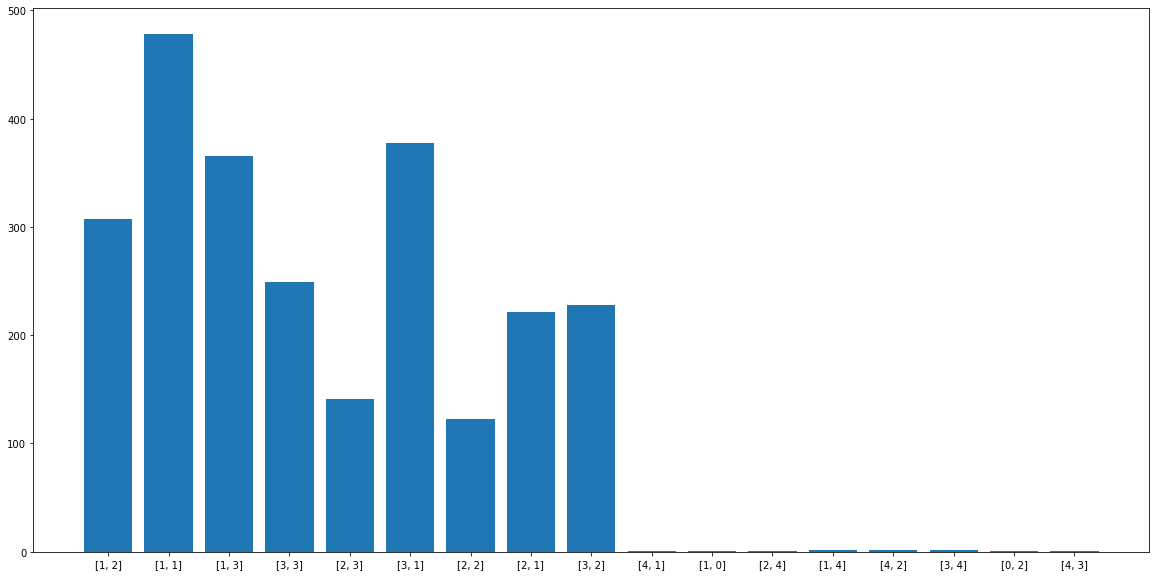

Processing Epoch 150
training start
Iteration 0, d real/fake loss 0.6088279485702515/0.6480264663696289 and g loss is 0.7410200834274292, NDiv loss 0.05088786780834198
Iteration 1, d real/fake loss 0.6087026596069336/0.6542327404022217 and g loss is 0.7432506084442139, NDiv loss 0.04825051128864288
Iteration 2, d real/fake loss 0.6085817813873291/0.6465568542480469 and g loss is 0.7383393049240112, NDiv loss 0.050793327391147614
Iteration 3, d real/fake loss 0.608454704284668/0.6473917961120605 and g loss is 0.7352787256240845, NDiv loss 0.048696715384721756
Iteration 4, d real/fake loss 0.6083193421363831/0.6448595523834229 and g loss is 0.7433677911758423, NDiv loss 0.04996471107006073


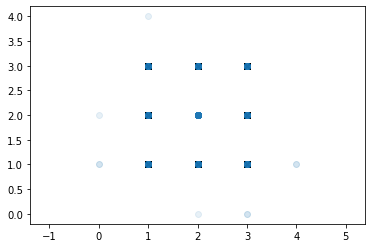

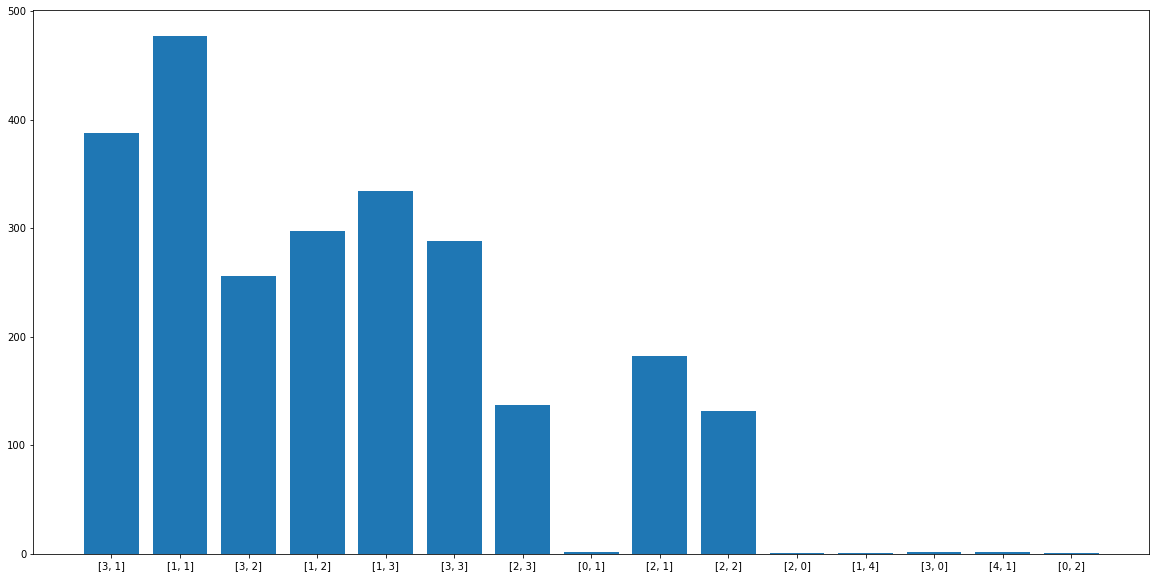

Processing Epoch 151
training start
Iteration 0, d real/fake loss 0.6112106442451477/0.6608331203460693 and g loss is 0.747113823890686, NDiv loss 0.047758620232343674
Iteration 1, d real/fake loss 0.6111043095588684/0.6519414186477661 and g loss is 0.7444454431533813, NDiv loss 0.048471130430698395
Iteration 2, d real/fake loss 0.6109846830368042/0.6426856517791748 and g loss is 0.7435023188591003, NDiv loss 0.048177383840084076
Iteration 3, d real/fake loss 0.6108367443084717/0.6535972952842712 and g loss is 0.7392706274986267, NDiv loss 0.0520390048623085
Iteration 4, d real/fake loss 0.610686719417572/0.6428045034408569 and g loss is 0.7429484128952026, NDiv loss 0.051150303333997726


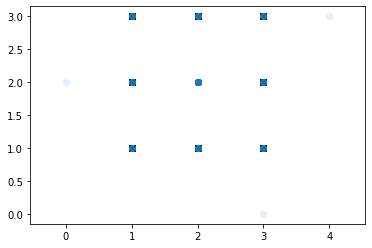

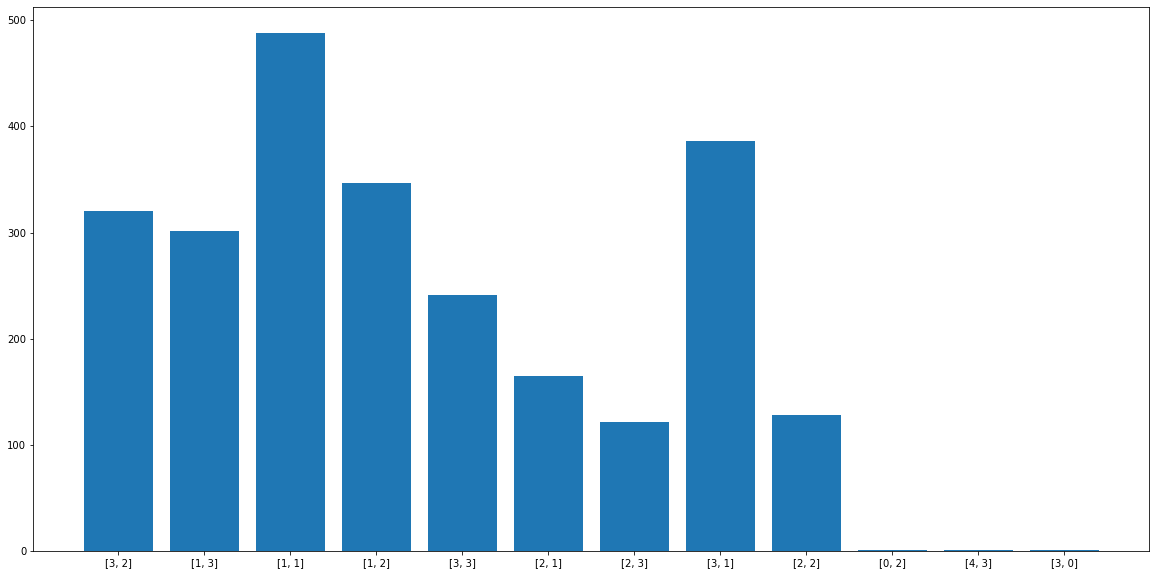

Processing Epoch 152
training start
Iteration 0, d real/fake loss 0.6051762104034424/0.6439192295074463 and g loss is 0.734045147895813, NDiv loss 0.04941805452108383
Iteration 1, d real/fake loss 0.605019211769104/0.6530858278274536 and g loss is 0.7394304275512695, NDiv loss 0.05087699368596077
Iteration 2, d real/fake loss 0.6048631072044373/0.6456283330917358 and g loss is 0.7410905957221985, NDiv loss 0.04913835600018501
Iteration 3, d real/fake loss 0.604698657989502/0.6490495204925537 and g loss is 0.7367233037948608, NDiv loss 0.053427666425704956
Iteration 4, d real/fake loss 0.6045324802398682/0.6485862135887146 and g loss is 0.7411589622497559, NDiv loss 0.050957851111888885


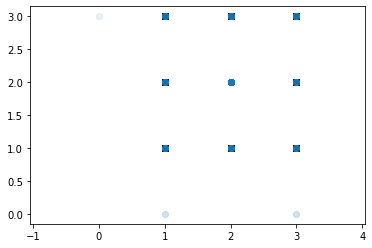

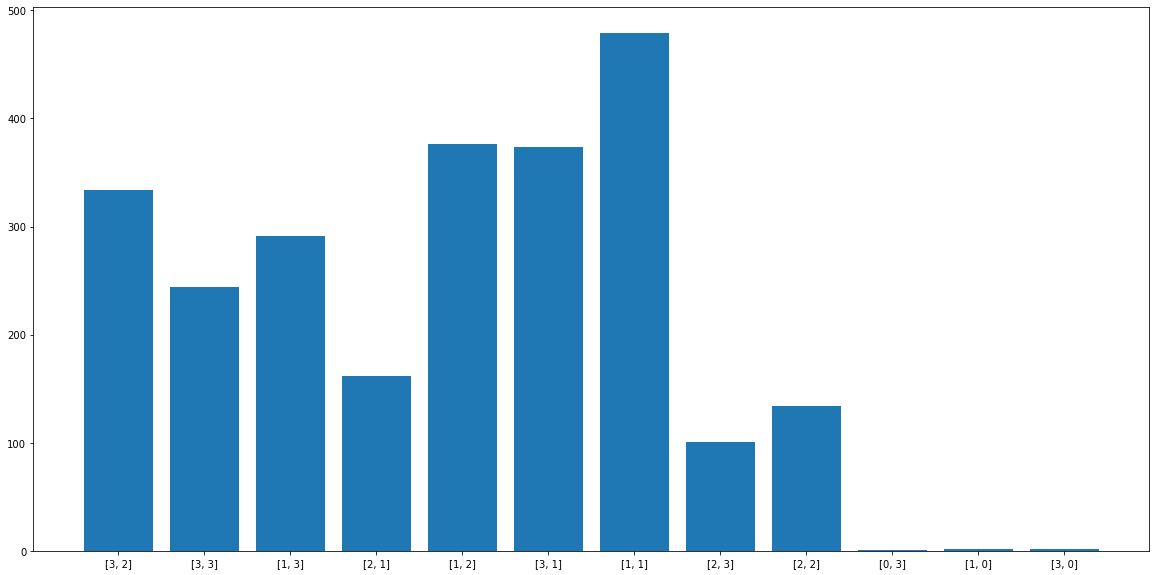

Processing Epoch 153
training start
Iteration 0, d real/fake loss 0.609287440776825/0.6502576470375061 and g loss is 0.7379399538040161, NDiv loss 0.05018024891614914
Iteration 1, d real/fake loss 0.6090330481529236/0.647184431552887 and g loss is 0.7547740340232849, NDiv loss 0.052305106073617935
Iteration 2, d real/fake loss 0.6087435483932495/0.6490800380706787 and g loss is 0.735482931137085, NDiv loss 0.050652988255023956
Iteration 3, d real/fake loss 0.6084239482879639/0.6425985097885132 and g loss is 0.7343175411224365, NDiv loss 0.0481313019990921
Iteration 4, d real/fake loss 0.6080576181411743/0.6555476188659668 and g loss is 0.7427142858505249, NDiv loss 0.0493464395403862


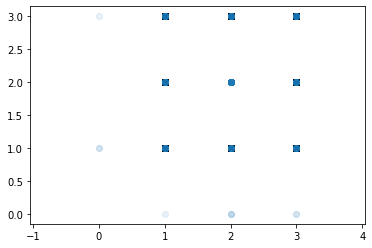

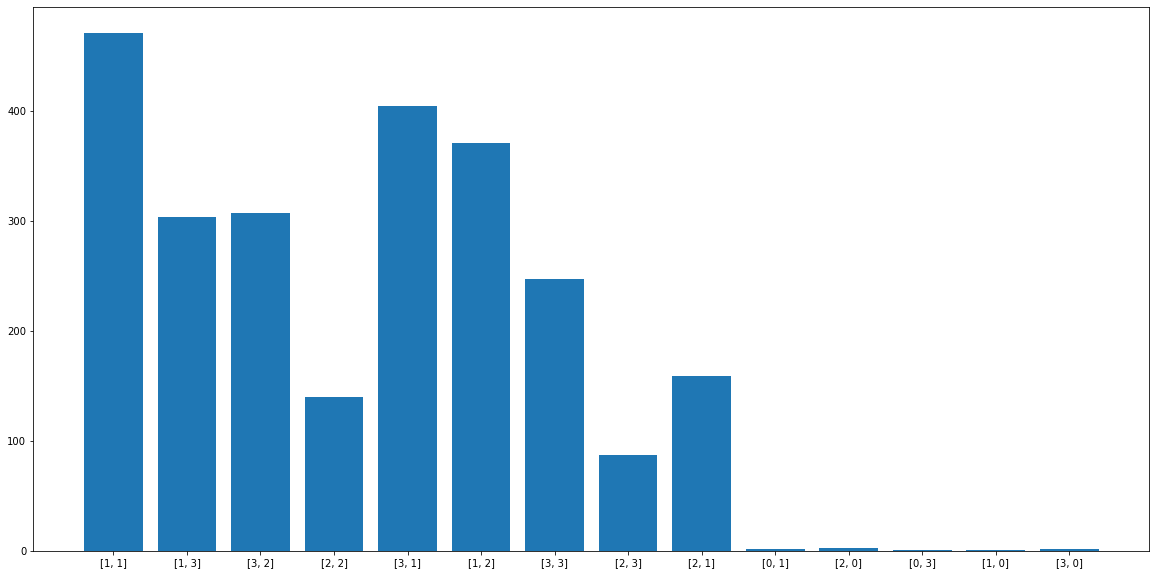

Processing Epoch 154
training start
Iteration 0, d real/fake loss 0.6055712103843689/0.6558994054794312 and g loss is 0.747271716594696, NDiv loss 0.04781479388475418
Iteration 1, d real/fake loss 0.6053768396377563/0.6461188793182373 and g loss is 0.7437431216239929, NDiv loss 0.051317282021045685
Iteration 2, d real/fake loss 0.6051807999610901/0.6461470127105713 and g loss is 0.7509869337081909, NDiv loss 0.04932954162359238
Iteration 3, d real/fake loss 0.6049847602844238/0.6449500918388367 and g loss is 0.7400671243667603, NDiv loss 0.051240622997283936
Iteration 4, d real/fake loss 0.6047813892364502/0.6460778713226318 and g loss is 0.7489101886749268, NDiv loss 0.05172637850046158


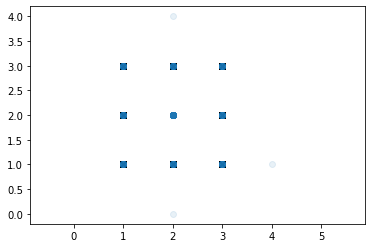

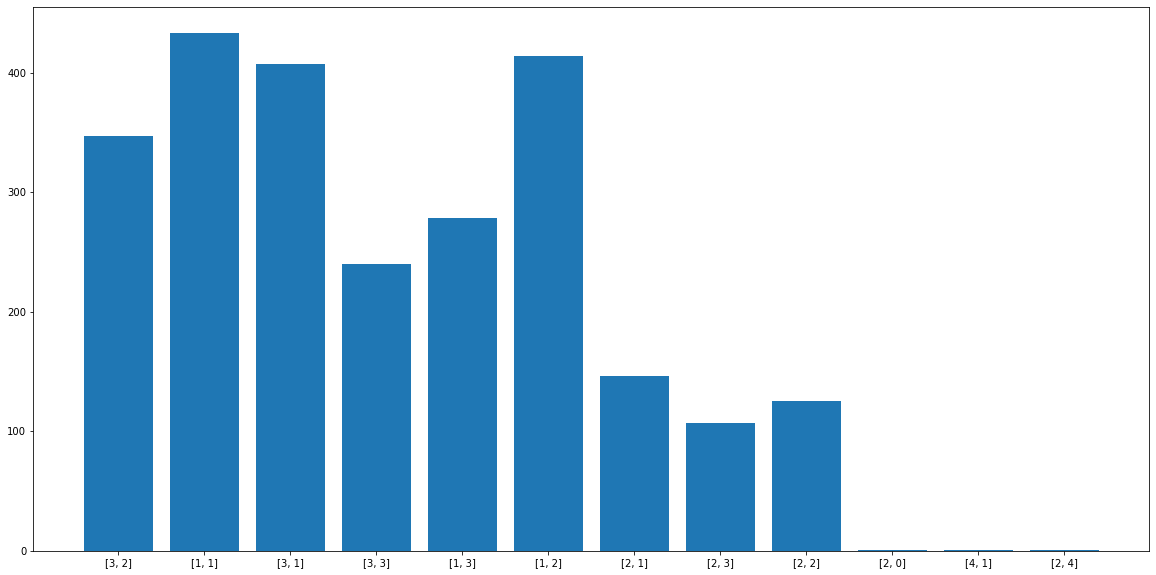

Processing Epoch 155
training start
Iteration 0, d real/fake loss 0.6038956046104431/0.6522242426872253 and g loss is 0.7411150932312012, NDiv loss 0.04859485849738121
Iteration 1, d real/fake loss 0.603654682636261/0.6468914747238159 and g loss is 0.7434886693954468, NDiv loss 0.052105098962783813
Iteration 2, d real/fake loss 0.6034078598022461/0.657052218914032 and g loss is 0.7418088912963867, NDiv loss 0.052315980195999146
Iteration 3, d real/fake loss 0.6031783819198608/0.6493809223175049 and g loss is 0.7456207275390625, NDiv loss 0.051751963794231415
Iteration 4, d real/fake loss 0.6029549837112427/0.6545562744140625 and g loss is 0.747323751449585, NDiv loss 0.049831729382276535


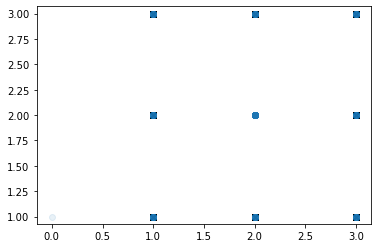

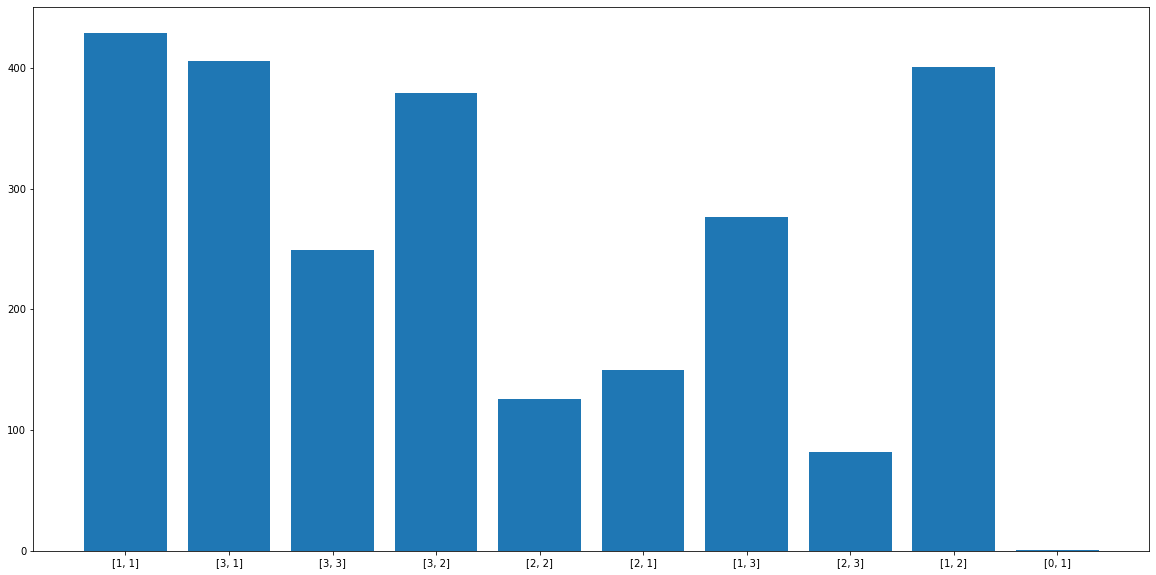

Processing Epoch 156
training start
Iteration 0, d real/fake loss 0.6064538359642029/0.6531463861465454 and g loss is 0.7460404634475708, NDiv loss 0.0514354482293129
Iteration 1, d real/fake loss 0.6063559651374817/0.6555293798446655 and g loss is 0.7399746179580688, NDiv loss 0.05253242701292038
Iteration 2, d real/fake loss 0.6062697172164917/0.6518368721008301 and g loss is 0.7473026514053345, NDiv loss 0.04972870647907257
Iteration 3, d real/fake loss 0.6061809659004211/0.648758053779602 and g loss is 0.7366081476211548, NDiv loss 0.051511574536561966
Iteration 4, d real/fake loss 0.606093168258667/0.6437661051750183 and g loss is 0.7436715364456177, NDiv loss 0.051234807819128036


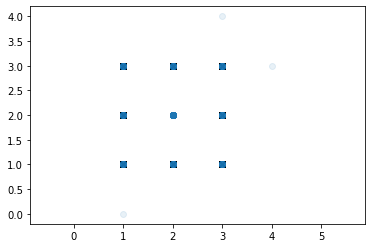

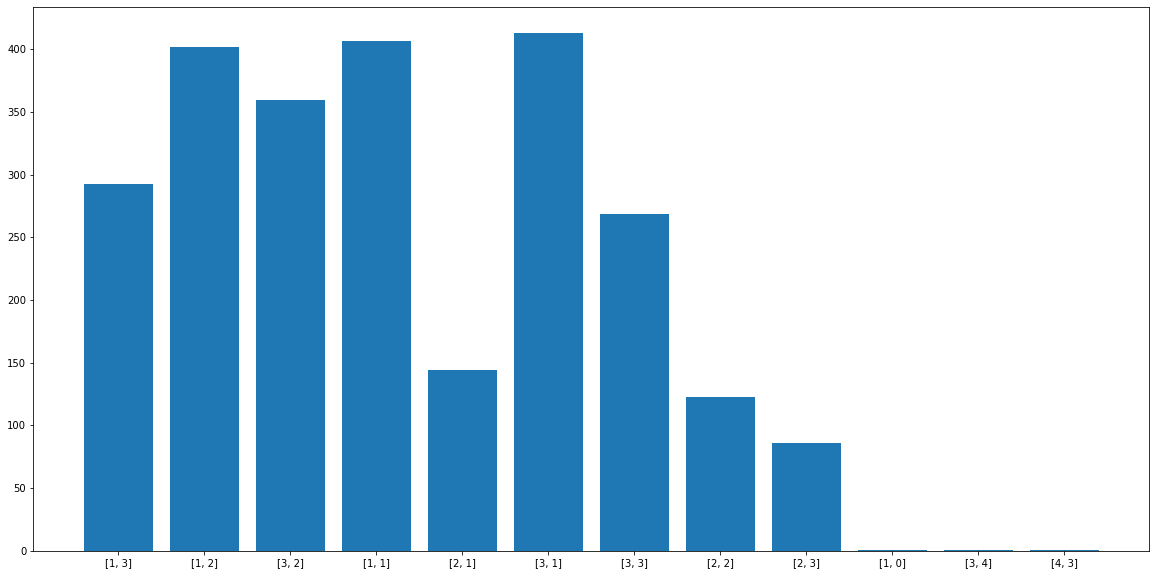

Processing Epoch 157
training start
Iteration 0, d real/fake loss 0.6034646034240723/0.6480364203453064 and g loss is 0.746923565864563, NDiv loss 0.05124372988939285
Iteration 1, d real/fake loss 0.6032966375350952/0.6514739990234375 and g loss is 0.7396712303161621, NDiv loss 0.04992469772696495
Iteration 2, d real/fake loss 0.6031306982040405/0.6477153301239014 and g loss is 0.748931884765625, NDiv loss 0.04783503711223602
Iteration 3, d real/fake loss 0.6029648184776306/0.6482424139976501 and g loss is 0.7422822713851929, NDiv loss 0.04825262352824211
Iteration 4, d real/fake loss 0.6028042435646057/0.6430754661560059 and g loss is 0.756878674030304, NDiv loss 0.050765763968229294


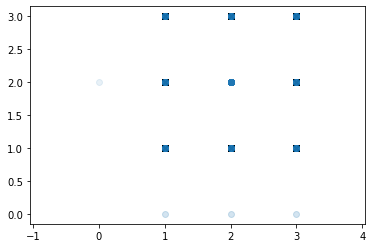

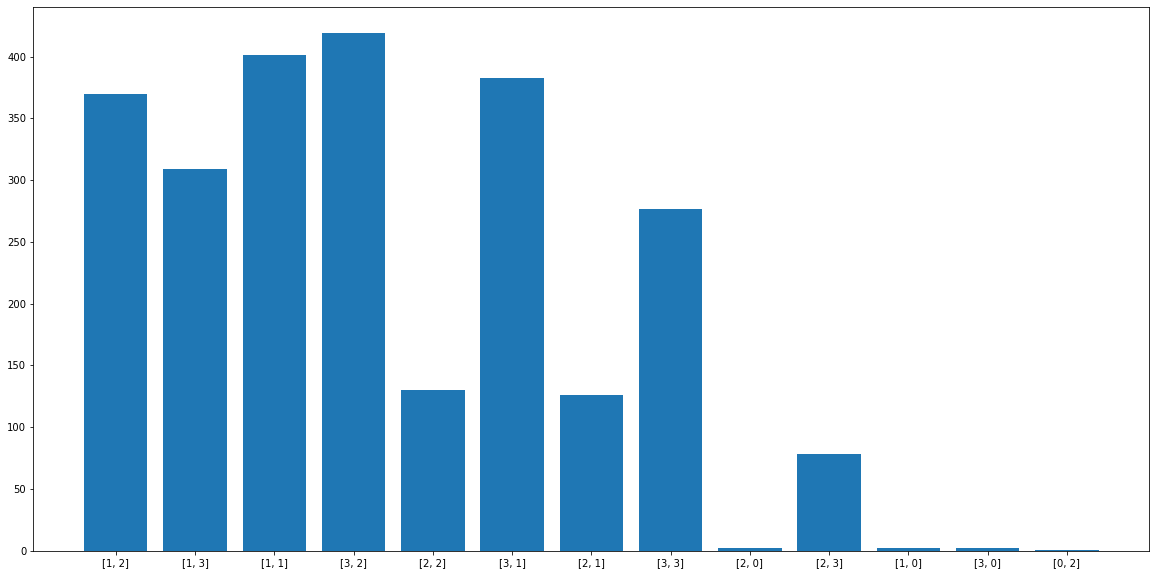

Processing Epoch 158
training start
Iteration 0, d real/fake loss 0.6032687425613403/0.6378656625747681 and g loss is 0.7507095336914062, NDiv loss 0.05094287917017937
Iteration 1, d real/fake loss 0.6030704975128174/0.6519827246665955 and g loss is 0.7444850206375122, NDiv loss 0.05266070365905762
Iteration 2, d real/fake loss 0.6028808355331421/0.6457986831665039 and g loss is 0.7476812601089478, NDiv loss 0.04937859624624252
Iteration 3, d real/fake loss 0.6026885509490967/0.6506615877151489 and g loss is 0.7463479042053223, NDiv loss 0.053005728870630264
Iteration 4, d real/fake loss 0.6025083661079407/0.6431726217269897 and g loss is 0.7477304935455322, NDiv loss 0.051701128482818604


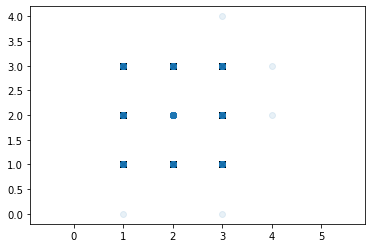

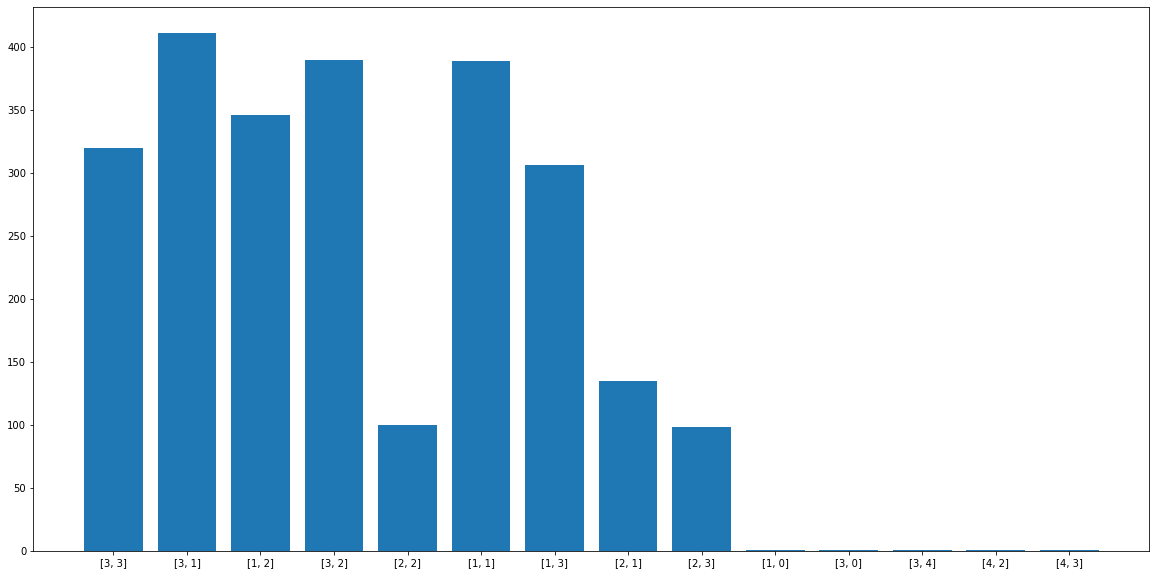

Processing Epoch 159
training start
Iteration 0, d real/fake loss 0.6016207933425903/0.6448450088500977 and g loss is 0.7419812679290771, NDiv loss 0.05150606110692024
Iteration 1, d real/fake loss 0.601496160030365/0.6468629240989685 and g loss is 0.7506103515625, NDiv loss 0.05140022933483124
Iteration 2, d real/fake loss 0.6013739705085754/0.6533087491989136 and g loss is 0.7465685606002808, NDiv loss 0.048651523888111115
Iteration 3, d real/fake loss 0.6012707948684692/0.6441650986671448 and g loss is 0.7511839866638184, NDiv loss 0.04940798878669739
Iteration 4, d real/fake loss 0.6011692881584167/0.648557186126709 and g loss is 0.7439243793487549, NDiv loss 0.04897022619843483


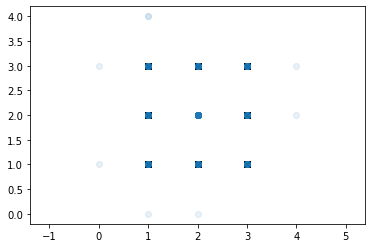

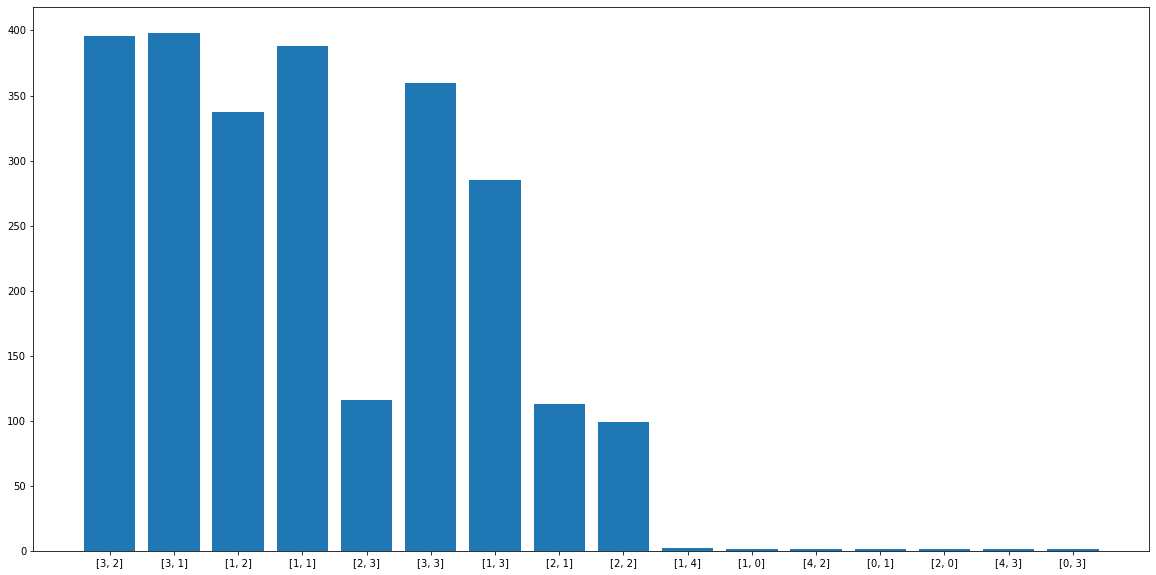

Processing Epoch 160
training start
Iteration 0, d real/fake loss 0.6012565493583679/0.6439741849899292 and g loss is 0.748512864112854, NDiv loss 0.05184292048215866
Iteration 1, d real/fake loss 0.6012654304504395/0.6453932523727417 and g loss is 0.7519305944442749, NDiv loss 0.05055758357048035
Iteration 2, d real/fake loss 0.6012592315673828/0.6401474475860596 and g loss is 0.7436697483062744, NDiv loss 0.0517771914601326
Iteration 3, d real/fake loss 0.6012440919876099/0.6406852602958679 and g loss is 0.7486709356307983, NDiv loss 0.05054813250899315
Iteration 4, d real/fake loss 0.6012159585952759/0.645366907119751 and g loss is 0.7509697675704956, NDiv loss 0.0526360347867012


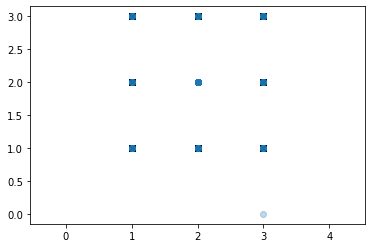

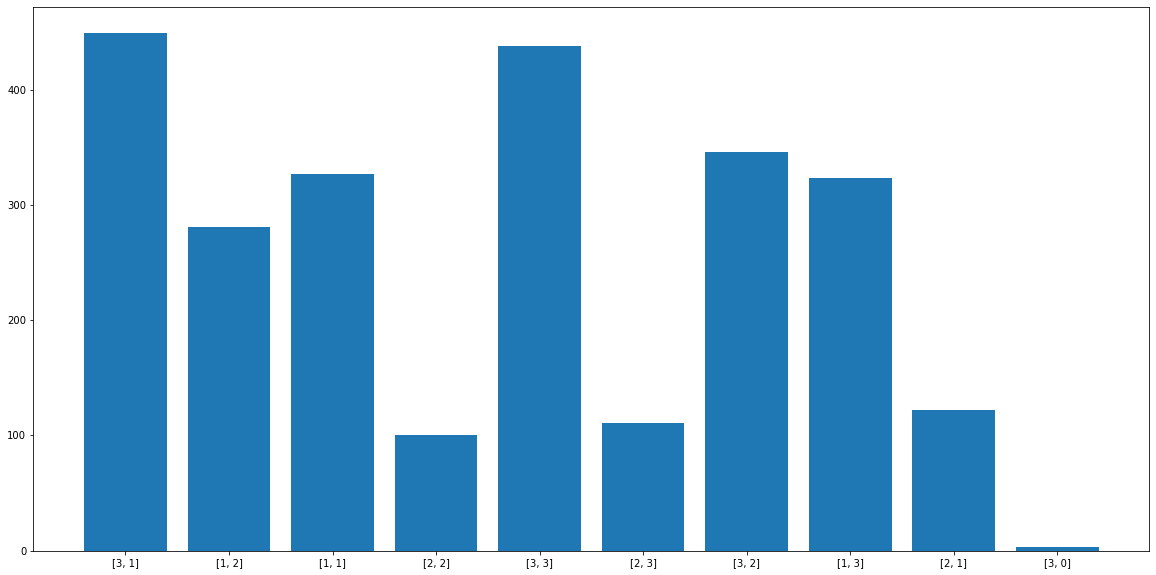

Processing Epoch 161
training start
Iteration 0, d real/fake loss 0.6038470268249512/0.6441744565963745 and g loss is 0.7502432465553284, NDiv loss 0.05160682648420334
Iteration 1, d real/fake loss 0.6038568019866943/0.6426606178283691 and g loss is 0.7508131861686707, NDiv loss 0.05289462208747864
Iteration 2, d real/fake loss 0.6038520336151123/0.6440504789352417 and g loss is 0.7500221729278564, NDiv loss 0.04901473969221115
Iteration 3, d real/fake loss 0.6038391590118408/0.6420271992683411 and g loss is 0.7485873699188232, NDiv loss 0.0492730513215065
Iteration 4, d real/fake loss 0.6038061380386353/0.639873743057251 and g loss is 0.7451736927032471, NDiv loss 0.051995664834976196


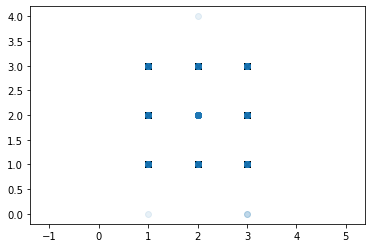

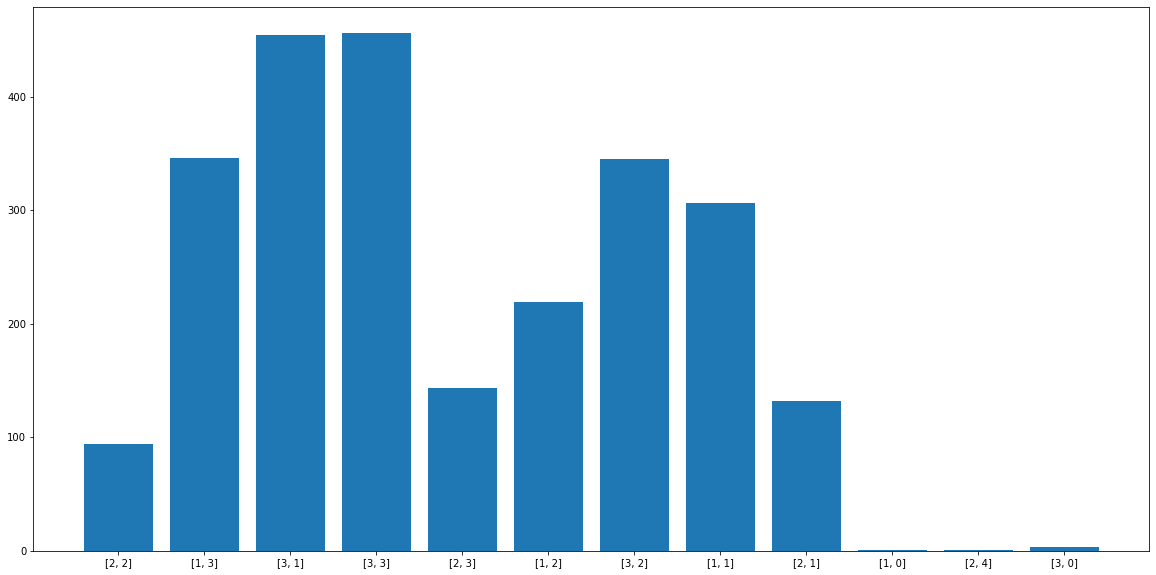

Processing Epoch 162
training start
Iteration 0, d real/fake loss 0.6032367944717407/0.6531598567962646 and g loss is 0.7490510940551758, NDiv loss 0.05367989093065262
Iteration 1, d real/fake loss 0.6032313108444214/0.6430720686912537 and g loss is 0.7466070055961609, NDiv loss 0.05463201180100441
Iteration 2, d real/fake loss 0.6032129526138306/0.6450383067131042 and g loss is 0.7561595439910889, NDiv loss 0.05133213847875595
Iteration 3, d real/fake loss 0.6031873226165771/0.6353157162666321 and g loss is 0.7481496334075928, NDiv loss 0.04933866858482361
Iteration 4, d real/fake loss 0.6031456589698792/0.6455056071281433 and g loss is 0.7444600462913513, NDiv loss 0.04950915277004242


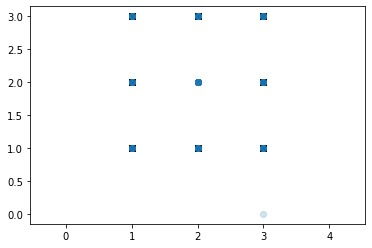

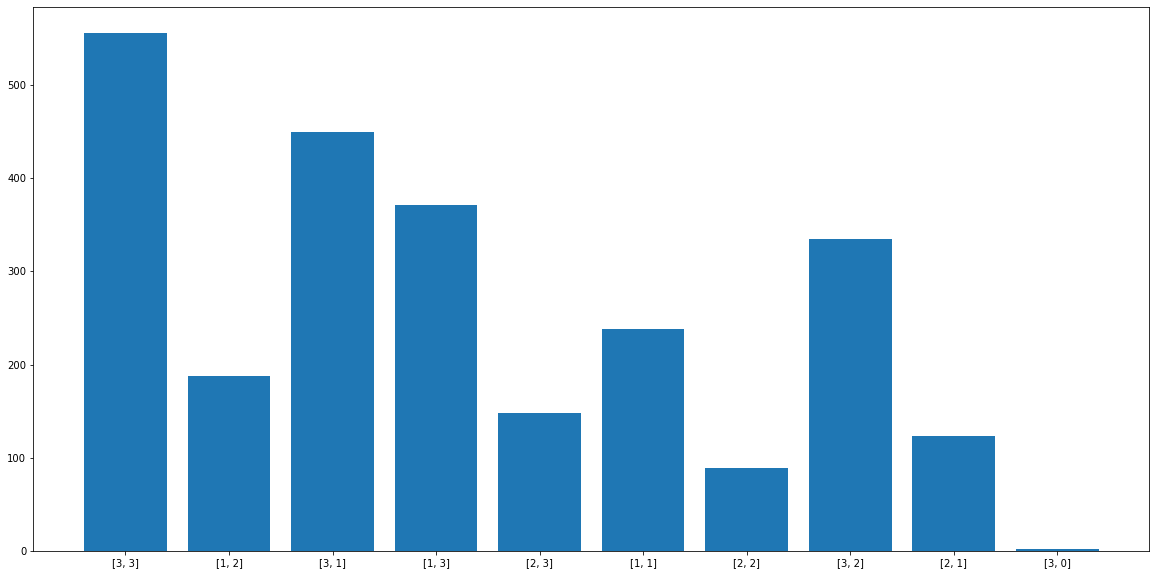

Processing Epoch 163
training start
Iteration 0, d real/fake loss 0.6026133298873901/0.6451103687286377 and g loss is 0.7428531050682068, NDiv loss 0.05231665447354317
Iteration 1, d real/fake loss 0.6026217341423035/0.6481826901435852 and g loss is 0.7481619119644165, NDiv loss 0.051308806985616684
Iteration 2, d real/fake loss 0.6026470065116882/0.6389784216880798 and g loss is 0.7488994598388672, NDiv loss 0.05240938812494278
Iteration 3, d real/fake loss 0.6026588678359985/0.6457028388977051 and g loss is 0.7548417448997498, NDiv loss 0.05089639872312546
Iteration 4, d real/fake loss 0.6026840209960938/0.6385961174964905 and g loss is 0.7505213022232056, NDiv loss 0.05496624484658241


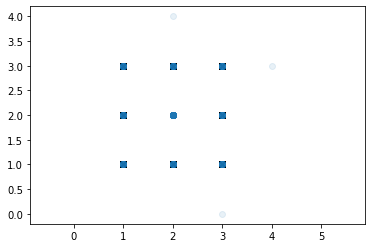

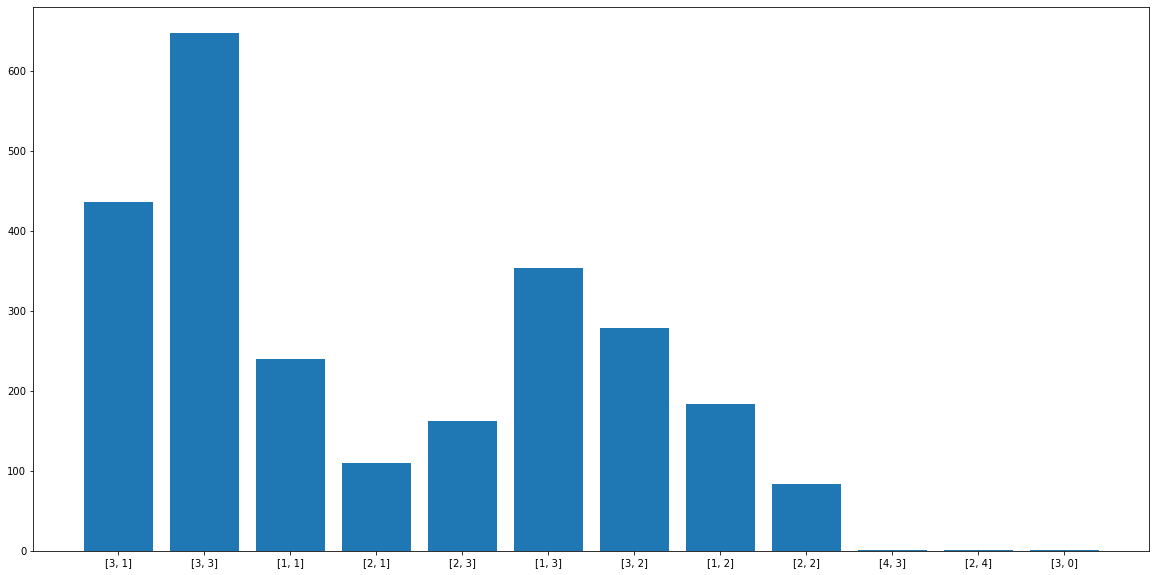

Processing Epoch 164
training start
Iteration 0, d real/fake loss 0.6012487411499023/0.6431687474250793 and g loss is 0.7343930006027222, NDiv loss 0.05033563822507858
Iteration 1, d real/fake loss 0.6012358069419861/0.6407393217086792 and g loss is 0.7410774230957031, NDiv loss 0.050145700573921204
Iteration 2, d real/fake loss 0.6012275218963623/0.6562393307685852 and g loss is 0.7355304956436157, NDiv loss 0.0530707985162735
Iteration 3, d real/fake loss 0.6012536883354187/0.6463605165481567 and g loss is 0.7356525659561157, NDiv loss 0.05290258675813675
Iteration 4, d real/fake loss 0.6012926697731018/0.6498684883117676 and g loss is 0.7474799156188965, NDiv loss 0.053386081010103226


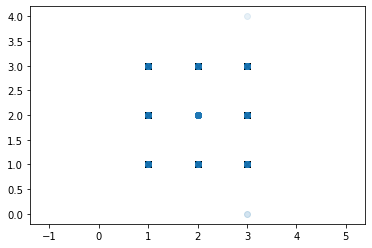

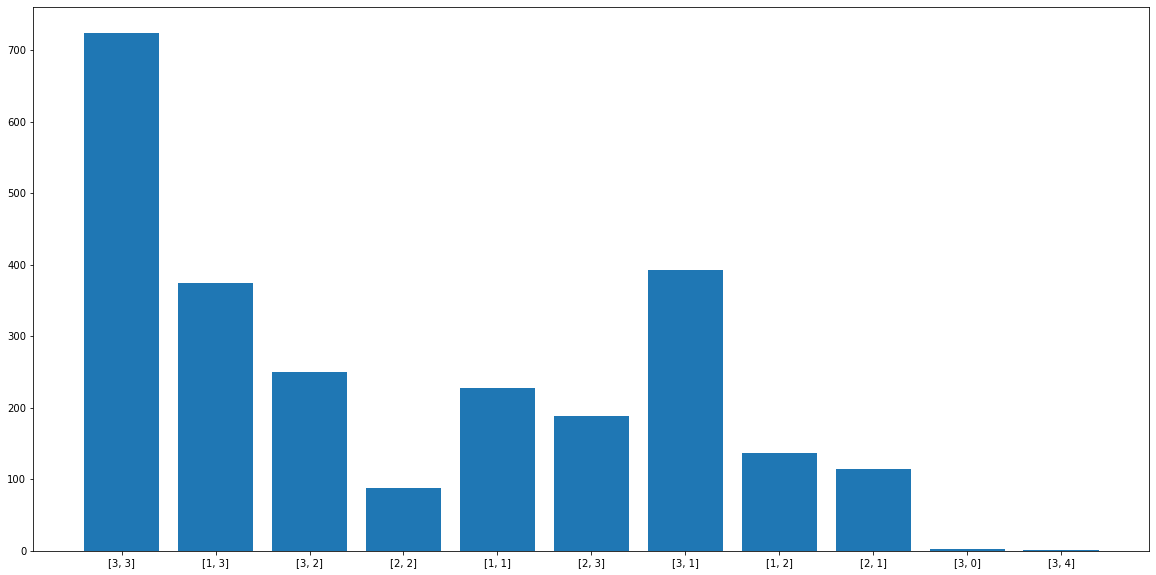

Processing Epoch 165
training start
Iteration 0, d real/fake loss 0.6039738655090332/0.6500038504600525 and g loss is 0.7428705096244812, NDiv loss 0.04947046935558319
Iteration 1, d real/fake loss 0.6040909290313721/0.6486387252807617 and g loss is 0.7359768152236938, NDiv loss 0.049214478582143784
Iteration 2, d real/fake loss 0.6042125225067139/0.6454302072525024 and g loss is 0.7471523880958557, NDiv loss 0.055130407214164734
Iteration 3, d real/fake loss 0.6043218374252319/0.6509710550308228 and g loss is 0.7463484406471252, NDiv loss 0.051901426166296005
Iteration 4, d real/fake loss 0.6044285893440247/0.6456259489059448 and g loss is 0.7407715320587158, NDiv loss 0.05224761366844177


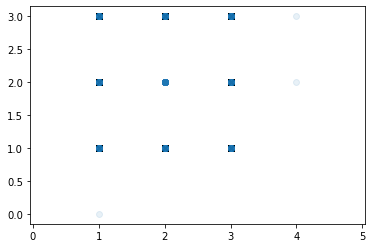

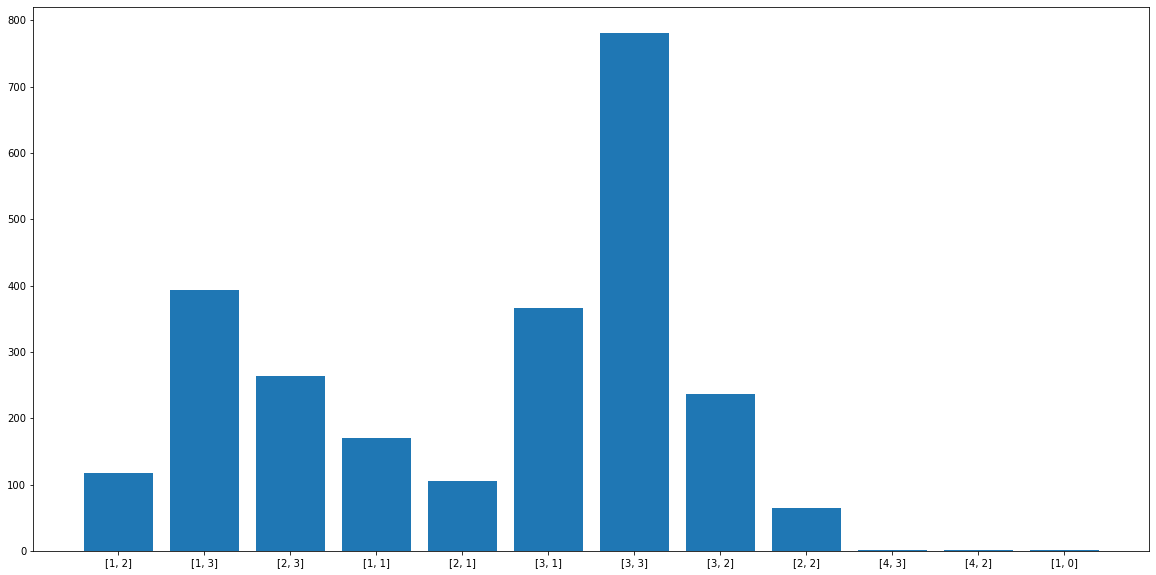

Processing Epoch 166
training start
Iteration 0, d real/fake loss 0.602544367313385/0.6482449769973755 and g loss is 0.7379680871963501, NDiv loss 0.052785471081733704
Iteration 1, d real/fake loss 0.6026270985603333/0.6413552761077881 and g loss is 0.7394819855690002, NDiv loss 0.050315458327531815
Iteration 2, d real/fake loss 0.6027039289474487/0.6372508406639099 and g loss is 0.738160252571106, NDiv loss 0.051156386733055115
Iteration 3, d real/fake loss 0.6027682423591614/0.6463412046432495 and g loss is 0.7529735565185547, NDiv loss 0.05201104283332825
Iteration 4, d real/fake loss 0.6028311848640442/0.6568835377693176 and g loss is 0.7455751299858093, NDiv loss 0.04957597702741623


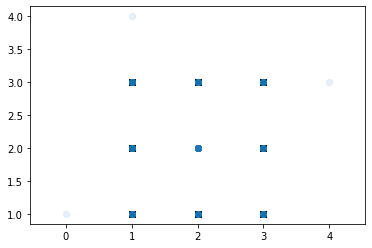

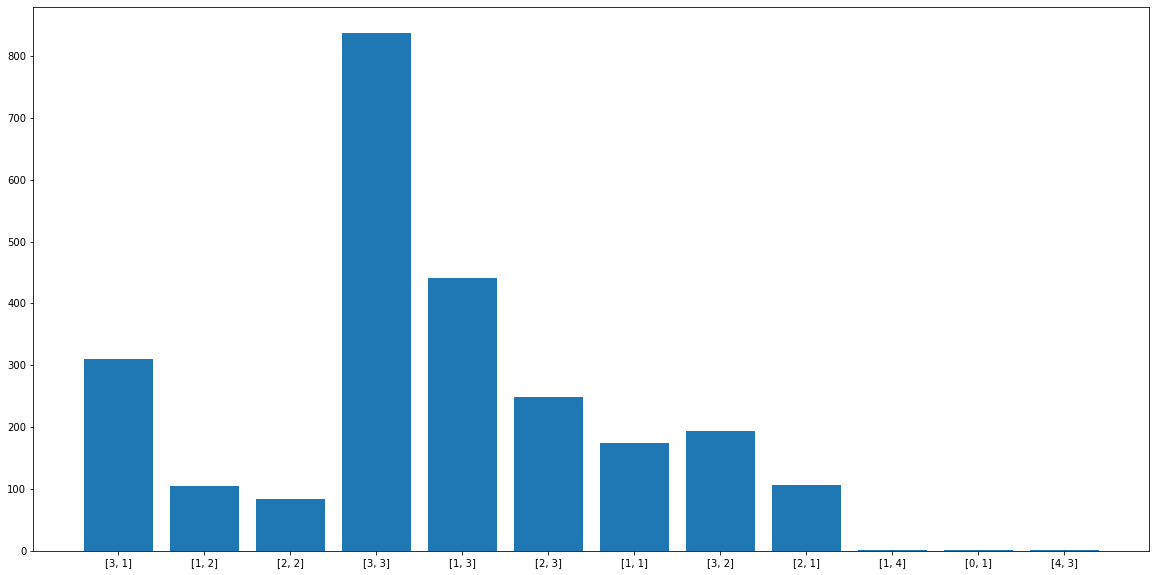

Processing Epoch 167
training start
Iteration 0, d real/fake loss 0.6035162210464478/0.6529128551483154 and g loss is 0.7473238706588745, NDiv loss 0.05402116850018501
Iteration 1, d real/fake loss 0.6035232543945312/0.6518400311470032 and g loss is 0.7423883080482483, NDiv loss 0.05385054275393486
Iteration 2, d real/fake loss 0.6035308837890625/0.6471363306045532 and g loss is 0.7330758571624756, NDiv loss 0.052273645997047424
Iteration 3, d real/fake loss 0.6035295724868774/0.64967942237854 and g loss is 0.7289713025093079, NDiv loss 0.055126093327999115
Iteration 4, d real/fake loss 0.6035279035568237/0.6502796411514282 and g loss is 0.7437918186187744, NDiv loss 0.054626934230327606


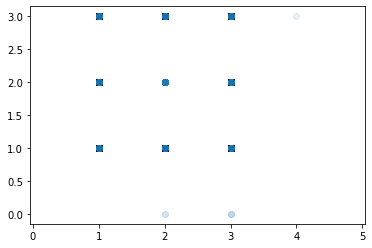

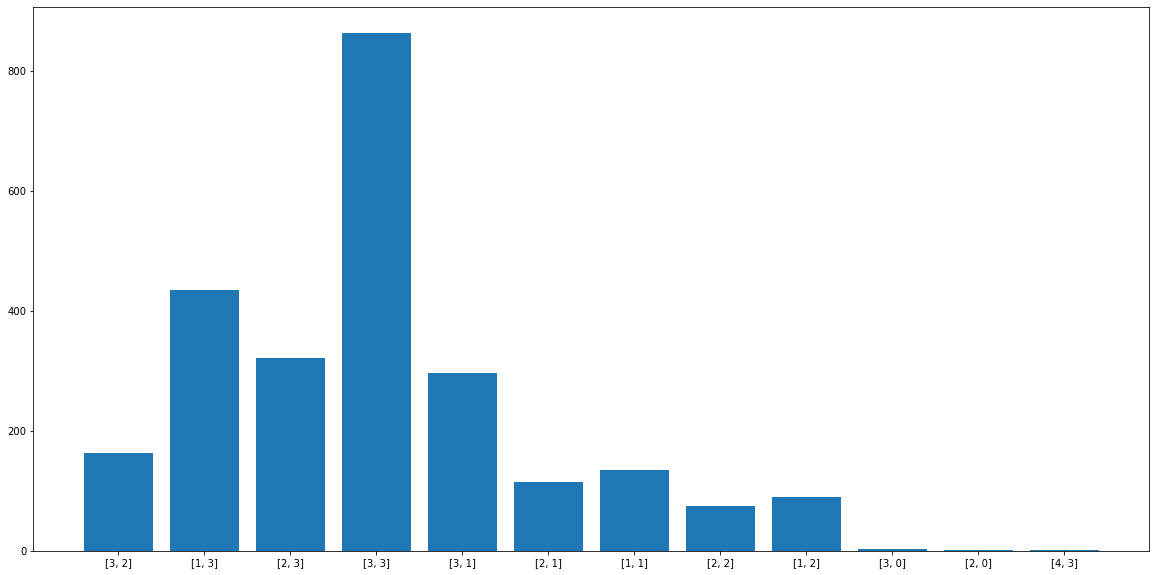

Processing Epoch 168
training start
Iteration 0, d real/fake loss 0.6059960722923279/0.6496330499649048 and g loss is 0.7408579587936401, NDiv loss 0.05841715633869171
Iteration 1, d real/fake loss 0.6061128973960876/0.6421531438827515 and g loss is 0.7421954274177551, NDiv loss 0.060556426644325256
Iteration 2, d real/fake loss 0.6062124967575073/0.6536662578582764 and g loss is 0.7425611019134521, NDiv loss 0.05577635020017624
Iteration 3, d real/fake loss 0.6063296794891357/0.654497504234314 and g loss is 0.7360817790031433, NDiv loss 0.05138997361063957
Iteration 4, d real/fake loss 0.606453537940979/0.6461129784584045 and g loss is 0.7418447732925415, NDiv loss 0.05683239921927452


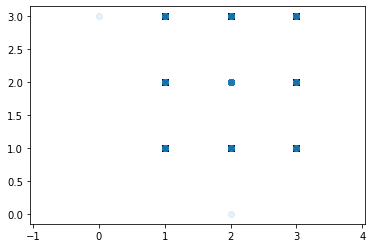

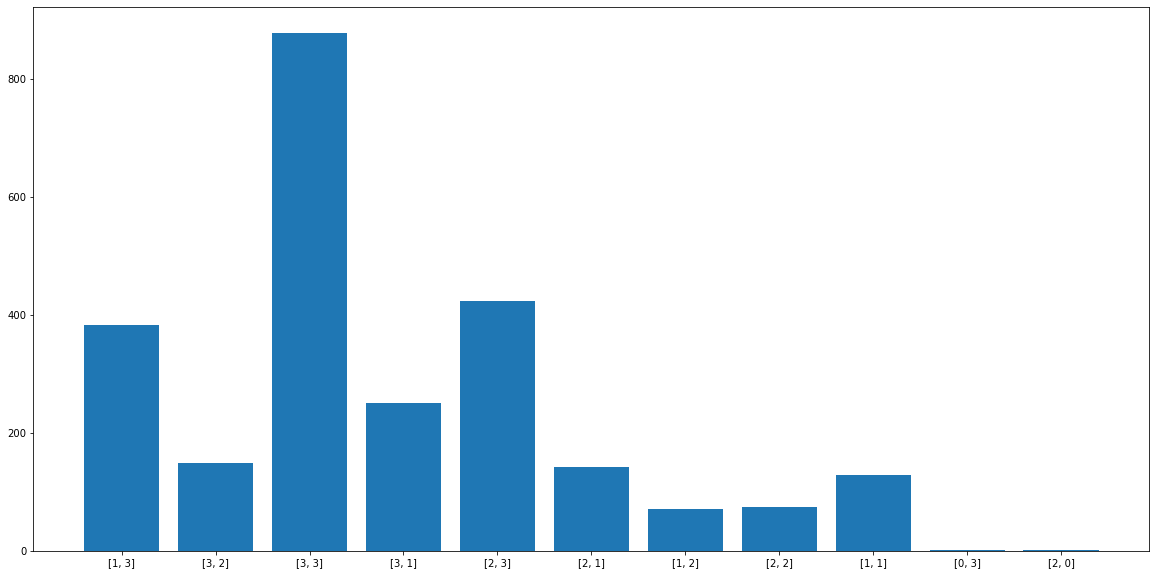

Processing Epoch 169
training start
Iteration 0, d real/fake loss 0.6007623076438904/0.6479542255401611 and g loss is 0.7364192008972168, NDiv loss 0.05261705815792084
Iteration 1, d real/fake loss 0.6009590029716492/0.6494539976119995 and g loss is 0.7335126996040344, NDiv loss 0.052816081792116165
Iteration 2, d real/fake loss 0.6011574268341064/0.6414393782615662 and g loss is 0.7424553632736206, NDiv loss 0.057066239416599274
Iteration 3, d real/fake loss 0.6013495922088623/0.6495833992958069 and g loss is 0.7412837743759155, NDiv loss 0.052862782031297684
Iteration 4, d real/fake loss 0.6015501022338867/0.6495438814163208 and g loss is 0.7468276023864746, NDiv loss 0.05562742054462433


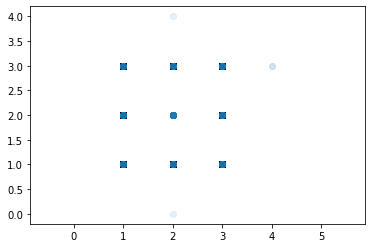

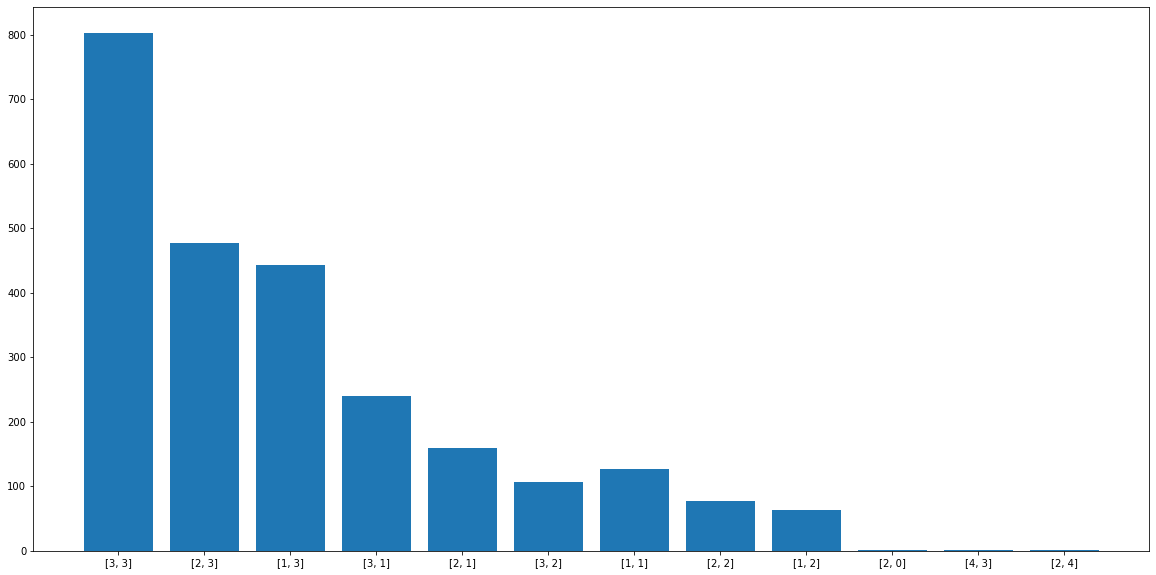

Processing Epoch 170
training start
Iteration 0, d real/fake loss 0.6052026748657227/0.6463100910186768 and g loss is 0.7424893379211426, NDiv loss 0.055148471146821976
Iteration 1, d real/fake loss 0.6053411960601807/0.6458196640014648 and g loss is 0.7536324858665466, NDiv loss 0.0563339926302433
Iteration 2, d real/fake loss 0.6054517030715942/0.6535943746566772 and g loss is 0.7542415857315063, NDiv loss 0.05698081851005554
Iteration 3, d real/fake loss 0.605536162853241/0.6428990960121155 and g loss is 0.7463935613632202, NDiv loss 0.056188732385635376
Iteration 4, d real/fake loss 0.6055798530578613/0.6370914578437805 and g loss is 0.748505175113678, NDiv loss 0.05753488466143608


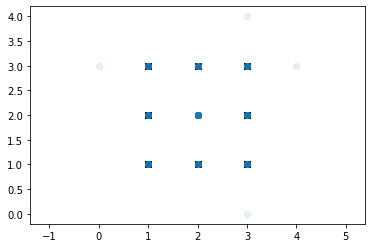

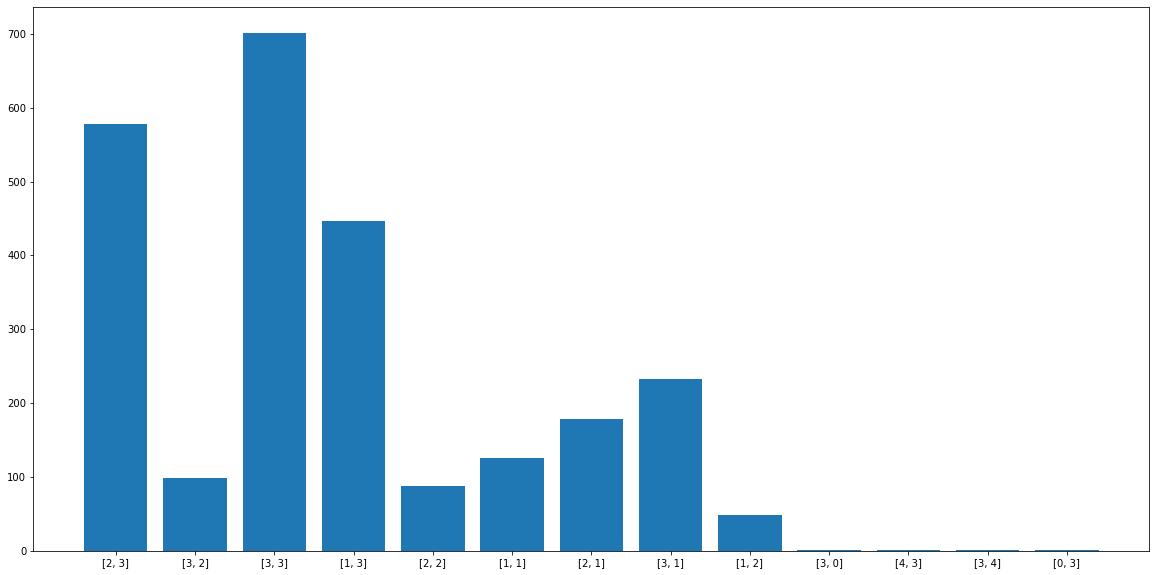

Processing Epoch 171
training start
Iteration 0, d real/fake loss 0.606511652469635/0.6459040641784668 and g loss is 0.7508288025856018, NDiv loss 0.05332273244857788
Iteration 1, d real/fake loss 0.6064773201942444/0.6380233764648438 and g loss is 0.7479538917541504, NDiv loss 0.052791327238082886
Iteration 2, d real/fake loss 0.6064209938049316/0.6490370631217957 and g loss is 0.7463819980621338, NDiv loss 0.053388770669698715
Iteration 3, d real/fake loss 0.6063579320907593/0.6473240852355957 and g loss is 0.7516257762908936, NDiv loss 0.0563068762421608
Iteration 4, d real/fake loss 0.6062902808189392/0.6437036991119385 and g loss is 0.7550339102745056, NDiv loss 0.05489344522356987


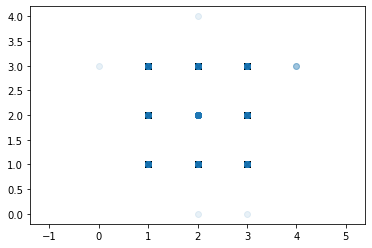

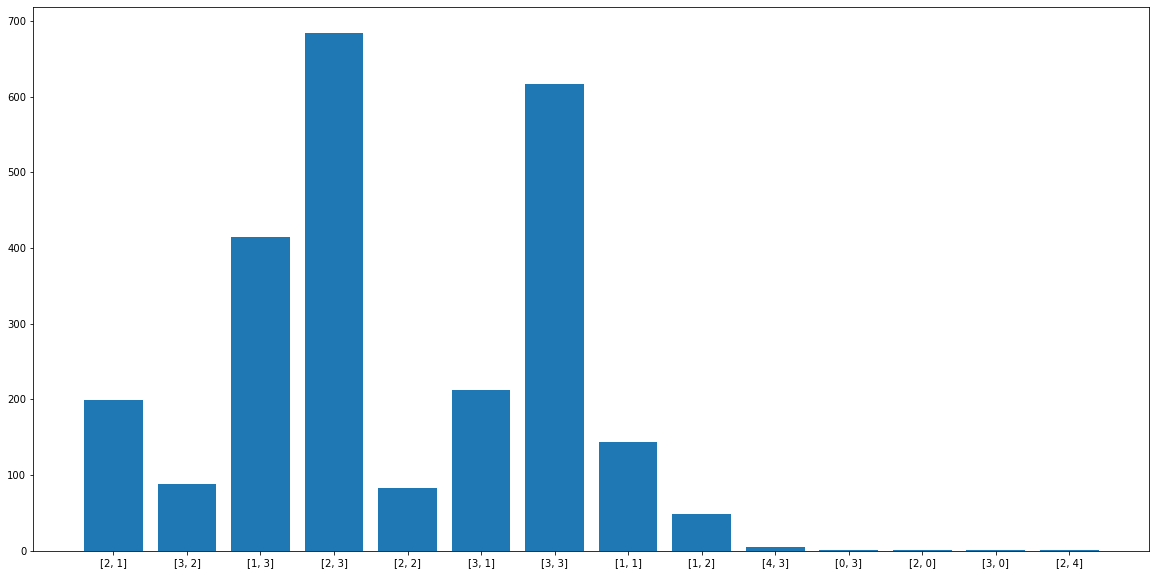

Processing Epoch 172
training start
Iteration 0, d real/fake loss 0.6034016609191895/0.6464594602584839 and g loss is 0.7567787766456604, NDiv loss 0.053310003131628036
Iteration 1, d real/fake loss 0.603437066078186/0.6431862711906433 and g loss is 0.7429076433181763, NDiv loss 0.0572640560567379
Iteration 2, d real/fake loss 0.6034637689590454/0.6504616737365723 and g loss is 0.7389978170394897, NDiv loss 0.053861185908317566
Iteration 3, d real/fake loss 0.6034925580024719/0.6409214735031128 and g loss is 0.7531013488769531, NDiv loss 0.052853312343358994
Iteration 4, d real/fake loss 0.6035144925117493/0.6412032842636108 and g loss is 0.7535435557365417, NDiv loss 0.055961694568395615


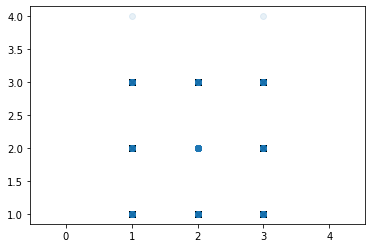

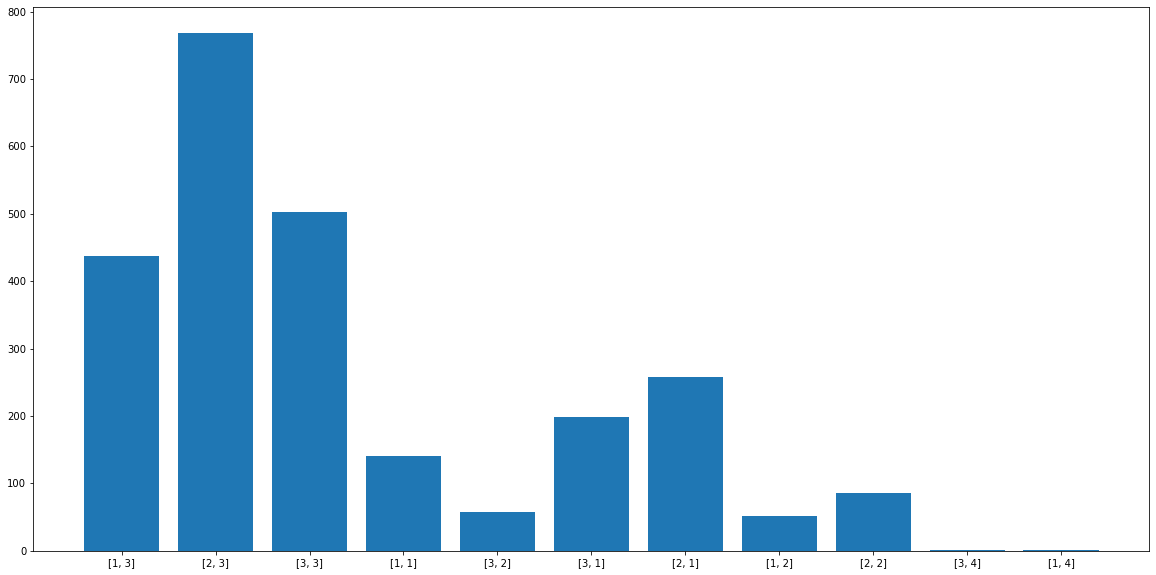

Processing Epoch 173
training start
Iteration 0, d real/fake loss 0.6055737733840942/0.6503387689590454 and g loss is 0.7533817887306213, NDiv loss 0.054779212921857834
Iteration 1, d real/fake loss 0.6055591106414795/0.6316508650779724 and g loss is 0.7524596452713013, NDiv loss 0.05698525905609131
Iteration 2, d real/fake loss 0.605523943901062/0.6336498260498047 and g loss is 0.7503464221954346, NDiv loss 0.0551302395761013
Iteration 3, d real/fake loss 0.6054733991622925/0.637847363948822 and g loss is 0.7486664056777954, NDiv loss 0.052367668598890305
Iteration 4, d real/fake loss 0.6054109930992126/0.6355142593383789 and g loss is 0.7493622303009033, NDiv loss 0.0557982437312603


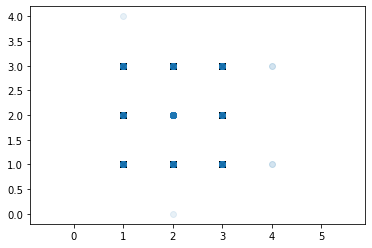

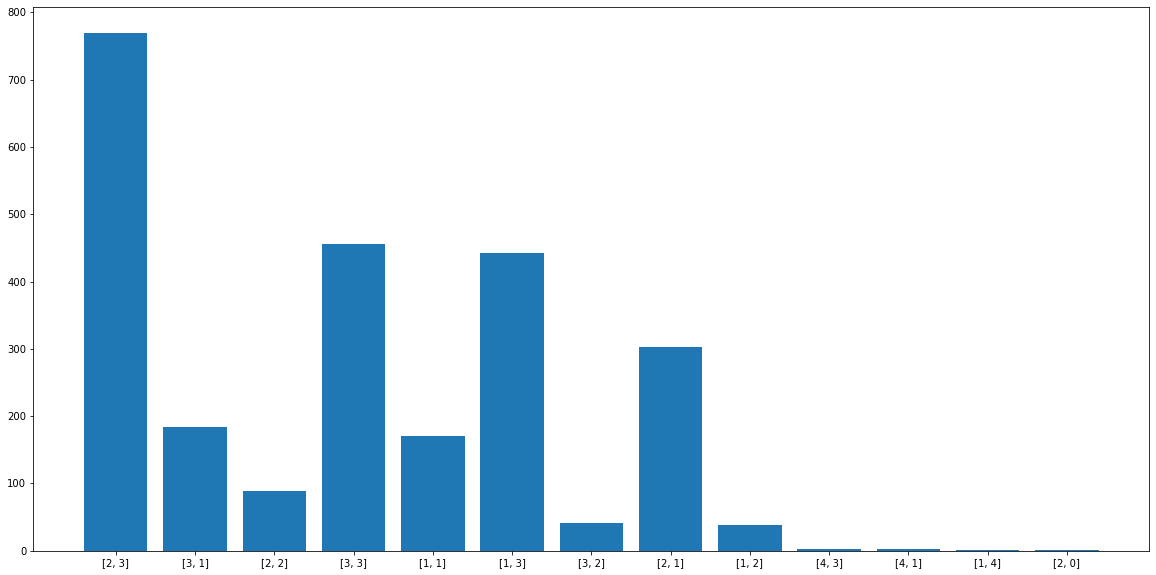

Processing Epoch 174
training start
Iteration 0, d real/fake loss 0.6013720631599426/0.6312479376792908 and g loss is 0.7550657987594604, NDiv loss 0.05337080731987953
Iteration 1, d real/fake loss 0.6014372110366821/0.6336168050765991 and g loss is 0.7658270001411438, NDiv loss 0.05560579150915146
Iteration 2, d real/fake loss 0.6014842391014099/0.6396167874336243 and g loss is 0.7576781511306763, NDiv loss 0.05348101258277893
Iteration 3, d real/fake loss 0.6015315651893616/0.6318840980529785 and g loss is 0.7672503590583801, NDiv loss 0.05359501391649246
Iteration 4, d real/fake loss 0.6015693545341492/0.6425032615661621 and g loss is 0.751835823059082, NDiv loss 0.05431066453456879


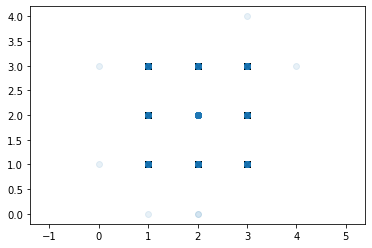

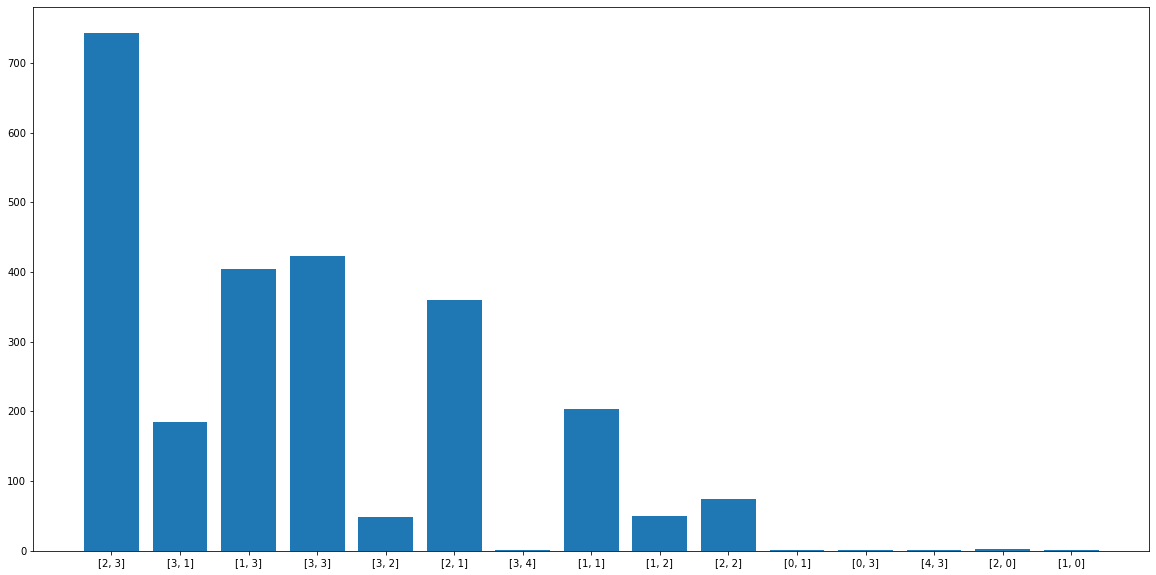

Processing Epoch 175
training start
Iteration 0, d real/fake loss 0.6041496396064758/0.6320213079452515 and g loss is 0.7567352056503296, NDiv loss 0.05732851102948189
Iteration 1, d real/fake loss 0.6040908098220825/0.6343123316764832 and g loss is 0.7517391443252563, NDiv loss 0.05684817582368851
Iteration 2, d real/fake loss 0.6040112972259521/0.6384113430976868 and g loss is 0.7560217976570129, NDiv loss 0.053071528673172
Iteration 3, d real/fake loss 0.6039240956306458/0.6311154365539551 and g loss is 0.7648792266845703, NDiv loss 0.054035939276218414
Iteration 4, d real/fake loss 0.6038159728050232/0.6353623867034912 and g loss is 0.754711389541626, NDiv loss 0.05538492649793625


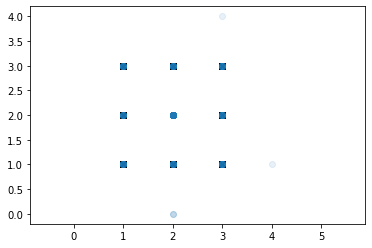

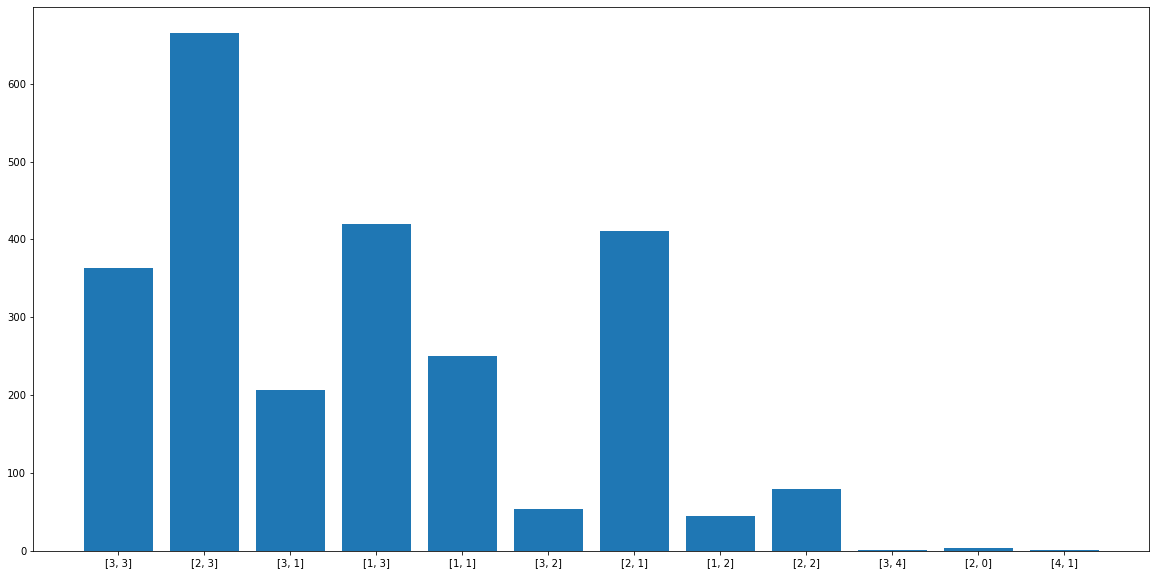

Processing Epoch 176
training start
Iteration 0, d real/fake loss 0.6022794246673584/0.633901059627533 and g loss is 0.7584013938903809, NDiv loss 0.05712384730577469
Iteration 1, d real/fake loss 0.6021999716758728/0.640921950340271 and g loss is 0.7526222467422485, NDiv loss 0.053382083773612976
Iteration 2, d real/fake loss 0.6021280884742737/0.6349148750305176 and g loss is 0.7711732983589172, NDiv loss 0.05095043405890465
Iteration 3, d real/fake loss 0.6020524501800537/0.6345983147621155 and g loss is 0.7507774829864502, NDiv loss 0.05562492832541466
Iteration 4, d real/fake loss 0.6019703149795532/0.6403981447219849 and g loss is 0.7613958716392517, NDiv loss 0.05789044499397278


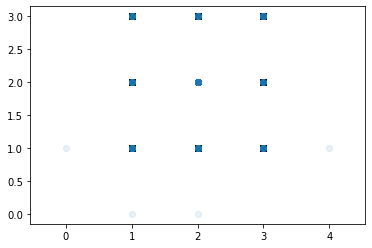

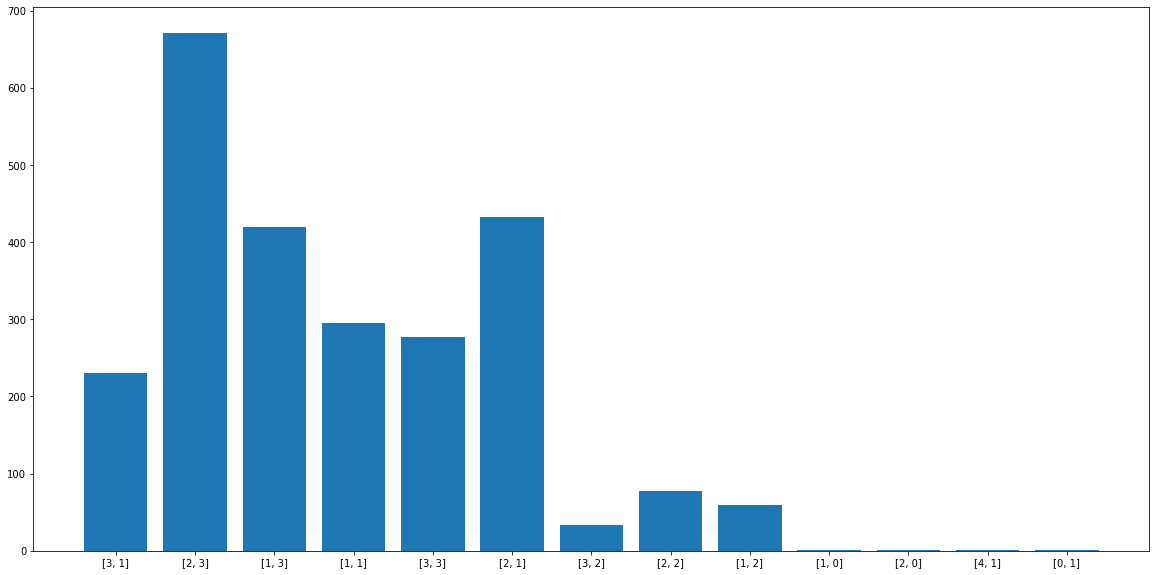

Processing Epoch 177
training start
Iteration 0, d real/fake loss 0.6056522130966187/0.6427770853042603 and g loss is 0.7594074010848999, NDiv loss 0.051660072058439255
Iteration 1, d real/fake loss 0.6055980920791626/0.6321741342544556 and g loss is 0.7515195608139038, NDiv loss 0.05249996483325958
Iteration 2, d real/fake loss 0.6055163741111755/0.6340559124946594 and g loss is 0.7609794735908508, NDiv loss 0.05454908311367035
Iteration 3, d real/fake loss 0.6054269075393677/0.6328563690185547 and g loss is 0.7545012831687927, NDiv loss 0.05521070584654808
Iteration 4, d real/fake loss 0.605316698551178/0.6277943849563599 and g loss is 0.7474184036254883, NDiv loss 0.05427540838718414


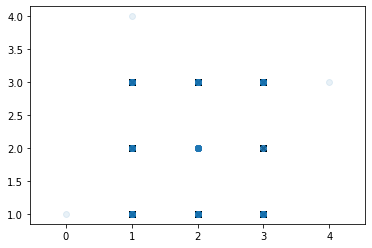

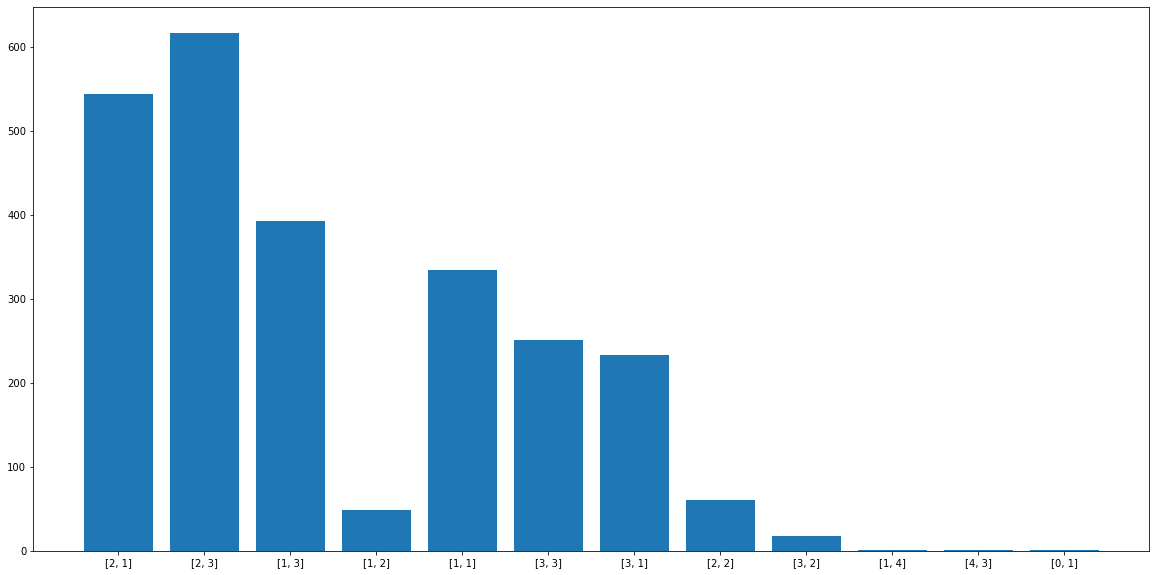

Processing Epoch 178
training start
Iteration 0, d real/fake loss 0.5990212559700012/0.6328842043876648 and g loss is 0.7578812837600708, NDiv loss 0.05467125400900841
Iteration 1, d real/fake loss 0.5989037752151489/0.6296674013137817 and g loss is 0.7569177746772766, NDiv loss 0.05476480722427368
Iteration 2, d real/fake loss 0.598789632320404/0.6353892683982849 and g loss is 0.7521048784255981, NDiv loss 0.05745549499988556
Iteration 3, d real/fake loss 0.5986800193786621/0.6417680978775024 and g loss is 0.7492581009864807, NDiv loss 0.05321970582008362
Iteration 4, d real/fake loss 0.598584771156311/0.6444638967514038 and g loss is 0.7493653893470764, NDiv loss 0.054249126464128494


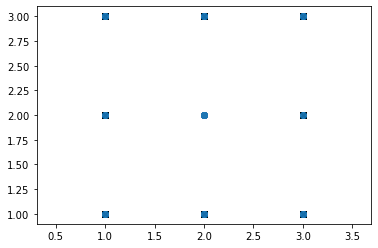

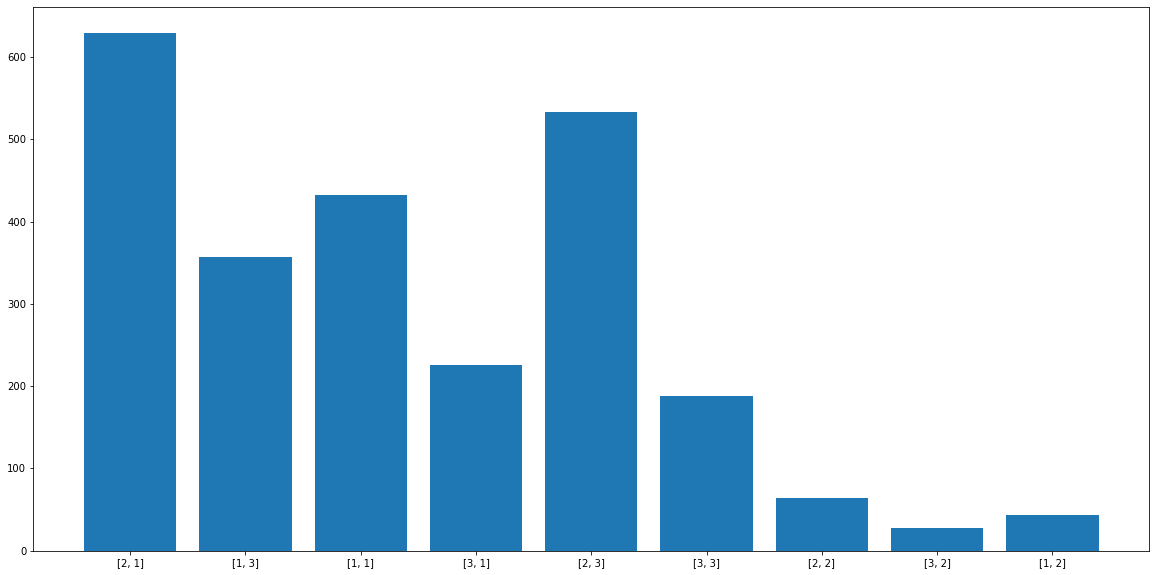

Processing Epoch 179
training start
Iteration 0, d real/fake loss 0.6059972047805786/0.6421476602554321 and g loss is 0.7554140090942383, NDiv loss 0.05403588339686394
Iteration 1, d real/fake loss 0.6058683395385742/0.6376547813415527 and g loss is 0.7536295056343079, NDiv loss 0.05929911136627197
Iteration 2, d real/fake loss 0.6057205200195312/0.6441439986228943 and g loss is 0.7455788850784302, NDiv loss 0.0591137558221817
Iteration 3, d real/fake loss 0.605564296245575/0.633875846862793 and g loss is 0.7431104183197021, NDiv loss 0.05695953592658043
Iteration 4, d real/fake loss 0.6053907871246338/0.6339622735977173 and g loss is 0.7440593242645264, NDiv loss 0.05862981826066971


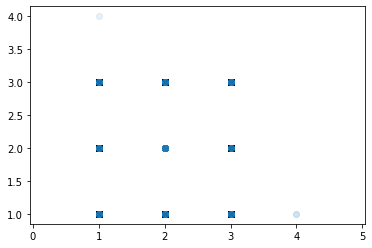

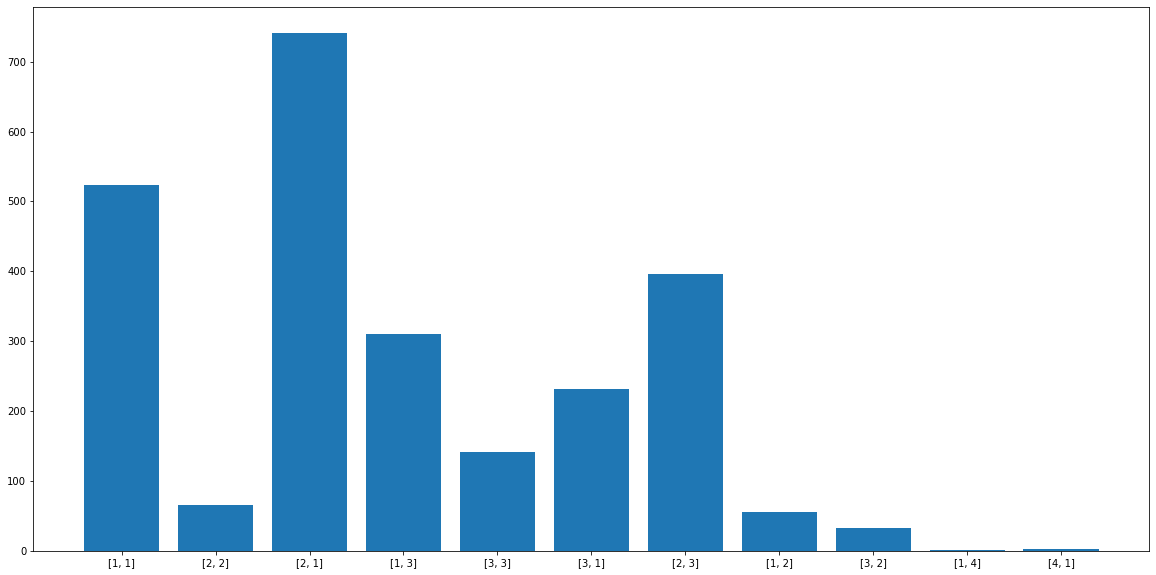

Processing Epoch 180
training start
Iteration 0, d real/fake loss 0.6022087931632996/0.6528618335723877 and g loss is 0.7486199140548706, NDiv loss 0.05698707699775696
Iteration 1, d real/fake loss 0.6021437644958496/0.6408529877662659 and g loss is 0.7493810653686523, NDiv loss 0.062192223966121674
Iteration 2, d real/fake loss 0.602075457572937/0.6489771604537964 and g loss is 0.7530837059020996, NDiv loss 0.05870692431926727
Iteration 3, d real/fake loss 0.602013885974884/0.6498270034790039 and g loss is 0.7351601123809814, NDiv loss 0.06071936711668968
Iteration 4, d real/fake loss 0.6019602417945862/0.6530661582946777 and g loss is 0.7385693788528442, NDiv loss 0.05614222586154938


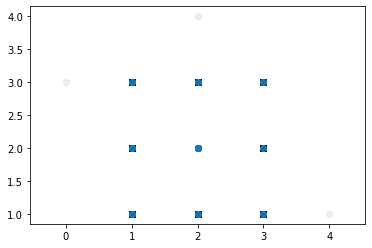

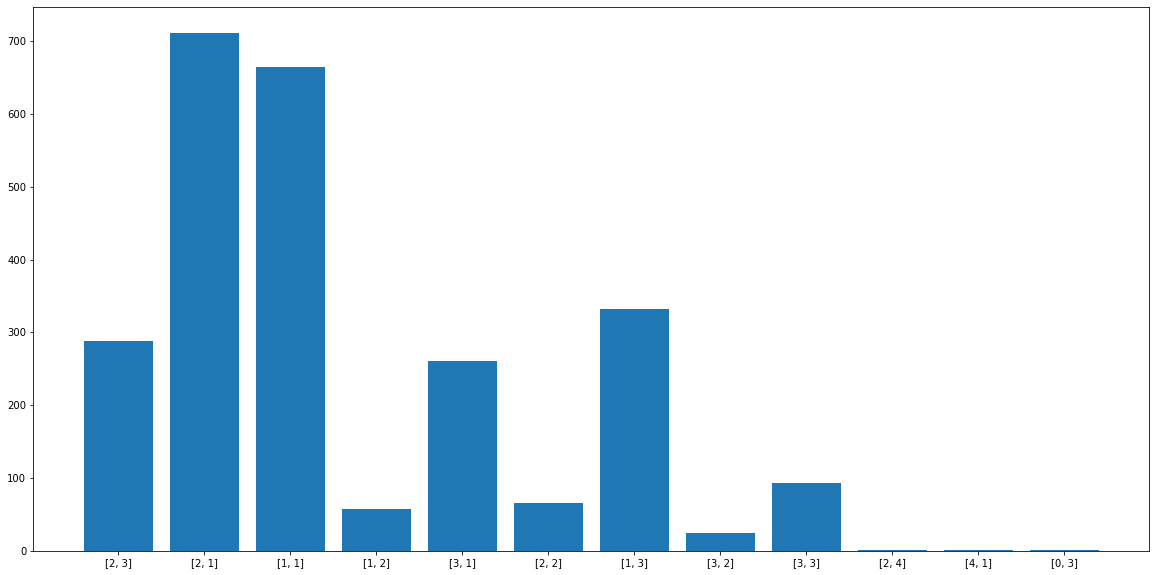

Processing Epoch 181
training start
Iteration 0, d real/fake loss 0.5954250693321228/0.6489810943603516 and g loss is 0.7369340658187866, NDiv loss 0.06105051562190056
Iteration 1, d real/fake loss 0.5952903628349304/0.6530608534812927 and g loss is 0.7428461909294128, NDiv loss 0.05546670779585838
Iteration 2, d real/fake loss 0.5951672792434692/0.64774090051651 and g loss is 0.7359495162963867, NDiv loss 0.06031041964888573
Iteration 3, d real/fake loss 0.5950498580932617/0.6536591053009033 and g loss is 0.7366420030593872, NDiv loss 0.05867195874452591
Iteration 4, d real/fake loss 0.594946026802063/0.6678597331047058 and g loss is 0.7352665662765503, NDiv loss 0.0587887316942215


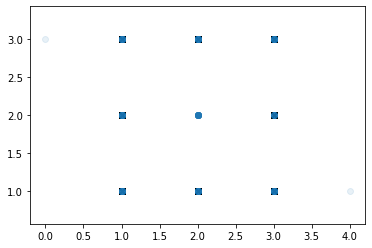

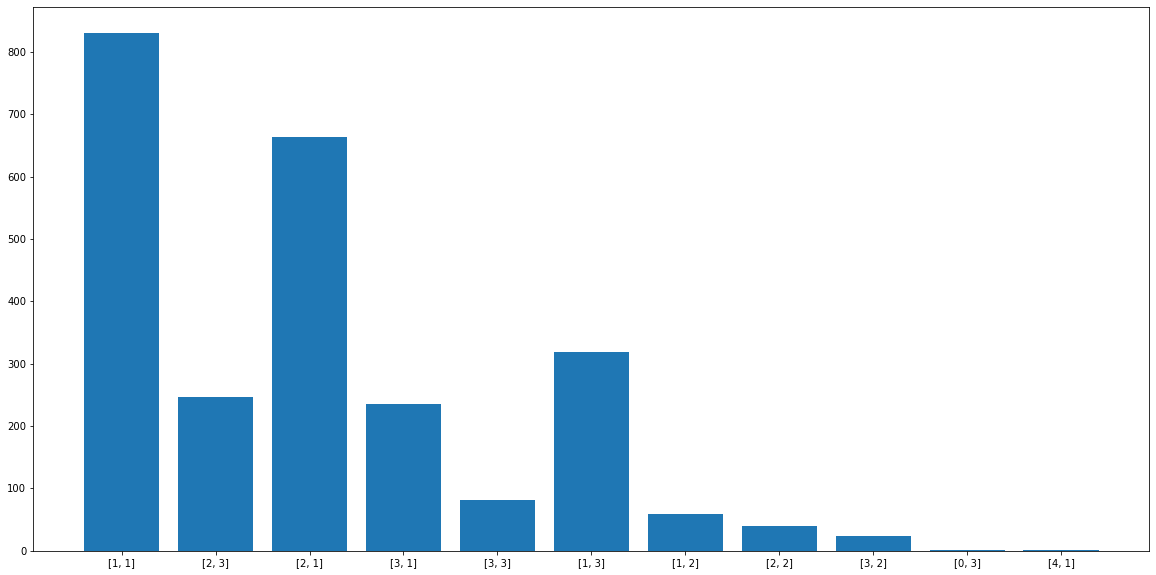

Processing Epoch 182
training start
Iteration 0, d real/fake loss 0.6006463766098022/0.6601303219795227 and g loss is 0.7333564162254333, NDiv loss 0.056973688304424286
Iteration 1, d real/fake loss 0.6004812717437744/0.655841052532196 and g loss is 0.738956868648529, NDiv loss 0.059210747480392456
Iteration 2, d real/fake loss 0.6003125309944153/0.6562487483024597 and g loss is 0.7367923259735107, NDiv loss 0.05976353585720062
Iteration 3, d real/fake loss 0.6001431941986084/0.6533669233322144 and g loss is 0.7289125919342041, NDiv loss 0.0656772181391716
Iteration 4, d real/fake loss 0.5999708771705627/0.6654985547065735 and g loss is 0.7407149076461792, NDiv loss 0.06223306804895401


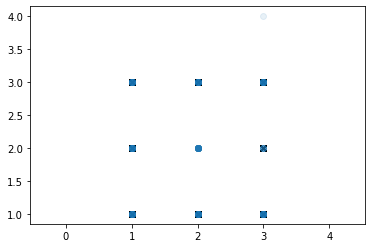

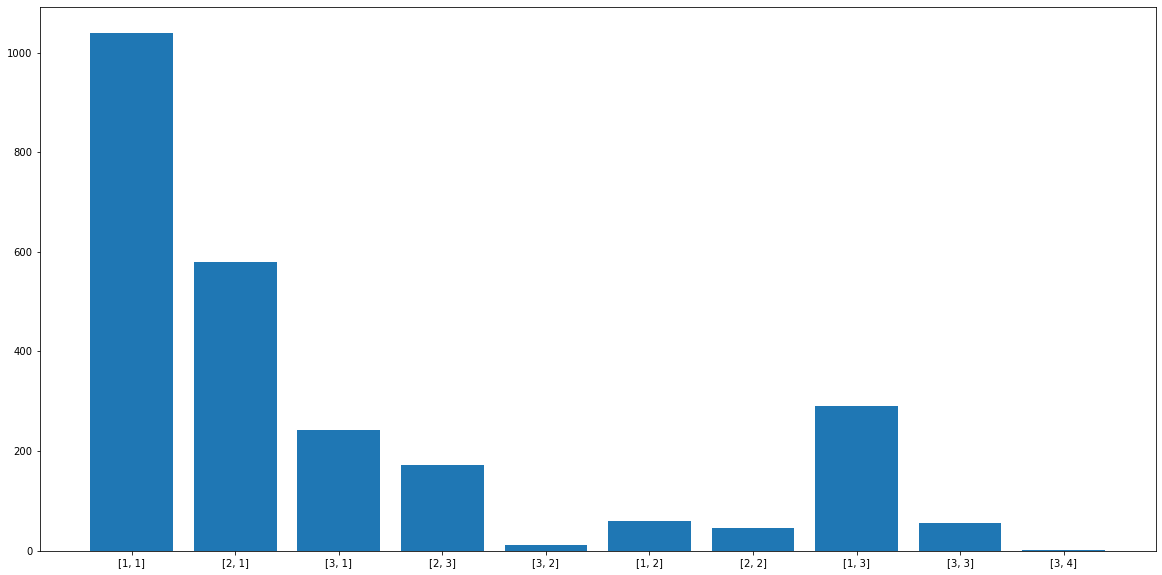

Processing Epoch 183
training start
Iteration 0, d real/fake loss 0.6019747257232666/0.6705315113067627 and g loss is 0.737908124923706, NDiv loss 0.05994749814271927
Iteration 1, d real/fake loss 0.6020326018333435/0.6587293744087219 and g loss is 0.7235645055770874, NDiv loss 0.05931635946035385
Iteration 2, d real/fake loss 0.6020900011062622/0.6747934818267822 and g loss is 0.7274547815322876, NDiv loss 0.0645928680896759
Iteration 3, d real/fake loss 0.6021631956100464/0.6530510187149048 and g loss is 0.7206531763076782, NDiv loss 0.06158844754099846
Iteration 4, d real/fake loss 0.6022276878356934/0.6570339798927307 and g loss is 0.7322984933853149, NDiv loss 0.07089144736528397


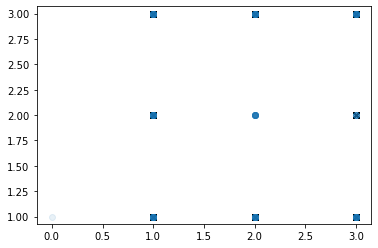

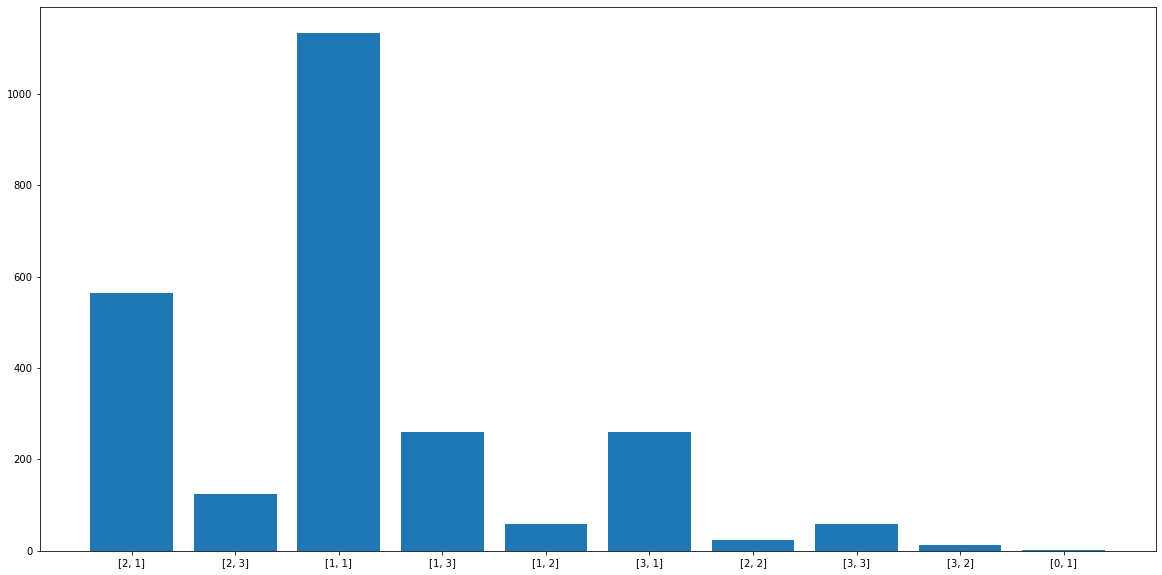

Processing Epoch 184
training start
Iteration 0, d real/fake loss 0.6023686528205872/0.6644032597541809 and g loss is 0.7347222566604614, NDiv loss 0.0623626634478569
Iteration 1, d real/fake loss 0.6021205186843872/0.6626789569854736 and g loss is 0.719689130783081, NDiv loss 0.06373520940542221
Iteration 2, d real/fake loss 0.6018573045730591/0.6617937684059143 and g loss is 0.729604184627533, NDiv loss 0.06806055456399918
Iteration 3, d real/fake loss 0.6015869379043579/0.6550359725952148 and g loss is 0.7158818244934082, NDiv loss 0.06841270625591278
Iteration 4, d real/fake loss 0.6013016700744629/0.680850625038147 and g loss is 0.7236131429672241, NDiv loss 0.0636996254324913


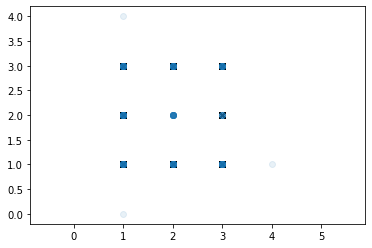

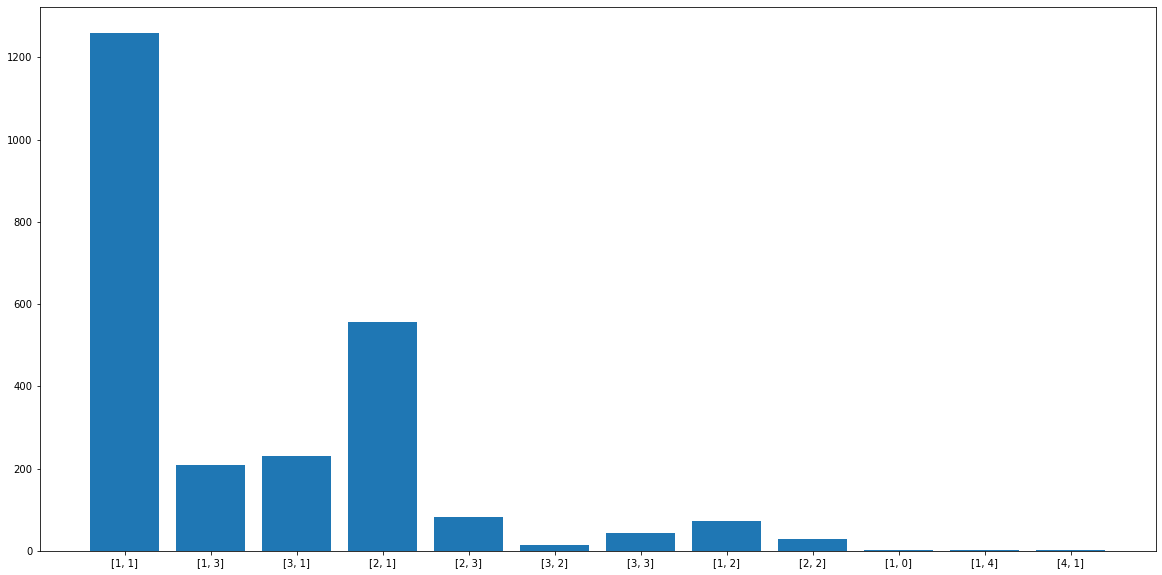

Processing Epoch 185
training start
Iteration 0, d real/fake loss 0.5996131896972656/0.6662886738777161 and g loss is 0.7212693691253662, NDiv loss 0.06521477550268173
Iteration 1, d real/fake loss 0.5998759269714355/0.670795202255249 and g loss is 0.7328518629074097, NDiv loss 0.06889069080352783
Iteration 2, d real/fake loss 0.6001499891281128/0.6711157560348511 and g loss is 0.7224615812301636, NDiv loss 0.06422984600067139
Iteration 3, d real/fake loss 0.6004339456558228/0.6683862209320068 and g loss is 0.7211405038833618, NDiv loss 0.06773901730775833
Iteration 4, d real/fake loss 0.6007236242294312/0.6778470277786255 and g loss is 0.7293983101844788, NDiv loss 0.07035160809755325


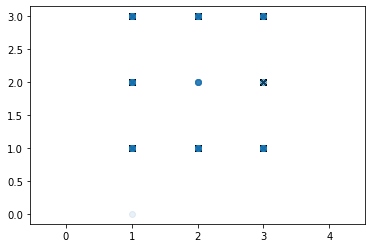

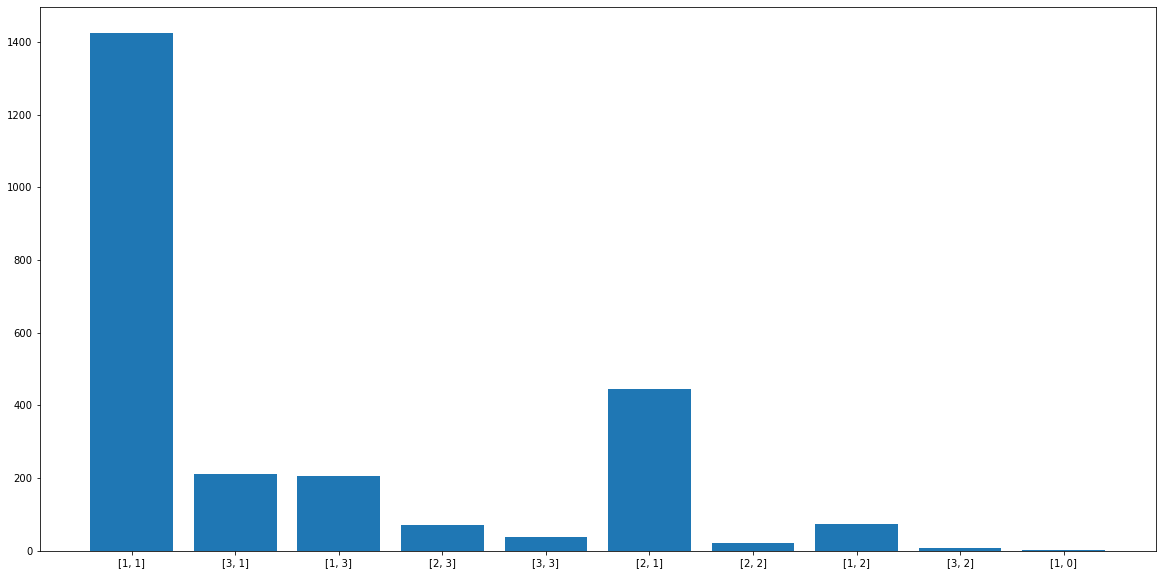

Processing Epoch 186
training start
Iteration 0, d real/fake loss 0.5981906652450562/0.6600361466407776 and g loss is 0.7196764945983887, NDiv loss 0.07494810223579407
Iteration 1, d real/fake loss 0.598312258720398/0.6707243919372559 and g loss is 0.7177155017852783, NDiv loss 0.07714848965406418
Iteration 2, d real/fake loss 0.5984394550323486/0.6697962284088135 and g loss is 0.7374269962310791, NDiv loss 0.06330772489309311
Iteration 3, d real/fake loss 0.5985711812973022/0.660448431968689 and g loss is 0.7192378044128418, NDiv loss 0.06429271399974823
Iteration 4, d real/fake loss 0.5986981391906738/0.6614776849746704 and g loss is 0.7297383546829224, NDiv loss 0.06712505966424942


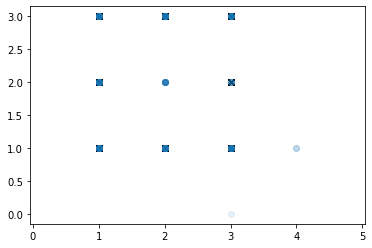

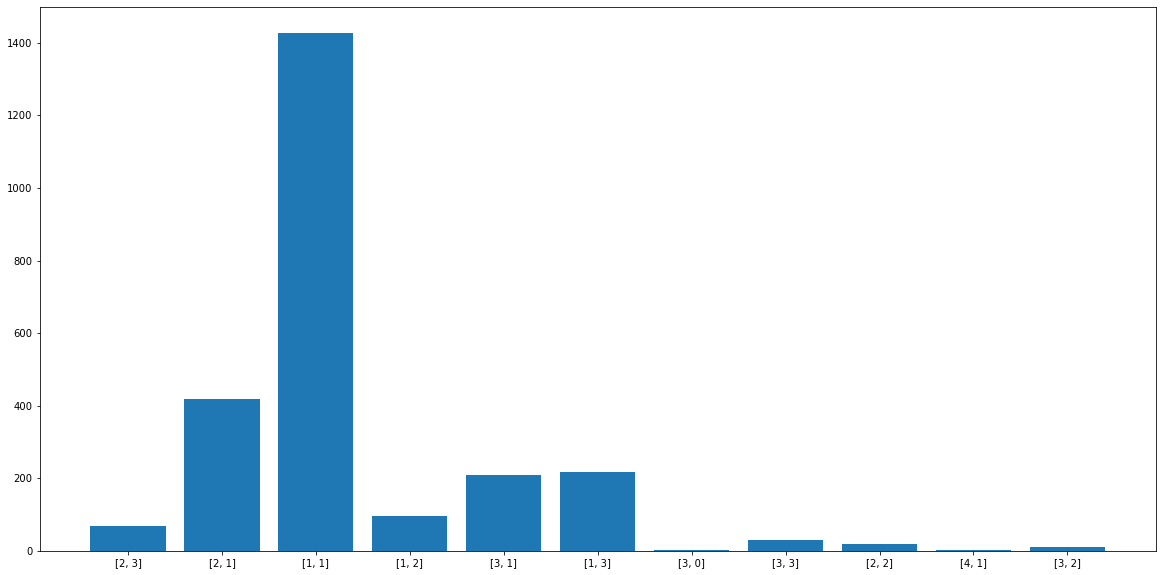

Processing Epoch 187
training start
Iteration 0, d real/fake loss 0.6036521196365356/0.6543642282485962 and g loss is 0.743085503578186, NDiv loss 0.07123955339193344
Iteration 1, d real/fake loss 0.6033687591552734/0.654417872428894 and g loss is 0.7337193489074707, NDiv loss 0.07110319286584854
Iteration 2, d real/fake loss 0.6030412912368774/0.6528404355049133 and g loss is 0.736208438873291, NDiv loss 0.07186053693294525
Iteration 3, d real/fake loss 0.6026753187179565/0.6551671028137207 and g loss is 0.735824704170227, NDiv loss 0.07269501686096191
Iteration 4, d real/fake loss 0.6022764444351196/0.6558646559715271 and g loss is 0.7294152975082397, NDiv loss 0.06962399929761887


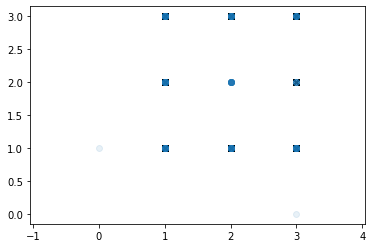

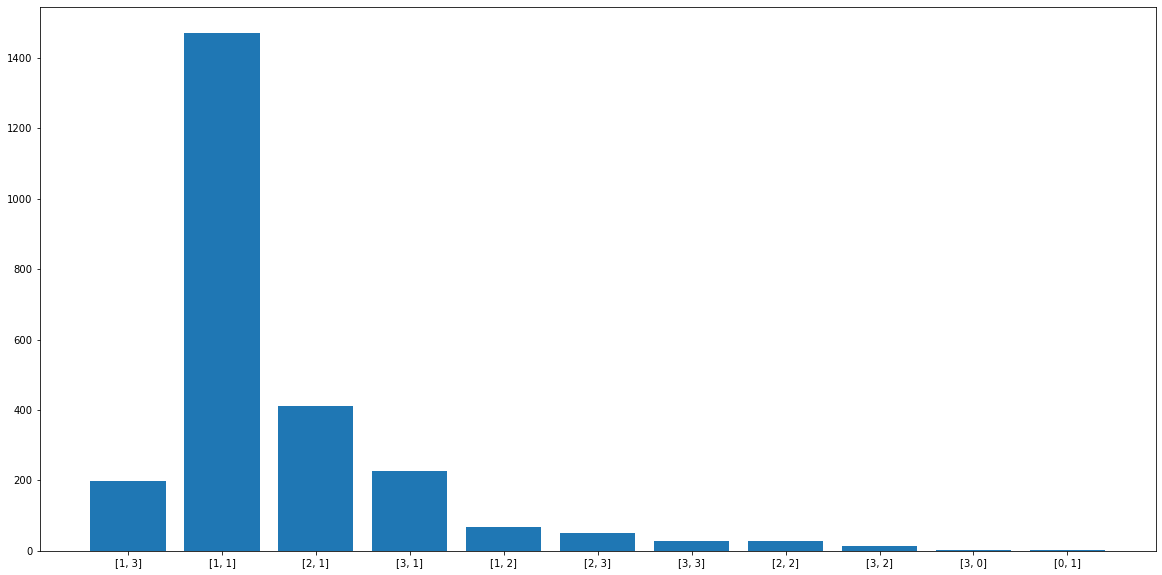

Processing Epoch 188
training start
Iteration 0, d real/fake loss 0.5986274480819702/0.6623605489730835 and g loss is 0.735248863697052, NDiv loss 0.06899025291204453
Iteration 1, d real/fake loss 0.598423957824707/0.6514384746551514 and g loss is 0.7446262836456299, NDiv loss 0.07753672450780869
Iteration 2, d real/fake loss 0.5982156991958618/0.6504145860671997 and g loss is 0.7492362260818481, NDiv loss 0.07282629609107971
Iteration 3, d real/fake loss 0.5979982614517212/0.646859884262085 and g loss is 0.7344092726707458, NDiv loss 0.06365665793418884
Iteration 4, d real/fake loss 0.5977720618247986/0.6478158831596375 and g loss is 0.750093936920166, NDiv loss 0.06676983833312988


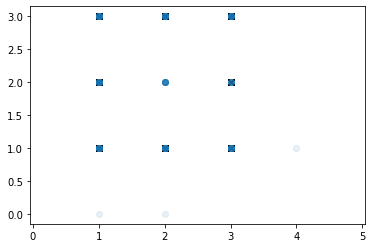

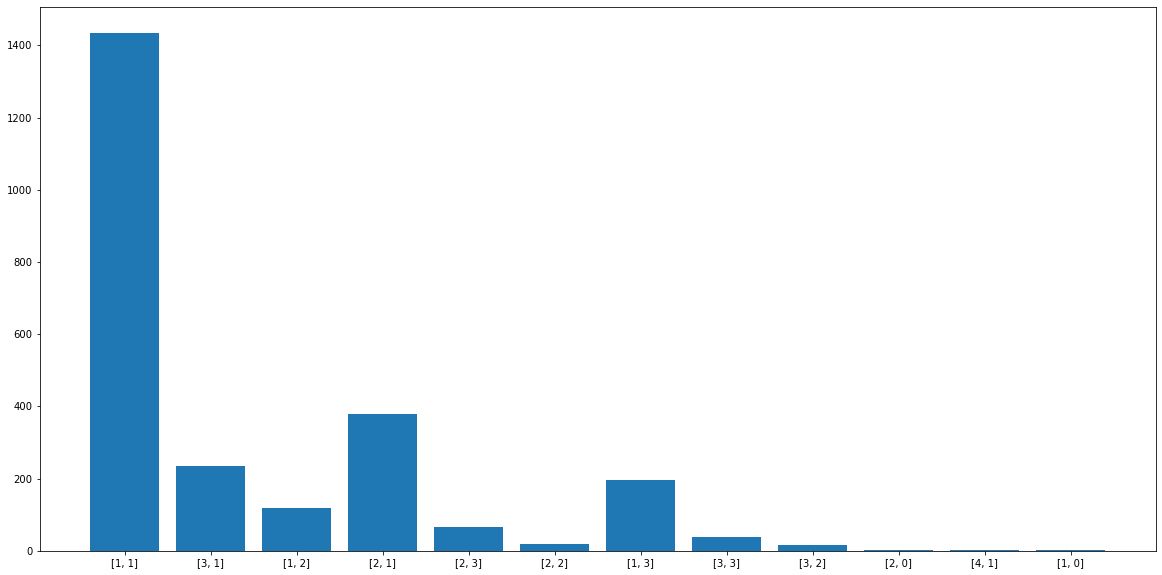

Processing Epoch 189
training start
Iteration 0, d real/fake loss 0.605486273765564/0.6559643149375916 and g loss is 0.7465518712997437, NDiv loss 0.07088494300842285
Iteration 1, d real/fake loss 0.6054122447967529/0.6499896049499512 and g loss is 0.7470300793647766, NDiv loss 0.06600247323513031
Iteration 2, d real/fake loss 0.6053179502487183/0.6517649292945862 and g loss is 0.7583932280540466, NDiv loss 0.06354574114084244
Iteration 3, d real/fake loss 0.6052031517028809/0.6414393186569214 and g loss is 0.752081573009491, NDiv loss 0.06656470894813538
Iteration 4, d real/fake loss 0.6050668954849243/0.6385102272033691 and g loss is 0.7632265686988831, NDiv loss 0.0746372640132904


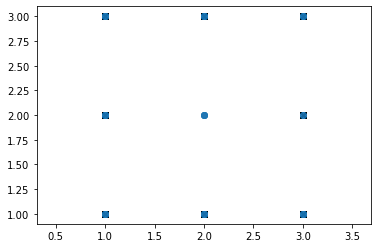

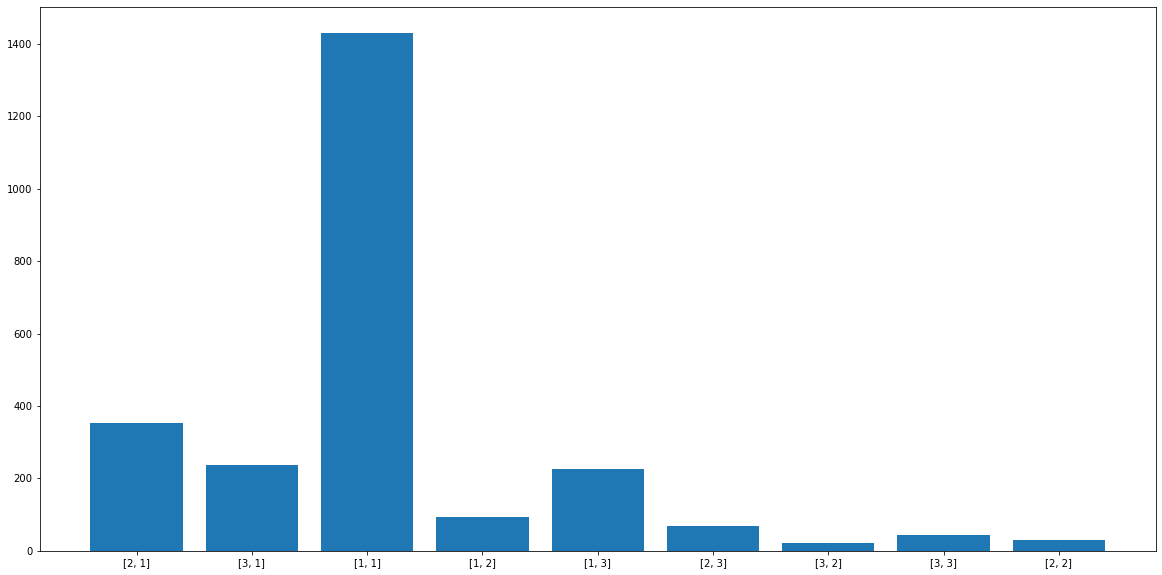

Processing Epoch 190
training start
Iteration 0, d real/fake loss 0.5968225002288818/0.6338571310043335 and g loss is 0.7667288780212402, NDiv loss 0.07559967786073685
Iteration 1, d real/fake loss 0.596656084060669/0.6397106647491455 and g loss is 0.7547466158866882, NDiv loss 0.07570654898881912
Iteration 2, d real/fake loss 0.5964874625205994/0.6309430599212646 and g loss is 0.7554777264595032, NDiv loss 0.06678563356399536
Iteration 3, d real/fake loss 0.5962991118431091/0.6273483037948608 and g loss is 0.7734776735305786, NDiv loss 0.06683707982301712
Iteration 4, d real/fake loss 0.5960965752601624/0.6353970766067505 and g loss is 0.7767093181610107, NDiv loss 0.0634339302778244


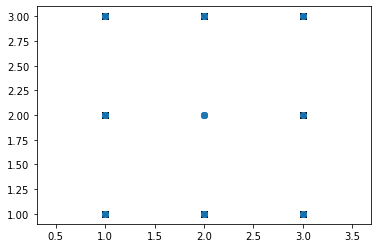

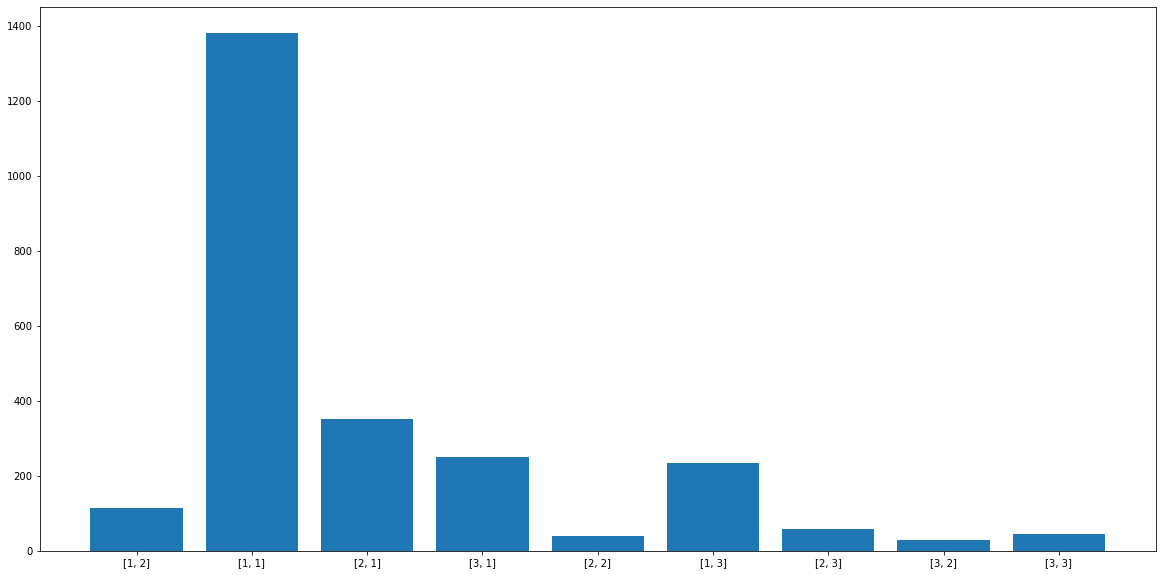

Processing Epoch 191
training start
Iteration 0, d real/fake loss 0.5997039079666138/0.6376706957817078 and g loss is 0.7563974261283875, NDiv loss 0.06398624181747437
Iteration 1, d real/fake loss 0.5994569063186646/0.6247886419296265 and g loss is 0.7665181159973145, NDiv loss 0.06601506471633911
Iteration 2, d real/fake loss 0.5991864204406738/0.624075174331665 and g loss is 0.7712295651435852, NDiv loss 0.06934285908937454
Iteration 3, d real/fake loss 0.5988970994949341/0.6262743473052979 and g loss is 0.7743309736251831, NDiv loss 0.062280625104904175
Iteration 4, d real/fake loss 0.5985981225967407/0.6134752035140991 and g loss is 0.7765944004058838, NDiv loss 0.07621493190526962


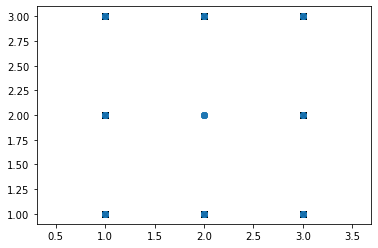

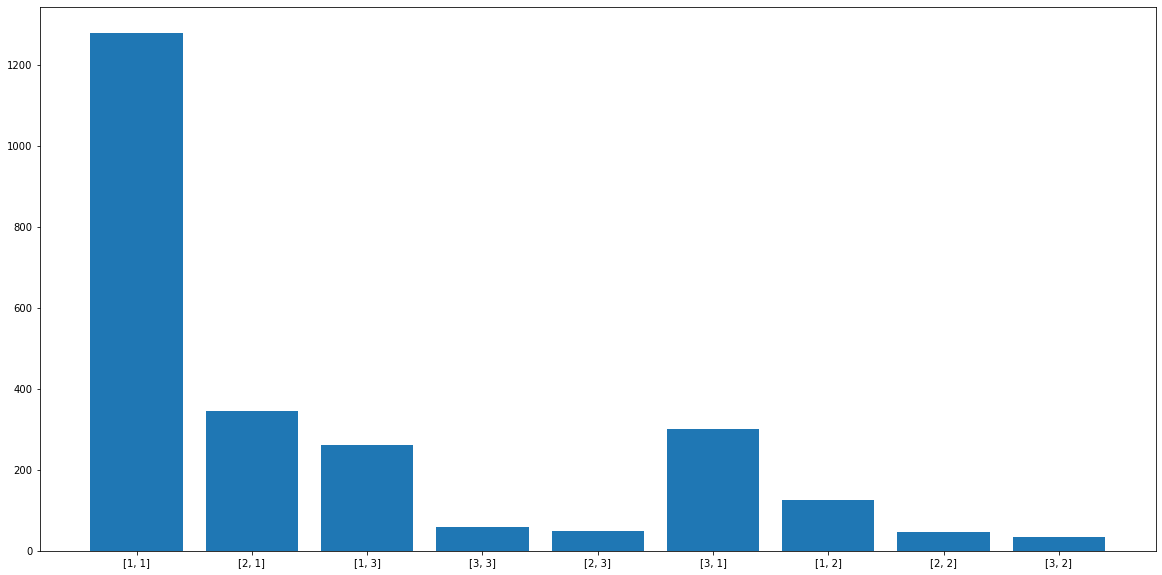

Processing Epoch 192
training start
Iteration 0, d real/fake loss 0.6008332967758179/0.6253849267959595 and g loss is 0.7784203290939331, NDiv loss 0.06157880276441574
Iteration 1, d real/fake loss 0.6006124019622803/0.6157594919204712 and g loss is 0.7746410369873047, NDiv loss 0.062291499227285385
Iteration 2, d real/fake loss 0.6003774404525757/0.623571515083313 and g loss is 0.7705091238021851, NDiv loss 0.06598488241434097
Iteration 3, d real/fake loss 0.6001351475715637/0.6153234243392944 and g loss is 0.7823638916015625, NDiv loss 0.06477747857570648
Iteration 4, d real/fake loss 0.5998737215995789/0.6181407570838928 and g loss is 0.7858966588973999, NDiv loss 0.06018528342247009


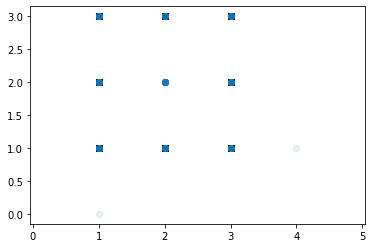

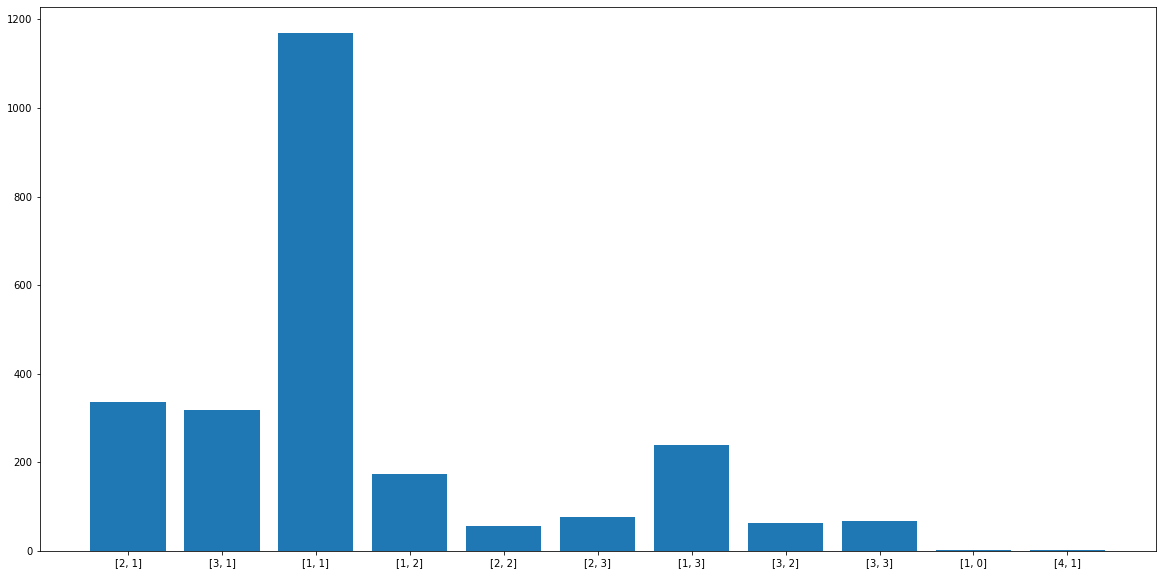

Processing Epoch 193
training start
Iteration 0, d real/fake loss 0.603273868560791/0.6090916991233826 and g loss is 0.780634880065918, NDiv loss 0.052735187113285065
Iteration 1, d real/fake loss 0.6029796600341797/0.619868814945221 and g loss is 0.7893898487091064, NDiv loss 0.060058269649744034
Iteration 2, d real/fake loss 0.6026808023452759/0.605307400226593 and g loss is 0.7733606100082397, NDiv loss 0.06142447143793106
Iteration 3, d real/fake loss 0.6023578643798828/0.6135432720184326 and g loss is 0.7845456004142761, NDiv loss 0.06516896933317184
Iteration 4, d real/fake loss 0.6020200252532959/0.6108770370483398 and g loss is 0.778535008430481, NDiv loss 0.05946587771177292


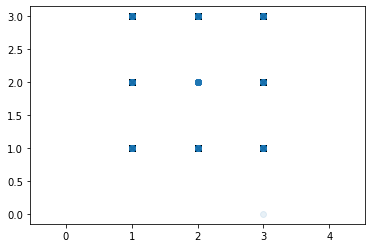

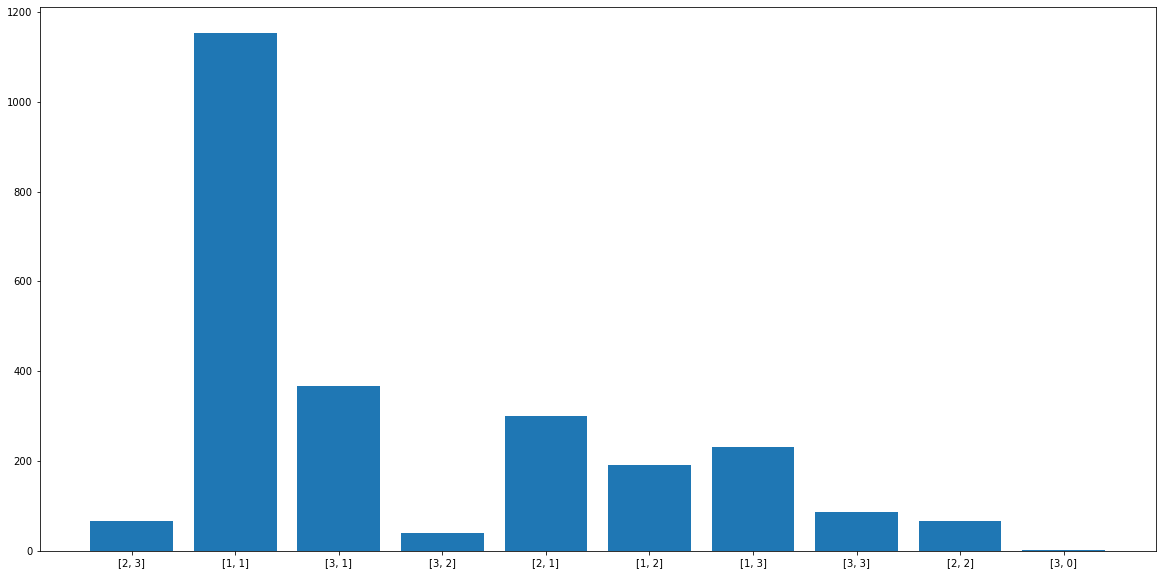

Processing Epoch 194
training start
Iteration 0, d real/fake loss 0.5962520837783813/0.6172701716423035 and g loss is 0.7780246734619141, NDiv loss 0.059550248086452484
Iteration 1, d real/fake loss 0.5959144830703735/0.6145326495170593 and g loss is 0.7864787578582764, NDiv loss 0.051207851618528366
Iteration 2, d real/fake loss 0.595579981803894/0.6165382266044617 and g loss is 0.782329797744751, NDiv loss 0.055930670350790024
Iteration 3, d real/fake loss 0.5952489376068115/0.6093705892562866 and g loss is 0.786281168460846, NDiv loss 0.05986523628234863
Iteration 4, d real/fake loss 0.5949125289916992/0.607004702091217 and g loss is 0.7838401794433594, NDiv loss 0.058279018849134445


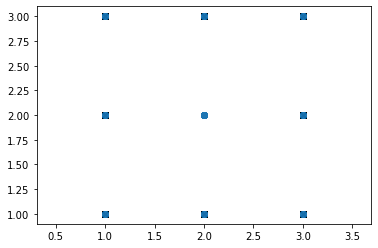

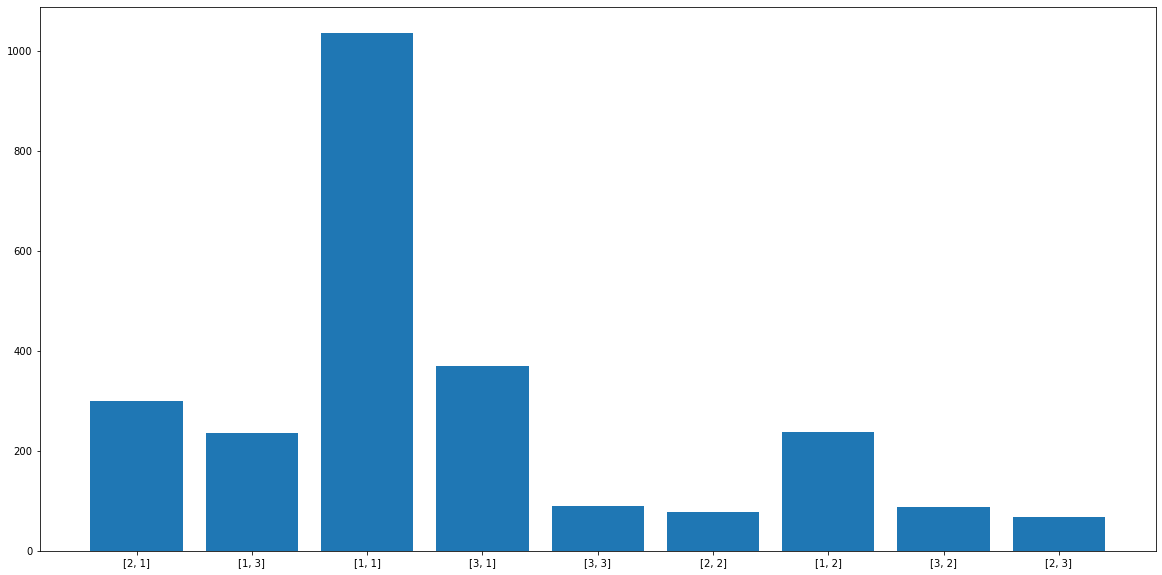

Processing Epoch 195
training start
Iteration 0, d real/fake loss 0.592580258846283/0.6125963926315308 and g loss is 0.7844753265380859, NDiv loss 0.055816441774368286
Iteration 1, d real/fake loss 0.5920153856277466/0.6116279363632202 and g loss is 0.7850881814956665, NDiv loss 0.056611549109220505
Iteration 2, d real/fake loss 0.5914350748062134/0.611077606678009 and g loss is 0.7811574935913086, NDiv loss 0.05466938018798828
Iteration 3, d real/fake loss 0.5908446311950684/0.6160039305686951 and g loss is 0.777355432510376, NDiv loss 0.05429049953818321
Iteration 4, d real/fake loss 0.5902489423751831/0.625308632850647 and g loss is 0.7882790565490723, NDiv loss 0.05706389248371124


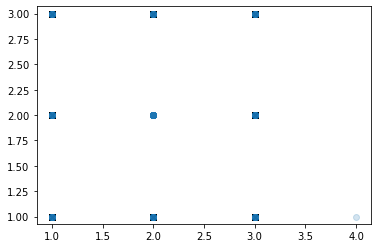

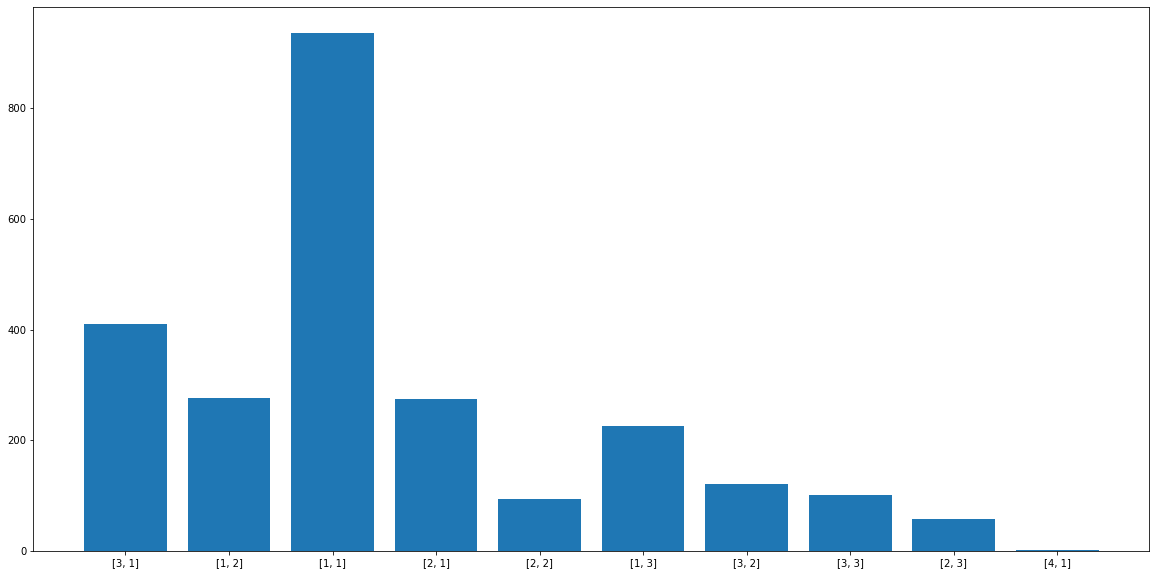

Processing Epoch 196
training start
Iteration 0, d real/fake loss 0.5942909717559814/0.6112686395645142 and g loss is 0.7815779447555542, NDiv loss 0.05077269300818443
Iteration 1, d real/fake loss 0.5939321517944336/0.6202289462089539 and g loss is 0.7829146385192871, NDiv loss 0.05435231328010559
Iteration 2, d real/fake loss 0.5935838222503662/0.6107813119888306 and g loss is 0.7857943773269653, NDiv loss 0.055530183017253876
Iteration 3, d real/fake loss 0.5932331681251526/0.6233024597167969 and g loss is 0.7855299711227417, NDiv loss 0.05417744442820549
Iteration 4, d real/fake loss 0.5928940773010254/0.6342270374298096 and g loss is 0.775004506111145, NDiv loss 0.052320484071969986


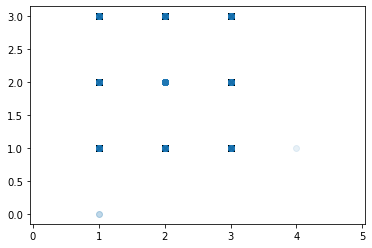

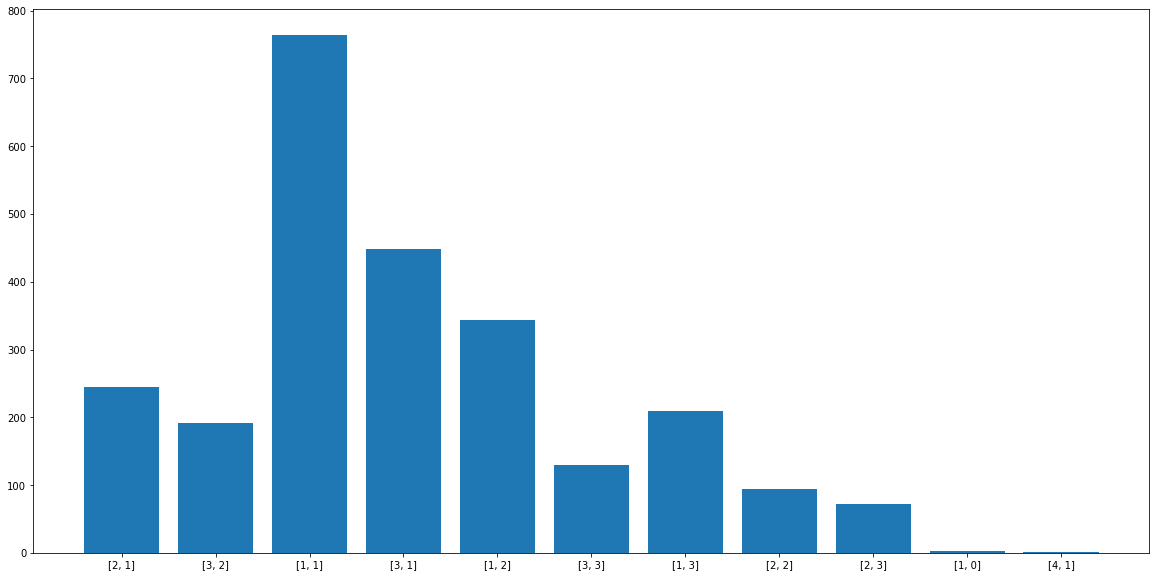

Processing Epoch 197
training start
Iteration 0, d real/fake loss 0.5889933705329895/0.6026226282119751 and g loss is 0.7674534320831299, NDiv loss 0.052536509931087494
Iteration 1, d real/fake loss 0.5886929035186768/0.618149995803833 and g loss is 0.774108350276947, NDiv loss 0.05253061652183533
Iteration 2, d real/fake loss 0.5884037017822266/0.6190834641456604 and g loss is 0.7654178142547607, NDiv loss 0.052164506167173386
Iteration 3, d real/fake loss 0.5881288051605225/0.6169782280921936 and g loss is 0.7735332250595093, NDiv loss 0.053574878722429276
Iteration 4, d real/fake loss 0.5878570675849915/0.6209532022476196 and g loss is 0.7780236005783081, NDiv loss 0.0505589134991169


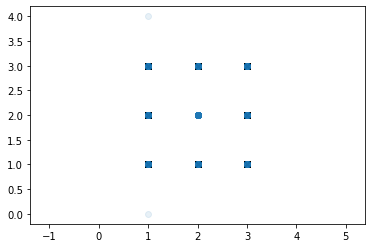

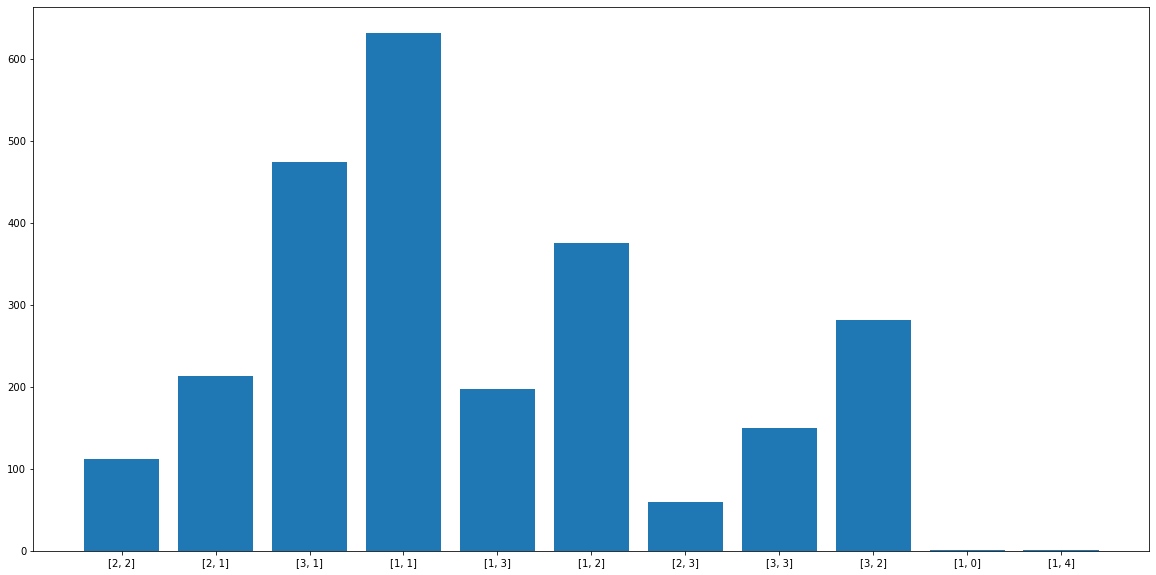

Processing Epoch 198
training start
Iteration 0, d real/fake loss 0.5922123193740845/0.6149609088897705 and g loss is 0.773682177066803, NDiv loss 0.051551271229982376
Iteration 1, d real/fake loss 0.5919802784919739/0.6251829266548157 and g loss is 0.7556015849113464, NDiv loss 0.05112447589635849
Iteration 2, d real/fake loss 0.591755747795105/0.6455788612365723 and g loss is 0.7634672522544861, NDiv loss 0.0495687834918499
Iteration 3, d real/fake loss 0.5915629267692566/0.6309009194374084 and g loss is 0.7486039400100708, NDiv loss 0.051529962569475174
Iteration 4, d real/fake loss 0.5913822650909424/0.639461874961853 and g loss is 0.768417239189148, NDiv loss 0.05415090546011925


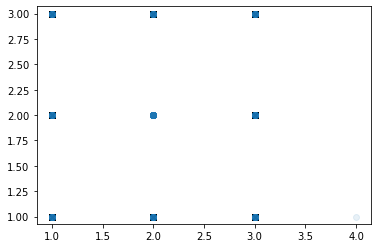

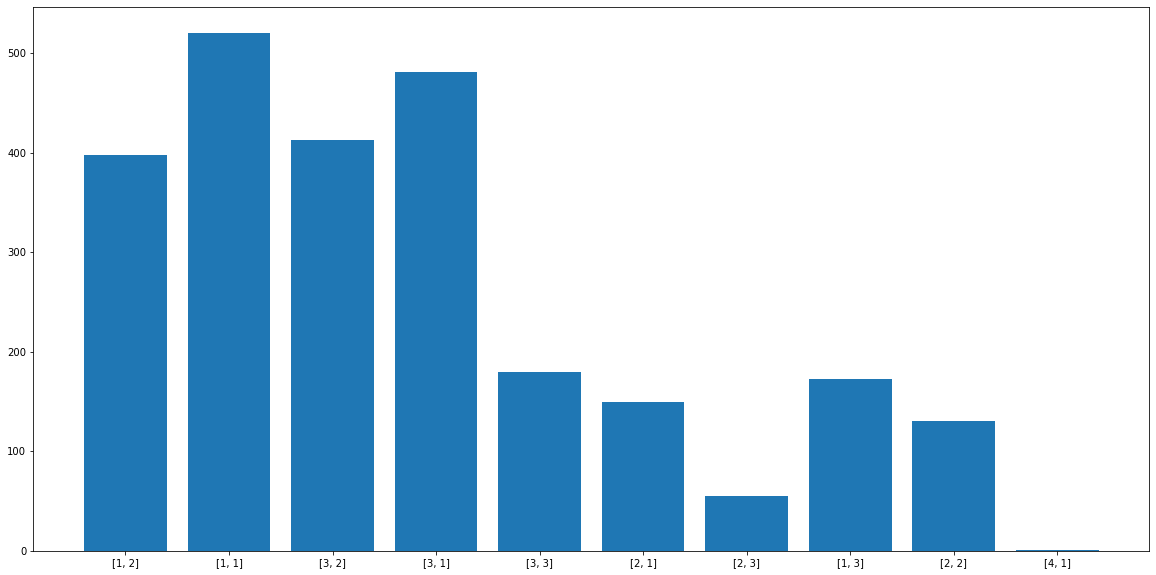

Processing Epoch 199
training start
Iteration 0, d real/fake loss 0.5764527916908264/0.646794855594635 and g loss is 0.7659501433372498, NDiv loss 0.05157511308789253
Iteration 1, d real/fake loss 0.5761963129043579/0.6568445563316345 and g loss is 0.7581914067268372, NDiv loss 0.05336304381489754
Iteration 2, d real/fake loss 0.5759789347648621/0.648705244064331 and g loss is 0.755988359451294, NDiv loss 0.049953993409872055
Iteration 3, d real/fake loss 0.575789213180542/0.6585919857025146 and g loss is 0.7444257140159607, NDiv loss 0.05296004191040993
Iteration 4, d real/fake loss 0.5756427049636841/0.66702800989151 and g loss is 0.741649866104126, NDiv loss 0.054150085896253586


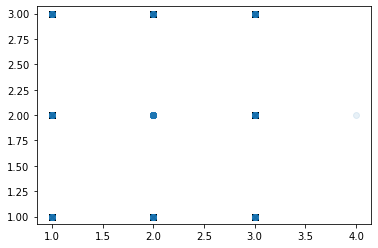

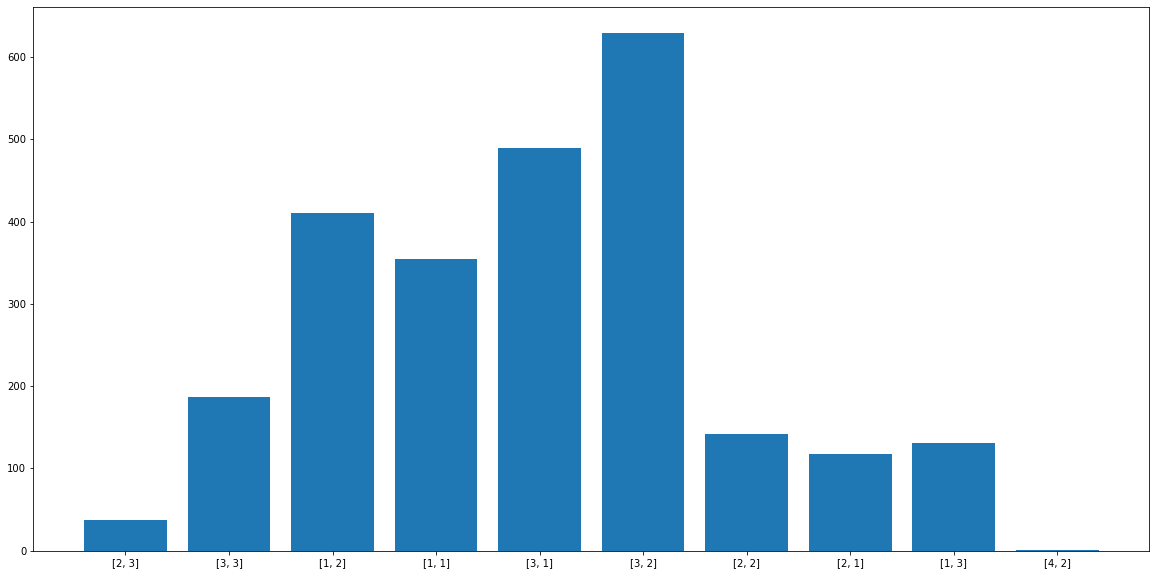

Processing Epoch 200
training start
Iteration 0, d real/fake loss 0.596006453037262/0.6555095911026001 and g loss is 0.744635820388794, NDiv loss 0.054900068789720535
Iteration 1, d real/fake loss 0.5960664749145508/0.6577877998352051 and g loss is 0.7409722805023193, NDiv loss 0.05528568476438522
Iteration 2, d real/fake loss 0.596132218837738/0.6649846434593201 and g loss is 0.737053394317627, NDiv loss 0.05232950672507286
Iteration 3, d real/fake loss 0.5962135195732117/0.6651145219802856 and g loss is 0.7384517192840576, NDiv loss 0.051724981516599655
Iteration 4, d real/fake loss 0.596306562423706/0.6793079376220703 and g loss is 0.7132198810577393, NDiv loss 0.056802086532115936


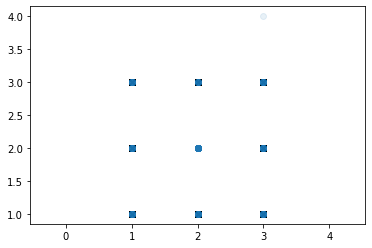

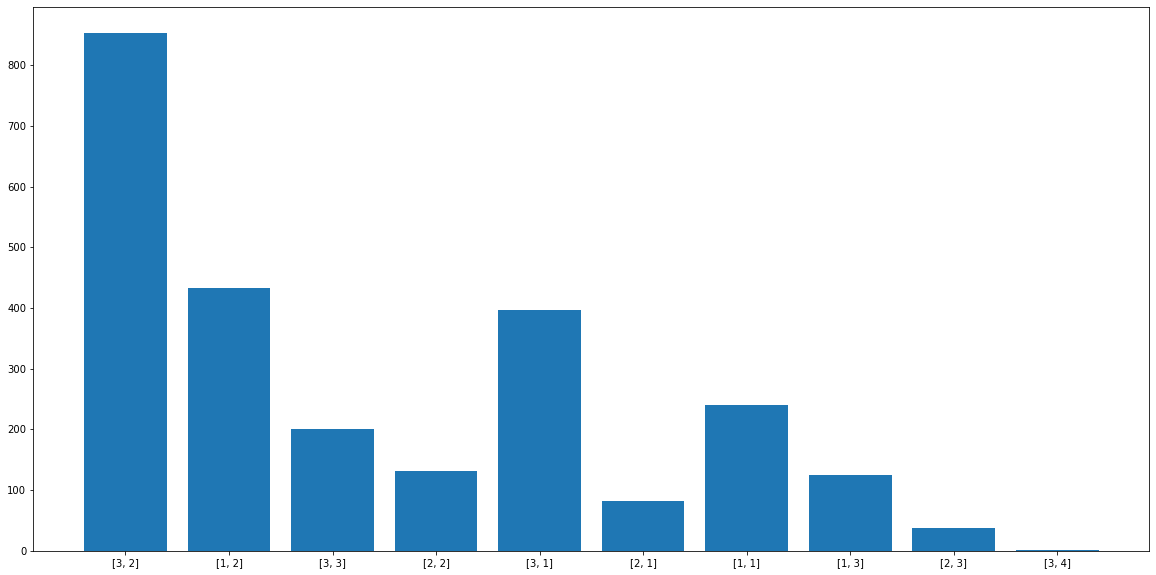

Processing Epoch 201
training start
Iteration 0, d real/fake loss 0.5756396055221558/0.6735052466392517 and g loss is 0.6991450786590576, NDiv loss 0.05918155610561371
Iteration 1, d real/fake loss 0.5759849548339844/0.6682989597320557 and g loss is 0.7141690254211426, NDiv loss 0.0590134933590889
Iteration 2, d real/fake loss 0.5763590335845947/0.696546196937561 and g loss is 0.7125591039657593, NDiv loss 0.058526020497083664
Iteration 3, d real/fake loss 0.5767994523048401/0.6755383014678955 and g loss is 0.7064350843429565, NDiv loss 0.05856169015169144
Iteration 4, d real/fake loss 0.5772706270217896/0.7108685374259949 and g loss is 0.7097293734550476, NDiv loss 0.06161017715930939


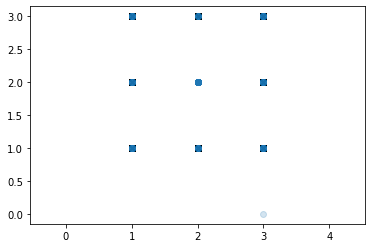

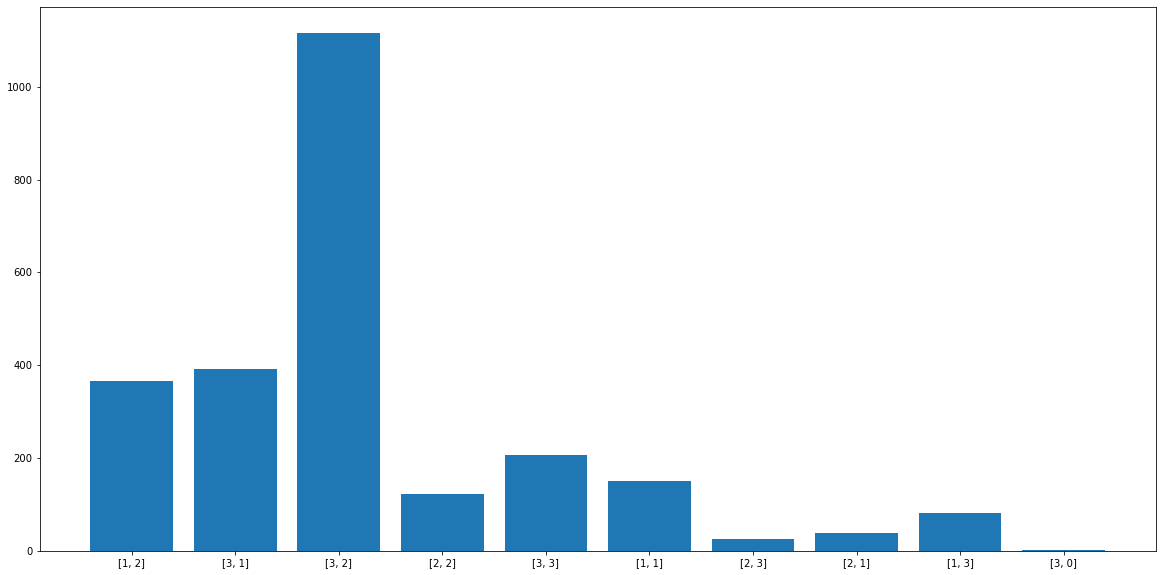

Processing Epoch 202
training start
Iteration 0, d real/fake loss 0.5923022627830505/0.6929397583007812 and g loss is 0.7065359354019165, NDiv loss 0.062349334359169006
Iteration 1, d real/fake loss 0.5925242900848389/0.7154875993728638 and g loss is 0.6886518001556396, NDiv loss 0.062480051070451736
Iteration 2, d real/fake loss 0.5927673578262329/0.6942183971405029 and g loss is 0.6974148750305176, NDiv loss 0.06446807086467743
Iteration 3, d real/fake loss 0.5930086970329285/0.7245378494262695 and g loss is 0.6805004477500916, NDiv loss 0.06054991856217384
Iteration 4, d real/fake loss 0.5932757258415222/0.7068623304367065 and g loss is 0.6634519100189209, NDiv loss 0.062319565564394


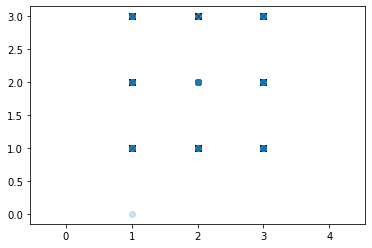

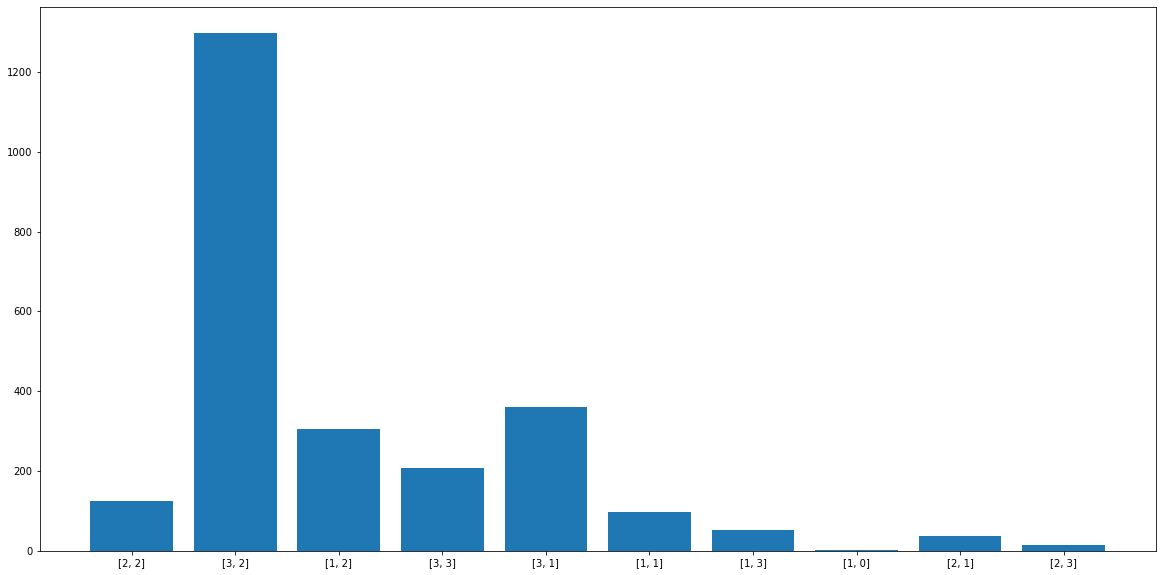

Processing Epoch 203
training start
Iteration 0, d real/fake loss 0.5907042026519775/0.7183987498283386 and g loss is 0.6907229423522949, NDiv loss 0.06425980478525162
Iteration 1, d real/fake loss 0.591302216053009/0.7047417163848877 and g loss is 0.6833098530769348, NDiv loss 0.06626757234334946
Iteration 2, d real/fake loss 0.591912031173706/0.7162502408027649 and g loss is 0.6965610980987549, NDiv loss 0.06600386649370193
Iteration 3, d real/fake loss 0.5925427079200745/0.7201974391937256 and g loss is 0.6818401217460632, NDiv loss 0.07833708077669144
Iteration 4, d real/fake loss 0.5931980609893799/0.7235937118530273 and g loss is 0.6828059554100037, NDiv loss 0.06486854702234268


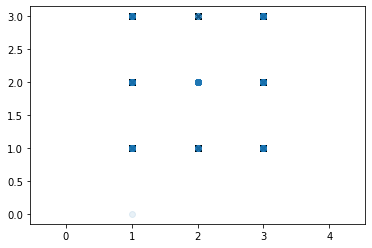

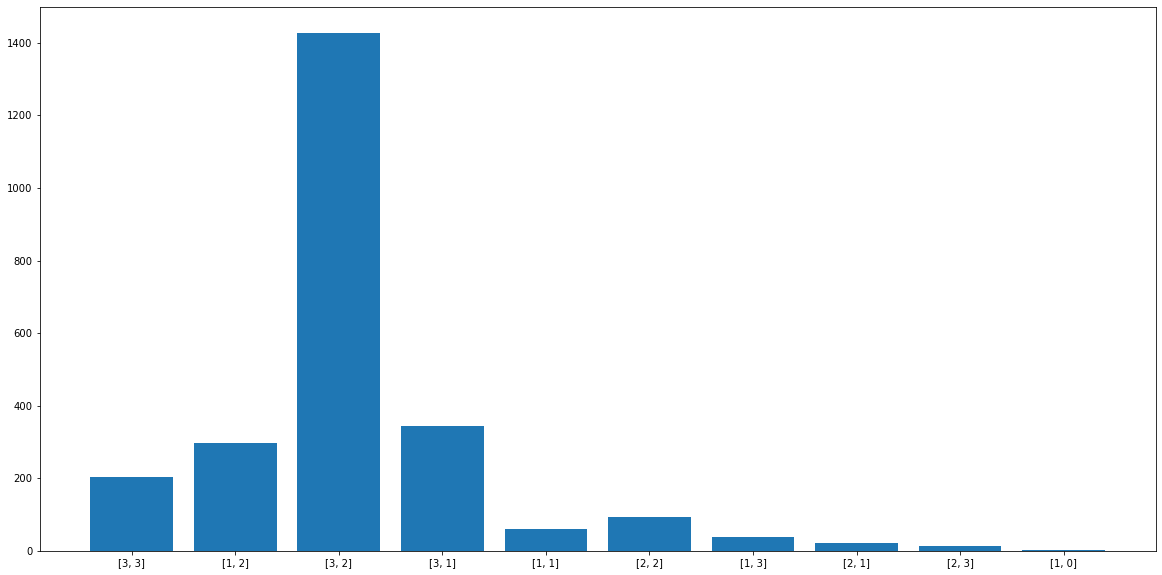

Processing Epoch 204
training start
Iteration 0, d real/fake loss 0.5880234241485596/0.7285881042480469 and g loss is 0.6954542398452759, NDiv loss 0.06840236485004425
Iteration 1, d real/fake loss 0.5887230038642883/0.7174233198165894 and g loss is 0.6776343584060669, NDiv loss 0.06774388998746872
Iteration 2, d real/fake loss 0.5894324779510498/0.7074797749519348 and g loss is 0.6948085427284241, NDiv loss 0.06733759492635727
Iteration 3, d real/fake loss 0.5901410579681396/0.7120304107666016 and g loss is 0.6880249977111816, NDiv loss 0.07194524258375168
Iteration 4, d real/fake loss 0.5908521413803101/0.7131830453872681 and g loss is 0.6868430376052856, NDiv loss 0.07123707979917526


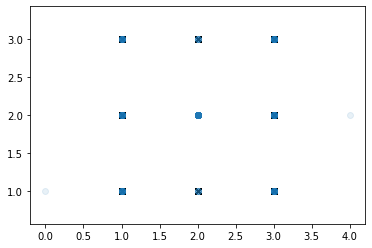

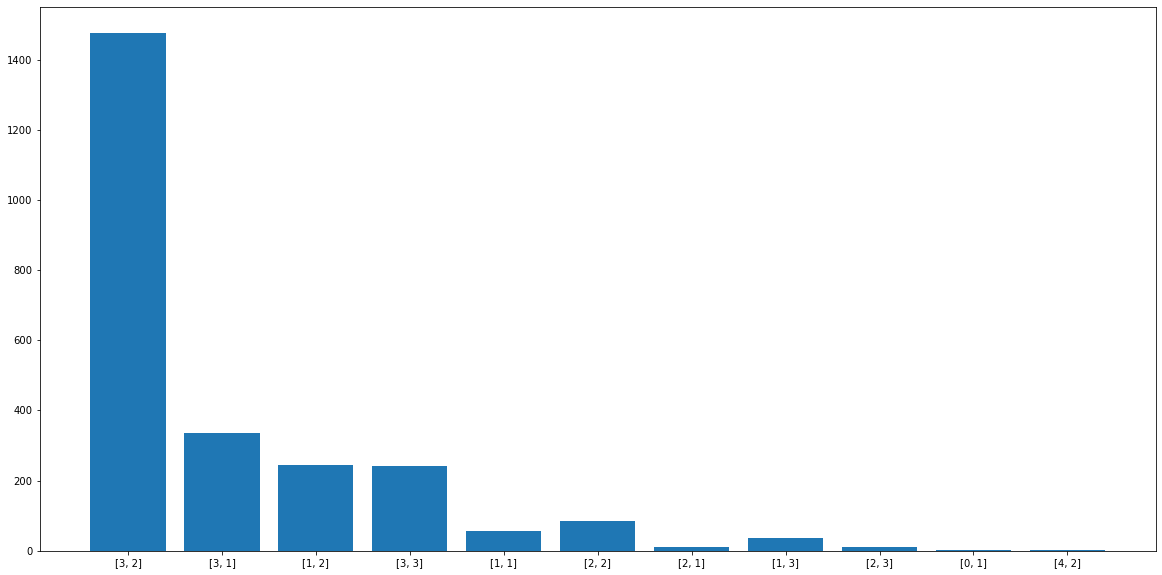

Processing Epoch 205
training start
Iteration 0, d real/fake loss 0.6015020608901978/0.7141702771186829 and g loss is 0.6895681619644165, NDiv loss 0.07539182901382446
Iteration 1, d real/fake loss 0.6021336317062378/0.6983858942985535 and g loss is 0.6927928924560547, NDiv loss 0.0718456357717514
Iteration 2, d real/fake loss 0.6027384996414185/0.7064575552940369 and g loss is 0.6752517223358154, NDiv loss 0.07670877128839493
Iteration 3, d real/fake loss 0.6033257246017456/0.711967408657074 and g loss is 0.6986179947853088, NDiv loss 0.07517725229263306
Iteration 4, d real/fake loss 0.6039023995399475/0.7099440097808838 and g loss is 0.7034246921539307, NDiv loss 0.06616246700286865


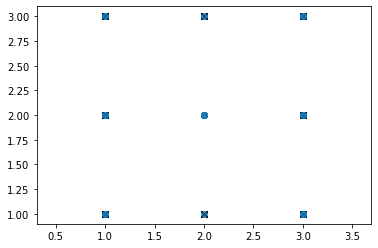

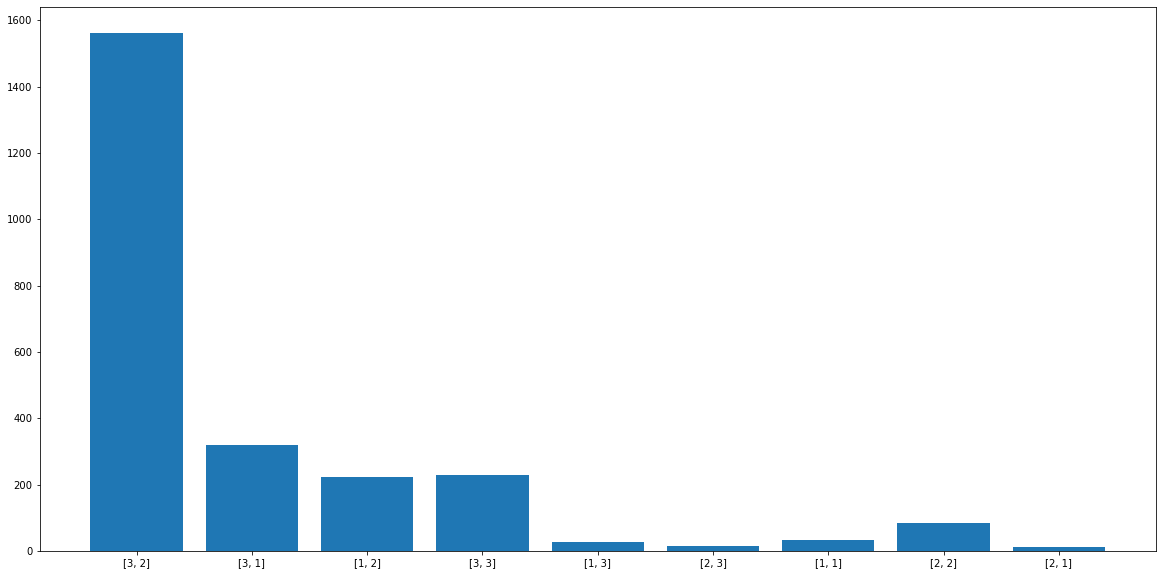

Processing Epoch 206
training start
Iteration 0, d real/fake loss 0.5932636260986328/0.6960494518280029 and g loss is 0.6884783506393433, NDiv loss 0.0723758190870285
Iteration 1, d real/fake loss 0.5936782360076904/0.7059959769248962 and g loss is 0.6901718974113464, NDiv loss 0.07149964570999146
Iteration 2, d real/fake loss 0.5940836071968079/0.7039556503295898 and g loss is 0.6964036226272583, NDiv loss 0.07060623914003372
Iteration 3, d real/fake loss 0.5944731831550598/0.6848993897438049 and g loss is 0.6962680220603943, NDiv loss 0.07337366789579391
Iteration 4, d real/fake loss 0.5948294997215271/0.6911933422088623 and g loss is 0.7036378979682922, NDiv loss 0.07273632287979126


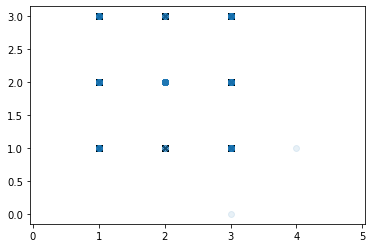

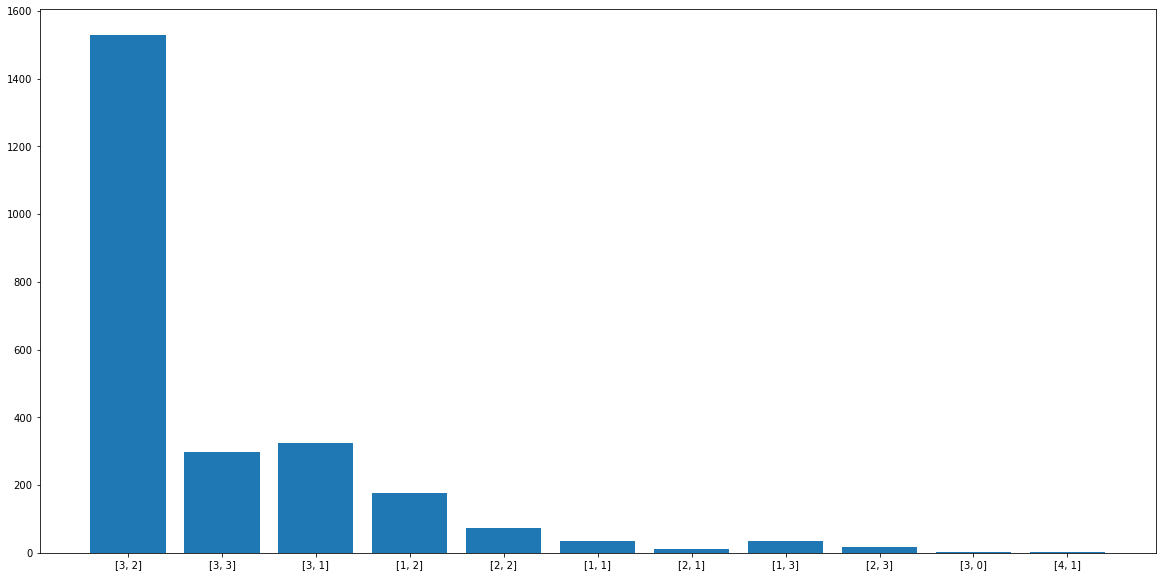

Processing Epoch 207
training start
Iteration 0, d real/fake loss 0.6045714616775513/0.6977514028549194 and g loss is 0.7030855417251587, NDiv loss 0.07917173206806183
Iteration 1, d real/fake loss 0.6052435040473938/0.6826160550117493 and g loss is 0.7129267454147339, NDiv loss 0.07408908009529114
Iteration 2, d real/fake loss 0.6058825254440308/0.6850304007530212 and g loss is 0.7173205018043518, NDiv loss 0.07494653761386871
Iteration 3, d real/fake loss 0.60649573802948/0.6767405271530151 and g loss is 0.7185099124908447, NDiv loss 0.07721492648124695
Iteration 4, d real/fake loss 0.607079029083252/0.6730139255523682 and g loss is 0.7206476330757141, NDiv loss 0.07808243483304977


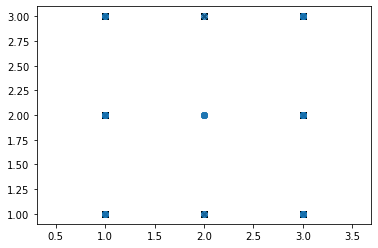

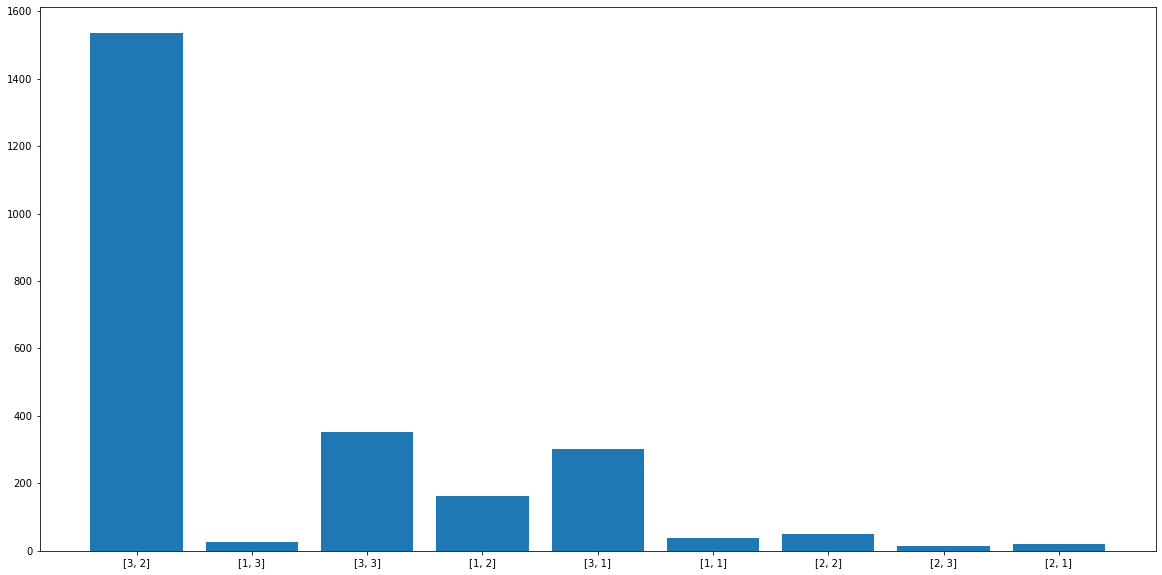

Processing Epoch 208
training start
Iteration 0, d real/fake loss 0.6106488704681396/0.6741480827331543 and g loss is 0.7129526138305664, NDiv loss 0.06633035093545914
Iteration 1, d real/fake loss 0.610989511013031/0.6676194667816162 and g loss is 0.7240553498268127, NDiv loss 0.07586845755577087
Iteration 2, d real/fake loss 0.6112964749336243/0.6655437350273132 and g loss is 0.7140904068946838, NDiv loss 0.07347645610570908
Iteration 3, d real/fake loss 0.6115663051605225/0.6736614108085632 and g loss is 0.7238802313804626, NDiv loss 0.06584745645523071
Iteration 4, d real/fake loss 0.6118184328079224/0.6684550046920776 and g loss is 0.7367450594902039, NDiv loss 0.07213707268238068


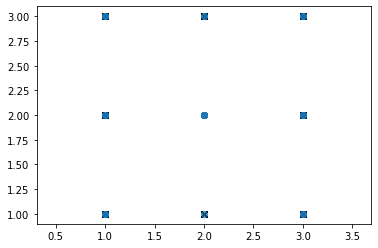

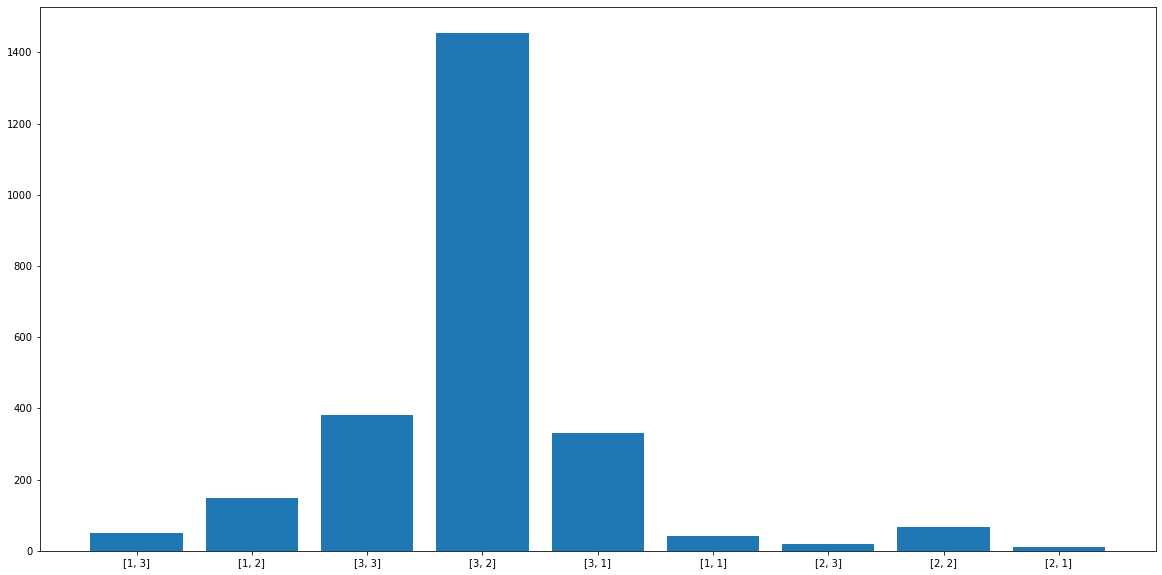

Processing Epoch 209
training start
Iteration 0, d real/fake loss 0.6088776588439941/0.6678193211555481 and g loss is 0.7351508140563965, NDiv loss 0.07171471416950226
Iteration 1, d real/fake loss 0.6091246008872986/0.6453978419303894 and g loss is 0.7440123558044434, NDiv loss 0.06668303161859512
Iteration 2, d real/fake loss 0.6093325614929199/0.6619281768798828 and g loss is 0.7359910607337952, NDiv loss 0.061516109853982925
Iteration 3, d real/fake loss 0.6095231771469116/0.6613835096359253 and g loss is 0.7480276823043823, NDiv loss 0.07497885823249817
Iteration 4, d real/fake loss 0.6096934080123901/0.6591815948486328 and g loss is 0.7379955053329468, NDiv loss 0.07077786326408386


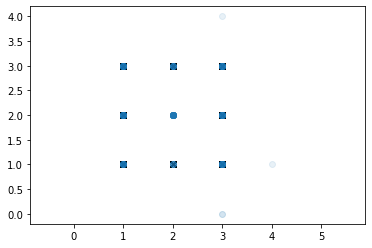

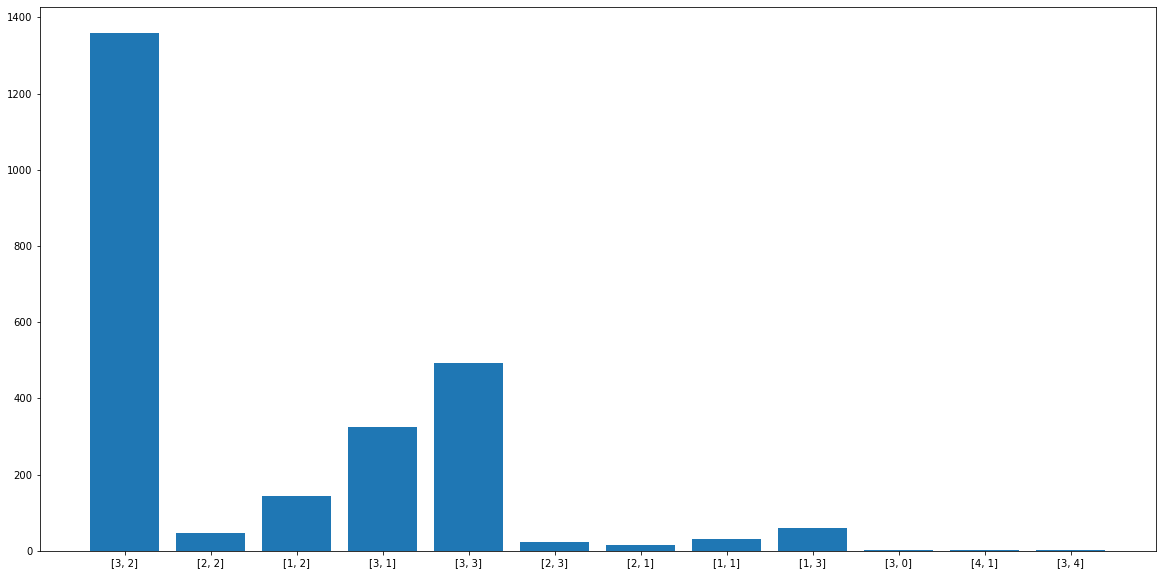

Processing Epoch 210
training start
Iteration 0, d real/fake loss 0.614722490310669/0.6628756523132324 and g loss is 0.742510199546814, NDiv loss 0.07081317901611328
Iteration 1, d real/fake loss 0.6150146722793579/0.6537730693817139 and g loss is 0.745004415512085, NDiv loss 0.06258752942085266
Iteration 2, d real/fake loss 0.615283191204071/0.6430898904800415 and g loss is 0.737045168876648, NDiv loss 0.06918637454509735
Iteration 3, d real/fake loss 0.6155186891555786/0.6510712504386902 and g loss is 0.7491832971572876, NDiv loss 0.06624665856361389
Iteration 4, d real/fake loss 0.6157347559928894/0.6538046598434448 and g loss is 0.7491245269775391, NDiv loss 0.0740046426653862


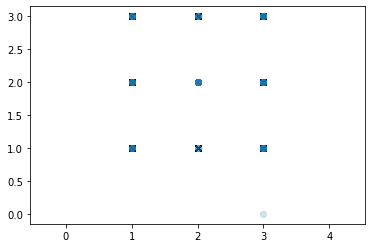

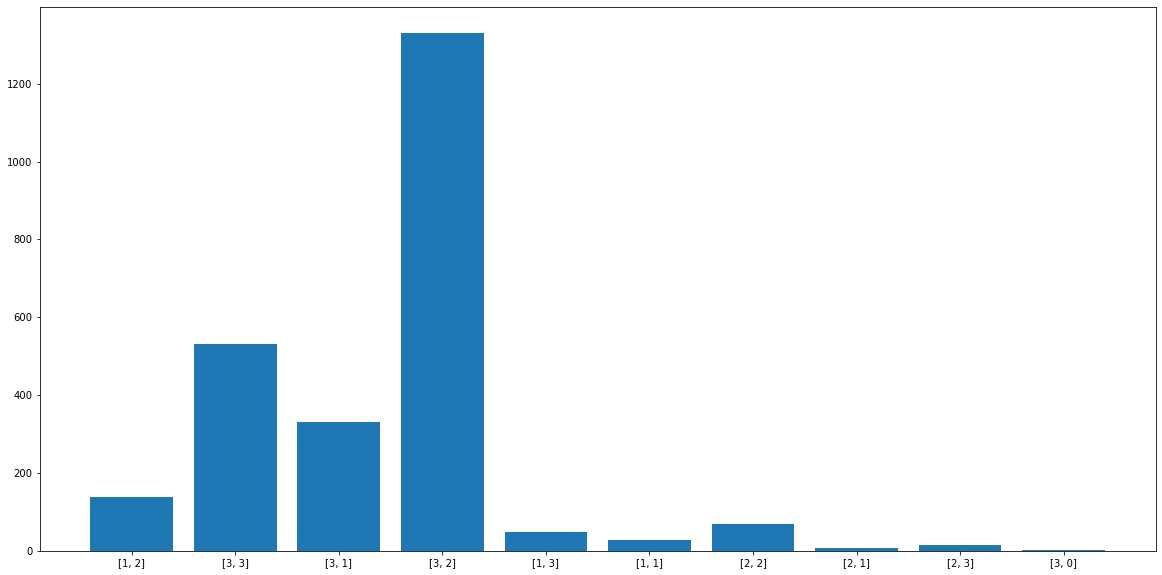

Processing Epoch 211
training start
Iteration 0, d real/fake loss 0.6063286662101746/0.6390564441680908 and g loss is 0.7516961693763733, NDiv loss 0.0750298872590065
Iteration 1, d real/fake loss 0.6064221858978271/0.6501985788345337 and g loss is 0.7606943845748901, NDiv loss 0.06826359778642654
Iteration 2, d real/fake loss 0.606512188911438/0.6346617341041565 and g loss is 0.7425171136856079, NDiv loss 0.06940668076276779
Iteration 3, d real/fake loss 0.6065794825553894/0.6340619325637817 and g loss is 0.7631523609161377, NDiv loss 0.08143425732851028
Iteration 4, d real/fake loss 0.6066283583641052/0.6424398422241211 and g loss is 0.7648827433586121, NDiv loss 0.068203866481781


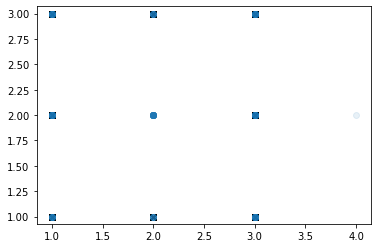

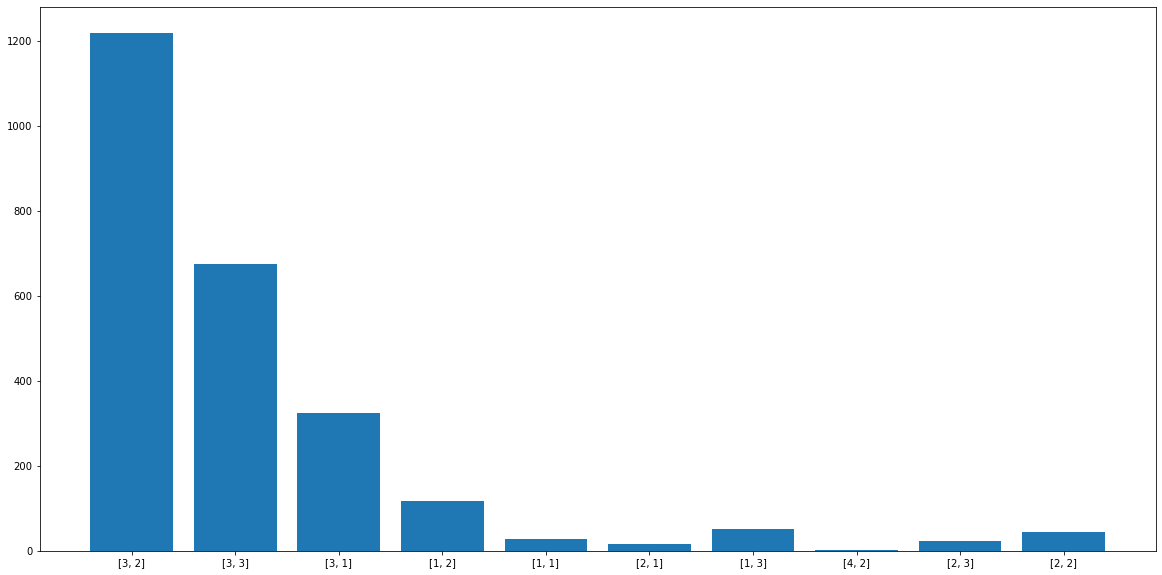

Processing Epoch 212
training start
Iteration 0, d real/fake loss 0.6146701574325562/0.6293897032737732 and g loss is 0.7490575909614563, NDiv loss 0.06706272065639496
Iteration 1, d real/fake loss 0.6146277189254761/0.6368945837020874 and g loss is 0.7644982933998108, NDiv loss 0.07103639096021652
Iteration 2, d real/fake loss 0.6145691871643066/0.6356491446495056 and g loss is 0.7636948227882385, NDiv loss 0.07320849597454071
Iteration 3, d real/fake loss 0.6144949793815613/0.6331186294555664 and g loss is 0.7629661560058594, NDiv loss 0.0657876580953598
Iteration 4, d real/fake loss 0.6144022345542908/0.6296018958091736 and g loss is 0.7496516704559326, NDiv loss 0.0701417475938797


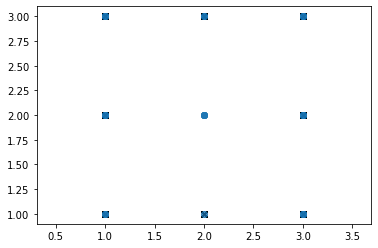

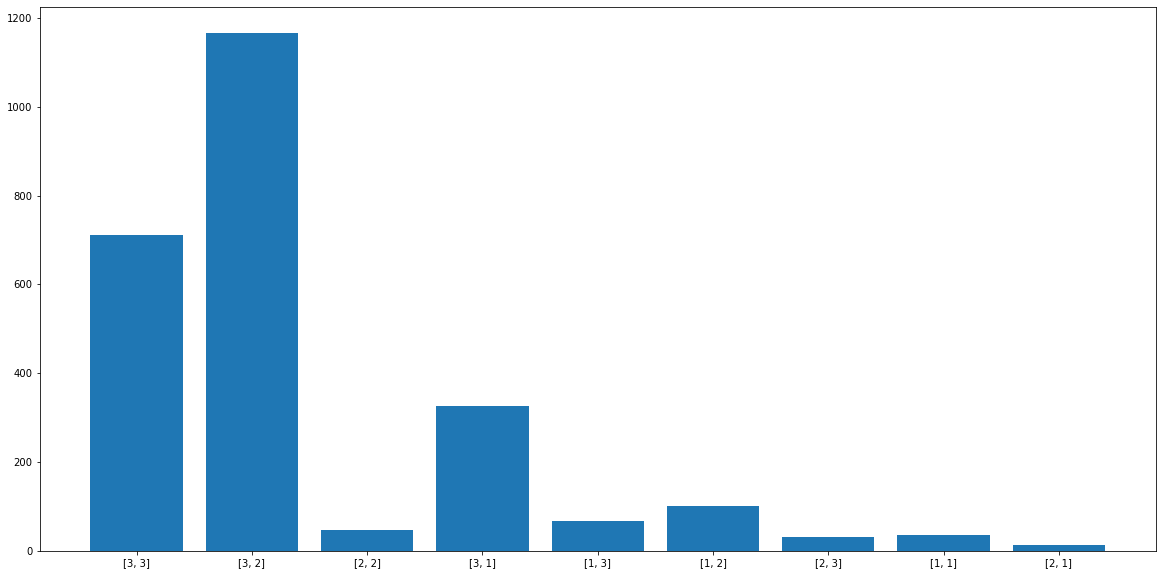

Processing Epoch 213
training start
Iteration 0, d real/fake loss 0.6118646860122681/0.632776141166687 and g loss is 0.761271595954895, NDiv loss 0.06699188798666
Iteration 1, d real/fake loss 0.6117454767227173/0.6290756464004517 and g loss is 0.7579702734947205, NDiv loss 0.06653601676225662
Iteration 2, d real/fake loss 0.6116135120391846/0.632950484752655 and g loss is 0.769343376159668, NDiv loss 0.0659361332654953
Iteration 3, d real/fake loss 0.61147540807724/0.6311817169189453 and g loss is 0.7681146264076233, NDiv loss 0.06929956376552582
Iteration 4, d real/fake loss 0.6113325357437134/0.6416718363761902 and g loss is 0.7725884318351746, NDiv loss 0.06950738281011581


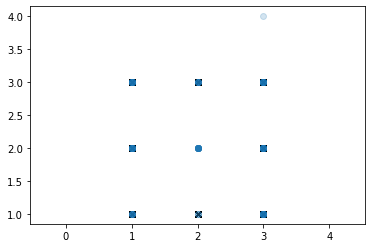

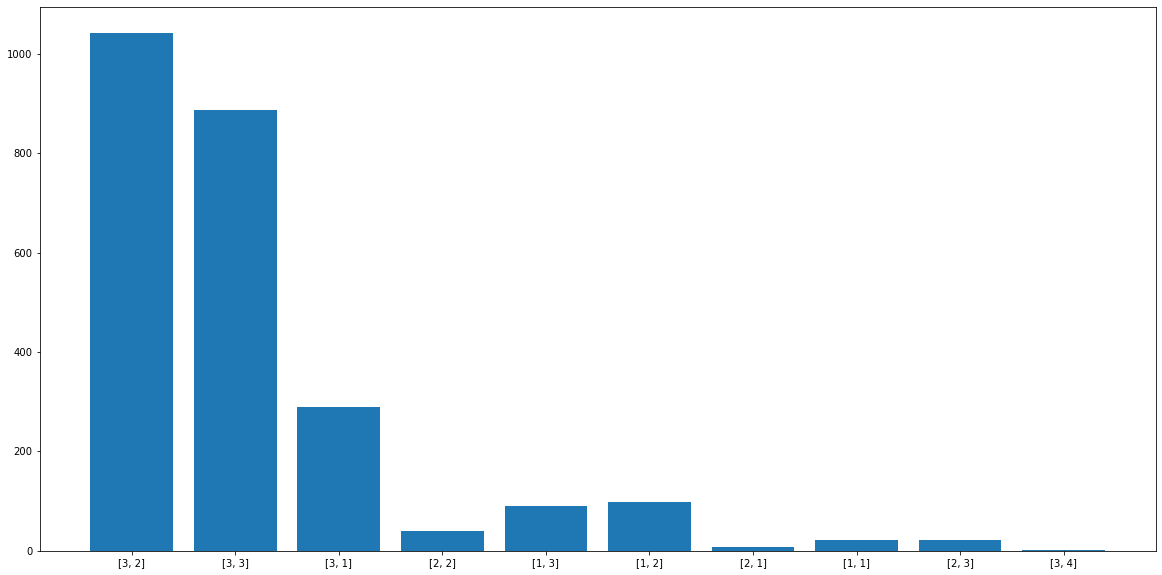

Processing Epoch 214
training start
Iteration 0, d real/fake loss 0.6146144866943359/0.6308802366256714 and g loss is 0.7684179544448853, NDiv loss 0.06945664435625076
Iteration 1, d real/fake loss 0.6147963404655457/0.6283431053161621 and g loss is 0.7657829523086548, NDiv loss 0.07403142750263214
Iteration 2, d real/fake loss 0.6149564981460571/0.6233876347541809 and g loss is 0.7597795724868774, NDiv loss 0.06706170737743378
Iteration 3, d real/fake loss 0.6150882244110107/0.6264527440071106 and g loss is 0.7686467170715332, NDiv loss 0.06818124651908875
Iteration 4, d real/fake loss 0.6151961088180542/0.621853768825531 and g loss is 0.754418134689331, NDiv loss 0.06887862831354141


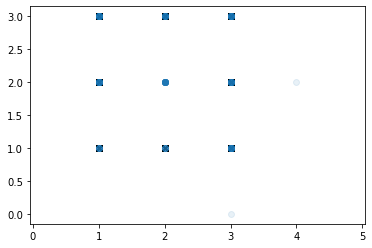

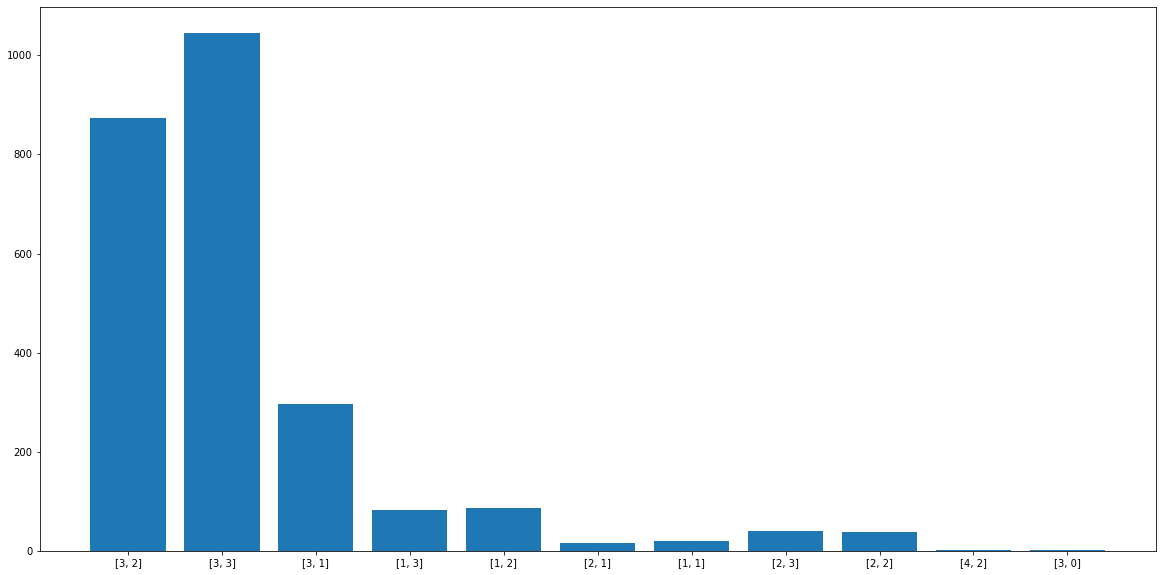

Processing Epoch 215
training start
Iteration 0, d real/fake loss 0.6004418134689331/0.6243941783905029 and g loss is 0.7744253873825073, NDiv loss 0.07538923621177673
Iteration 1, d real/fake loss 0.6002718806266785/0.6238254308700562 and g loss is 0.7745998501777649, NDiv loss 0.06745698302984238
Iteration 2, d real/fake loss 0.6000978946685791/0.6194634437561035 and g loss is 0.7716992497444153, NDiv loss 0.07269242405891418
Iteration 3, d real/fake loss 0.5999130606651306/0.6298482418060303 and g loss is 0.7737420797348022, NDiv loss 0.0782904103398323
Iteration 4, d real/fake loss 0.5997351408004761/0.6308526396751404 and g loss is 0.7725834846496582, NDiv loss 0.07526671141386032


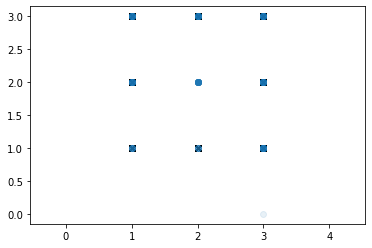

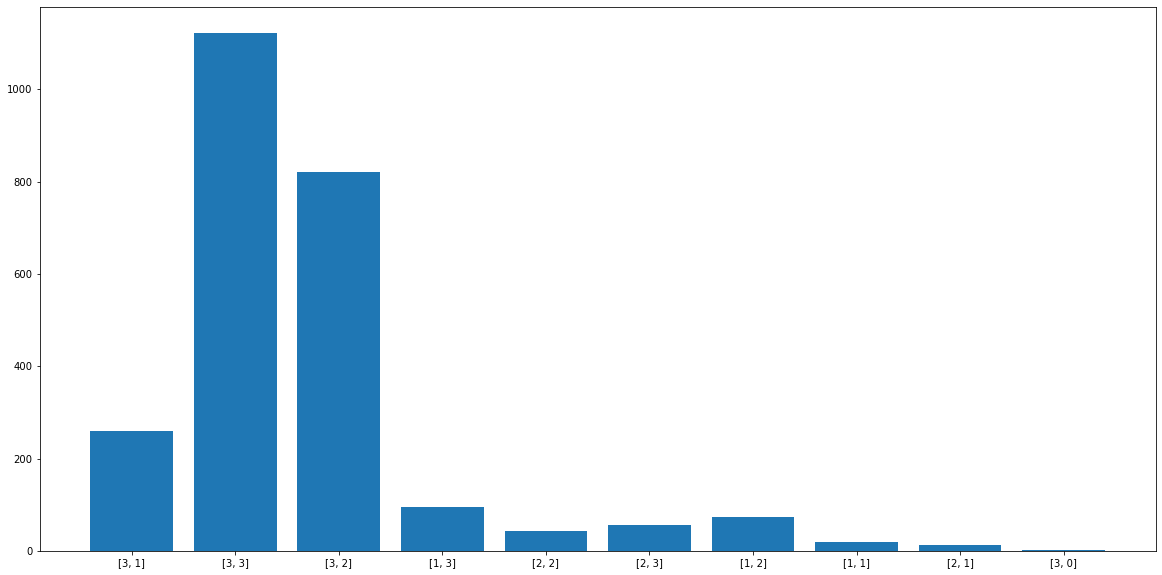

Processing Epoch 216
training start
Iteration 0, d real/fake loss 0.6105203628540039/0.6215752363204956 and g loss is 0.7764979600906372, NDiv loss 0.06613746285438538
Iteration 1, d real/fake loss 0.6105779409408569/0.628115713596344 and g loss is 0.7760016322135925, NDiv loss 0.07315371930599213
Iteration 2, d real/fake loss 0.6106353998184204/0.6218483448028564 and g loss is 0.7796933650970459, NDiv loss 0.07149796932935715
Iteration 3, d real/fake loss 0.6106810569763184/0.614891767501831 and g loss is 0.7827349305152893, NDiv loss 0.07278390973806381
Iteration 4, d real/fake loss 0.6107065081596375/0.6194993257522583 and g loss is 0.7844637036323547, NDiv loss 0.07426214218139648


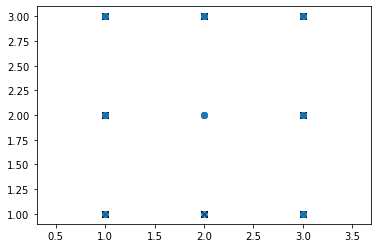

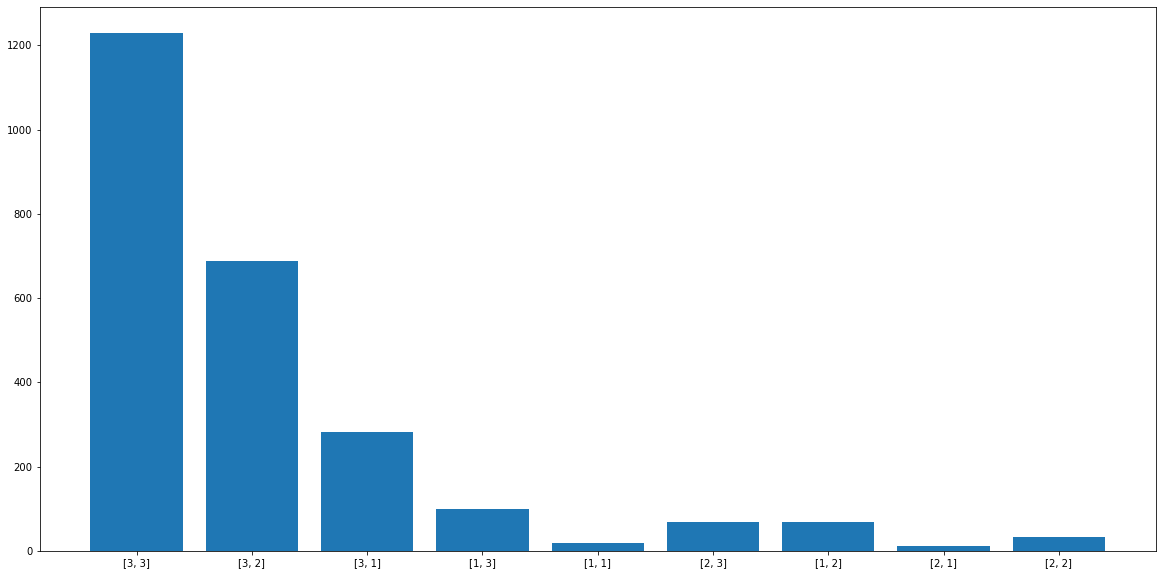

Processing Epoch 217
training start
Iteration 0, d real/fake loss 0.5980167388916016/0.6111700534820557 and g loss is 0.7682077884674072, NDiv loss 0.07479187101125717
Iteration 1, d real/fake loss 0.5978646874427795/0.6204676628112793 and g loss is 0.7726966738700867, NDiv loss 0.07130376994609833
Iteration 2, d real/fake loss 0.5977187156677246/0.6120795011520386 and g loss is 0.7864295244216919, NDiv loss 0.0670323595404625
Iteration 3, d real/fake loss 0.5975703597068787/0.6175161600112915 and g loss is 0.7750705480575562, NDiv loss 0.06197018548846245
Iteration 4, d real/fake loss 0.5974310636520386/0.6119160652160645 and g loss is 0.7772948741912842, NDiv loss 0.06856696307659149


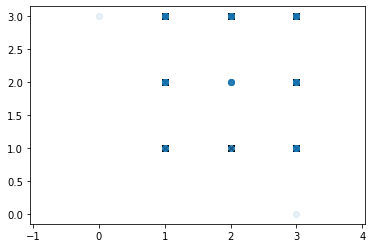

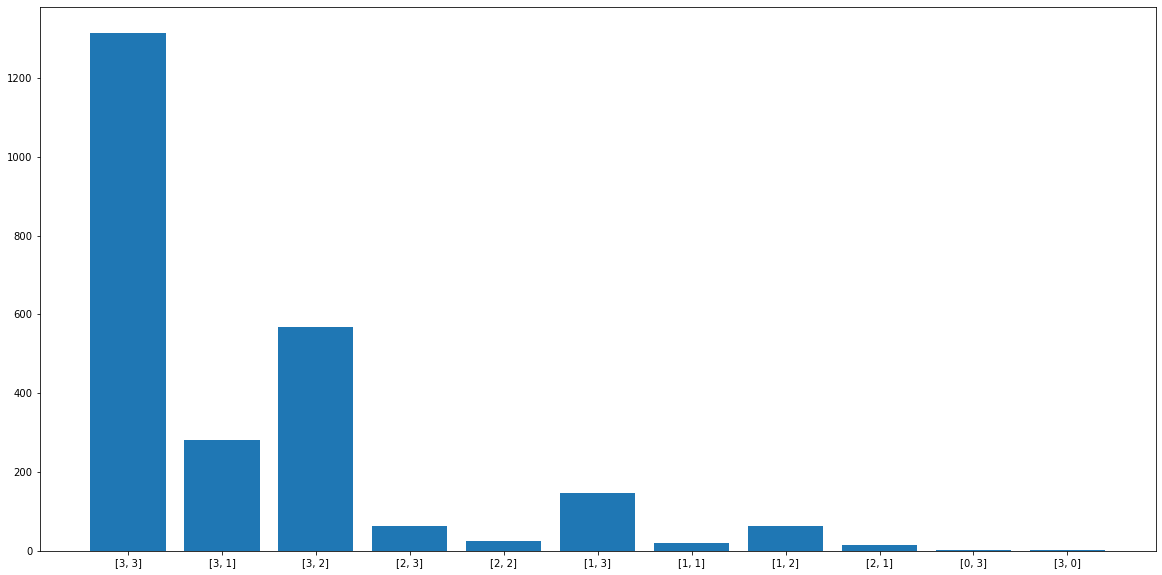

Processing Epoch 218
training start
Iteration 0, d real/fake loss 0.6207926273345947/0.6275455355644226 and g loss is 0.7783244848251343, NDiv loss 0.07483070343732834
Iteration 1, d real/fake loss 0.6209900379180908/0.6162742376327515 and g loss is 0.7830291390419006, NDiv loss 0.0678851306438446
Iteration 2, d real/fake loss 0.6211565136909485/0.613659143447876 and g loss is 0.7845453023910522, NDiv loss 0.06710659712553024
Iteration 3, d real/fake loss 0.621292769908905/0.6204608678817749 and g loss is 0.7840613126754761, NDiv loss 0.0697513073682785
Iteration 4, d real/fake loss 0.6214104890823364/0.6148019433021545 and g loss is 0.7845989465713501, NDiv loss 0.0705292820930481


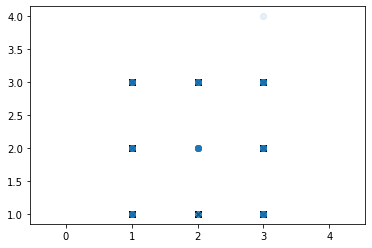

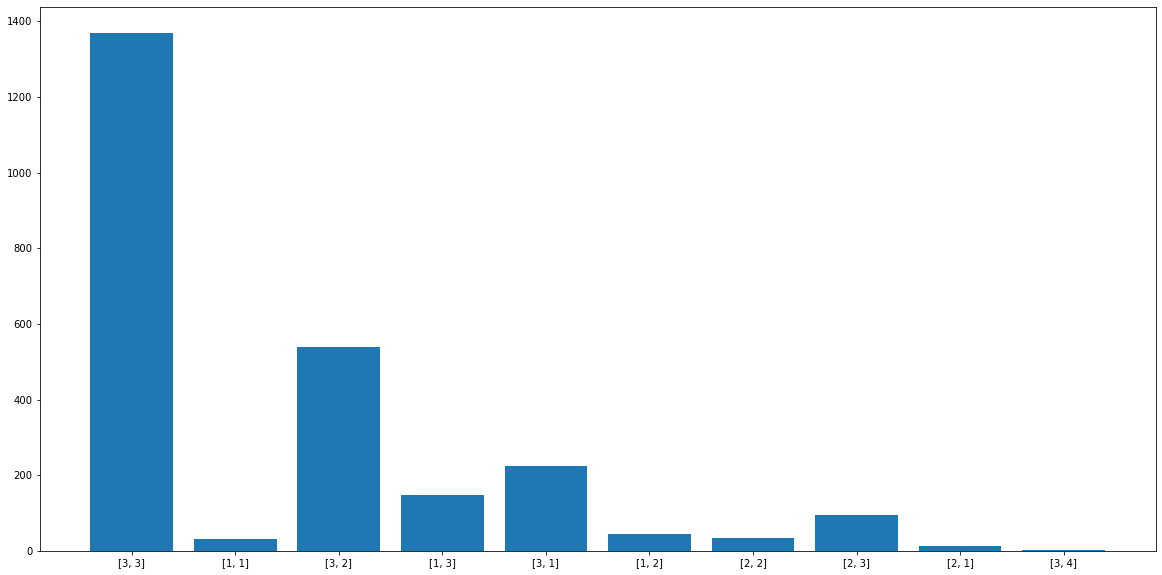

Processing Epoch 219
training start
Iteration 0, d real/fake loss 0.6111396551132202/0.6183671951293945 and g loss is 0.7832804918289185, NDiv loss 0.0725162997841835
Iteration 1, d real/fake loss 0.6111334562301636/0.6145167350769043 and g loss is 0.7732947468757629, NDiv loss 0.06913850456476212
Iteration 2, d real/fake loss 0.6111177802085876/0.6062099933624268 and g loss is 0.7752708196640015, NDiv loss 0.06986075639724731
Iteration 3, d real/fake loss 0.6110867857933044/0.61125648021698 and g loss is 0.7830538153648376, NDiv loss 0.06728282570838928
Iteration 4, d real/fake loss 0.6110491752624512/0.6232050061225891 and g loss is 0.7824188470840454, NDiv loss 0.07129638642072678


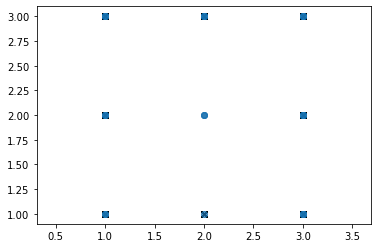

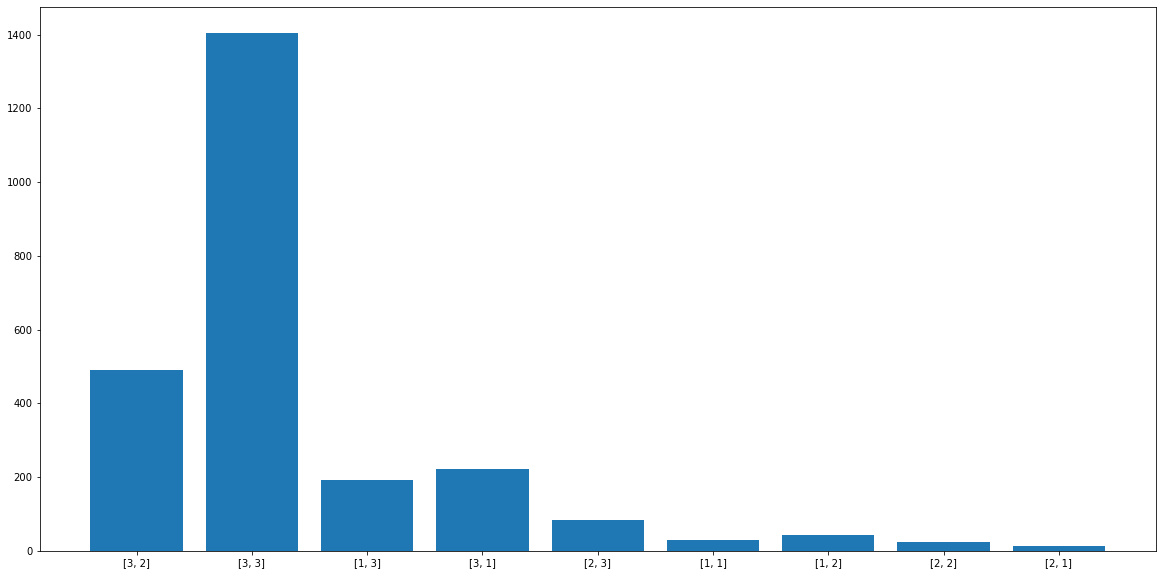

Processing Epoch 220
training start
Iteration 0, d real/fake loss 0.6075205206871033/0.6168274879455566 and g loss is 0.7729071378707886, NDiv loss 0.06890364736318588
Iteration 1, d real/fake loss 0.6076115369796753/0.6088614463806152 and g loss is 0.8003854751586914, NDiv loss 0.06736387312412262
Iteration 2, d real/fake loss 0.6076916456222534/0.61175137758255 and g loss is 0.7904465198516846, NDiv loss 0.06664436310529709
Iteration 3, d real/fake loss 0.6077673435211182/0.612316370010376 and g loss is 0.7803705930709839, NDiv loss 0.06778991222381592
Iteration 4, d real/fake loss 0.607843816280365/0.6071524024009705 and g loss is 0.7892106771469116, NDiv loss 0.07076525688171387


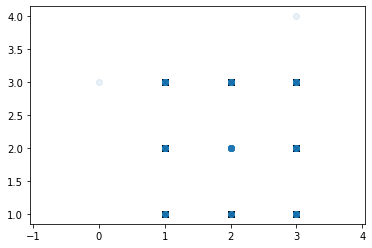

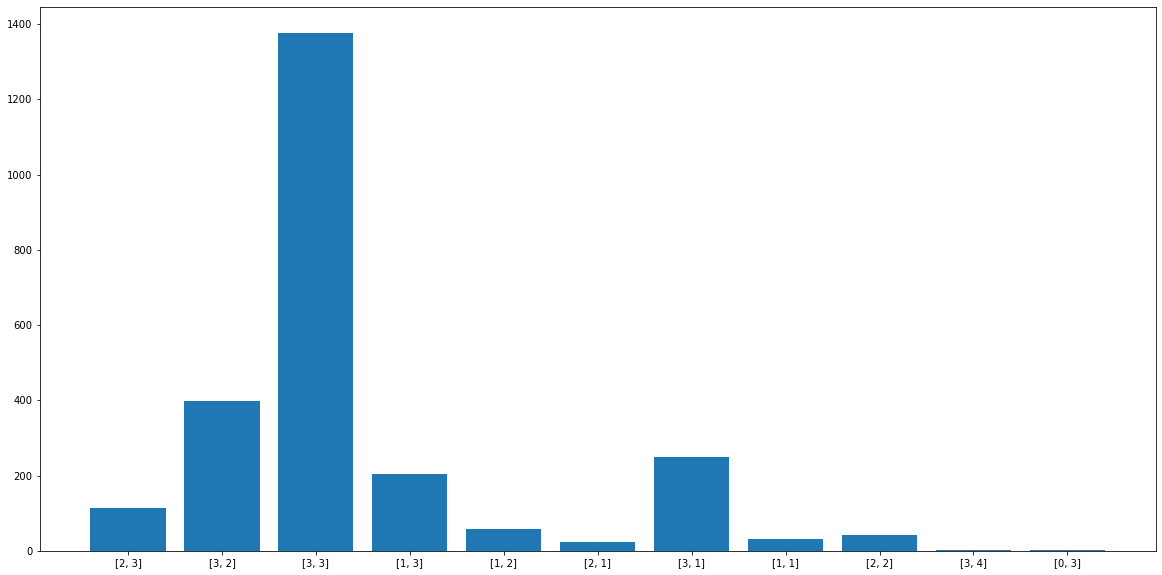

Processing Epoch 221
training start
Iteration 0, d real/fake loss 0.601839542388916/0.6113989949226379 and g loss is 0.7705600261688232, NDiv loss 0.06785184144973755
Iteration 1, d real/fake loss 0.601642370223999/0.615925669670105 and g loss is 0.7885965704917908, NDiv loss 0.07053378969430923
Iteration 2, d real/fake loss 0.6014555096626282/0.608279287815094 and g loss is 0.7978339195251465, NDiv loss 0.06484609842300415
Iteration 3, d real/fake loss 0.6012696027755737/0.6183396577835083 and g loss is 0.7855091094970703, NDiv loss 0.0669693574309349
Iteration 4, d real/fake loss 0.6011002659797668/0.5998778343200684 and g loss is 0.7954562306404114, NDiv loss 0.06663002073764801


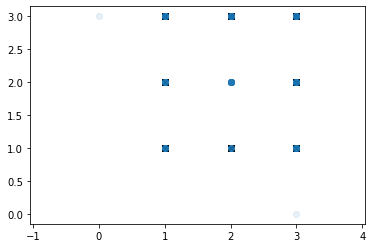

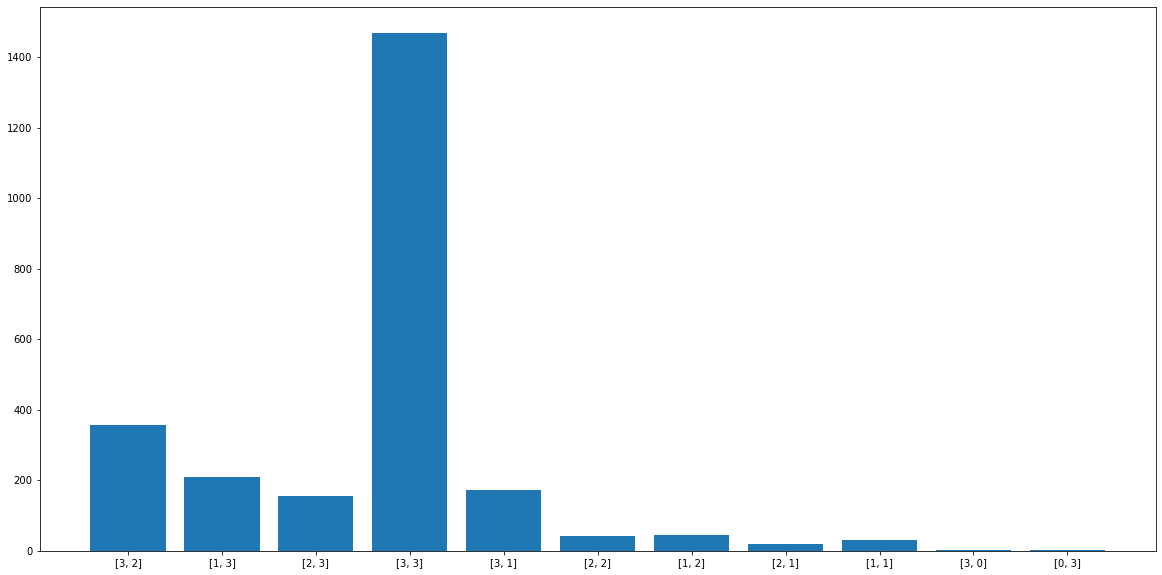

Processing Epoch 222
training start
Iteration 0, d real/fake loss 0.6226352453231812/0.6076970100402832 and g loss is 0.7840226888656616, NDiv loss 0.07211761921644211
Iteration 1, d real/fake loss 0.62259840965271/0.6180443167686462 and g loss is 0.7861431241035461, NDiv loss 0.07079875469207764
Iteration 2, d real/fake loss 0.6225423812866211/0.6192349791526794 and g loss is 0.7988207340240479, NDiv loss 0.06084906682372093
Iteration 3, d real/fake loss 0.6224641799926758/0.59721440076828 and g loss is 0.7881554365158081, NDiv loss 0.06416425108909607
Iteration 4, d real/fake loss 0.6223412156105042/0.6136799454689026 and g loss is 0.7881574630737305, NDiv loss 0.06867919862270355


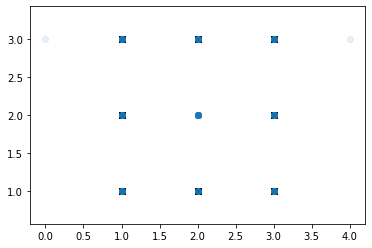

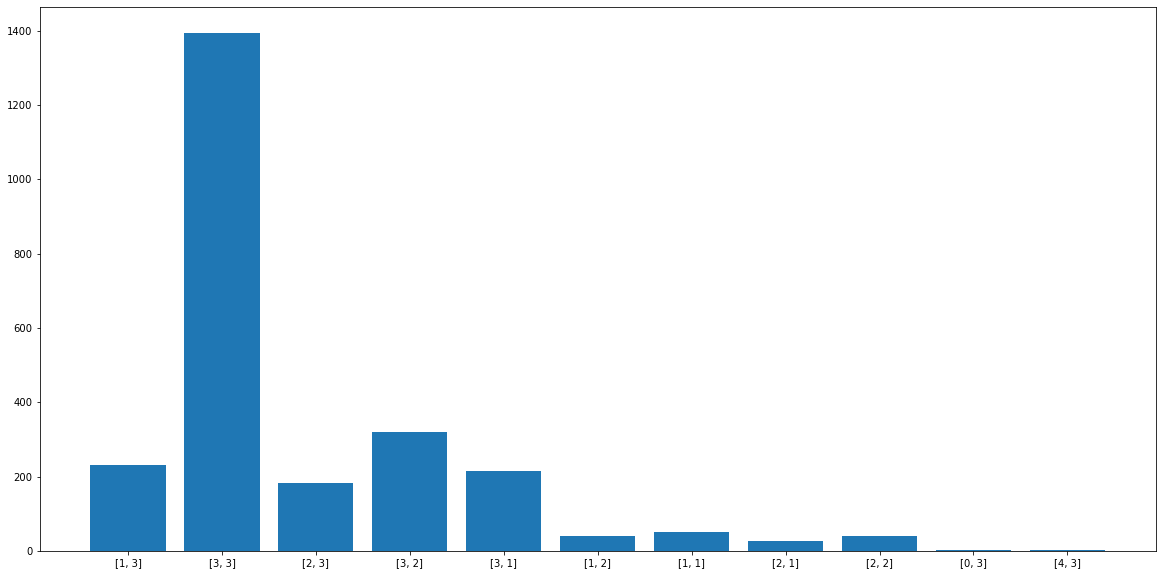

Processing Epoch 223
training start
Iteration 0, d real/fake loss 0.6092249155044556/0.603954553604126 and g loss is 0.7969368100166321, NDiv loss 0.06418479979038239
Iteration 1, d real/fake loss 0.6089901924133301/0.5980987548828125 and g loss is 0.801034688949585, NDiv loss 0.0636080726981163
Iteration 2, d real/fake loss 0.6087427139282227/0.600092351436615 and g loss is 0.7876536250114441, NDiv loss 0.05884670093655586
Iteration 3, d real/fake loss 0.608490526676178/0.6042872071266174 and g loss is 0.8055599927902222, NDiv loss 0.06693178415298462
Iteration 4, d real/fake loss 0.6082395315170288/0.6178845167160034 and g loss is 0.7992775440216064, NDiv loss 0.07142920792102814


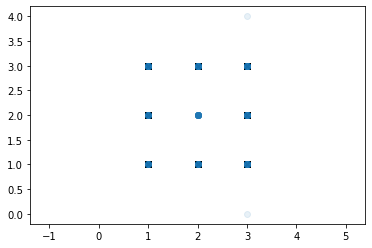

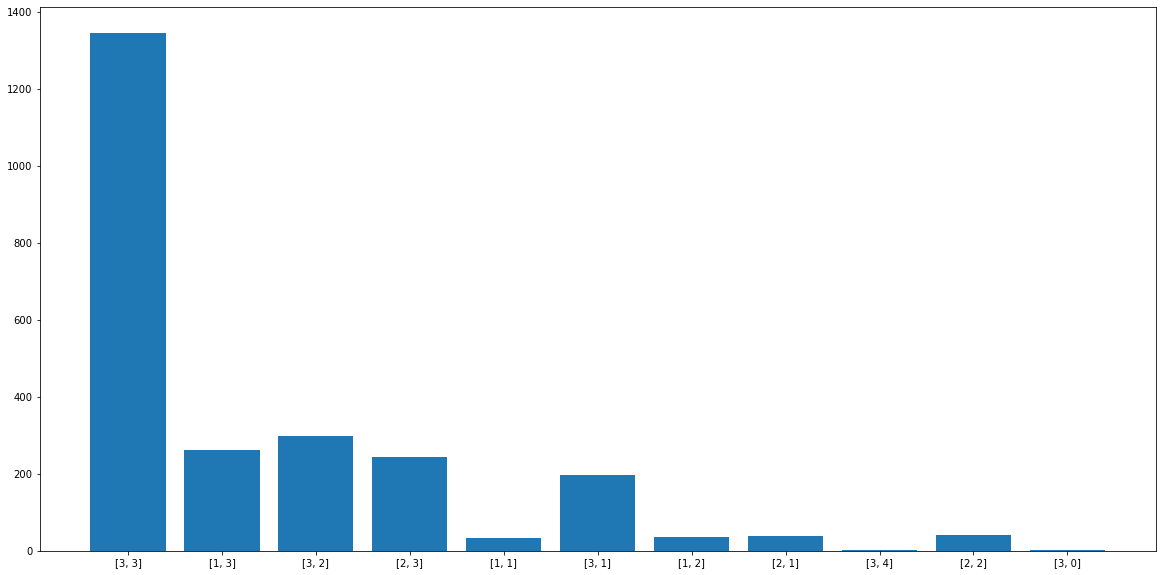

Processing Epoch 224
training start
Iteration 0, d real/fake loss 0.6009286046028137/0.595712423324585 and g loss is 0.7961017489433289, NDiv loss 0.06873305886983871
Iteration 1, d real/fake loss 0.6007344126701355/0.601035475730896 and g loss is 0.7928071022033691, NDiv loss 0.06374263763427734
Iteration 2, d real/fake loss 0.6005426645278931/0.6026499271392822 and g loss is 0.7980612516403198, NDiv loss 0.06741724908351898
Iteration 3, d real/fake loss 0.6003557443618774/0.6039638519287109 and g loss is 0.7981820106506348, NDiv loss 0.06287703663110733
Iteration 4, d real/fake loss 0.6001748442649841/0.6041711568832397 and g loss is 0.7986603379249573, NDiv loss 0.06523189693689346


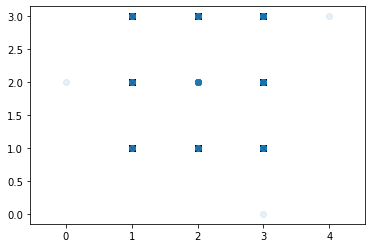

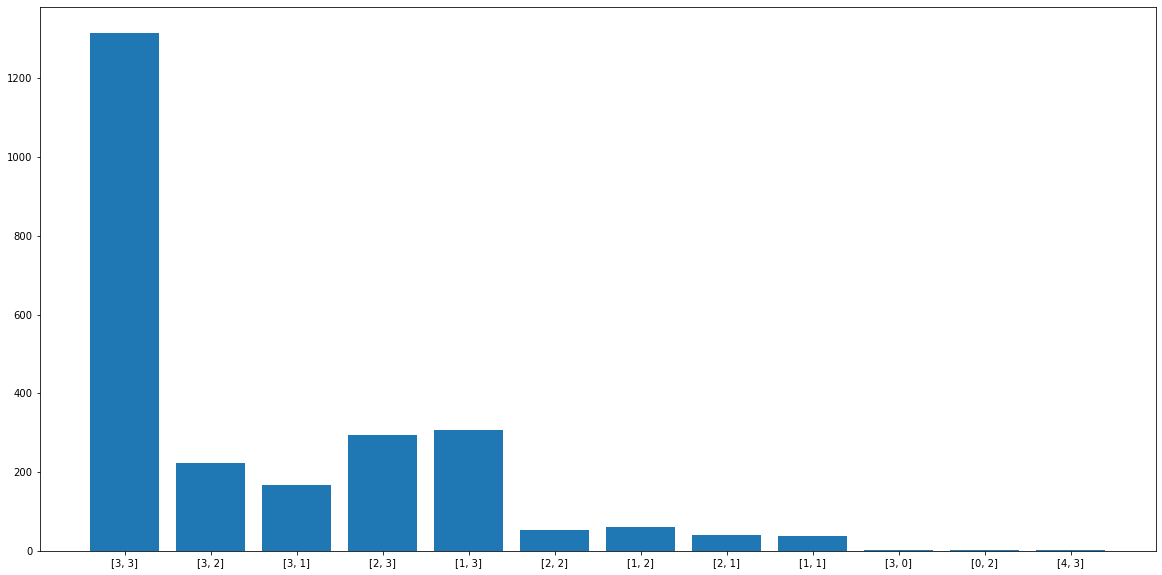

Processing Epoch 225
training start
Iteration 0, d real/fake loss 0.602469801902771/0.6040642261505127 and g loss is 0.7857420444488525, NDiv loss 0.06831198185682297
Iteration 1, d real/fake loss 0.6023283004760742/0.6045769453048706 and g loss is 0.7901960611343384, NDiv loss 0.06350619345903397
Iteration 2, d real/fake loss 0.6021773815155029/0.6068758368492126 and g loss is 0.8055829405784607, NDiv loss 0.06096542254090309
Iteration 3, d real/fake loss 0.6020219326019287/0.6077064275741577 and g loss is 0.8019207119941711, NDiv loss 0.06703267246484756
Iteration 4, d real/fake loss 0.6018719673156738/0.6061743497848511 and g loss is 0.7852218151092529, NDiv loss 0.05826909467577934


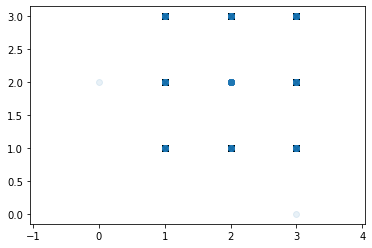

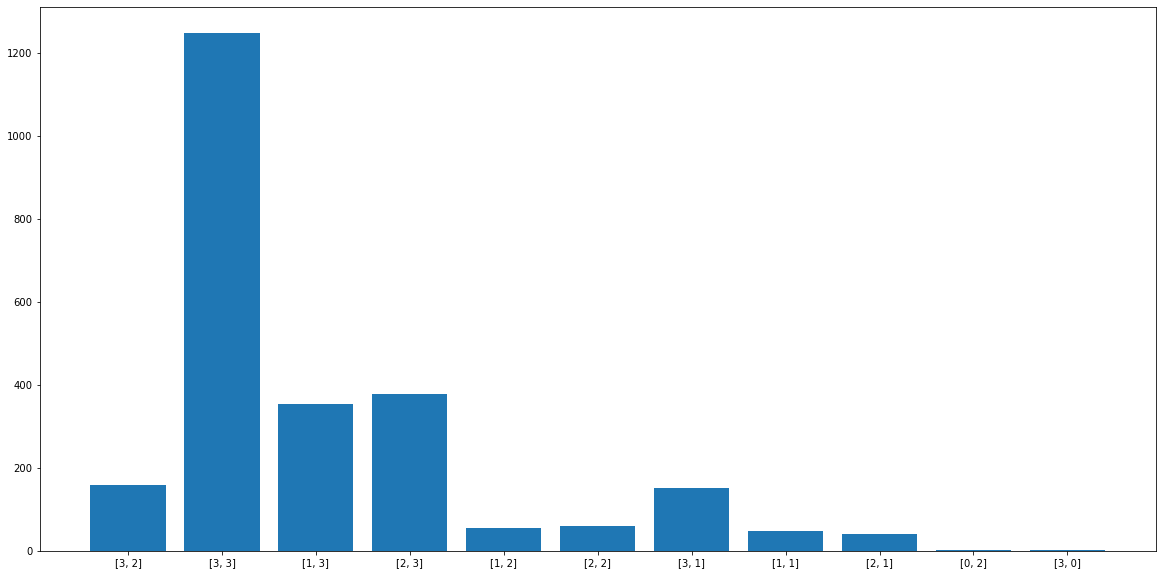

Processing Epoch 226
training start
Iteration 0, d real/fake loss 0.6073710918426514/0.613801121711731 and g loss is 0.7903532981872559, NDiv loss 0.0655599907040596
Iteration 1, d real/fake loss 0.6072840690612793/0.5975329875946045 and g loss is 0.8155235052108765, NDiv loss 0.06054079905152321
Iteration 2, d real/fake loss 0.6071746945381165/0.6144663095474243 and g loss is 0.7990826368331909, NDiv loss 0.06208115443587303
Iteration 3, d real/fake loss 0.6070654392242432/0.6111759543418884 and g loss is 0.7876281142234802, NDiv loss 0.06376064568758011
Iteration 4, d real/fake loss 0.6069568395614624/0.6058604717254639 and g loss is 0.8016863465309143, NDiv loss 0.0630144476890564


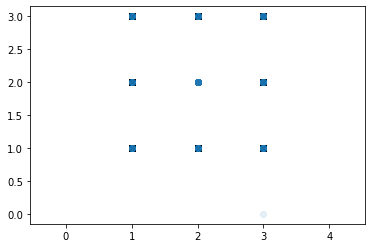

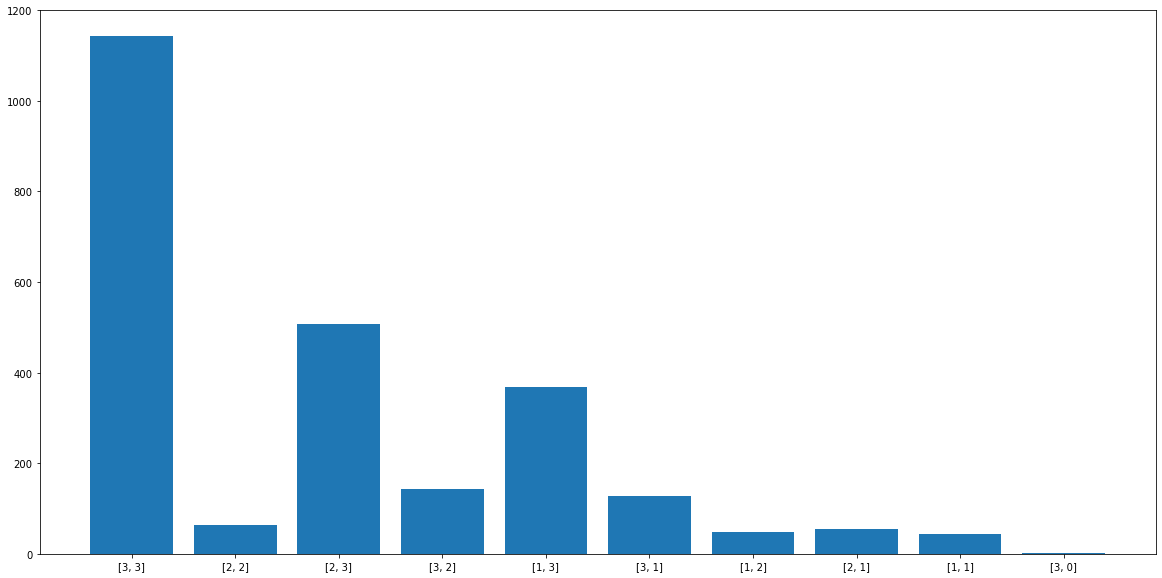

Processing Epoch 227
training start
Iteration 0, d real/fake loss 0.5954686999320984/0.6248792409896851 and g loss is 0.7948840856552124, NDiv loss 0.06962187588214874
Iteration 1, d real/fake loss 0.5952973365783691/0.6039431095123291 and g loss is 0.8057554960250854, NDiv loss 0.055782247334718704
Iteration 2, d real/fake loss 0.5951284170150757/0.6200863718986511 and g loss is 0.7959582805633545, NDiv loss 0.061840057373046875
Iteration 3, d real/fake loss 0.5949797630310059/0.6020209789276123 and g loss is 0.7924714088439941, NDiv loss 0.06037500128149986
Iteration 4, d real/fake loss 0.5948285460472107/0.6128917932510376 and g loss is 0.787665069103241, NDiv loss 0.06086402013897896


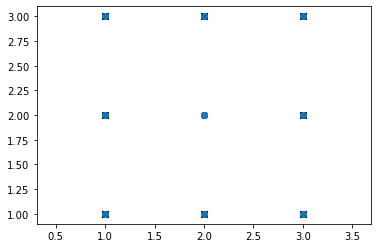

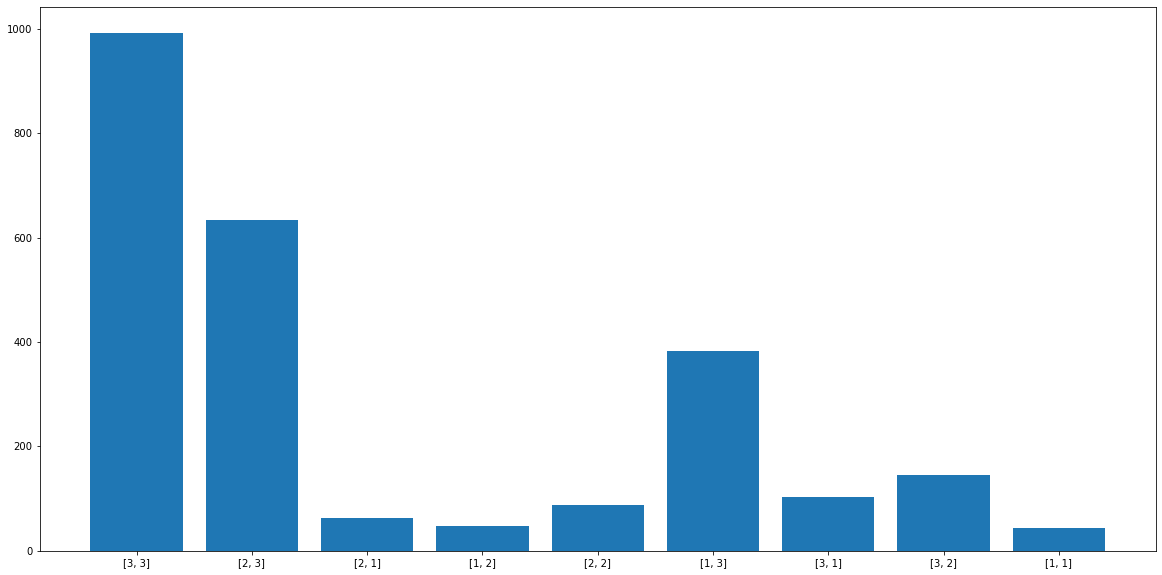

Processing Epoch 228
training start
Iteration 0, d real/fake loss 0.6051440238952637/0.6097372174263 and g loss is 0.7859243154525757, NDiv loss 0.058458466082811356
Iteration 1, d real/fake loss 0.6049994230270386/0.6215921640396118 and g loss is 0.7734305262565613, NDiv loss 0.06030353903770447
Iteration 2, d real/fake loss 0.6048557162284851/0.6037266254425049 and g loss is 0.7937415838241577, NDiv loss 0.06259547173976898
Iteration 3, d real/fake loss 0.6046943664550781/0.6288967132568359 and g loss is 0.7813981771469116, NDiv loss 0.05938833951950073
Iteration 4, d real/fake loss 0.6045436263084412/0.6234077215194702 and g loss is 0.7777954339981079, NDiv loss 0.05880805477499962


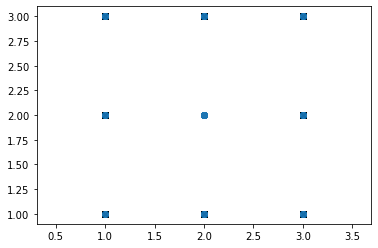

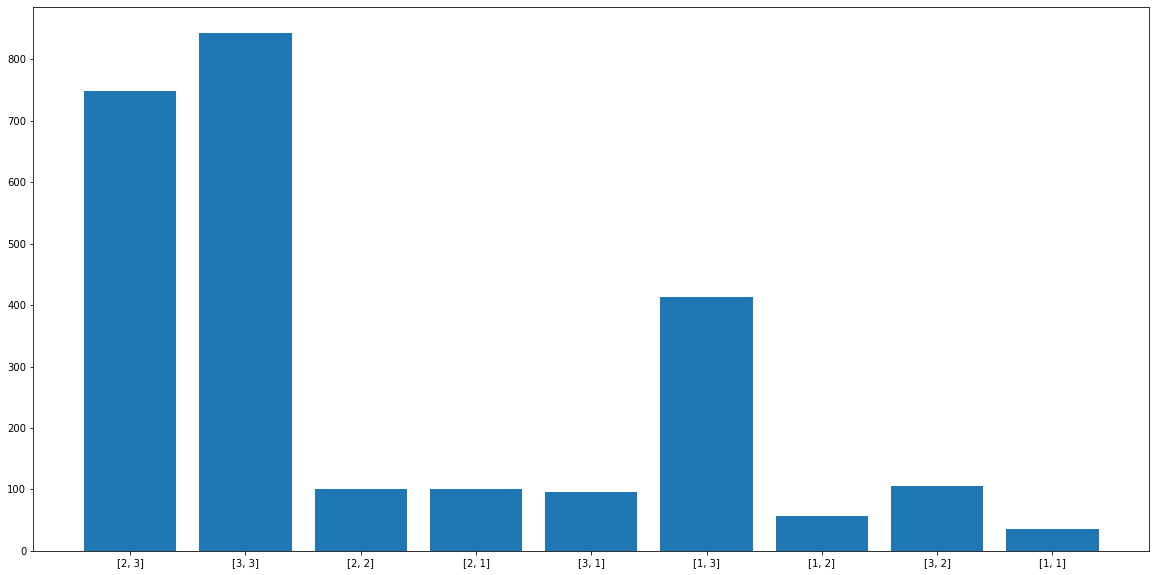

Processing Epoch 229
training start
Iteration 0, d real/fake loss 0.5836301445960999/0.6101111769676208 and g loss is 0.7654006481170654, NDiv loss 0.06305642426013947
Iteration 1, d real/fake loss 0.5834676027297974/0.6319845914840698 and g loss is 0.7845382690429688, NDiv loss 0.06006903201341629
Iteration 2, d real/fake loss 0.5833443999290466/0.6221733093261719 and g loss is 0.7783311605453491, NDiv loss 0.06425436586141586
Iteration 3, d real/fake loss 0.5832444429397583/0.625064492225647 and g loss is 0.7823905944824219, NDiv loss 0.06105780601501465
Iteration 4, d real/fake loss 0.5831722021102905/0.6207293272018433 and g loss is 0.7742699980735779, NDiv loss 0.05541388690471649


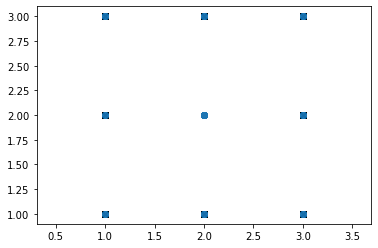

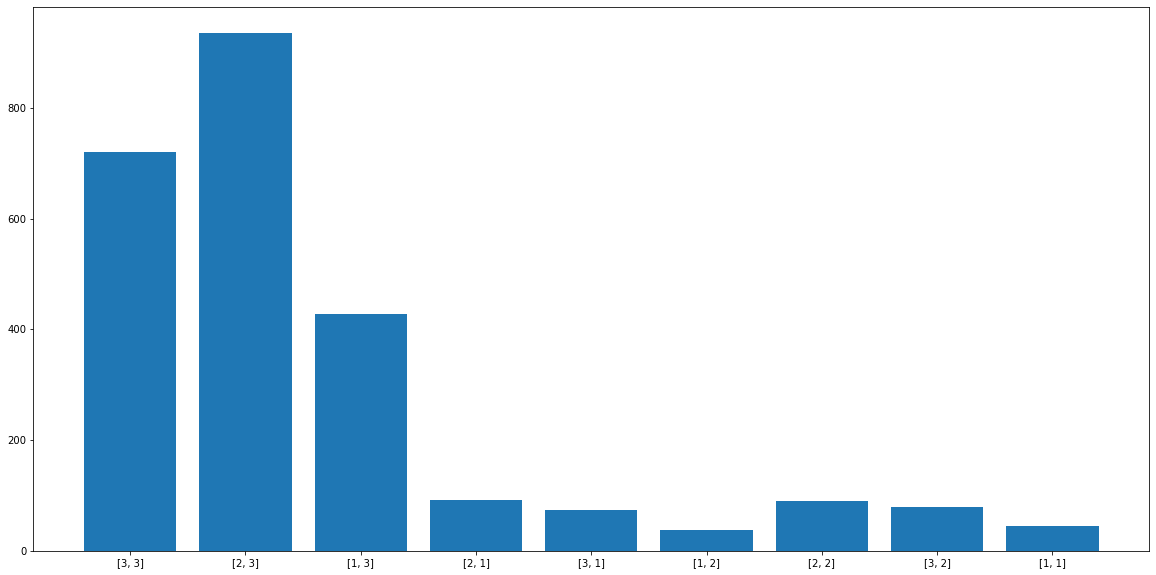

Processing Epoch 230
training start
Iteration 0, d real/fake loss 0.6015152335166931/0.6253482699394226 and g loss is 0.775934100151062, NDiv loss 0.0651622861623764
Iteration 1, d real/fake loss 0.6014975309371948/0.6209248900413513 and g loss is 0.7612804174423218, NDiv loss 0.06016397848725319
Iteration 2, d real/fake loss 0.6014736890792847/0.6395126581192017 and g loss is 0.7628189325332642, NDiv loss 0.06685769557952881
Iteration 3, d real/fake loss 0.601458728313446/0.6296147704124451 and g loss is 0.7761800289154053, NDiv loss 0.0627518892288208
Iteration 4, d real/fake loss 0.6014441251754761/0.6248207092285156 and g loss is 0.775958240032196, NDiv loss 0.06089603528380394


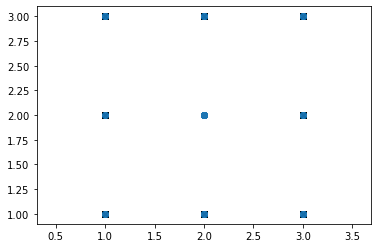

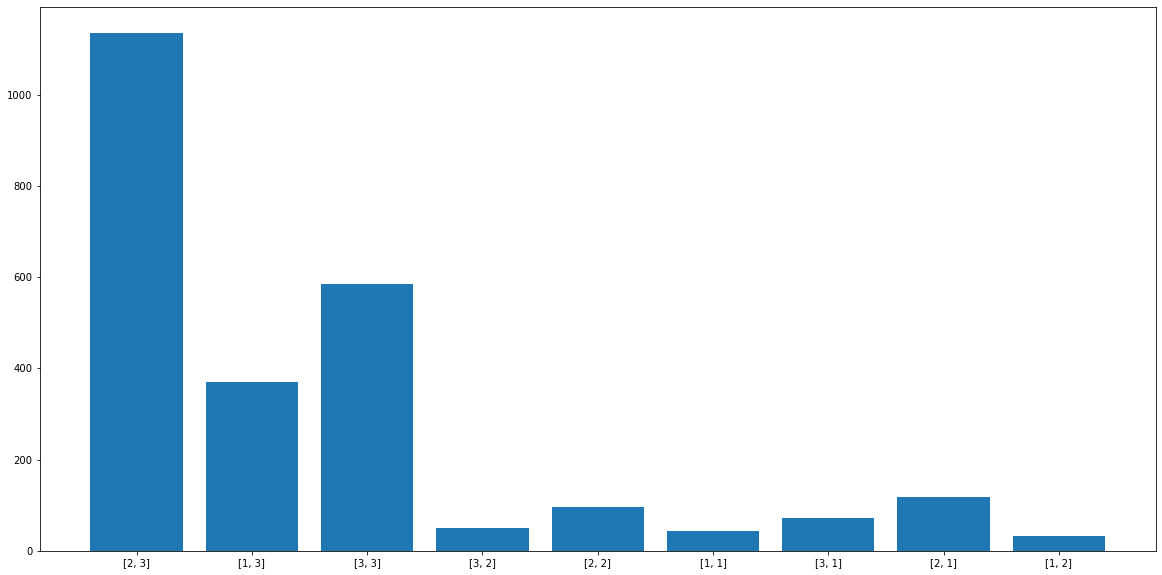

Processing Epoch 231
training start


KeyboardInterrupt: 

In [6]:
### Start training
for ep in range(400):
    print("Processing Epoch {}".format(ep))
    real_data = gen_real_data_onehot(dl, 128).float().cuda()
    input_data = gen_input_data(128).float().cuda()

    real_data = real_data.view(128, -1)    
    net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float().cuda()
    real_data = gen_real_data_onehot(dl, 1000).float().cuda()

#     d_fake, _ = net.g(input_data, temperature=100)
    d_fake, _ = net.g(input_data)
#     d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 1 == 0:
        plot_outputdata(real_data.data.cpu().numpy(), dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.data.cpu().numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.data.cpu().numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data]

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

Processing Epoch 0
Processing Epoch 1
Processing Epoch 2
Processing Epoch 3
Processing Epoch 4
Processing Epoch 5
Processing Epoch 6
Processing Epoch 7
Processing Epoch 8
Processing Epoch 9


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

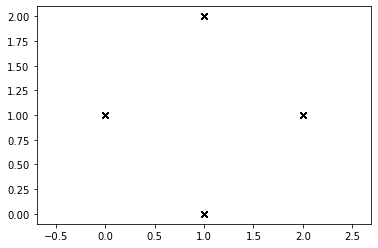

In [18]:
### Start training
for ep in range(500):
    print("Processing Epoch {}".format(ep))
#     real_data = gen_real_data_onehot(dl, 1024).float()
#     input_data = gen_input_data(1024).float()

#     real_data = real_data.view(1024, -1)    
#     net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float()
    real_data = gen_real_data_onehot(dl, 1000).float()

#     d_fake, _ = net.g(input_data, temperature=0.001)
#         d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 10 == 0:
        plot_outputdata(real_data, dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data] 

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

### Conclusion: Put Regularizer without limits would make all logits closer to 0, thus uniform noisy ~ U(0, 1)
### from gumbel reparameterization would do play a BBBBBBbig factor.
### Clearly value range (0, 0.001) would be influced greatly from U(0, 1);